# Recommender System

## Import Libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import graphlab as gl

## Upload Song Data

**Upload already cleaned and wrangled song data (from the million song dataset).**

In [2]:
songs_path = ('/Users/ivettetapia 1/Symbolic Link Seagate Drive/Springboard/Capstone 1_Mus_Recomend/Data/msd_song_metadata.csv')

songs = pd.read_csv(songs_path, na_values = 'NaN', index_col = 0)

**Drop columns that are not relevant for recomendation below. These are either columns with 0 values (danceability and energy), columns that have ids/indexes or represent confidence in song measurements.**

In [3]:
columns = ['artist_7digitalid','artist_mbid','artist_playmeid','idx_artist_terms',
           'idx_similar_artists','release_7digitalid','track_7digitalid','analysis_sample_rate',
           'audio_md5','danceability','energy','idx_bars_confidence',
           'idx_bars_start','idx_beats_confidence','idx_sections_start',
           'idx_segments_confidence','idx_segments_loudness_max','idx_segments_loudness_max_time',
           'idx_segments_loudness_start','idx_segments_pitches','idx_segments_start','idx_segments_timbre',
           'idx_tatums_confidence','idx_tatums_start','key_confidence','mode_confidence',
           'time_signature_confidence','track_id','idx_artist_mbtags','idx_beats_start','idx_sections_confidence']

songs = songs.drop(labels = columns, axis = 1)

print(songs.info())

songs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905712 entries, 0 to 981021
Data columns (total 20 columns):
artist_familiarity    905531 non-null float64
artist_hotttnesss     905700 non-null float64
artist_id             905712 non-null object
artist_latitude       325985 non-null float64
artist_location       460185 non-null object
artist_longitude      325985 non-null float64
artist_name           905712 non-null object
release               905712 non-null object
song_hotttnesss       551532 non-null float64
song_id               905712 non-null object
title                 905708 non-null object
duration              905712 non-null float64
end_of_fade_in        905712 non-null float64
key                   905712 non-null int64
loudness              905712 non-null float64
mode                  905712 non-null int64
start_of_fade_out     905712 non-null float64
tempo                 905712 non-null float64
time_signature        905712 non-null int64
year                  45681

,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_name,release,song_hotttnesss,song_id,title,duration,end_of_fade_in,key,loudness,mode,start_of_fade_out,tempo,time_signature,year
0,0.649822,0.394032,ARYZTJS1187B98C555,NaN,NaN,NaN,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night,252.05506,2.049,10,-4.829,0,236.635,87.002,4,2003.0
1,0.439604,0.356992,ARMVN3U1187FB3A1EB,NaN,NaN,NaN,Karkkiautomaatti,Karkuteill\xc3\xa4,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,156.55138,0.258,9,-10.555,1,148.660,150.778,1,1995.0
2,0.643681,0.437504,ARGEKB01187FB50750,55.8578,"Glasgow, Scotland",-4.24251,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,138.97098,0.000,7,-2.060,1,138.971,177.768,4,2006.0
3,0.448501,0.372349,ARNWYLR1187B9B2F9C,NaN,NaN,NaN,Yerba Brava,De Culo,NaN,SOBNYVR12A8C13558C,Si Vos Quer\xc3\xa9s,145.05751,0.000,7,-4.654,1,138.687,87.433,4,2003.0
4,0.000000,0.000000,AREQDTE1269FB37231,NaN,NaN,NaN,Der Mystic,Rene Ablaze Presents Winter Sessions,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens,514.29832,0.000,5,-7.806,0,506.717,140.035,4,NaN


## Upload User Data

**Upload already cleaned and wrangled user listen data (from the million song dataset and taste profile subset).**

In [4]:
users_path = ('/Users/ivettetapia 1/Symbolic Link Seagate Drive/Springboard/Capstone 1_Mus_Recomend/Data/msd_user_data.csv')

users = pd.read_csv(users_path, na_values = 'NaN', index_col = 0)

print(users.info())

users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48373586 entries, 0 to 48373585
Data columns (total 4 columns):
user_id       object
song_id       object
play_count    int64
play          int64
dtypes: int64(2), object(2)
memory usage: 1.8+ GB
None


,user_id,song_id,play_count,play
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,1


**My machine cannot handle all the user data. I am setting unique listen thresholds for user song listens. The goal of this is to have a principled way of eliminating users, while still maintaining a good sample of users.**

In this case, I am eliminating users with less than 45 song listens and less than 452. As shown in the exploratory analysis, there is a big long tail that begins at ~450 song listens. Moreover, unique song listens beyond 2,000 are suspect because is unlikely an user can listen to this amount of music in the course of ten days (the time span the dataframe was compiled).

In [5]:
thres_1 = len(songs)*0.00005

thres_2 = len(songs)*0.0005

print("Less than threshold of unique song plays:", thres_1) #instances of unique song-user interactions.
print('More than threshold of unique song plays:', thres_2) #instances of unique song-user interactions.

('Less than threshold of unique song plays:', 45.2856)
('More than threshold of unique song plays:', 452.856)


**Group users by user_id and sum columns. This is to identify the users that satisfy and do not satisfy unique listens threshold criteria **

In [6]:
users_grouped = users.groupby('user_id',as_index=False).sum()

print('Total Users: ', len(users_grouped))

print(users_grouped.head())

('Total Users: ', 1019318)
                                    user_id  play_count  play
0  00000b722001882066dff9d2da8a775658053ea0          13    12
1  00001638d6189236866af9bbf309ae6c2347ffdc          56    14
2  0000175652312d12576d9e6b84f600caa24c4715          19    12
3  00001cf0dce3fb22b0df0f3a1d9cd21e38385372          25    18
4  0000267bde1b3a70ea75cf2b2d216cb828e3202b          27    25


**Eliminate users that DO NOT satisfy unique listen criteria.**

In [7]:
users_grouped_filt = users_grouped[(users_grouped['play'] > thres_1) & 
                                   (users_grouped['play'] < thres_2)]

print('Filtered Users (i.e. remaining users): ', len(users_grouped_filt)) 

#Eliminated around 2/3 of users using threshold criteria

('Filtered Users (i.e. remaining users): ', 313689)


**Filter user song data by the list of users who satisfy unique song listens/interactions threshold criteria**

In [8]:
users_filt = users.merge(users_grouped_filt[['user_id']], on = 'user_id', how='inner',suffixes=('_x', '_y'))

In [9]:
# See results of filtering

users_filt.info()

users_filt.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31754801 entries, 0 to 31754800
Data columns (total 4 columns):
user_id       object
song_id       object
play_count    int64
play          int64
dtypes: int64(2), object(2)
memory usage: 1.2+ GB


,user_id,song_id,play_count,play
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,1


In [10]:
#Sanity check. Confirm the number of unique users is the same.

users_filt.user_id.nunique()

#313,689 users with 31,754,801 observations

313689

## Convert objects fields

**Convert objects type columns to string and floats to int in both user data and songs dataframes. This is to facilitate conversion to GraphLab's SFrame format. An SF will not accept a pandas column whose type is an object.**

In [11]:
#Objects in the user df

users_filt[['user_id','song_id']] = users_filt[['user_id','song_id']].astype('|S250')

In [12]:
#Objects in the songs df

songs[['artist_id','artist_location', 'artist_name','release','song_id','title']] = songs[['artist_id','artist_location', 'artist_name','release','song_id','title']].astype('|S250')

## Convert Pandas DataFrames to SFrames

**Convert user data pandas dataframe to GraphLab SFrame format to use GraphLab libraries recommendation algorithms. The graphlab library can only be used with their SArrays and SFrames formats**

In [13]:
users_sf = gl.SFrame(data=users_filt)

This non-commercial license of GraphLab Create for academic use is assigned to ivette1989@gmail.com and will expire on August 19, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1535856627.log


**Randomly shuffle the user data. This is a preprocesing step to ensure location of data does not have an impact on training - test sample drawing. Random seed is set to 42. It will be the same throughout.**

In [14]:
#Randomly shuffle the data. This is a preprocesing step.

random_seed=42 #this random seed will be the same throughout.

users_sf = gl.cross_validation.shuffle(users_sf,random_seed = random_seed)

users_sf

user_id,song_id,play_count,play
d435af9885e7a99a8fc330b7e4693e8efd24932f ...,SOLSFPA12A6D4FAFB2,1,1
c605e48b580ed998a999005675f6bc65496dc437 ...,SOGGTYQ12A8C133BAD,1,1
850452f59960157c712fd1ec41894d2f632d13e4 ...,SOKKKZW12A6D4F7F88,2,1
c3ef1d45ada29646c9031c327fd02566dd5a732c ...,SOQIUXU12A67ADAEF4,2,1
be963f98fac8af2cbc4760e085ad1b3febea7d56 ...,SOCVNLL12A8C13B4EA,1,1
09e4e9b9ba6dd8aa8a5f1c3b58e57bacfc14090d ...,SOLIXJQ12A6D4F8C4D,1,1
e831eb92afb6fc49ce77067a5c5b3717cf5e7d1e ...,SOYYJMW12A6D4F8636,10,1
46d82b8750edb1fd9f6d4f3b0238f56030f478c2 ...,SOHRQFL12A6D4F3C8A,1,1
f1b57127863836c14413d4bfd9f4bd9827a82d19 ...,SOVMGAJ12AB0181580,1,1
c9e30e24637e4cf6f0a35ed4ebacf6f9e1597e17 ...,SOQSCOQ12A81C234C8,1,1


**Convert song data pandas dataframe to GraphLab SFrame format to use GraphLab libraries recommendation algorithms. The graphlab library can only be used with their SArrays and SFrames formats**

In [15]:
songs_sf = gl.SFrame(data=songs)

**Randomly shuffle the song data. This is a preprocesing step to ensure location of data does not have an impact. It will be the same throughout.**

In [16]:
#Randomly shuffle the data.This is a preprocesing step.

songs_sf = gl.cross_validation.shuffle(songs_sf,random_seed=random_seed)

songs_sf

artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude
0.676279034535,0.440250907534,ARHAIBP1187B99FB99,40.65507,"Brooklyn, NY",-73.94888
0.609602860049,0.424077070114,ARNIDSZ1187FB564B5,nan,Germany/Munich,nan
0.556038044172,0.440037146261,AR5OFO01187B98C9B1,nan,nan,nan
0.589357755432,0.46550988432,ARNW1JU1187B9B88D3,30.9742,Louisiana,-91.52382
0.655429099673,0.445779051107,ARMSWRC1187FB4CD02,nan,"Reston, Virginia",nan
0.512814937369,0.353487741638,ARFSC4Y1187FB459C1,nan,nan,nan
0.650177336245,0.40496324532,AR2B3K21187B9B9A2E,nan,nan,nan
0.691125976977,0.557643463149,AR3W2UH1187FB4D57C,51.16418,Germany,10.45415
0.636119207143,0.363499577136,ARL6UP41187FB5C604,nan,nan,nan
0.624668645159,0.409180608729,ARG7XSH1187FB49058,nan,nan,nan


## User Data Train - Test Splits

**The graphlab function random_split_by_user creates a recommender-friendly train-test split of the provided data set.**

The test dataset is generated by first choosing max_num_users out of the total number of users in dataset. Then, for each of the chosen test users, a portion of the user’s items (determined by item_test_proportion) is randomly chosen to be included in the test set. This split allows the training data to retain enough information about the users in the testset, so that adequate recommendations can be made. The total number of users in the test set may be fewer than max_num_users if a user was chosen for the test set but none of their items are selected.

**Create 80% train and 20% test split of the user data.**

In [17]:
# Create test and train splits based on user_ids

max_num_users1= round(len(users_grouped_filt)*.2) #max number of users to be included in the test set

users_train1, users_test1 = gl.recommender.util.random_split_by_user(users_sf,
                                                                     user_id = 'user_id',
                                                                     item_id = 'song_id',
                                                                     item_test_proportion = 0.2,
                                                                     max_num_users= max_num_users1,
                                                                     random_seed=random_seed)

print('Length of Train and Test Samples:', len(users_train1),len(users_test1))

('Length of Train and Test Samples:', 30486487, 1268314)


**Create 90% train and 10% test split of the user data.**

In [18]:
# Create test and train splits based on user

max_num_users2= round(len(users_grouped_filt)*.1) #max number of users to be included in the test set

users_train2, users_test2 = gl.recommender.util.random_split_by_user(users_sf,
                                                                     user_id = 'user_id',
                                                                     item_id = 'song_id',
                                                                     item_test_proportion = 0.1,
                                                                     max_num_users= max_num_users2,
                                                                     random_seed=random_seed)

print('Length to Train and Test Samples:', len(users_train2),len(users_test2))

('Length to Train and Test Samples:', 31437451, 317350)


## Create Baseline: Song Popularity Based Recommender

The Popularity Model ranks an item according to its overall popularity.

This model is used as a frame of reference for the subsequent approaches. This recomender does  not have any personalization at all. It recommends the most popular items to users. **There are no hyperparameters to set.**

When making recommendations, the items are scored by the number of times it is seen in the training set. The item scores are the same for all users. Hence the recommendations are not tailored for individuals.

The Popularity Recommender is simple and fast and provides a reasonable baseline. It can work well when observation data is sparse. It can be used as a “background” model for new users.

Model Documentation: https://turi.com/products/create/docs/generated/graphlab.recommender.popularity_recommender.create.html#graphlab.recommender.popularity_recommender.create

**Train song popularity recomender using 80%-20% test-train split**

In [19]:
song_popularity1 =  gl.popularity_recommender.create(observation_data = users_train1, 
                                                    item_id = 'song_id',
                                                    user_id='user_id',
                                                    item_data = songs_sf,
                                                    random_seed=random_seed,
                                                    verbose=False)

Recsys training: model = popularity

**Train song popularity recomender using 90%-10% test-train split**

In [20]:
song_popularity2 =  gl.popularity_recommender.create(observation_data = users_train2, 
                                                    item_id = 'song_id',
                                                    user_id='user_id',
                                                    item_data = songs_sf,
                                                    random_seed=random_seed,
                                                    verbose=False)

Recsys training: model = popularity

**Save Trained Song Popularity Recomenders to the Local Machine**

In [21]:
song_popularity1.save('song_popularity_trained1')

In [22]:
song_popularity2.save('song_popularity_trained2')

**See Recomender Training Summaries & Available Related Data (Field List)**

In [23]:
song_popularity1.summary() #90-10 split recomender

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 30486487
Number of users                  : 313689
Number of items                  : 929410

Training summary
----------------
Training time                    : 0.177

Model Parameters
----------------
Model class                      : PopularityRecommender



In [24]:
song_popularity2.summary() #90-10 split recomender

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 31437451
Number of users                  : 313689
Number of items                  : 929481

Training summary
----------------
Training time                    : 0.2021

Model Parameters
----------------
Model class                      : PopularityRecommender



In [25]:
song_popularity1.list_fields() #80-20 split recomender

['data_load_time',
 'item_id',
 'item_predictions',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'model_name',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'target',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

In [26]:
song_popularity2.list_fields() #90-10 split recomender

['data_load_time',
 'item_id',
 'item_predictions',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'model_name',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'target',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

**Upload Locally Saved Song Popularity Recomenders**

In [27]:
loaded_song_pop1 = gl.load_model('song_popularity_trained1') #80-20 split recomender

In [28]:
loaded_song_pop2 = gl.load_model('song_popularity_trained2') #90-10 split recomender

**Generate Recomendations and Evaluate Song Popularity Recomender Precision and Recall on User Test Data**

In [29]:
eval_song_pop1 = loaded_song_pop1.evaluate_precision_recall(users_test1) #80-20 split recomender

recommendations finished on 1000/62738 queries. users per second: 91.2334

recommendations finished on 2000/62738 queries. users per second: 98.7474

recommendations finished on 3000/62738 queries. users per second: 102.252

recommendations finished on 4000/62738 queries. users per second: 104.994

recommendations finished on 5000/62738 queries. users per second: 107.186

recommendations finished on 6000/62738 queries. users per second: 109.588

recommendations finished on 7000/62738 queries. users per second: 111.219

recommendations finished on 8000/62738 queries. users per second: 113.005

recommendations finished on 9000/62738 queries. users per second: 114.553

recommendations finished on 10000/62738 queries. users per second: 115.337

recommendations finished on 11000/62738 queries. users per second: 115.231

recommendations finished on 12000/62738 queries. users per second: 116.17

recommendations finished on 13000/62738 queries. users per second: 116.231

recommendations finished on 14000/62738 queries. users per second: 116.557

recommendations finished on 15000/62738 queries. users per second: 117.197

recommendations finished on 16000/62738 queries. users per second: 117.615

recommendations finished on 17000/62738 queries. users per second: 117.654

recommendations finished on 18000/62738 queries. users per second: 118.014

recommendations finished on 19000/62738 queries. users per second: 118.555

recommendations finished on 20000/62738 queries. users per second: 118.995

recommendations finished on 21000/62738 queries. users per second: 119.259

recommendations finished on 22000/62738 queries. users per second: 119.658

recommendations finished on 23000/62738 queries. users per second: 119.883

recommendations finished on 24000/62738 queries. users per second: 120.287

recommendations finished on 25000/62738 queries. users per second: 120.468

recommendations finished on 26000/62738 queries. users per second: 120.808

recommendations finished on 27000/62738 queries. users per second: 120.822

recommendations finished on 28000/62738 queries. users per second: 121.001

recommendations finished on 29000/62738 queries. users per second: 121.043

recommendations finished on 30000/62738 queries. users per second: 121.31

recommendations finished on 31000/62738 queries. users per second: 121.438

recommendations finished on 32000/62738 queries. users per second: 121.63

recommendations finished on 33000/62738 queries. users per second: 121.748

recommendations finished on 34000/62738 queries. users per second: 121.853

recommendations finished on 35000/62738 queries. users per second: 121.861

recommendations finished on 36000/62738 queries. users per second: 122.018

recommendations finished on 37000/62738 queries. users per second: 122.099

recommendations finished on 38000/62738 queries. users per second: 122.252

recommendations finished on 39000/62738 queries. users per second: 122.288

recommendations finished on 40000/62738 queries. users per second: 122.432

recommendations finished on 41000/62738 queries. users per second: 122.343

recommendations finished on 42000/62738 queries. users per second: 122.361

recommendations finished on 43000/62738 queries. users per second: 122.422

recommendations finished on 44000/62738 queries. users per second: 122.514

recommendations finished on 45000/62738 queries. users per second: 122.509

recommendations finished on 46000/62738 queries. users per second: 122.595

recommendations finished on 47000/62738 queries. users per second: 122.613

recommendations finished on 48000/62738 queries. users per second: 122.737

recommendations finished on 49000/62738 queries. users per second: 122.787

recommendations finished on 50000/62738 queries. users per second: 122.891

recommendations finished on 51000/62738 queries. users per second: 122.901

recommendations finished on 52000/62738 queries. users per second: 123.006

recommendations finished on 53000/62738 queries. users per second: 123.042

recommendations finished on 54000/62738 queries. users per second: 123.141

recommendations finished on 55000/62738 queries. users per second: 123.156

recommendations finished on 56000/62738 queries. users per second: 123.261

recommendations finished on 57000/62738 queries. users per second: 123.183

recommendations finished on 58000/62738 queries. users per second: 123.28

recommendations finished on 59000/62738 queries. users per second: 123.226

recommendations finished on 60000/62738 queries. users per second: 123.306

recommendations finished on 61000/62738 queries. users per second: 123.284

recommendations finished on 62000/62738 queries. users per second: 123.347

In [30]:
eval_song_pop2 = loaded_song_pop2.evaluate_precision_recall(users_test2) #90-10 split recomender

recommendations finished on 1000/31329 queries. users per second: 99.9607

recommendations finished on 2000/31329 queries. users per second: 102.105

recommendations finished on 3000/31329 queries. users per second: 104.203

recommendations finished on 4000/31329 queries. users per second: 107.529

recommendations finished on 5000/31329 queries. users per second: 108.659

recommendations finished on 6000/31329 queries. users per second: 108.983

recommendations finished on 7000/31329 queries. users per second: 111.029

recommendations finished on 8000/31329 queries. users per second: 112.458

recommendations finished on 9000/31329 queries. users per second: 113.942

recommendations finished on 10000/31329 queries. users per second: 115.332

recommendations finished on 11000/31329 queries. users per second: 115.913

recommendations finished on 12000/31329 queries. users per second: 116.953

recommendations finished on 13000/31329 queries. users per second: 117.553

recommendations finished on 14000/31329 queries. users per second: 118.37

recommendations finished on 15000/31329 queries. users per second: 118.775

recommendations finished on 16000/31329 queries. users per second: 119.273

recommendations finished on 17000/31329 queries. users per second: 119.721

recommendations finished on 18000/31329 queries. users per second: 120.198

recommendations finished on 19000/31329 queries. users per second: 120.083

recommendations finished on 20000/31329 queries. users per second: 120.345

recommendations finished on 21000/31329 queries. users per second: 120.559

recommendations finished on 22000/31329 queries. users per second: 120.96

recommendations finished on 23000/31329 queries. users per second: 121.1

recommendations finished on 24000/31329 queries. users per second: 121.245

recommendations finished on 25000/31329 queries. users per second: 121.585

recommendations finished on 26000/31329 queries. users per second: 121.053

recommendations finished on 27000/31329 queries. users per second: 120.598

recommendations finished on 28000/31329 queries. users per second: 119.398

recommendations finished on 29000/31329 queries. users per second: 118.754

recommendations finished on 30000/31329 queries. users per second: 118.947

recommendations finished on 31000/31329 queries. users per second: 119.116

**Save Overall Precision and Recall Evaluation Results SFrames to the local machine**

In [31]:
eval_song_pop1['precision_recall_overall'].save('sf_eval_song_pop1')  #80-20 split recomender

In [32]:
eval_song_pop2['precision_recall_overall'].save('sf_eval_song_pop2')  #90-10 split recomender

## Prepare Data for Artist Popularity Based Recomender

**Join filtered by threshold users data and songs to link songs to an artist. Use inner join to drop songs that do not have artist information.**

In [33]:
#Join user listen dataset with artist_id. Keep songs that have artist_id matches on them.

users_art_sf = users_sf.join(songs_sf['song_id', 'artist_id'], on = 'song_id', how='inner')

**Calculate unique number of users remaining. No users were dropped.**

In [34]:
# Calculate unique number of users

len(users_art_sf['user_id'].unique())

313689

313689

**Create 80% train and 20% test split of the song-user joined data.**

Create a recommender-friendly train-test split of the provided data set.

The test dataset is generated by first choosing max_num_users out of the total number of users in dataset. Then, for each of the chosen test users, a portion of the user’s items (determined by item_test_proportion) is randomly chosen to be included in the test set. This split allows the training data to retain enough information about the users in the testset, so that adequate recommendations can be made. The total number of users in the test set may be fewer than max_num_users if a user was chosen for the test set but none of their items are selected.

In [35]:
max_num_users_art1 = len(users_art_sf['user_id'].unique())*.2

train_art1, test_art1 = gl.recommender.util.random_split_by_user(users_art_sf,
                                                                 user_id = 'user_id',
                                                                 item_id = 'song_id',
                                                                 item_test_proportion = 0.2,
                                                                 max_num_users= max_num_users_art1,
                                                                 random_seed=random_seed)

print('Length of train and test datasets:', len(train_art1), len(test_art1))

('Length of train and test datasets:', 25607235, 1069992)


**Create 90% train and 10% test split of the song-user joined data.**

In [36]:
max_num_users_art2 = len(users_art_sf['user_id'].unique())*.1

train_art2, test_art2 = gl.recommender.util.random_split_by_user(users_art_sf,
                                                                 user_id = 'user_id',
                                                                 item_id = 'song_id',
                                                                 item_test_proportion = 0.1,
                                                                 max_num_users= max_num_users_art2,
                                                                 random_seed=random_seed)

print('Length of train and test datasets:', len(train_art2), len(test_art2))

('Length of train and test datasets:', 26409857, 267370)


## Create Baseline: Artist Popularity Based Recommender

The Popularity Model ranks an item according to its overall popularity.

This model is used as a frame of reference for the subsequent approaches. This recomender does  not have any personalization at all. It recommends the most popular artists to users. **There are no hyperparameters to set.**

When making recommendations, the items are scored by the number of times it is seen in the training set. The item scores are the same for all users. Hence the recommendations are not tailored for individuals.

The Popularity Recommender is simple and fast and provides a reasonable baseline. It can work well when observation data is sparse. It can be used as a “background” model for new users.

Model Documentation: https://turi.com/products/create/docs/generated/graphlab.recommender.popularity_recommender.create.html#graphlab.recommender.popularity_recommender.create

**Train artist popularity recomender using 80%-20% test-train split**

In [37]:
artist_popularity1 = gl.popularity_recommender.create(observation_data = train_art1['artist_id','user_id'], 
                                                     item_id = 'artist_id',
                                                     user_id='user_id',
                                                     item_data = songs_sf,
                                                     random_seed=random_seed,
                                                     verbose=False)

Recsys training: model = popularity

**Train artist popularity recomender using 90%-10% test-train split**

In [38]:
artist_popularity2 = gl.popularity_recommender.create(observation_data = train_art2['artist_id','user_id'], 
                                                     item_id = 'artist_id',
                                                     user_id='user_id',
                                                     item_data = songs_sf,
                                                     random_seed=random_seed,
                                                     verbose=False)

Recsys training: model = popularity

**Save Trained Artist Popularity Recomenders to the Local Machine**

In [39]:
artist_popularity1.save('artist_popularity_trained1') #80-20 split recomender

In [40]:
artist_popularity2.save('artist_popularity_trained2') #90-10 split recomender

**See Recomender Training Summaries & Available Training Related Data (Field List)**

In [41]:
artist_popularity1.summary() #80-20 split recomender

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : artist_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 25607235
Number of users                  : 313689
Number of items                  : 44421

Training summary
----------------
Training time                    : 0.0214

Model Parameters
----------------
Model class                      : PopularityRecommender



In [42]:
artist_popularity2.summary() #90-10 split recomender

Class                            : PopularityRecommender

Schema
------
User ID                          : user_id
Item ID                          : artist_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 26409857
Number of users                  : 313689
Number of items                  : 44421

Training summary
----------------
Training time                    : 0.0175

Model Parameters
----------------
Model class                      : PopularityRecommender



In [44]:
artist_popularity1.list_fields() #80-20 split recomender

['data_load_time',
 'item_id',
 'item_predictions',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'model_name',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'target',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

In [45]:
artist_popularity2.list_fields() #90-10 split recomender

['data_load_time',
 'item_id',
 'item_predictions',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'model_name',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'target',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

**Upload Locally Saved Artist Popularity Recomenders**

In [46]:
loaded_artist_pop1 = gl.load_model('artist_popularity_trained1') #80-20 split recomender

In [47]:
loaded_artist_pop2 = gl.load_model('artist_popularity_trained2') #90-10 split recomender

**Generate Recomendations and Evaluate Artist Popularity Recomender Precision and Recall on User Test Data**

In [48]:
eval_artist_pop1 = loaded_artist_pop1.evaluate_precision_recall(test_art1) #80-20 split recomender

recommendations finished on 1000/62735 queries. users per second: 432.01

recommendations finished on 2000/62735 queries. users per second: 590.986

recommendations finished on 3000/62735 queries. users per second: 708.722

recommendations finished on 4000/62735 queries. users per second: 790.901

recommendations finished on 5000/62735 queries. users per second: 866.227

recommendations finished on 6000/62735 queries. users per second: 933.158

recommendations finished on 7000/62735 queries. users per second: 986.683

recommendations finished on 8000/62735 queries. users per second: 1034.3

recommendations finished on 9000/62735 queries. users per second: 1071.02

recommendations finished on 10000/62735 queries. users per second: 1103.11

recommendations finished on 11000/62735 queries. users per second: 1109.94

recommendations finished on 12000/62735 queries. users per second: 1120.44

recommendations finished on 13000/62735 queries. users per second: 1144.2

recommendations finished on 14000/62735 queries. users per second: 1167.94

recommendations finished on 15000/62735 queries. users per second: 1183.55

recommendations finished on 16000/62735 queries. users per second: 1192.31

recommendations finished on 17000/62735 queries. users per second: 1198.94

recommendations finished on 18000/62735 queries. users per second: 1177.58

recommendations finished on 19000/62735 queries. users per second: 1172.56

recommendations finished on 20000/62735 queries. users per second: 1183.49

recommendations finished on 21000/62735 queries. users per second: 1182.84

recommendations finished on 22000/62735 queries. users per second: 1175.88

recommendations finished on 23000/62735 queries. users per second: 1170.6

recommendations finished on 24000/62735 queries. users per second: 1177.82

recommendations finished on 25000/62735 queries. users per second: 1183.59

recommendations finished on 26000/62735 queries. users per second: 1183.56

recommendations finished on 27000/62735 queries. users per second: 1187.52

recommendations finished on 28000/62735 queries. users per second: 1191.72

recommendations finished on 29000/62735 queries. users per second: 1199.55

recommendations finished on 30000/62735 queries. users per second: 1208.84

recommendations finished on 31000/62735 queries. users per second: 1214.92

recommendations finished on 32000/62735 queries. users per second: 1221.81

recommendations finished on 33000/62735 queries. users per second: 1228.57

recommendations finished on 34000/62735 queries. users per second: 1232.4

recommendations finished on 35000/62735 queries. users per second: 1235.86

recommendations finished on 36000/62735 queries. users per second: 1239.83

recommendations finished on 37000/62735 queries. users per second: 1244.77

recommendations finished on 38000/62735 queries. users per second: 1252.22

recommendations finished on 39000/62735 queries. users per second: 1258.71

recommendations finished on 40000/62735 queries. users per second: 1257.37

recommendations finished on 41000/62735 queries. users per second: 1255.75

recommendations finished on 42000/62735 queries. users per second: 1254.48

recommendations finished on 43000/62735 queries. users per second: 1257.42

recommendations finished on 44000/62735 queries. users per second: 1258.17

recommendations finished on 45000/62735 queries. users per second: 1256.26

recommendations finished on 46000/62735 queries. users per second: 1253.03

recommendations finished on 47000/62735 queries. users per second: 1249.11

recommendations finished on 48000/62735 queries. users per second: 1247.91

recommendations finished on 49000/62735 queries. users per second: 1248.22

recommendations finished on 50000/62735 queries. users per second: 1249.6

recommendations finished on 51000/62735 queries. users per second: 1251.31

recommendations finished on 52000/62735 queries. users per second: 1254.06

recommendations finished on 53000/62735 queries. users per second: 1252.65

recommendations finished on 54000/62735 queries. users per second: 1253

recommendations finished on 55000/62735 queries. users per second: 1256.22

recommendations finished on 56000/62735 queries. users per second: 1259.64

recommendations finished on 57000/62735 queries. users per second: 1264.12

recommendations finished on 58000/62735 queries. users per second: 1266.83

recommendations finished on 59000/62735 queries. users per second: 1267.11

recommendations finished on 60000/62735 queries. users per second: 1268.54

recommendations finished on 61000/62735 queries. users per second: 1270.61

recommendations finished on 62000/62735 queries. users per second: 1268.71

In [49]:
eval_artist_pop2 = loaded_artist_pop2.evaluate_precision_recall(test_art2) #90-10 split recomender

recommendations finished on 1000/31242 queries. users per second: 448.283

recommendations finished on 2000/31242 queries. users per second: 587.108

recommendations finished on 3000/31242 queries. users per second: 672.406

recommendations finished on 4000/31242 queries. users per second: 772.787

recommendations finished on 5000/31242 queries. users per second: 853.176

recommendations finished on 6000/31242 queries. users per second: 914.391

recommendations finished on 7000/31242 queries. users per second: 960.591

recommendations finished on 8000/31242 queries. users per second: 985.747

recommendations finished on 9000/31242 queries. users per second: 1008.74

recommendations finished on 10000/31242 queries. users per second: 1036.08

recommendations finished on 11000/31242 queries. users per second: 1065.23

recommendations finished on 12000/31242 queries. users per second: 1076.58

recommendations finished on 13000/31242 queries. users per second: 1078.62

recommendations finished on 14000/31242 queries. users per second: 1073.71

recommendations finished on 15000/31242 queries. users per second: 1073.61

recommendations finished on 16000/31242 queries. users per second: 1072.61

recommendations finished on 17000/31242 queries. users per second: 1081.18

recommendations finished on 18000/31242 queries. users per second: 1094.65

recommendations finished on 19000/31242 queries. users per second: 1100.53

recommendations finished on 20000/31242 queries. users per second: 1107.69

recommendations finished on 21000/31242 queries. users per second: 1110.9

recommendations finished on 22000/31242 queries. users per second: 1110.52

recommendations finished on 23000/31242 queries. users per second: 1117.07

recommendations finished on 24000/31242 queries. users per second: 1126.44

recommendations finished on 25000/31242 queries. users per second: 1137.25

recommendations finished on 26000/31242 queries. users per second: 1143.81

recommendations finished on 27000/31242 queries. users per second: 1150.84

recommendations finished on 28000/31242 queries. users per second: 1153.67

recommendations finished on 29000/31242 queries. users per second: 1158.63

recommendations finished on 30000/31242 queries. users per second: 1166.6

recommendations finished on 31000/31242 queries. users per second: 1173.65

**Save Overall Precision and Recall Evaluation Results SFrames to the local machine**

In [50]:
eval_artist_pop1['precision_recall_overall'].save('sf_eval_artist_pop1')  #80-20 split recomender

In [51]:
eval_artist_pop2['precision_recall_overall'].save('sf_eval_artist_pop2')  #90-10 split recomender

## Item - Item Recommender

Create a recommender that uses item-item similarities based on users in common. The similarity values between items are measured by observing all the users who have interacted with both items. 

The item collaborative filtering recomenders below use Jaccard similarity.(more info here: http://www.statisticshowto.com/jaccard-index/)

Implicit data is used in these recomenders, since explicit is not available. 

*Implicit data is information that is not provided intentionally but gathered from available data streams, or tracking.Explicit data is information that is provided intentionally, for example through surveys or ratings.*

Documentation for this model:

https://turi.com/products/create/docs/generated/graphlab.recommender.item_similarity_recommender.create.html#graphlab.recommender.item_similarity_recommender.create

**Train item collaborative filtering recomender using 80%-20% test-train split**

In [52]:
item_rec1 = gl.item_similarity_recommender.create(observation_data = users_train1,
                                                  user_id = 'user_id',
                                                  item_id = 'song_id',
                                                  item_data = songs_sf,
                                                  similarity_type = 'jaccard')

Recsys training: model = item_similarity

Warning: Ignoring columns play_count, play;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 30486487 observations with 313689 users and 929410 items.

Data prepared in: 72.4533s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 10.225ms                       | 0.25       |

| 1.01s                          | 52.75      |

| 1.64s                          | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 130 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 302.857ms                          | 0          |

| 1.30s                              | 33.5       |

| 2.31s                              | 74         |

| 6.78s                              | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.70s                               | 0                | 0               |

| 10.70s                              | 0                | 13              |

| 11.71s                              | 0                | 27              |

| 12.71s                              | 0                | 41              |

| 13.72s                              | 0                | 55              |

| 14.72s                              | 0                | 69              |

| 15.73s                              | 0                | 82              |

| 16.73s                              | 0                | 97              |

| 17.74s                              | 0                | 110             |

| 18.74s                              | 0                | 122             |

| 19.75s                              | 0                | 126             |

| 20.75s                              | 0                | 127             |

+-------------------------------------+------------------+-----------------+

Processing data in 4 passes using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 22.06s                              | 0                | 130             |

| 22.76s                              | 0.25             | 2858            |

| 23.77s                              | 0.5              | 4912            |

| 24.77s                              | 0.75             | 8597            |

| 25.78s                              | 1                | 10754           |

| 26.79s                              | 1.5              | 15548           |

| 27.79s                              | 1.75             | 17979           |

| 28.80s                              | 2                | 19467           |

| 29.80s                              | 2                | 20684           |

| 30.81s                              | 2.5              | 24516           |

| 31.81s                              | 3                | 29968           |

| 32.82s                              | 3.5              | 34104           |

| 33.82s                              | 3.75             | 36398           |

| 34.83s                              | 4                | 38966           |

| 35.83s                              | 4.25             | 40987           |

| 36.84s                              | 4.5              | 42153           |

| 37.84s                              | 4.5              | 42733           |

| 38.85s                              | 4.5              | 43309           |

| 39.85s                              | 4.5              | 43814           |

| 40.86s                              | 4.75             | 44557           |

| 41.86s                              | 4.75             | 45645           |

| 42.87s                              | 5                | 46823           |

| 43.87s                              | 5.25             | 49236           |

| 44.88s                              | 5.5              | 51962           |

| 45.88s                              | 5.75             | 54352           |

| 46.89s                              | 6                | 56378           |

| 47.89s                              | 6.25             | 59556           |

| 48.90s                              | 7                | 65597           |

| 49.90s                              | 7.5              | 71284           |

| 50.91s                              | 7.75             | 73215           |

| 51.91s                              | 8                | 75296           |

| 52.92s                              | 8.25             | 77351           |

| 53.92s                              | 8.25             | 78573           |

| 54.93s                              | 8.5              | 80042           |

| 55.94s                              | 8.5              | 80867           |

| 56.94s                              | 8.75             | 81780           |

| 57.95s                              | 8.75             | 82879           |

| 58.95s                              | 9                | 83893           |

| 59.98s                              | 9                | 84767           |

| 1m 0s                               | 9.25             | 87097           |

| 1m 1s                               | 9.5              | 88372           |

| 1m 2s                               | 9.5              | 89591           |

| 1m 3s                               | 9.5              | 90097           |

| 1m 4s                               | 9.5              | 90497           |

| 1m 5s                               | 9.75             | 90803           |

| 1m 6s                               | 9.75             | 91160           |

| 1m 8s                               | 9.75             | 91740           |

| 1m 9s                               | 9.75             | 92372           |

| 1m 10s                              | 9.75             | 92834           |

| 1m 11s                              | 10               | 93286           |

| 1m 12s                              | 10               | 93673           |

| 1m 13s                              | 10               | 94049           |

| 1m 14s                              | 10               | 94378           |

| 1m 15s                              | 10               | 94683           |

| 1m 16s                              | 10               | 94961           |

| 1m 17s                              | 10.25            | 95297           |

| 1m 18s                              | 10.25            | 95613           |

| 1m 19s                              | 10.25            | 95911           |

| 1m 20s                              | 10.25            | 96209           |

| 1m 21s                              | 10.25            | 96487           |

| 1m 22s                              | 10.25            | 96811           |

| 1m 23s                              | 10.25            | 97094           |

| 1m 24s                              | 10.25            | 97341           |

| 1m 25s                              | 10.25            | 97550           |

| 1m 26s                              | 10.5             | 97752           |

| 1m 27s                              | 10.5             | 97988           |

| 1m 28s                              | 10.5             | 98202           |

| 1m 29s                              | 10.5             | 98408           |

| 1m 30s                              | 10.5             | 98618           |

| 1m 31s                              | 10.5             | 98845           |

| 1m 32s                              | 10.5             | 99018           |

| 1m 33s                              | 10.5             | 99207           |

| 1m 34s                              | 10.5             | 99372           |

| 1m 35s                              | 10.5             | 99590           |

| 1m 36s                              | 10.5             | 99760           |

| 1m 37s                              | 10.75            | 99921           |

| 1m 38s                              | 10.75            | 100087          |

| 1m 39s                              | 10.75            | 100279          |

| 1m 40s                              | 10.75            | 100445          |

| 1m 41s                              | 10.75            | 100626          |

| 1m 42s                              | 10.75            | 100809          |

| 1m 43s                              | 10.75            | 100961          |

| 1m 44s                              | 10.75            | 101114          |

| 1m 45s                              | 10.75            | 101278          |

| 1m 46s                              | 10.75            | 101469          |

| 1m 47s                              | 10.75            | 101640          |

| 1m 48s                              | 10.75            | 101808          |

| 1m 49s                              | 10.75            | 101984          |

| 1m 50s                              | 10.75            | 102152          |

| 1m 51s                              | 11               | 102295          |

| 1m 52s                              | 11               | 102455          |

| 1m 53s                              | 11               | 102634          |

| 1m 54s                              | 11               | 102797          |

| 1m 55s                              | 11               | 102986          |

| 1m 56s                              | 11               | 103148          |

| 1m 57s                              | 11               | 103310          |

| 1m 58s                              | 11               | 103464          |

| 1m 59s                              | 11               | 103618          |

| 2m 0s                               | 11               | 103776          |

| 2m 1s                               | 11               | 103936          |

| 2m 2s                               | 11               | 104113          |

| 2m 3s                               | 11               | 104286          |

| 2m 4s                               | 11               | 104442          |

| 2m 5s                               | 11.25            | 104600          |

| 2m 6s                               | 11.25            | 104767          |

| 2m 7s                               | 11.25            | 104935          |

| 2m 8s                               | 11.25            | 105103          |

| 2m 9s                               | 11.25            | 105300          |

| 2m 10s                              | 11.25            | 105455          |

| 2m 11s                              | 11.25            | 105637          |

| 2m 12s                              | 11.25            | 105814          |

| 2m 13s                              | 11.25            | 106005          |

| 2m 14s                              | 11.25            | 106132          |

| 2m 15s                              | 11.25            | 106288          |

| 2m 16s                              | 11.25            | 106440          |

| 2m 17s                              | 11.25            | 106622          |

| 2m 18s                              | 11.25            | 106791          |

| 2m 19s                              | 11.5             | 106966          |

| 2m 20s                              | 11.5             | 107118          |

| 2m 21s                              | 11.5             | 107277          |

| 2m 22s                              | 11.5             | 107448          |

| 2m 23s                              | 11.5             | 107612          |

| 2m 24s                              | 11.5             | 107786          |

| 2m 25s                              | 11.5             | 107935          |

| 2m 26s                              | 11.5             | 108098          |

| 2m 27s                              | 11.5             | 108244          |

| 2m 28s                              | 11.5             | 108381          |

| 2m 29s                              | 11.5             | 108511          |

| 2m 30s                              | 11.5             | 108672          |

| 2m 31s                              | 11.5             | 108827          |

| 2m 32s                              | 11.5             | 108990          |

| 2m 33s                              | 11.5             | 109146          |

| 2m 34s                              | 11.75            | 109297          |

| 2m 35s                              | 11.75            | 109457          |

| 2m 36s                              | 11.75            | 109601          |

| 2m 37s                              | 11.75            | 109769          |

| 2m 38s                              | 11.75            | 109935          |

| 2m 39s                              | 11.75            | 110092          |

| 2m 40s                              | 11.75            | 110241          |

| 2m 41s                              | 11.75            | 110371          |

| 2m 42s                              | 11.75            | 110521          |

| 2m 43s                              | 11.75            | 110678          |

| 2m 44s                              | 11.75            | 110828          |

| 2m 45s                              | 11.75            | 110985          |

| 2m 46s                              | 11.75            | 111150          |

| 2m 47s                              | 11.75            | 111300          |

| 2m 48s                              | 11.75            | 111460          |

| 2m 49s                              | 12               | 111612          |

| 2m 50s                              | 12               | 111766          |

| 2m 51s                              | 12               | 111916          |

| 2m 52s                              | 12               | 112083          |

| 2m 53s                              | 12               | 112244          |

| 2m 54s                              | 12               | 112399          |

| 2m 55s                              | 12               | 112540          |

| 2m 56s                              | 12               | 112677          |

| 2m 57s                              | 12               | 112812          |

| 2m 58s                              | 12               | 112976          |

| 2m 59s                              | 12               | 113134          |

| 3m 0s                               | 12               | 113289          |

| 3m 1s                               | 12               | 113451          |

| 3m 2s                               | 12               | 113618          |

| 3m 3s                               | 12               | 113769          |

| 3m 4s                               | 12.25            | 113922          |

| 3m 5s                               | 12.25            | 114073          |

| 3m 6s                               | 12.25            | 114234          |

| 3m 7s                               | 12.25            | 114383          |

| 3m 8s                               | 12.25            | 114530          |

| 3m 9s                               | 12.25            | 114662          |

| 3m 10s                              | 12.25            | 114798          |

| 3m 11s                              | 12.25            | 114936          |

| 3m 12s                              | 12.25            | 115082          |

| 3m 13s                              | 12.25            | 115215          |

| 3m 14s                              | 12.25            | 115346          |

| 3m 15s                              | 12.25            | 115484          |

| 3m 16s                              | 12.25            | 115627          |

| 3m 17s                              | 12.25            | 115773          |

| 3m 18s                              | 12.25            | 115935          |

| 3m 19s                              | 12.25            | 116086          |

| 3m 20s                              | 12.5             | 116241          |

| 3m 21s                              | 12.5             | 116420          |

| 3m 22s                              | 12.5             | 116547          |

| 3m 23s                              | 12.5             | 116740          |

| 3m 24s                              | 12.5             | 116896          |

| 3m 25s                              | 12.5             | 117058          |

| 3m 26s                              | 12.5             | 117203          |

| 3m 27s                              | 12.5             | 117348          |

| 3m 28s                              | 12.5             | 117505          |

| 3m 29s                              | 12.5             | 117650          |

| 3m 30s                              | 12.5             | 117807          |

| 3m 31s                              | 12.5             | 117942          |

| 3m 32s                              | 12.5             | 118054          |

| 3m 33s                              | 12.5             | 118208          |

| 3m 34s                              | 12.5             | 118343          |

| 3m 35s                              | 12.5             | 118495          |

| 3m 36s                              | 12.75            | 118635          |

| 3m 37s                              | 12.75            | 118781          |

| 3m 38s                              | 12.75            | 118936          |

| 3m 39s                              | 12.75            | 119089          |

| 3m 40s                              | 12.75            | 119224          |

| 3m 41s                              | 12.75            | 119375          |

| 3m 42s                              | 12.75            | 119518          |

| 3m 43s                              | 12.75            | 119661          |

| 3m 44s                              | 12.75            | 119793          |

| 3m 45s                              | 12.75            | 119925          |

| 3m 46s                              | 12.75            | 120075          |

| 3m 47s                              | 12.75            | 120204          |

| 3m 48s                              | 12.75            | 120346          |

| 3m 49s                              | 12.75            | 120475          |

| 3m 50s                              | 12.75            | 120599          |

| 3m 51s                              | 12.75            | 120743          |

| 3m 52s                              | 13               | 120877          |

| 3m 53s                              | 13               | 121004          |

| 3m 54s                              | 13               | 121134          |

| 3m 55s                              | 13               | 121274          |

| 3m 56s                              | 13               | 121432          |

| 3m 57s                              | 13               | 121556          |

| 3m 58s                              | 13               | 121691          |

| 3m 59s                              | 13               | 121803          |

| 4m 0s                               | 13               | 121926          |

| 4m 1s                               | 13               | 122067          |

| 4m 2s                               | 13               | 122196          |

| 4m 3s                               | 13               | 122328          |

| 4m 4s                               | 13               | 122460          |

| 4m 5s                               | 13               | 122598          |

| 4m 6s                               | 13               | 122740          |

| 4m 7s                               | 13               | 122874          |

| 4m 8s                               | 13               | 122988          |

| 4m 9s                               | 13               | 123102          |

| 4m 10s                              | 13.25            | 123226          |

| 4m 11s                              | 13.25            | 123387          |

| 4m 12s                              | 13.25            | 123514          |

| 4m 13s                              | 13.25            | 123651          |

| 4m 14s                              | 13.25            | 123783          |

| 4m 15s                              | 13.25            | 123918          |

| 4m 16s                              | 13.25            | 124058          |

| 4m 17s                              | 13.25            | 124219          |

| 4m 18s                              | 13.25            | 124366          |

| 4m 19s                              | 13.25            | 124522          |

| 4m 20s                              | 13.25            | 124670          |

| 4m 21s                              | 13.25            | 124789          |

| 4m 22s                              | 13.25            | 124941          |

| 4m 24s                              | 13.25            | 125088          |

| 4m 24s                              | 13.25            | 125214          |

| 4m 26s                              | 13.25            | 125356          |

| 4m 27s                              | 13.5             | 125505          |

| 4m 28s                              | 13.5             | 125646          |

| 4m 29s                              | 13.5             | 125770          |

| 4m 30s                              | 13.5             | 125889          |

| 4m 31s                              | 13.5             | 126028          |

| 4m 32s                              | 13.5             | 126171          |

| 4m 33s                              | 13.5             | 126291          |

| 4m 34s                              | 13.5             | 126424          |

| 4m 35s                              | 13.5             | 126560          |

| 4m 36s                              | 13.5             | 126705          |

| 4m 37s                              | 13.5             | 126859          |

| 4m 38s                              | 13.5             | 126995          |

| 4m 39s                              | 13.5             | 127134          |

| 4m 40s                              | 13.5             | 127281          |

| 4m 41s                              | 13.5             | 127415          |

| 4m 42s                              | 13.5             | 127562          |

| 4m 43s                              | 13.5             | 127689          |

| 4m 44s                              | 13.75            | 127839          |

| 4m 45s                              | 13.75            | 127980          |

| 4m 46s                              | 13.75            | 128116          |

| 4m 47s                              | 13.75            | 128269          |

| 4m 48s                              | 13.75            | 128403          |

| 4m 49s                              | 13.75            | 128546          |

| 4m 50s                              | 13.75            | 128694          |

| 4m 51s                              | 13.75            | 128837          |

| 4m 52s                              | 13.75            | 128962          |

| 4m 53s                              | 13.75            | 129109          |

| 4m 54s                              | 13.75            | 129241          |

| 4m 55s                              | 13.75            | 129380          |

| 4m 56s                              | 13.75            | 129532          |

| 4m 57s                              | 13.75            | 129670          |

| 4m 58s                              | 13.75            | 129796          |

| 4m 59s                              | 13.75            | 129934          |

| 5m 0s                               | 13.75            | 130063          |

| 5m 1s                               | 14               | 130201          |

| 5m 2s                               | 14               | 130320          |

| 5m 3s                               | 14               | 130442          |

| 5m 4s                               | 14               | 130587          |

| 5m 5s                               | 14               | 130724          |

| 5m 6s                               | 14               | 130864          |

| 5m 7s                               | 14               | 131003          |

| 5m 8s                               | 14               | 131141          |

| 5m 9s                               | 14               | 131271          |

| 5m 10s                              | 14               | 131408          |

| 5m 11s                              | 14               | 131540          |

| 5m 12s                              | 14               | 131679          |

| 5m 13s                              | 14               | 131817          |

| 5m 14s                              | 14               | 131957          |

| 5m 15s                              | 14               | 132102          |

| 5m 16s                              | 14               | 132247          |

| 5m 17s                              | 14               | 132380          |

| 5m 18s                              | 14.25            | 132513          |

| 5m 19s                              | 14.25            | 132660          |

| 5m 20s                              | 14.25            | 132797          |

| 5m 21s                              | 14.25            | 132939          |

| 5m 22s                              | 14.25            | 133069          |

| 5m 23s                              | 14.25            | 133206          |

| 5m 24s                              | 14.25            | 133328          |

| 5m 25s                              | 14.25            | 133460          |

| 5m 26s                              | 14.25            | 133586          |

| 5m 27s                              | 14.25            | 133734          |

| 5m 28s                              | 14.25            | 133867          |

| 5m 29s                              | 14.25            | 134009          |

| 5m 30s                              | 14.25            | 134130          |

| 5m 31s                              | 14.25            | 134251          |

| 5m 32s                              | 14.25            | 134383          |

| 5m 33s                              | 14.25            | 134520          |

| 5m 34s                              | 14.25            | 134659          |

| 5m 35s                              | 14.5             | 134789          |

| 5m 36s                              | 14.5             | 134900          |

| 5m 37s                              | 14.5             | 135018          |

| 5m 38s                              | 14.5             | 135159          |

| 5m 39s                              | 14.5             | 135306          |

| 5m 40s                              | 14.5             | 135452          |

| 5m 41s                              | 14.5             | 135597          |

| 5m 42s                              | 14.5             | 135736          |

| 5m 43s                              | 14.5             | 135882          |

| 5m 44s                              | 14.5             | 136023          |

| 5m 45s                              | 14.5             | 136166          |

| 5m 46s                              | 14.5             | 136315          |

| 5m 47s                              | 14.5             | 136455          |

| 5m 48s                              | 14.5             | 136591          |

| 5m 49s                              | 14.5             | 136734          |

| 5m 50s                              | 14.5             | 136875          |

| 5m 51s                              | 14.5             | 137009          |

| 5m 52s                              | 14.75            | 137140          |

| 5m 53s                              | 14.75            | 137283          |

| 5m 54s                              | 14.75            | 137426          |

| 5m 55s                              | 14.75            | 137572          |

| 5m 56s                              | 14.75            | 137718          |

| 5m 57s                              | 14.75            | 137829          |

| 5m 58s                              | 14.75            | 137947          |

| 5m 59s                              | 14.75            | 138080          |

| 6m 0s                               | 14.75            | 138207          |

| 6m 1s                               | 14.75            | 138354          |

| 6m 2s                               | 14.75            | 138499          |

| 6m 3s                               | 14.75            | 138642          |

| 6m 4s                               | 14.75            | 138768          |

| 6m 5s                               | 14.75            | 138902          |

| 6m 6s                               | 14.75            | 139042          |

| 6m 7s                               | 14.75            | 139183          |

| 6m 8s                               | 14.75            | 139337          |

| 6m 9s                               | 15               | 139459          |

| 6m 10s                              | 15               | 139608          |

| 6m 11s                              | 15               | 139749          |

| 6m 12s                              | 15               | 139890          |

| 6m 13s                              | 15               | 140036          |

| 6m 14s                              | 15               | 140178          |

| 6m 15s                              | 15               | 140312          |

| 6m 16s                              | 15               | 140439          |

| 6m 17s                              | 15               | 140567          |

| 6m 18s                              | 15               | 140688          |

| 6m 19s                              | 15               | 140811          |

| 6m 20s                              | 15               | 140933          |

| 6m 21s                              | 15               | 141055          |

| 6m 22s                              | 15               | 141160          |

| 6m 23s                              | 15               | 141291          |

| 6m 24s                              | 15               | 141397          |

| 6m 25s                              | 15               | 141518          |

| 6m 26s                              | 15               | 141653          |

| 6m 27s                              | 15.25            | 141799          |

| 6m 28s                              | 15.25            | 141937          |

| 6m 29s                              | 15.25            | 142069          |

| 6m 30s                              | 15.25            | 142196          |

| 6m 31s                              | 15.25            | 142333          |

| 6m 32s                              | 15.25            | 142467          |

| 6m 33s                              | 15.25            | 142617          |

| 6m 34s                              | 15.25            | 142758          |

| 6m 35s                              | 15.25            | 142896          |

| 6m 36s                              | 15.25            | 143035          |

| 6m 37s                              | 15.25            | 143178          |

| 6m 38s                              | 15.25            | 143322          |

| 6m 39s                              | 15.25            | 143480          |

| 6m 40s                              | 15.25            | 143613          |

| 6m 41s                              | 15.25            | 143741          |

| 6m 42s                              | 15.25            | 143884          |

| 6m 43s                              | 15.25            | 144017          |

| 6m 44s                              | 15.5             | 144151          |

| 6m 45s                              | 15.5             | 144272          |

| 6m 46s                              | 15.5             | 144391          |

| 6m 47s                              | 15.5             | 144501          |

| 6m 48s                              | 15.5             | 144633          |

| 6m 49s                              | 15.5             | 144772          |

| 6m 50s                              | 15.5             | 144907          |

| 6m 51s                              | 15.5             | 145048          |

| 6m 52s                              | 15.5             | 145192          |

| 6m 53s                              | 15.5             | 145321          |

| 6m 54s                              | 15.5             | 145457          |

| 6m 55s                              | 15.5             | 145590          |

| 6m 56s                              | 15.5             | 145728          |

| 6m 57s                              | 15.5             | 145877          |

| 6m 58s                              | 15.5             | 146016          |

| 6m 59s                              | 15.5             | 146164          |

| 7m 0s                               | 15.5             | 146294          |

| 7m 1s                               | 15.75            | 146449          |

| 7m 2s                               | 15.75            | 146581          |

| 7m 3s                               | 15.75            | 146723          |

| 7m 4s                               | 15.75            | 146873          |

| 7m 5s                               | 15.75            | 147014          |

| 7m 6s                               | 15.75            | 147149          |

| 7m 7s                               | 15.75            | 147291          |

| 7m 8s                               | 15.75            | 147439          |

| 7m 9s                               | 15.75            | 147575          |

| 7m 10s                              | 15.75            | 147701          |

| 7m 11s                              | 15.75            | 147825          |

| 7m 12s                              | 15.75            | 147952          |

| 7m 13s                              | 15.75            | 148096          |

| 7m 14s                              | 15.75            | 148232          |

| 7m 15s                              | 15.75            | 148362          |

| 7m 16s                              | 15.75            | 148515          |

| 7m 17s                              | 15.75            | 148653          |

| 7m 18s                              | 16               | 148784          |

| 7m 19s                              | 16               | 148924          |

| 7m 20s                              | 16               | 149061          |

| 7m 21s                              | 16               | 149206          |

| 7m 22s                              | 16               | 149344          |

| 7m 23s                              | 16               | 149487          |

| 7m 24s                              | 16               | 149608          |

| 7m 25s                              | 16               | 149743          |

| 7m 26s                              | 16               | 149872          |

| 7m 27s                              | 16               | 150017          |

| 7m 28s                              | 16               | 150158          |

| 7m 29s                              | 16               | 150291          |

| 7m 30s                              | 16               | 150444          |

| 7m 31s                              | 16               | 150574          |

| 7m 32s                              | 16               | 150713          |

| 7m 33s                              | 16               | 150846          |

| 7m 34s                              | 16               | 150956          |

| 7m 35s                              | 16.25            | 151094          |

| 7m 36s                              | 16.25            | 151239          |

| 7m 37s                              | 16.25            | 151371          |

| 7m 38s                              | 16.25            | 151506          |

| 7m 39s                              | 16.25            | 151652          |

| 7m 40s                              | 16.25            | 151789          |

| 7m 42s                              | 16.25            | 151925          |

| 7m 43s                              | 16.25            | 152045          |

| 7m 44s                              | 16.25            | 152182          |

| 7m 45s                              | 16.25            | 152311          |

| 7m 46s                              | 16.25            | 152455          |

| 7m 47s                              | 16.25            | 152601          |

| 7m 48s                              | 16.25            | 152747          |

| 7m 49s                              | 16.25            | 152892          |

| 7m 50s                              | 16.25            | 153053          |

| 7m 51s                              | 16.25            | 153196          |

| 7m 52s                              | 16.25            | 153323          |

| 7m 53s                              | 16.5             | 153459          |

| 7m 54s                              | 16.5             | 153592          |

| 7m 55s                              | 16.5             | 153715          |

| 7m 56s                              | 16.5             | 153825          |

| 7m 57s                              | 16.5             | 153953          |

| 7m 58s                              | 16.5             | 154083          |

| 7m 59s                              | 16.5             | 154216          |

| 8m 0s                               | 16.5             | 154361          |

| 8m 1s                               | 16.5             | 154490          |

| 8m 2s                               | 16.5             | 154632          |

| 8m 3s                               | 16.5             | 154783          |

| 8m 4s                               | 16.5             | 154921          |

| 8m 5s                               | 16.5             | 155062          |

| 8m 6s                               | 16.5             | 155202          |

| 8m 7s                               | 16.5             | 155341          |

| 8m 8s                               | 16.5             | 155488          |

| 8m 9s                               | 16.5             | 155638          |

| 8m 10s                              | 16.75            | 155776          |

| 8m 11s                              | 16.75            | 155921          |

| 8m 12s                              | 16.75            | 156049          |

| 8m 13s                              | 16.75            | 156193          |

| 8m 14s                              | 16.75            | 156321          |

| 8m 15s                              | 16.75            | 156462          |

| 8m 16s                              | 16.75            | 156598          |

| 8m 17s                              | 16.75            | 156722          |

| 8m 18s                              | 16.75            | 156845          |

| 8m 19s                              | 16.75            | 156977          |

| 8m 20s                              | 16.75            | 157118          |

| 8m 21s                              | 16.75            | 157250          |

| 8m 22s                              | 16.75            | 157379          |

| 8m 23s                              | 16.75            | 157525          |

| 8m 24s                              | 16.75            | 157650          |

| 8m 25s                              | 16.75            | 157792          |

| 8m 26s                              | 16.75            | 157914          |

| 8m 27s                              | 17               | 158050          |

| 8m 28s                              | 17               | 158189          |

| 8m 29s                              | 17               | 158319          |

| 8m 30s                              | 17               | 158455          |

| 8m 31s                              | 17               | 158584          |

| 8m 32s                              | 17               | 158720          |

| 8m 33s                              | 17               | 158862          |

| 8m 34s                              | 17               | 158989          |

| 8m 35s                              | 17               | 159120          |

| 8m 36s                              | 17               | 159251          |

| 8m 37s                              | 17               | 159387          |

| 8m 38s                              | 17               | 159515          |

| 8m 39s                              | 17               | 159660          |

| 8m 40s                              | 17               | 159802          |

| 8m 41s                              | 17               | 159938          |

| 8m 42s                              | 17               | 160083          |

| 8m 43s                              | 17               | 160207          |

| 8m 44s                              | 17.25            | 160335          |

| 8m 45s                              | 17.25            | 160465          |

| 8m 46s                              | 17.25            | 160599          |

| 8m 47s                              | 17.25            | 160736          |

| 8m 48s                              | 17.25            | 160872          |

| 8m 49s                              | 17.25            | 161006          |

| 8m 50s                              | 17.25            | 161146          |

| 8m 51s                              | 17.25            | 161276          |

| 8m 52s                              | 17.25            | 161396          |

| 8m 53s                              | 17.25            | 161510          |

| 8m 54s                              | 17.25            | 161615          |

| 8m 55s                              | 17.25            | 161741          |

| 8m 56s                              | 17.25            | 161865          |

| 8m 57s                              | 17.25            | 161997          |

| 8m 58s                              | 17.25            | 162117          |

| 8m 59s                              | 17.25            | 162254          |

| 9m 0s                               | 17.25            | 162380          |

| 9m 1s                               | 17.25            | 162518          |

| 9m 2s                               | 17.5             | 162655          |

| 9m 3s                               | 17.5             | 162800          |

| 9m 4s                               | 17.5             | 162932          |

| 9m 5s                               | 17.5             | 163060          |

| 9m 6s                               | 17.5             | 163192          |

| 9m 7s                               | 17.5             | 163324          |

| 9m 8s                               | 17.5             | 163444          |

| 9m 9s                               | 17.5             | 163563          |

| 9m 10s                              | 17.5             | 163692          |

| 9m 11s                              | 17.5             | 163817          |

| 9m 12s                              | 17.5             | 163947          |

| 9m 13s                              | 17.5             | 164075          |

| 9m 14s                              | 17.5             | 164192          |

| 9m 15s                              | 17.5             | 164318          |

| 9m 16s                              | 17.5             | 164446          |

| 9m 17s                              | 17.5             | 164553          |

| 9m 18s                              | 17.5             | 164650          |

| 9m 19s                              | 17.5             | 164778          |

| 9m 20s                              | 17.5             | 164907          |

| 9m 21s                              | 17.75            | 165032          |

| 9m 22s                              | 17.75            | 165163          |

| 9m 23s                              | 17.75            | 165292          |

| 9m 24s                              | 17.75            | 165427          |

| 9m 25s                              | 17.75            | 165551          |

| 9m 26s                              | 17.75            | 165693          |

| 9m 27s                              | 17.75            | 165826          |

| 9m 28s                              | 17.75            | 165961          |

| 9m 29s                              | 17.75            | 166106          |

| 9m 30s                              | 17.75            | 166235          |

| 9m 31s                              | 17.75            | 166371          |

| 9m 32s                              | 17.75            | 166504          |

| 9m 33s                              | 17.75            | 166644          |

| 9m 34s                              | 17.75            | 166779          |

| 9m 35s                              | 17.75            | 166917          |

| 9m 36s                              | 17.75            | 167045          |

| 9m 37s                              | 17.75            | 167195          |

| 9m 38s                              | 18               | 167332          |

| 9m 39s                              | 18               | 167460          |

| 9m 40s                              | 18               | 167596          |

| 9m 41s                              | 18               | 167719          |

| 9m 42s                              | 18               | 167820          |

| 9m 43s                              | 18               | 167936          |

| 9m 44s                              | 18               | 168059          |

| 9m 45s                              | 18               | 168171          |

| 9m 46s                              | 18               | 168296          |

| 9m 47s                              | 18               | 168432          |

| 9m 48s                              | 18               | 168557          |

| 9m 49s                              | 18               | 168692          |

| 9m 50s                              | 18               | 168819          |

| 9m 51s                              | 18               | 168952          |

| 9m 52s                              | 18               | 169099          |

| 9m 53s                              | 18               | 169227          |

| 9m 54s                              | 18               | 169359          |

| 9m 55s                              | 18               | 169499          |

| 9m 56s                              | 18.25            | 169625          |

| 9m 57s                              | 18.25            | 169768          |

| 9m 58s                              | 18.25            | 169898          |

| 9m 59s                              | 18.25            | 170015          |

| 10m 0s                              | 18.25            | 170148          |

| 10m 1s                              | 18.25            | 170279          |

| 10m 2s                              | 18.25            | 170412          |

| 10m 3s                              | 18.25            | 170540          |

| 10m 4s                              | 18.25            | 170675          |

| 10m 5s                              | 18.25            | 170795          |

| 10m 6s                              | 18.25            | 170930          |

| 10m 7s                              | 18.25            | 171071          |

| 10m 8s                              | 18.25            | 171198          |

| 10m 9s                              | 18.25            | 171328          |

| 10m 10s                             | 18.25            | 171450          |

| 10m 11s                             | 18.25            | 171555          |

| 10m 12s                             | 18.25            | 171663          |

| 10m 13s                             | 18.25            | 171783          |

| 10m 14s                             | 18.25            | 171909          |

| 10m 15s                             | 18.5             | 172029          |

| 10m 16s                             | 18.5             | 172133          |

| 10m 17s                             | 18.5             | 172241          |

| 10m 18s                             | 18.5             | 172372          |

| 10m 19s                             | 18.5             | 172500          |

| 10m 20s                             | 18.5             | 172623          |

| 10m 21s                             | 18.5             | 172744          |

| 10m 22s                             | 18.5             | 172870          |

| 10m 23s                             | 18.5             | 172999          |

| 10m 24s                             | 18.5             | 173122          |

| 10m 25s                             | 18.5             | 173256          |

| 10m 26s                             | 18.5             | 173380          |

| 10m 27s                             | 18.5             | 173507          |

| 10m 28s                             | 18.5             | 173631          |

| 10m 29s                             | 18.5             | 173760          |

| 10m 30s                             | 18.5             | 173892          |

| 10m 31s                             | 18.5             | 174030          |

| 10m 32s                             | 18.5             | 174160          |

| 10m 33s                             | 18.75            | 174290          |

| 10m 34s                             | 18.75            | 174426          |

| 10m 35s                             | 18.75            | 174545          |

| 10m 36s                             | 18.75            | 174671          |

| 10m 37s                             | 18.75            | 174799          |

| 10m 38s                             | 18.75            | 174932          |

| 10m 39s                             | 18.75            | 175054          |

| 10m 40s                             | 18.75            | 175179          |

| 10m 41s                             | 18.75            | 175291          |

| 10m 42s                             | 18.75            | 175400          |

| 10m 43s                             | 18.75            | 175515          |

| 10m 44s                             | 18.75            | 175643          |

| 10m 45s                             | 18.75            | 175772          |

| 10m 46s                             | 18.75            | 175887          |

| 10m 47s                             | 18.75            | 175984          |

| 10m 48s                             | 18.75            | 176096          |

| 10m 49s                             | 18.75            | 176227          |

| 10m 50s                             | 18.75            | 176347          |

| 10m 51s                             | 18.75            | 176481          |

| 10m 52s                             | 19               | 176605          |

| 10m 53s                             | 19               | 176738          |

| 10m 54s                             | 19               | 176858          |

| 10m 55s                             | 19               | 176988          |

| 10m 56s                             | 19               | 177119          |

| 10m 57s                             | 19               | 177256          |

| 10m 58s                             | 19               | 177388          |

| 10m 59s                             | 19               | 177513          |

| 11m 1s                              | 19               | 177649          |

| 11m 2s                              | 19               | 177786          |

| 11m 3s                              | 19               | 177912          |

| 11m 4s                              | 19               | 178049          |

| 11m 5s                              | 19               | 178176          |

| 11m 6s                              | 19               | 178293          |

| 11m 7s                              | 19               | 178407          |

| 11m 8s                              | 19               | 178526          |

| 11m 9s                              | 19               | 178651          |

| 11m 10s                             | 19               | 178766          |

| 11m 11s                             | 19               | 178893          |

| 11m 12s                             | 19.25            | 179002          |

| 11m 13s                             | 19.25            | 179125          |

| 11m 14s                             | 19.25            | 179239          |

| 11m 15s                             | 19.25            | 179361          |

| 11m 16s                             | 19.25            | 179488          |

| 11m 17s                             | 19.25            | 179602          |

| 11m 18s                             | 19.25            | 179715          |

| 11m 19s                             | 19.25            | 179847          |

| 11m 20s                             | 19.25            | 179977          |

| 11m 21s                             | 19.25            | 180102          |

| 11m 22s                             | 19.25            | 180230          |

| 11m 23s                             | 19.25            | 180359          |

| 11m 24s                             | 19.25            | 180482          |

| 11m 25s                             | 19.25            | 180614          |

| 11m 26s                             | 19.25            | 180748          |

| 11m 27s                             | 19.25            | 180881          |

| 11m 28s                             | 19.25            | 181004          |

| 11m 29s                             | 19.25            | 181140          |

| 11m 30s                             | 19.5             | 181275          |

| 11m 31s                             | 19.5             | 181405          |

| 11m 32s                             | 19.5             | 181534          |

| 11m 33s                             | 19.5             | 181661          |

| 11m 34s                             | 19.5             | 181783          |

| 11m 35s                             | 19.5             | 181913          |

| 11m 36s                             | 19.5             | 182047          |

| 11m 37s                             | 19.5             | 182174          |

| 11m 38s                             | 19.5             | 182297          |

| 11m 39s                             | 19.5             | 182432          |

| 11m 40s                             | 19.5             | 182557          |

| 11m 41s                             | 19.5             | 182683          |

| 11m 42s                             | 19.5             | 182818          |

| 11m 43s                             | 19.5             | 182923          |

| 11m 44s                             | 19.5             | 183035          |

| 11m 45s                             | 19.5             | 183150          |

| 11m 46s                             | 19.5             | 183266          |

| 11m 47s                             | 19.5             | 183391          |

| 11m 48s                             | 19.5             | 183506          |

| 11m 49s                             | 19.75            | 183618          |

| 11m 50s                             | 19.75            | 183743          |

| 11m 51s                             | 19.75            | 183848          |

| 11m 52s                             | 19.75            | 183973          |

| 11m 53s                             | 19.75            | 184096          |

| 11m 54s                             | 19.75            | 184221          |

| 11m 55s                             | 19.75            | 184333          |

| 11m 56s                             | 19.75            | 184456          |

| 11m 57s                             | 19.75            | 184575          |

| 11m 58s                             | 19.75            | 184695          |

| 11m 59s                             | 19.75            | 184813          |

| 12m 0s                              | 19.75            | 184930          |

| 12m 1s                              | 19.75            | 185047          |

| 12m 2s                              | 19.75            | 185173          |

| 12m 3s                              | 19.75            | 185293          |

| 12m 4s                              | 19.75            | 185422          |

| 12m 5s                              | 19.75            | 185543          |

| 12m 6s                              | 19.75            | 185661          |

| 12m 7s                              | 19.75            | 185786          |

| 12m 8s                              | 20               | 185911          |

| 12m 9s                              | 20               | 186040          |

| 12m 10s                             | 20               | 186147          |

| 12m 11s                             | 20               | 186266          |

| 12m 12s                             | 20               | 186385          |

| 12m 13s                             | 20               | 186489          |

| 12m 14s                             | 20               | 186585          |

| 12m 15s                             | 20               | 186706          |

| 12m 16s                             | 20               | 186830          |

| 12m 17s                             | 20               | 186964          |

| 12m 18s                             | 20               | 187080          |

| 12m 19s                             | 20               | 187210          |

| 12m 20s                             | 20               | 187342          |

| 12m 21s                             | 20               | 187461          |

| 12m 22s                             | 20               | 187584          |

| 12m 23s                             | 20               | 187706          |

| 12m 24s                             | 20               | 187838          |

| 12m 25s                             | 20               | 187966          |

| 12m 26s                             | 20               | 188089          |

| 12m 27s                             | 20.25            | 188207          |

| 12m 28s                             | 20.25            | 188340          |

| 12m 29s                             | 20.25            | 188466          |

| 12m 30s                             | 20.25            | 188590          |

| 12m 31s                             | 20.25            | 188713          |

| 12m 32s                             | 20.25            | 188833          |

| 12m 33s                             | 20.25            | 188959          |

| 12m 34s                             | 20.25            | 189080          |

| 12m 35s                             | 20.25            | 189200          |

| 12m 36s                             | 20.25            | 189319          |

| 12m 37s                             | 20.25            | 189435          |

| 12m 38s                             | 20.25            | 189544          |

| 12m 39s                             | 20.25            | 189650          |

| 12m 40s                             | 20.25            | 189775          |

| 12m 41s                             | 20.25            | 189903          |

| 12m 42s                             | 20.25            | 190030          |

| 12m 43s                             | 20.25            | 190154          |

| 12m 44s                             | 20.25            | 190275          |

| 12m 45s                             | 20.25            | 190394          |

| 12m 46s                             | 20.5             | 190529          |

| 12m 47s                             | 20.5             | 190651          |

| 12m 48s                             | 20.5             | 190784          |

| 12m 49s                             | 20.5             | 190890          |

| 12m 50s                             | 20.5             | 191009          |

| 12m 51s                             | 20.5             | 191126          |

| 12m 52s                             | 20.5             | 191245          |

| 12m 53s                             | 20.5             | 191372          |

| 12m 54s                             | 20.5             | 191495          |

| 12m 55s                             | 20.5             | 191614          |

| 12m 56s                             | 20.5             | 191732          |

| 12m 57s                             | 20.5             | 191858          |

| 12m 58s                             | 20.5             | 191974          |

| 12m 59s                             | 20.5             | 192101          |

| 13m 0s                              | 20.5             | 192224          |

| 13m 1s                              | 20.5             | 192321          |

| 13m 2s                              | 20.5             | 192422          |

| 13m 3s                              | 20.5             | 192534          |

| 13m 4s                              | 20.5             | 192651          |

| 13m 5s                              | 20.5             | 192763          |

| 13m 6s                              | 20.75            | 192876          |

| 13m 7s                              | 20.75            | 192992          |

| 13m 8s                              | 20.75            | 193102          |

| 13m 9s                              | 20.75            | 193221          |

| 13m 10s                             | 20.75            | 193341          |

| 13m 11s                             | 20.75            | 193473          |

| 13m 12s                             | 20.75            | 193599          |

| 13m 13s                             | 20.75            | 193726          |

| 13m 14s                             | 20.75            | 193848          |

| 13m 15s                             | 20.75            | 193975          |

| 13m 16s                             | 20.75            | 194099          |

| 13m 17s                             | 20.75            | 194218          |

| 13m 18s                             | 20.75            | 194348          |

| 13m 19s                             | 20.75            | 194462          |

| 13m 20s                             | 20.75            | 194589          |

| 13m 21s                             | 20.75            | 194711          |

| 13m 22s                             | 20.75            | 194827          |

| 13m 23s                             | 20.75            | 194923          |

| 13m 24s                             | 20.75            | 195030          |

| 13m 25s                             | 20.75            | 195135          |

| 13m 26s                             | 21               | 195239          |

| 13m 27s                             | 21               | 195342          |

| 13m 28s                             | 21               | 195470          |

| 13m 29s                             | 21               | 195583          |

| 13m 30s                             | 21               | 195705          |

| 13m 31s                             | 21               | 195831          |

| 13m 32s                             | 21               | 195955          |

| 13m 33s                             | 21               | 196067          |

| 13m 34s                             | 21               | 196182          |

| 13m 35s                             | 21               | 196303          |

| 13m 36s                             | 21               | 196426          |

| 13m 37s                             | 21               | 196557          |

| 13m 38s                             | 21               | 196667          |

| 13m 39s                             | 21               | 196776          |

| 13m 40s                             | 21               | 196888          |

| 13m 41s                             | 21               | 197002          |

| 13m 42s                             | 21               | 197106          |

| 13m 43s                             | 21               | 197209          |

| 13m 44s                             | 21               | 197314          |

| 13m 45s                             | 21               | 197431          |

| 13m 46s                             | 21.25            | 197536          |

| 13m 47s                             | 21.25            | 197641          |

| 13m 48s                             | 21.25            | 197747          |

| 13m 49s                             | 21.25            | 197851          |

| 13m 50s                             | 21.25            | 197945          |

| 13m 51s                             | 21.25            | 198035          |

| 13m 52s                             | 21.25            | 198121          |

| 13m 53s                             | 21.25            | 198228          |

| 13m 54s                             | 21.25            | 198341          |

| 13m 55s                             | 21.25            | 198446          |

| 13m 56s                             | 21.25            | 198549          |

| 13m 57s                             | 21.25            | 198657          |

| 13m 58s                             | 21.25            | 198760          |

| 13m 59s                             | 21.25            | 198861          |

| 14m 0s                              | 21.25            | 198970          |

| 14m 1s                              | 21.25            | 199089          |

| 14m 2s                              | 21.25            | 199203          |

| 14m 3s                              | 21.25            | 199317          |

| 14m 4s                              | 21.25            | 199428          |

| 14m 5s                              | 21.25            | 199543          |

| 14m 6s                              | 21.25            | 199656          |

| 14m 7s                              | 21.25            | 199777          |

| 14m 8s                              | 21.5             | 199891          |

| 14m 9s                              | 21.5             | 200005          |

| 14m 10s                             | 21.5             | 200122          |

| 14m 11s                             | 21.5             | 200230          |

| 14m 12s                             | 21.5             | 200339          |

| 14m 13s                             | 21.5             | 200444          |

| 14m 14s                             | 21.5             | 200544          |

| 14m 16s                             | 21.5             | 200651          |

| 14m 16s                             | 21.5             | 200762          |

| 14m 17s                             | 21.5             | 200880          |

| 14m 19s                             | 21.5             | 200995          |

| 14m 20s                             | 21.5             | 201113          |

| 14m 21s                             | 21.5             | 201230          |

| 14m 22s                             | 21.5             | 201337          |

| 14m 23s                             | 21.5             | 201451          |

| 14m 24s                             | 21.5             | 201572          |

| 14m 25s                             | 21.5             | 201685          |

| 14m 26s                             | 21.5             | 201798          |

| 14m 27s                             | 21.5             | 201909          |

| 14m 28s                             | 21.5             | 202018          |

| 14m 29s                             | 21.5             | 202137          |

| 14m 30s                             | 21.75            | 202242          |

| 14m 31s                             | 21.75            | 202359          |

| 14m 32s                             | 21.75            | 202473          |

| 14m 33s                             | 21.75            | 202576          |

| 14m 34s                             | 21.75            | 202688          |

| 14m 35s                             | 21.75            | 202803          |

| 14m 36s                             | 21.75            | 202908          |

| 14m 37s                             | 21.75            | 203010          |

| 14m 38s                             | 21.75            | 203109          |

| 14m 39s                             | 21.75            | 203209          |

| 14m 40s                             | 21.75            | 203312          |

| 14m 41s                             | 21.75            | 203423          |

| 14m 42s                             | 21.75            | 203534          |

| 14m 43s                             | 21.75            | 203639          |

| 14m 44s                             | 21.75            | 203740          |

| 14m 45s                             | 21.75            | 203850          |

| 14m 46s                             | 21.75            | 203953          |

| 14m 47s                             | 21.75            | 204056          |

| 14m 48s                             | 21.75            | 204160          |

| 14m 49s                             | 21.75            | 204266          |

| 14m 50s                             | 21.75            | 204369          |

| 14m 51s                             | 22               | 204471          |

| 14m 52s                             | 22               | 204562          |

| 14m 53s                             | 22               | 204671          |

| 14m 54s                             | 22               | 204767          |

| 14m 55s                             | 22               | 204872          |

| 14m 56s                             | 22               | 204979          |

| 14m 57s                             | 22               | 205076          |

| 14m 58s                             | 22               | 205176          |

| 14m 59s                             | 22               | 205284          |

| 15m 0s                              | 22               | 205358          |

| 15m 1s                              | 22               | 205437          |

| 15m 2s                              | 22               | 205527          |

| 15m 3s                              | 22               | 205624          |

| 15m 4s                              | 22               | 205710          |

| 15m 5s                              | 22               | 205800          |

| 15m 6s                              | 22               | 205889          |

| 15m 7s                              | 22               | 205972          |

| 15m 8s                              | 22               | 206075          |

| 15m 9s                              | 22               | 206173          |

| 15m 10s                             | 22               | 206279          |

| 15m 11s                             | 22               | 206347          |

| 15m 12s                             | 22               | 206430          |

| 15m 13s                             | 22               | 206522          |

| 15m 14s                             | 22               | 206612          |

| 15m 15s                             | 22               | 206701          |

| 15m 16s                             | 22               | 206776          |

| 15m 17s                             | 22.25            | 206864          |

| 15m 18s                             | 22.25            | 206954          |

| 15m 19s                             | 22.25            | 207052          |

| 15m 20s                             | 22.25            | 207155          |

| 15m 21s                             | 22.25            | 207255          |

| 15m 22s                             | 22.25            | 207327          |

| 15m 23s                             | 22.25            | 207411          |

| 15m 24s                             | 22.25            | 207499          |

| 15m 25s                             | 22.25            | 207590          |

| 15m 26s                             | 22.25            | 207677          |

| 15m 27s                             | 22.25            | 207757          |

| 15m 28s                             | 22.25            | 207852          |

| 15m 29s                             | 22.25            | 207942          |

| 15m 30s                             | 22.25            | 208022          |

| 15m 31s                             | 22.25            | 208107          |

| 15m 32s                             | 22.25            | 208206          |

| 15m 33s                             | 22.25            | 208311          |

| 15m 34s                             | 22.25            | 208411          |

| 15m 35s                             | 22.25            | 208501          |

| 15m 36s                             | 22.25            | 208609          |

| 15m 37s                             | 22.25            | 208709          |

| 15m 38s                             | 22.25            | 208793          |

| 15m 39s                             | 22.25            | 208872          |

| 15m 40s                             | 22.25            | 208969          |

| 15m 41s                             | 22.25            | 209064          |

| 15m 42s                             | 22.5             | 209149          |

| 15m 43s                             | 22.5             | 209215          |

| 15m 44s                             | 22.5             | 209308          |

| 15m 45s                             | 22.5             | 209413          |

| 15m 46s                             | 22.5             | 209517          |

| 15m 47s                             | 22.5             | 209609          |

| 15m 48s                             | 22.5             | 209703          |

| 15m 49s                             | 22.5             | 209796          |

| 15m 50s                             | 22.5             | 209898          |

| 15m 51s                             | 22.5             | 209988          |

| 15m 52s                             | 22.5             | 210079          |

| 15m 53s                             | 22.5             | 210176          |

| 15m 54s                             | 22.5             | 210279          |

| 15m 55s                             | 22.5             | 210376          |

| 15m 56s                             | 22.5             | 210477          |

| 15m 57s                             | 22.5             | 210569          |

| 15m 58s                             | 22.5             | 210667          |

| 15m 59s                             | 22.5             | 210753          |

| 16m 0s                              | 22.5             | 210850          |

| 16m 1s                              | 22.5             | 210944          |

| 16m 2s                              | 22.5             | 211032          |

| 16m 3s                              | 22.5             | 211116          |

| 16m 4s                              | 22.5             | 211187          |

| 16m 5s                              | 22.5             | 211264          |

| 16m 6s                              | 22.5             | 211332          |

| 16m 7s                              | 22.5             | 211424          |

| 16m 8s                              | 22.75            | 211519          |

| 16m 9s                              | 22.75            | 211608          |

| 16m 10s                             | 22.75            | 211703          |

| 16m 11s                             | 22.75            | 211794          |

| 16m 12s                             | 22.75            | 211882          |

| 16m 13s                             | 22.75            | 211972          |

| 16m 14s                             | 22.75            | 212021          |

| 16m 15s                             | 22.75            | 212075          |

| 16m 16s                             | 22.75            | 212146          |

| 16m 17s                             | 22.75            | 212225          |

| 16m 18s                             | 22.75            | 212315          |

| 16m 19s                             | 22.75            | 212404          |

| 16m 20s                             | 22.75            | 212494          |

| 16m 21s                             | 22.75            | 212583          |

| 16m 22s                             | 22.75            | 212673          |

| 16m 23s                             | 22.75            | 212766          |

| 16m 24s                             | 22.75            | 212855          |

| 16m 25s                             | 22.75            | 212951          |

| 16m 26s                             | 22.75            | 213037          |

| 16m 27s                             | 22.75            | 213138          |

| 16m 28s                             | 22.75            | 213240          |

| 16m 29s                             | 22.75            | 213329          |

| 16m 30s                             | 22.75            | 213429          |

| 16m 31s                             | 22.75            | 213522          |

| 16m 32s                             | 22.75            | 213615          |

| 16m 33s                             | 22.75            | 213708          |

| 16m 34s                             | 23               | 213803          |

| 16m 35s                             | 23               | 213897          |

| 16m 36s                             | 23               | 213987          |

| 16m 37s                             | 23               | 214074          |

| 16m 38s                             | 23               | 214150          |

| 16m 39s                             | 23               | 214230          |

| 16m 40s                             | 23               | 214298          |

| 16m 41s                             | 23               | 214388          |

| 16m 42s                             | 23               | 214478          |

| 16m 43s                             | 23               | 214566          |

| 16m 44s                             | 23               | 214630          |

| 16m 45s                             | 23               | 214690          |

| 16m 46s                             | 23               | 214768          |

| 16m 47s                             | 23               | 214856          |

| 16m 48s                             | 23               | 214946          |

| 16m 49s                             | 23               | 215044          |

| 16m 50s                             | 23               | 215123          |

| 16m 51s                             | 23               | 215182          |

| 16m 52s                             | 23               | 215240          |

| 16m 53s                             | 23               | 215297          |

| 16m 54s                             | 23               | 215359          |

| 16m 55s                             | 23               | 215415          |

| 16m 56s                             | 23               | 215456          |

| 16m 57s                             | 23               | 215519          |

| 16m 58s                             | 23               | 215588          |

| 16m 59s                             | 23               | 215663          |

| 17m 0s                              | 23               | 215743          |

| 17m 1s                              | 23               | 215837          |

| 17m 2s                              | 23               | 215918          |

| 17m 3s                              | 23               | 215997          |

| 17m 4s                              | 23               | 216081          |

| 17m 5s                              | 23.25            | 216143          |

| 17m 6s                              | 23.25            | 216177          |

| 17m 7s                              | 23.25            | 216209          |

| 17m 8s                              | 23.25            | 216256          |

| 17m 9s                              | 23.25            | 216319          |

| 17m 10s                             | 23.25            | 216392          |

| 17m 11s                             | 23.25            | 216473          |

| 17m 12s                             | 23.25            | 216561          |

| 17m 13s                             | 23.25            | 216621          |

| 17m 14s                             | 23.25            | 216703          |

| 17m 15s                             | 23.25            | 216771          |

| 17m 16s                             | 23.25            | 216850          |

| 17m 17s                             | 23.25            | 216923          |

| 17m 18s                             | 23.25            | 217012          |

| 17m 19s                             | 23.25            | 217083          |

| 17m 20s                             | 23.25            | 217161          |

| 17m 21s                             | 23.25            | 217232          |

| 17m 22s                             | 23.25            | 217298          |

| 17m 23s                             | 23.25            | 217382          |

| 17m 24s                             | 23.25            | 217472          |

| 17m 25s                             | 23.25            | 217551          |

| 17m 26s                             | 23.25            | 217609          |

| 17m 27s                             | 23.25            | 217687          |

| 17m 28s                             | 23.25            | 217776          |

| 17m 29s                             | 23.25            | 217848          |

| 17m 30s                             | 23.25            | 217931          |

| 17m 31s                             | 23.25            | 218008          |

| 17m 33s                             | 23.25            | 218090          |

| 17m 33s                             | 23.25            | 218166          |

| 17m 34s                             | 23.25            | 218245          |

| 17m 35s                             | 23.25            | 218324          |

| 17m 37s                             | 23.25            | 218410          |

| 17m 38s                             | 23.5             | 218489          |

| 17m 39s                             | 23.5             | 218576          |

| 17m 40s                             | 23.5             | 218651          |

| 17m 41s                             | 23.5             | 218734          |

| 17m 42s                             | 23.5             | 218806          |

| 17m 43s                             | 23.5             | 218881          |

| 17m 44s                             | 23.5             | 218952          |

| 17m 45s                             | 23.5             | 219031          |

| 17m 46s                             | 23.5             | 219127          |

| 17m 47s                             | 23.5             | 219220          |

| 17m 48s                             | 23.5             | 219301          |

| 17m 49s                             | 23.5             | 219384          |

| 17m 50s                             | 23.5             | 219462          |

| 17m 51s                             | 23.5             | 219542          |

| 17m 52s                             | 23.5             | 219621          |

| 17m 53s                             | 23.5             | 219701          |

| 17m 54s                             | 23.5             | 219785          |

| 17m 55s                             | 23.5             | 219860          |

| 17m 56s                             | 23.5             | 219938          |

| 17m 57s                             | 23.5             | 219990          |

| 17m 58s                             | 23.5             | 220067          |

| 17m 59s                             | 23.5             | 220144          |

| 18m 0s                              | 23.5             | 220228          |

| 18m 1s                              | 23.5             | 220310          |

| 18m 2s                              | 23.5             | 220394          |

| 18m 3s                              | 23.5             | 220478          |

| 18m 4s                              | 23.5             | 220563          |

| 18m 5s                              | 23.5             | 220655          |

| 18m 6s                              | 23.75            | 220742          |

| 18m 7s                              | 23.75            | 220826          |

| 18m 8s                              | 23.75            | 220914          |

| 18m 9s                              | 23.75            | 221005          |

| 18m 10s                             | 23.75            | 221081          |

| 18m 11s                             | 23.75            | 221167          |

| 18m 12s                             | 23.75            | 221243          |

| 18m 13s                             | 23.75            | 221313          |

| 18m 14s                             | 23.75            | 221394          |

| 18m 15s                             | 23.75            | 221477          |

| 18m 16s                             | 23.75            | 221537          |

| 18m 17s                             | 23.75            | 221606          |

| 18m 18s                             | 23.75            | 221679          |

| 18m 19s                             | 23.75            | 221762          |

| 18m 20s                             | 23.75            | 221839          |

| 18m 21s                             | 23.75            | 221914          |

| 18m 22s                             | 23.75            | 221997          |

| 18m 23s                             | 23.75            | 222077          |

| 18m 24s                             | 23.75            | 222142          |

| 18m 25s                             | 23.75            | 222226          |

| 18m 26s                             | 23.75            | 222308          |

| 18m 27s                             | 23.75            | 222389          |

| 18m 28s                             | 23.75            | 222479          |

| 18m 29s                             | 23.75            | 222560          |

| 18m 30s                             | 23.75            | 222650          |

| 18m 31s                             | 23.75            | 222741          |

| 18m 32s                             | 23.75            | 222821          |

| 18m 33s                             | 23.75            | 222909          |

| 18m 34s                             | 23.75            | 222984          |

| 18m 35s                             | 24               | 223071          |

| 18m 36s                             | 24               | 223153          |

| 18m 37s                             | 24               | 223239          |

| 18m 38s                             | 24               | 223316          |

| 18m 39s                             | 24               | 223402          |

| 18m 40s                             | 24               | 223479          |

| 18m 41s                             | 24               | 223562          |

| 18m 42s                             | 24               | 223634          |

| 18m 43s                             | 24               | 223711          |

| 18m 44s                             | 24               | 223764          |

| 18m 45s                             | 24               | 223824          |

| 18m 46s                             | 24               | 223895          |

| 18m 47s                             | 24               | 223974          |

| 18m 48s                             | 24               | 224045          |

| 18m 49s                             | 24               | 224131          |

| 18m 50s                             | 24               | 224213          |

| 18m 51s                             | 24               | 224303          |

| 18m 52s                             | 24               | 224398          |

| 18m 53s                             | 24               | 224479          |

| 18m 54s                             | 24               | 224564          |

| 18m 55s                             | 24               | 224649          |

| 18m 56s                             | 24               | 224734          |

| 18m 57s                             | 24               | 224810          |

| 18m 58s                             | 24               | 224878          |

| 18m 59s                             | 24               | 224957          |

| 19m 0s                              | 24               | 225038          |

| 19m 1s                              | 24               | 225114          |

| 19m 2s                              | 24               | 225192          |

| 19m 3s                              | 24               | 225267          |

| 19m 4s                              | 24               | 225343          |

| 19m 5s                              | 24.25            | 225423          |

| 19m 6s                              | 24.25            | 225516          |

| 19m 7s                              | 24.25            | 225570          |

| 19m 8s                              | 24.25            | 225643          |

| 19m 9s                              | 24.25            | 225734          |

| 19m 10s                             | 24.25            | 225822          |

| 19m 11s                             | 24.25            | 225907          |

| 19m 12s                             | 24.25            | 225965          |

| 19m 13s                             | 24.25            | 226004          |

| 19m 14s                             | 24.25            | 226055          |

| 19m 15s                             | 24.25            | 226121          |

| 19m 16s                             | 24.25            | 226200          |

| 19m 17s                             | 24.25            | 226274          |

| 19m 18s                             | 24.25            | 226353          |

| 19m 19s                             | 24.25            | 226435          |

| 19m 20s                             | 24.25            | 226524          |

| 19m 21s                             | 24.25            | 226609          |

| 19m 22s                             | 24.25            | 226699          |

| 19m 23s                             | 24.25            | 226782          |

| 19m 24s                             | 24.25            | 226854          |

| 19m 25s                             | 24.25            | 226924          |

| 19m 26s                             | 24.25            | 227000          |

| 19m 27s                             | 24.25            | 227078          |

| 19m 28s                             | 24.25            | 227157          |

| 19m 29s                             | 24.25            | 227232          |

| 19m 30s                             | 24.25            | 227291          |

| 19m 31s                             | 24.25            | 227354          |

| 19m 32s                             | 24.25            | 227432          |

| 19m 33s                             | 24.25            | 227506          |

| 19m 34s                             | 24.25            | 227575          |

| 19m 35s                             | 24.25            | 227659          |

| 19m 36s                             | 24.5             | 227743          |

| 19m 37s                             | 24.5             | 227817          |

| 19m 38s                             | 24.5             | 227902          |

| 19m 39s                             | 24.5             | 227973          |

| 19m 40s                             | 24.5             | 228049          |

| 19m 41s                             | 24.5             | 228134          |

| 19m 42s                             | 24.5             | 228220          |

| 19m 43s                             | 24.5             | 228287          |

| 19m 44s                             | 24.5             | 228354          |

| 19m 45s                             | 24.5             | 228410          |

| 19m 46s                             | 24.5             | 228475          |

| 19m 47s                             | 24.5             | 228545          |

| 19m 48s                             | 24.5             | 228627          |

| 19m 49s                             | 24.5             | 228709          |

| 19m 50s                             | 24.5             | 228792          |

| 19m 51s                             | 24.5             | 228872          |

| 19m 52s                             | 24.5             | 228953          |

| 19m 53s                             | 24.5             | 229028          |

| 19m 54s                             | 24.5             | 229108          |

| 19m 55s                             | 24.5             | 229195          |

| 19m 56s                             | 24.5             | 229273          |

| 19m 57s                             | 24.5             | 229332          |

| 19m 58s                             | 24.5             | 229404          |

| 19m 59s                             | 24.5             | 229487          |

| 20m 0s                              | 24.5             | 229570          |

| 20m 1s                              | 24.5             | 229655          |

| 20m 2s                              | 24.5             | 229745          |

| 20m 3s                              | 24.5             | 229831          |

| 20m 4s                              | 24.5             | 229921          |

| 20m 5s                              | 24.5             | 229994          |

| 20m 6s                              | 24.75            | 230051          |

| 20m 7s                              | 24.75            | 230120          |

| 20m 8s                              | 24.75            | 230188          |

| 20m 9s                              | 24.75            | 230266          |

| 20m 10s                             | 24.75            | 230352          |

| 20m 11s                             | 24.75            | 230434          |

| 20m 12s                             | 24.75            | 230519          |

| 20m 13s                             | 24.75            | 230597          |

| 20m 14s                             | 24.75            | 230668          |

| 20m 15s                             | 24.75            | 230748          |

| 20m 16s                             | 24.75            | 230827          |

| 20m 17s                             | 24.75            | 230909          |

| 20m 18s                             | 24.75            | 230990          |

| 20m 19s                             | 24.75            | 231070          |

| 20m 20s                             | 24.75            | 231136          |

| 20m 21s                             | 24.75            | 231200          |

| 20m 22s                             | 24.75            | 231269          |

| 20m 23s                             | 24.75            | 231341          |

| 20m 24s                             | 24.75            | 231417          |

| 20m 25s                             | 24.75            | 231501          |

| 20m 26s                             | 24.75            | 231578          |

| 20m 27s                             | 24.75            | 231653          |

| 20m 28s                             | 24.75            | 231736          |

| 20m 29s                             | 24.75            | 231819          |

| 20m 30s                             | 24.75            | 231901          |

| 20m 31s                             | 24.75            | 231984          |

| 20m 32s                             | 24.75            | 232063          |

| 20m 33s                             | 24.75            | 232150          |

| 20m 34s                             | 24.75            | 232230          |

| 20m 35s                             | 24.75            | 232313          |

| 20m 36s                             | 25               | 232394          |

| 21m 30s                             | 25               | 232417          |

| 21m 31s                             | 25               | 234187          |

| 21m 32s                             | 25.25            | 236216          |

| 21m 33s                             | 25.75            | 239995          |

| 21m 34s                             | 26               | 242282          |

| 21m 35s                             | 26               | 243768          |

| 21m 36s                             | 26.25            | 245511          |

| 21m 37s                             | 26.5             | 248600          |

| 21m 38s                             | 26.75            | 250702          |

| 21m 39s                             | 27               | 252911          |

| 21m 40s                             | 27.75            | 258307          |

| 21m 41s                             | 28               | 261324          |

| 21m 42s                             | 28.5             | 265084          |

| 21m 43s                             | 28.75            | 268093          |

| 21m 44s                             | 29               | 269949          |

| 21m 45s                             | 29               | 271787          |

| 21m 46s                             | 29.25            | 273766          |

| 21m 47s                             | 29.5             | 275520          |

| 21m 48s                             | 29.5             | 276302          |

| 21m 49s                             | 29.75            | 277575          |

| 21m 50s                             | 30.25            | 281667          |

| 21m 51s                             | 30.25            | 283285          |

| 21m 52s                             | 30.75            | 287641          |

| 21m 53s                             | 31.5             | 293057          |

| 21m 54s                             | 32               | 298377          |

| 21m 55s                             | 32.5             | 303949          |

| 21m 56s                             | 33               | 308029          |

| 21m 57s                             | 33.5             | 311861          |

| 21m 58s                             | 33.75            | 314845          |

| 21m 59s                             | 33.75            | 315588          |

| 22m 0s                              | 34               | 316381          |

| 22m 1s                              | 34               | 317111          |

| 22m 2s                              | 34               | 317705          |

| 22m 3s                              | 34               | 318293          |

| 22m 4s                              | 34.25            | 318855          |

| 22m 5s                              | 34.25            | 319248          |

| 22m 6s                              | 34.25            | 319591          |

| 22m 7s                              | 34.25            | 319906          |

| 22m 8s                              | 34.25            | 320242          |

| 22m 9s                              | 34.25            | 320565          |

| 22m 10s                             | 34.5             | 320822          |

| 22m 11s                             | 34.5             | 321081          |

| 22m 12s                             | 34.5             | 321378          |

| 22m 13s                             | 34.5             | 321682          |

| 22m 14s                             | 34.5             | 321956          |

| 22m 15s                             | 34.5             | 322247          |

| 22m 16s                             | 34.5             | 322489          |

| 22m 17s                             | 34.5             | 322746          |

| 22m 18s                             | 34.75            | 322973          |

| 22m 19s                             | 34.75            | 323214          |

| 22m 20s                             | 34.75            | 323448          |

| 22m 21s                             | 34.75            | 323660          |

| 22m 22s                             | 34.75            | 323893          |

| 22m 23s                             | 34.75            | 324121          |

| 22m 24s                             | 34.75            | 324316          |

| 22m 25s                             | 34.75            | 324549          |

| 22m 26s                             | 34.75            | 324731          |

| 22m 27s                             | 34.75            | 324917          |

| 22m 28s                             | 34.75            | 325051          |

| 22m 29s                             | 34.75            | 325225          |

| 22m 30s                             | 35               | 325396          |

| 22m 31s                             | 35               | 325585          |

| 22m 32s                             | 35               | 325742          |

| 22m 33s                             | 35               | 325899          |

| 22m 34s                             | 35               | 326061          |

| 22m 35s                             | 35               | 326208          |

| 22m 36s                             | 35               | 326355          |

| 22m 37s                             | 35               | 326491          |

| 22m 38s                             | 35               | 326631          |

| 22m 39s                             | 35               | 326779          |

| 22m 40s                             | 35               | 326892          |

| 22m 41s                             | 35               | 327024          |

| 22m 42s                             | 35               | 327142          |

| 22m 43s                             | 35               | 327277          |

| 22m 44s                             | 35               | 327444          |

| 22m 45s                             | 35               | 327578          |

| 22m 46s                             | 35.25            | 327727          |

| 22m 47s                             | 35.25            | 327862          |

| 22m 48s                             | 35.25            | 328017          |

| 22m 49s                             | 35.25            | 328158          |

| 22m 50s                             | 35.25            | 328286          |

| 22m 51s                             | 35.25            | 328413          |

| 22m 52s                             | 35.25            | 328522          |

| 22m 53s                             | 35.25            | 328631          |

| 22m 54s                             | 35.25            | 328791          |

| 22m 55s                             | 35.25            | 328926          |

| 22m 56s                             | 35.25            | 329057          |

| 22m 57s                             | 35.25            | 329182          |

| 22m 58s                             | 35.25            | 329319          |

| 22m 59s                             | 35.25            | 329437          |

| 23m 0s                              | 35.25            | 329588          |

| 23m 1s                              | 35.25            | 329720          |

| 23m 2s                              | 35.25            | 329837          |

| 23m 3s                              | 35.5             | 329979          |

| 23m 4s                              | 35.5             | 330114          |

| 23m 5s                              | 35.5             | 330262          |

| 23m 6s                              | 35.5             | 330390          |

| 23m 7s                              | 35.5             | 330537          |

| 23m 8s                              | 35.5             | 330661          |

| 23m 9s                              | 35.5             | 330790          |

| 23m 10s                             | 35.5             | 330914          |

| 23m 11s                             | 35.5             | 331077          |

| 23m 12s                             | 35.5             | 331231          |

| 23m 13s                             | 35.5             | 331363          |

| 23m 14s                             | 35.5             | 331513          |

| 23m 15s                             | 35.5             | 331673          |

| 23m 16s                             | 35.5             | 331823          |

| 23m 17s                             | 35.5             | 331969          |

| 23m 18s                             | 35.5             | 332090          |

| 23m 19s                             | 35.5             | 332220          |

| 23m 21s                             | 35.75            | 332355          |

| 23m 22s                             | 35.75            | 332504          |

| 23m 23s                             | 35.75            | 332655          |

| 23m 23s                             | 35.75            | 332794          |

| 23m 25s                             | 35.75            | 332948          |

| 23m 26s                             | 35.75            | 333101          |

| 23m 27s                             | 35.75            | 333249          |

| 23m 28s                             | 35.75            | 333393          |

| 23m 29s                             | 35.75            | 333548          |

| 23m 30s                             | 35.75            | 333702          |

| 23m 31s                             | 35.75            | 333842          |

| 23m 32s                             | 35.75            | 333951          |

| 23m 33s                             | 35.75            | 334105          |

| 23m 34s                             | 35.75            | 334241          |

| 23m 35s                             | 35.75            | 334372          |

| 23m 36s                             | 35.75            | 334499          |

| 23m 37s                             | 36               | 334623          |

| 23m 38s                             | 36               | 334755          |

| 23m 39s                             | 36               | 334910          |

| 23m 40s                             | 36               | 335032          |

| 23m 41s                             | 36               | 335185          |

| 23m 42s                             | 36               | 335303          |

| 23m 43s                             | 36               | 335444          |

| 23m 44s                             | 36               | 335572          |

| 23m 45s                             | 36               | 335686          |

| 23m 46s                             | 36               | 335807          |

| 23m 47s                             | 36               | 335949          |

| 23m 48s                             | 36               | 336080          |

| 23m 49s                             | 36               | 336204          |

| 23m 50s                             | 36               | 336339          |

| 23m 51s                             | 36               | 336467          |

| 23m 52s                             | 36               | 336585          |

| 23m 53s                             | 36               | 336708          |

| 23m 54s                             | 36               | 336834          |

| 23m 55s                             | 36.25            | 336977          |

| 23m 56s                             | 36.25            | 337129          |

| 23m 57s                             | 36.25            | 337251          |

| 23m 58s                             | 36.25            | 337380          |

| 23m 59s                             | 36.25            | 337507          |

| 24m 0s                              | 36.25            | 337621          |

| 24m 1s                              | 36.25            | 337763          |

| 24m 2s                              | 36.25            | 337890          |

| 24m 3s                              | 36.25            | 338023          |

| 24m 4s                              | 36.25            | 338157          |

| 24m 5s                              | 36.25            | 338320          |

| 24m 6s                              | 36.25            | 338424          |

| 24m 7s                              | 36.25            | 338533          |

| 24m 8s                              | 36.25            | 338657          |

| 24m 9s                              | 36.25            | 338787          |

| 24m 10s                             | 36.25            | 338922          |

| 24m 11s                             | 36.25            | 339060          |

| 24m 12s                             | 36.25            | 339180          |

| 24m 13s                             | 36.5             | 339324          |

| 24m 14s                             | 36.5             | 339462          |

| 24m 15s                             | 36.5             | 339592          |

| 24m 16s                             | 36.5             | 339730          |

| 24m 17s                             | 36.5             | 339861          |

| 24m 18s                             | 36.5             | 339976          |

| 24m 19s                             | 36.5             | 340115          |

| 24m 20s                             | 36.5             | 340233          |

| 24m 21s                             | 36.5             | 340342          |

| 24m 22s                             | 36.5             | 340479          |

| 24m 23s                             | 36.5             | 340612          |

| 24m 24s                             | 36.5             | 340752          |

| 24m 25s                             | 36.5             | 340889          |

| 24m 26s                             | 36.5             | 341040          |

| 24m 27s                             | 36.5             | 341171          |

| 24m 28s                             | 36.5             | 341310          |

| 24m 29s                             | 36.5             | 341451          |

| 24m 30s                             | 36.75            | 341596          |

| 24m 31s                             | 36.75            | 341718          |

| 24m 32s                             | 36.75            | 341820          |

| 24m 33s                             | 36.75            | 341946          |

| 24m 34s                             | 36.75            | 342069          |

| 24m 35s                             | 36.75            | 342211          |

| 24m 36s                             | 36.75            | 342324          |

| 24m 37s                             | 36.75            | 342454          |

| 24m 38s                             | 36.75            | 342585          |

| 24m 39s                             | 36.75            | 342699          |

| 24m 40s                             | 36.75            | 342833          |

| 24m 41s                             | 36.75            | 342979          |

| 24m 42s                             | 36.75            | 343096          |

| 24m 43s                             | 36.75            | 343226          |

| 24m 44s                             | 36.75            | 343356          |

| 24m 45s                             | 36.75            | 343489          |

| 24m 46s                             | 36.75            | 343612          |

| 24m 47s                             | 36.75            | 343735          |

| 24m 48s                             | 36.75            | 343861          |

| 24m 49s                             | 37               | 343988          |

| 24m 50s                             | 37               | 344114          |

| 24m 51s                             | 37               | 344205          |

| 24m 52s                             | 37               | 344328          |

| 24m 53s                             | 37               | 344461          |

| 24m 54s                             | 37               | 344586          |

| 24m 55s                             | 37               | 344730          |

| 24m 56s                             | 37               | 344850          |

| 24m 57s                             | 37               | 344977          |

| 24m 58s                             | 37               | 345102          |

| 24m 59s                             | 37               | 345245          |

| 25m 0s                              | 37               | 345365          |

| 25m 1s                              | 37               | 345495          |

| 25m 2s                              | 37               | 345633          |

| 25m 3s                              | 37               | 345757          |

| 25m 4s                              | 37               | 345910          |

| 25m 5s                              | 37               | 346052          |

| 25m 6s                              | 37               | 346190          |

| 25m 7s                              | 37.25            | 346333          |

| 25m 8s                              | 37.25            | 346468          |

| 25m 9s                              | 37.25            | 346615          |

| 25m 10s                             | 37.25            | 346767          |

| 25m 11s                             | 37.25            | 346899          |

| 25m 12s                             | 37.25            | 347024          |

| 25m 13s                             | 37.25            | 347163          |

| 25m 14s                             | 37.25            | 347306          |

| 25m 15s                             | 37.25            | 347448          |

| 25m 16s                             | 37.25            | 347592          |

| 25m 17s                             | 37.25            | 347725          |

| 25m 18s                             | 37.25            | 347864          |

| 25m 19s                             | 37.25            | 348001          |

| 25m 20s                             | 37.25            | 348111          |

| 25m 21s                             | 37.25            | 348239          |

| 25m 22s                             | 37.25            | 348372          |

| 25m 23s                             | 37.25            | 348497          |

| 25m 24s                             | 37.5             | 348634          |

| 25m 25s                             | 37.5             | 348743          |

| 25m 26s                             | 37.5             | 348863          |

| 25m 27s                             | 37.5             | 348976          |

| 25m 28s                             | 37.5             | 349109          |

| 25m 29s                             | 37.5             | 349245          |

| 25m 30s                             | 37.5             | 349371          |

| 25m 31s                             | 37.5             | 349487          |

| 25m 32s                             | 37.5             | 349615          |

| 25m 33s                             | 37.5             | 349757          |

| 25m 34s                             | 37.5             | 349876          |

| 25m 35s                             | 37.5             | 350006          |

| 25m 36s                             | 37.5             | 350145          |

| 25m 37s                             | 37.5             | 350284          |

| 25m 38s                             | 37.5             | 350418          |

| 25m 39s                             | 37.5             | 350550          |

| 25m 40s                             | 37.5             | 350679          |

| 25m 41s                             | 37.5             | 350818          |

| 25m 42s                             | 37.75            | 350968          |

| 25m 43s                             | 37.75            | 351106          |

| 25m 44s                             | 37.75            | 351237          |

| 25m 45s                             | 37.75            | 351368          |

| 25m 46s                             | 37.75            | 351500          |

| 25m 47s                             | 37.75            | 351630          |

| 25m 48s                             | 37.75            | 351779          |

| 25m 49s                             | 37.75            | 351918          |

| 25m 50s                             | 37.75            | 352055          |

| 25m 51s                             | 37.75            | 352183          |

| 25m 52s                             | 37.75            | 352315          |

| 25m 53s                             | 37.75            | 352446          |

| 25m 54s                             | 37.75            | 352575          |

| 25m 55s                             | 37.75            | 352706          |

| 25m 56s                             | 37.75            | 352834          |

| 25m 57s                             | 37.75            | 352967          |

| 25m 58s                             | 37.75            | 353099          |

| 25m 59s                             | 38               | 353244          |

| 26m 0s                              | 38               | 353363          |

| 26m 1s                              | 38               | 353485          |

| 26m 2s                              | 38               | 353604          |

| 26m 3s                              | 38               | 353735          |

| 26m 4s                              | 38               | 353859          |

| 26m 5s                              | 38               | 353977          |

| 26m 6s                              | 38               | 354097          |

| 26m 7s                              | 38               | 354239          |

| 26m 8s                              | 38               | 354382          |

| 26m 9s                              | 38               | 354504          |

| 26m 10s                             | 38               | 354640          |

| 26m 11s                             | 38               | 354768          |

| 26m 12s                             | 38               | 354905          |

| 26m 13s                             | 38               | 355026          |

| 26m 14s                             | 38               | 355167          |

| 26m 15s                             | 38               | 355290          |

| 26m 16s                             | 38               | 355433          |

| 26m 17s                             | 38.25            | 355545          |

| 26m 18s                             | 38.25            | 355662          |

| 26m 19s                             | 38.25            | 355793          |

| 26m 20s                             | 38.25            | 355915          |

| 26m 21s                             | 38.25            | 356049          |

| 26m 22s                             | 38.25            | 356185          |

| 26m 23s                             | 38.25            | 356314          |

| 26m 24s                             | 38.25            | 356463          |

| 26m 25s                             | 38.25            | 356604          |

| 26m 26s                             | 38.25            | 356732          |

| 26m 27s                             | 38.25            | 356869          |

| 26m 28s                             | 38.25            | 357004          |

| 26m 29s                             | 38.25            | 357143          |

| 26m 30s                             | 38.25            | 357290          |

| 26m 31s                             | 38.25            | 357403          |

| 26m 32s                             | 38.25            | 357526          |

| 26m 33s                             | 38.25            | 357653          |

| 26m 34s                             | 38.25            | 357790          |

| 26m 35s                             | 38.5             | 357932          |

| 26m 36s                             | 38.5             | 358072          |

| 26m 37s                             | 38.5             | 358202          |

| 26m 38s                             | 38.5             | 358347          |

| 26m 39s                             | 38.5             | 358484          |

| 26m 41s                             | 38.5             | 358616          |

| 26m 41s                             | 38.5             | 358753          |

| 26m 43s                             | 38.5             | 358897          |

| 26m 44s                             | 38.5             | 359032          |

| 26m 45s                             | 38.5             | 359173          |

| 26m 46s                             | 38.5             | 359302          |

| 26m 47s                             | 38.5             | 359433          |

| 26m 48s                             | 38.5             | 359570          |

| 26m 49s                             | 38.5             | 359702          |

| 26m 50s                             | 38.5             | 359839          |

| 26m 51s                             | 38.5             | 359964          |

| 26m 52s                             | 38.5             | 360115          |

| 26m 53s                             | 38.75            | 360250          |

| 26m 54s                             | 38.75            | 360389          |

| 26m 55s                             | 38.75            | 360519          |

| 26m 56s                             | 38.75            | 360636          |

| 26m 57s                             | 38.75            | 360760          |

| 26m 58s                             | 38.75            | 360892          |

| 26m 59s                             | 38.75            | 361039          |

| 27m 0s                              | 38.75            | 361180          |

| 27m 1s                              | 38.75            | 361312          |

| 27m 2s                              | 38.75            | 361445          |

| 27m 3s                              | 38.75            | 361589          |

| 27m 4s                              | 38.75            | 361726          |

| 27m 5s                              | 38.75            | 361862          |

| 27m 6s                              | 38.75            | 362003          |

| 27m 7s                              | 38.75            | 362138          |

| 27m 8s                              | 38.75            | 362280          |

| 27m 9s                              | 38.75            | 362397          |

| 27m 10s                             | 39               | 362527          |

| 27m 11s                             | 39               | 362665          |

| 27m 12s                             | 39               | 362799          |

| 27m 13s                             | 39               | 362935          |

| 27m 14s                             | 39               | 363062          |

| 27m 15s                             | 39               | 363193          |

| 27m 16s                             | 39               | 363327          |

| 27m 17s                             | 39               | 363449          |

| 27m 18s                             | 39               | 363570          |

| 27m 19s                             | 39               | 363692          |

| 27m 20s                             | 39               | 363808          |

| 27m 21s                             | 39               | 363931          |

| 27m 22s                             | 39               | 364036          |

| 27m 23s                             | 39               | 364174          |

| 27m 24s                             | 39               | 364306          |

| 27m 25s                             | 39               | 364443          |

| 27m 26s                             | 39               | 364592          |

| 27m 27s                             | 39               | 364732          |

| 27m 28s                             | 39.25            | 364873          |

| 27m 29s                             | 39.25            | 364998          |

| 27m 30s                             | 39.25            | 365142          |

| 27m 31s                             | 39.25            | 365271          |

| 27m 32s                             | 39.25            | 365412          |

| 27m 33s                             | 39.25            | 365557          |

| 27m 34s                             | 39.25            | 365676          |

| 27m 35s                             | 39.25            | 365811          |

| 27m 36s                             | 39.25            | 365949          |

| 27m 37s                             | 39.25            | 366092          |

| 27m 38s                             | 39.25            | 366234          |

| 27m 39s                             | 39.25            | 366375          |

| 27m 40s                             | 39.25            | 366519          |

| 27m 41s                             | 39.25            | 366656          |

| 27m 42s                             | 39.25            | 366789          |

| 27m 43s                             | 39.25            | 366922          |

| 27m 44s                             | 39.25            | 367060          |

| 27m 45s                             | 39.5             | 367179          |

| 27m 46s                             | 39.5             | 367291          |

| 27m 47s                             | 39.5             | 367418          |

| 27m 48s                             | 39.5             | 367551          |

| 27m 49s                             | 39.5             | 367694          |

| 27m 50s                             | 39.5             | 367822          |

| 27m 51s                             | 39.5             | 367959          |

| 27m 52s                             | 39.5             | 368104          |

| 27m 53s                             | 39.5             | 368240          |

| 27m 54s                             | 39.5             | 368364          |

| 27m 55s                             | 39.5             | 368502          |

| 27m 56s                             | 39.5             | 368640          |

| 27m 57s                             | 39.5             | 368770          |

| 27m 58s                             | 39.5             | 368894          |

| 27m 59s                             | 39.5             | 369023          |

| 28m 0s                              | 39.5             | 369156          |

| 28m 1s                              | 39.5             | 369293          |

| 28m 2s                              | 39.5             | 369421          |

| 28m 3s                              | 39.75            | 369548          |

| 28m 4s                              | 39.75            | 369678          |

| 28m 5s                              | 39.75            | 369820          |

| 28m 6s                              | 39.75            | 369956          |

| 28m 7s                              | 39.75            | 370094          |

| 28m 8s                              | 39.75            | 370212          |

| 28m 9s                              | 39.75            | 370325          |

| 28m 10s                             | 39.75            | 370465          |

| 28m 11s                             | 39.75            | 370594          |

| 28m 12s                             | 39.75            | 370727          |

| 28m 13s                             | 39.75            | 370864          |

| 28m 14s                             | 39.75            | 371002          |

| 28m 15s                             | 39.75            | 371142          |

| 28m 16s                             | 39.75            | 371287          |

| 28m 17s                             | 39.75            | 371429          |

| 28m 18s                             | 39.75            | 371556          |

| 28m 19s                             | 39.75            | 371704          |

| 28m 20s                             | 40               | 371847          |

| 28m 21s                             | 40               | 371985          |

| 28m 22s                             | 40               | 372132          |

| 28m 23s                             | 40               | 372276          |

| 28m 24s                             | 40               | 372406          |

| 28m 25s                             | 40               | 372549          |

| 28m 26s                             | 40               | 372679          |

| 28m 27s                             | 40               | 372815          |

| 28m 28s                             | 40               | 372954          |

| 28m 29s                             | 40               | 373083          |

| 28m 30s                             | 40               | 373209          |

| 28m 31s                             | 40               | 373330          |

| 28m 32s                             | 40               | 373448          |

| 28m 33s                             | 40               | 373579          |

| 28m 34s                             | 40               | 373710          |

| 28m 35s                             | 40               | 373832          |

| 28m 36s                             | 40               | 373964          |

| 28m 37s                             | 40.25            | 374100          |

| 28m 38s                             | 40.25            | 374224          |

| 28m 39s                             | 40.25            | 374359          |

| 28m 40s                             | 40.25            | 374494          |

| 28m 41s                             | 40.25            | 374630          |

| 28m 42s                             | 40.25            | 374754          |

| 28m 43s                             | 40.25            | 374901          |

| 28m 44s                             | 40.25            | 375013          |

| 28m 45s                             | 40.25            | 375146          |

| 28m 46s                             | 40.25            | 375272          |

| 28m 47s                             | 40.25            | 375404          |

| 28m 48s                             | 40.25            | 375534          |

| 28m 49s                             | 40.25            | 375674          |

| 28m 50s                             | 40.25            | 375811          |

| 28m 51s                             | 40.25            | 375951          |

| 28m 52s                             | 40.25            | 376065          |

| 28m 53s                             | 40.25            | 376185          |

| 28m 54s                             | 40.25            | 376294          |

| 28m 55s                             | 40.5             | 376423          |

| 28m 56s                             | 40.5             | 376547          |

| 28m 57s                             | 40.5             | 376670          |

| 28m 58s                             | 40.5             | 376808          |

| 28m 59s                             | 40.5             | 376948          |

| 29m 0s                              | 40.5             | 377070          |

| 29m 1s                              | 40.5             | 377207          |

| 29m 2s                              | 40.5             | 377344          |

| 29m 3s                              | 40.5             | 377459          |

| 29m 4s                              | 40.5             | 377594          |

| 29m 5s                              | 40.5             | 377732          |

| 29m 6s                              | 40.5             | 377870          |

| 29m 7s                              | 40.5             | 378005          |

| 29m 8s                              | 40.5             | 378130          |

| 29m 9s                              | 40.5             | 378259          |

| 29m 10s                             | 40.5             | 378403          |

| 29m 11s                             | 40.5             | 378529          |

| 29m 12s                             | 40.5             | 378670          |

| 29m 13s                             | 40.75            | 378812          |

| 29m 14s                             | 40.75            | 378933          |

| 29m 15s                             | 40.75            | 379074          |

| 29m 16s                             | 40.75            | 379196          |

| 29m 17s                             | 40.75            | 379322          |

| 29m 18s                             | 40.75            | 379434          |

| 29m 19s                             | 40.75            | 379565          |

| 29m 20s                             | 40.75            | 379696          |

| 29m 21s                             | 40.75            | 379816          |

| 29m 22s                             | 40.75            | 379955          |

| 29m 23s                             | 40.75            | 380092          |

| 29m 24s                             | 40.75            | 380215          |

| 29m 25s                             | 40.75            | 380348          |

| 29m 26s                             | 40.75            | 380477          |

| 29m 27s                             | 40.75            | 380600          |

| 29m 28s                             | 40.75            | 380726          |

| 29m 29s                             | 40.75            | 380860          |

| 29m 30s                             | 40.75            | 380969          |

| 29m 31s                             | 41               | 381092          |

| 29m 32s                             | 41               | 381211          |

| 29m 33s                             | 41               | 381348          |

| 29m 34s                             | 41               | 381476          |

| 29m 35s                             | 41               | 381622          |

| 29m 36s                             | 41               | 381707          |

| 29m 37s                             | 41               | 381782          |

| 29m 38s                             | 41               | 381891          |

| 29m 39s                             | 41               | 381989          |

| 29m 40s                             | 41               | 382097          |

| 29m 41s                             | 41               | 382184          |

| 29m 43s                             | 41               | 382239          |

| 29m 44s                             | 41               | 382276          |

| 29m 44s                             | 41               | 382292          |

| 29m 46s                             | 41               | 382315          |

| 29m 46s                             | 41               | 382328          |

| 29m 47s                             | 41               | 382343          |

| 29m 49s                             | 41               | 382366          |

| 29m 50s                             | 41               | 382376          |

| 29m 50s                             | 41               | 382390          |

| 29m 52s                             | 41               | 382406          |

| 29m 53s                             | 41               | 382433          |

| 29m 54s                             | 41               | 382460          |

| 29m 55s                             | 41               | 382493          |

| 29m 56s                             | 41               | 382526          |

| 29m 56s                             | 41               | 382559          |

| 29m 58s                             | 41               | 382593          |

| 29m 59s                             | 41               | 382650          |

| 30m 0s                              | 41               | 382718          |

| 30m 1s                              | 41               | 382780          |

| 30m 2s                              | 41               | 382840          |

| 30m 3s                              | 41               | 382897          |

| 30m 4s                              | 41               | 382951          |

| 30m 5s                              | 41               | 382989          |

| 30m 6s                              | 41               | 383043          |

| 30m 7s                              | 41               | 383094          |

| 30m 8s                              | 41               | 383151          |

| 30m 9s                              | 41               | 383210          |

| 30m 10s                             | 41               | 383266          |

| 30m 11s                             | 41               | 383329          |

| 30m 12s                             | 41.25            | 383396          |

| 30m 13s                             | 41.25            | 383444          |

| 30m 14s                             | 41.25            | 383521          |

| 30m 15s                             | 41.25            | 383581          |

| 30m 16s                             | 41.25            | 383647          |

| 30m 17s                             | 41.25            | 383710          |

| 30m 18s                             | 41.25            | 383781          |

| 30m 19s                             | 41.25            | 383844          |

| 30m 20s                             | 41.25            | 383910          |

| 30m 21s                             | 41.25            | 383965          |

| 30m 22s                             | 41.25            | 384019          |

| 30m 23s                             | 41.25            | 384082          |

| 30m 24s                             | 41.25            | 384140          |

| 30m 25s                             | 41.25            | 384203          |

| 30m 26s                             | 41.25            | 384267          |

| 30m 27s                             | 41.25            | 384332          |

| 30m 28s                             | 41.25            | 384399          |

| 30m 29s                             | 41.25            | 384457          |

| 30m 30s                             | 41.25            | 384513          |

| 30m 31s                             | 41.25            | 384569          |

| 30m 32s                             | 41.25            | 384622          |

| 30m 33s                             | 41.25            | 384683          |

| 30m 34s                             | 41.25            | 384739          |

| 30m 35s                             | 41.25            | 384795          |

| 30m 36s                             | 41.25            | 384854          |

| 30m 37s                             | 41.25            | 384911          |

| 30m 38s                             | 41.25            | 384972          |

| 30m 39s                             | 41.25            | 385020          |

| 30m 40s                             | 41.25            | 385063          |

| 30m 41s                             | 41.25            | 385116          |

| 30m 42s                             | 41.25            | 385164          |

| 30m 43s                             | 41.25            | 385210          |

| 30m 44s                             | 41.25            | 385255          |

| 30m 45s                             | 41.25            | 385300          |

| 30m 46s                             | 41.25            | 385346          |

| 30m 47s                             | 41.25            | 385398          |

| 30m 48s                             | 41.25            | 385444          |

| 30m 49s                             | 41.25            | 385498          |

| 30m 50s                             | 41.25            | 385544          |

| 30m 51s                             | 41.25            | 385579          |

| 30m 52s                             | 41.25            | 385614          |

| 30m 53s                             | 41.25            | 385658          |

| 30m 54s                             | 41.5             | 385719          |

| 30m 55s                             | 41.5             | 385760          |

| 30m 56s                             | 41.5             | 385806          |

| 30m 57s                             | 41.5             | 385860          |

| 30m 58s                             | 41.5             | 385892          |

| 30m 59s                             | 41.5             | 385937          |

| 31m 0s                              | 41.5             | 385976          |

| 31m 1s                              | 41.5             | 386025          |

| 31m 2s                              | 41.5             | 386055          |

| 31m 3s                              | 41.5             | 386099          |

| 31m 4s                              | 41.5             | 386142          |

| 31m 5s                              | 41.5             | 386201          |

| 31m 6s                              | 41.5             | 386245          |

| 31m 7s                              | 41.5             | 386290          |

| 31m 8s                              | 41.5             | 386330          |

| 31m 9s                              | 41.5             | 386374          |

| 31m 10s                             | 41.5             | 386392          |

| 31m 11s                             | 41.5             | 386420          |

| 31m 12s                             | 41.5             | 386449          |

| 31m 13s                             | 41.5             | 386478          |

| 31m 14s                             | 41.5             | 386504          |

| 31m 15s                             | 41.5             | 386520          |

| 31m 16s                             | 41.5             | 386548          |

| 31m 17s                             | 41.5             | 386577          |

| 31m 18s                             | 41.5             | 386606          |

| 31m 19s                             | 41.5             | 386636          |

| 31m 20s                             | 41.5             | 386661          |

| 31m 21s                             | 41.5             | 386708          |

| 31m 22s                             | 41.5             | 386737          |

| 31m 23s                             | 41.5             | 386769          |

| 31m 24s                             | 41.5             | 386791          |

| 31m 25s                             | 41.5             | 386810          |

| 31m 26s                             | 41.5             | 386827          |

| 31m 27s                             | 41.5             | 386855          |

| 31m 28s                             | 41.5             | 386886          |

| 31m 29s                             | 41.5             | 386923          |

| 31m 30s                             | 41.5             | 386946          |

| 31m 31s                             | 41.5             | 386974          |

| 31m 32s                             | 41.5             | 387005          |

| 31m 33s                             | 41.5             | 387034          |

| 31m 34s                             | 41.5             | 387063          |

| 31m 35s                             | 41.5             | 387110          |

| 31m 36s                             | 41.5             | 387168          |

| 31m 37s                             | 41.5             | 387215          |

| 31m 38s                             | 41.5             | 387279          |

| 31m 39s                             | 41.5             | 387344          |

| 31m 40s                             | 41.5             | 387393          |

| 31m 41s                             | 41.5             | 387451          |

| 31m 42s                             | 41.5             | 387510          |

| 31m 43s                             | 41.5             | 387583          |

| 31m 44s                             | 41.5             | 387643          |

| 31m 45s                             | 41.5             | 387712          |

| 31m 46s                             | 41.5             | 387755          |

| 31m 47s                             | 41.5             | 387770          |

| 31m 48s                             | 41.5             | 387809          |

| 31m 49s                             | 41.5             | 387856          |

| 31m 50s                             | 41.5             | 387909          |

| 31m 51s                             | 41.5             | 387959          |

| 31m 52s                             | 41.5             | 388026          |

| 31m 53s                             | 41.75            | 388083          |

| 31m 54s                             | 41.75            | 388132          |

| 31m 55s                             | 41.75            | 388195          |

| 31m 56s                             | 41.75            | 388252          |

| 31m 57s                             | 41.75            | 388312          |

| 31m 58s                             | 41.75            | 388376          |

| 31m 59s                             | 41.75            | 388442          |

| 32m 0s                              | 41.75            | 388485          |

| 32m 1s                              | 41.75            | 388531          |

| 32m 2s                              | 41.75            | 388604          |

| 32m 3s                              | 41.75            | 388688          |

| 32m 4s                              | 41.75            | 388755          |

| 32m 5s                              | 41.75            | 388820          |

| 32m 6s                              | 41.75            | 388888          |

| 32m 7s                              | 41.75            | 388964          |

| 32m 8s                              | 41.75            | 389027          |

| 32m 9s                              | 41.75            | 389103          |

| 32m 10s                             | 41.75            | 389173          |

| 32m 11s                             | 41.75            | 389250          |

| 32m 12s                             | 41.75            | 389322          |

| 32m 13s                             | 41.75            | 389382          |

| 32m 14s                             | 41.75            | 389450          |

| 32m 15s                             | 41.75            | 389506          |

| 32m 16s                             | 41.75            | 389555          |

| 32m 17s                             | 41.75            | 389604          |

| 32m 18s                             | 41.75            | 389651          |

| 32m 19s                             | 41.75            | 389707          |

| 32m 20s                             | 41.75            | 389766          |

| 32m 21s                             | 41.75            | 389824          |

| 32m 22s                             | 41.75            | 389886          |

| 32m 23s                             | 41.75            | 389962          |

| 32m 24s                             | 41.75            | 390018          |

| 32m 25s                             | 41.75            | 390083          |

| 32m 26s                             | 41.75            | 390154          |

| 32m 27s                             | 41.75            | 390215          |

| 32m 28s                             | 41.75            | 390258          |

| 32m 29s                             | 41.75            | 390323          |

| 32m 30s                             | 42               | 390375          |

| 32m 31s                             | 42               | 390437          |

| 32m 32s                             | 42               | 390549          |

| 32m 33s                             | 42               | 390617          |

| 32m 34s                             | 42               | 390683          |

| 32m 35s                             | 42               | 390725          |

| 32m 36s                             | 42               | 390793          |

| 32m 37s                             | 42               | 390884          |

| 32m 38s                             | 42               | 390966          |

| 32m 39s                             | 42               | 391057          |

| 32m 40s                             | 42               | 391146          |

| 32m 41s                             | 42               | 391243          |

| 32m 42s                             | 42               | 391332          |

| 32m 43s                             | 42               | 391441          |

| 32m 44s                             | 42               | 391539          |

| 32m 45s                             | 42               | 391633          |

| 32m 46s                             | 42               | 391737          |

| 32m 47s                             | 42               | 391845          |

| 32m 48s                             | 42               | 391953          |

| 32m 49s                             | 42               | 392048          |

| 32m 50s                             | 42               | 392161          |

| 32m 51s                             | 42               | 392270          |

| 32m 52s                             | 42               | 392385          |

| 32m 53s                             | 42               | 392484          |

| 32m 54s                             | 42               | 392588          |

| 32m 55s                             | 42.25            | 392698          |

| 32m 56s                             | 42.25            | 392808          |

| 32m 57s                             | 42.25            | 392921          |

| 32m 58s                             | 42.25            | 393012          |

| 32m 59s                             | 42.25            | 393125          |

| 33m 0s                              | 42.25            | 393223          |

| 33m 1s                              | 42.25            | 393332          |

| 33m 2s                              | 42.25            | 393438          |

| 33m 3s                              | 42.25            | 393546          |

| 33m 4s                              | 42.25            | 393656          |

| 33m 5s                              | 42.25            | 393759          |

| 33m 6s                              | 42.25            | 393851          |

| 33m 7s                              | 42.25            | 393945          |

| 33m 8s                              | 42.25            | 394050          |

| 33m 9s                              | 42.25            | 394147          |

| 33m 10s                             | 42.25            | 394256          |

| 33m 11s                             | 42.25            | 394344          |

| 33m 12s                             | 42.25            | 394449          |

| 33m 13s                             | 42.25            | 394558          |

| 33m 14s                             | 42.25            | 394654          |

| 33m 15s                             | 42.25            | 394763          |

| 33m 16s                             | 42.25            | 394872          |

| 33m 18s                             | 42.25            | 394973          |

| 33m 19s                             | 42.5             | 395081          |

| 33m 20s                             | 42.5             | 395185          |

| 33m 21s                             | 42.5             | 395302          |

| 33m 22s                             | 42.5             | 395414          |

| 33m 23s                             | 42.5             | 395524          |

| 33m 24s                             | 42.5             | 395639          |

| 33m 25s                             | 42.5             | 395744          |

| 33m 26s                             | 42.5             | 395855          |

| 33m 27s                             | 42.5             | 395966          |

| 33m 28s                             | 42.5             | 396073          |

| 33m 29s                             | 42.5             | 396186          |

| 33m 30s                             | 42.5             | 396289          |

| 33m 31s                             | 42.5             | 396392          |

| 33m 32s                             | 42.5             | 396496          |

| 33m 33s                             | 42.5             | 396605          |

| 33m 34s                             | 42.5             | 396713          |

| 33m 35s                             | 42.5             | 396835          |

| 33m 36s                             | 42.5             | 396982          |

| 33m 37s                             | 42.5             | 397092          |

| 33m 38s                             | 42.5             | 397209          |

| 33m 39s                             | 42.75            | 397327          |

| 33m 40s                             | 42.75            | 397444          |

| 33m 41s                             | 42.75            | 397540          |

| 33m 42s                             | 42.75            | 397660          |

| 33m 43s                             | 42.75            | 397763          |

| 33m 44s                             | 42.75            | 397874          |

| 33m 45s                             | 42.75            | 397993          |

| 33m 46s                             | 42.75            | 398112          |

| 33m 47s                             | 42.75            | 398230          |

| 33m 48s                             | 42.75            | 398348          |

| 33m 49s                             | 42.75            | 398471          |

| 33m 50s                             | 42.75            | 398571          |

| 33m 51s                             | 42.75            | 398690          |

| 33m 52s                             | 42.75            | 398813          |

| 33m 53s                             | 42.75            | 398928          |

| 33m 54s                             | 42.75            | 399042          |

| 33m 55s                             | 42.75            | 399161          |

| 33m 56s                             | 42.75            | 399268          |

| 33m 57s                             | 42.75            | 399405          |

| 33m 58s                             | 42.75            | 399539          |

| 33m 59s                             | 42.75            | 399637          |

| 34m 0s                              | 43               | 399764          |

| 34m 1s                              | 43               | 399867          |

| 34m 2s                              | 43               | 399982          |

| 34m 3s                              | 43               | 400109          |

| 34m 4s                              | 43               | 400235          |

| 34m 5s                              | 43               | 400344          |

| 34m 6s                              | 43               | 400462          |

| 34m 7s                              | 43               | 400593          |

| 34m 8s                              | 43               | 400708          |

| 34m 9s                              | 43               | 400793          |

| 34m 10s                             | 43               | 400812          |

| 34m 11s                             | 43               | 400839          |

| 34m 12s                             | 43               | 400904          |

| 34m 13s                             | 43               | 400972          |

| 34m 14s                             | 43               | 401041          |

| 34m 15s                             | 43               | 401127          |

| 34m 16s                             | 43               | 401218          |

| 34m 17s                             | 43               | 401292          |

| 34m 18s                             | 43               | 401368          |

| 34m 19s                             | 43               | 401439          |

| 34m 20s                             | 43               | 401534          |

| 34m 21s                             | 43               | 401627          |

| 34m 22s                             | 43               | 401713          |

| 34m 23s                             | 43               | 401815          |

| 34m 24s                             | 43               | 401907          |

| 34m 25s                             | 43.25            | 402005          |

| 34m 26s                             | 43.25            | 402087          |

| 34m 27s                             | 43.25            | 402176          |

| 34m 28s                             | 43.25            | 402257          |

| 34m 29s                             | 43.25            | 402346          |

| 34m 30s                             | 43.25            | 402439          |

| 34m 31s                             | 43.25            | 402530          |

| 34m 32s                             | 43.25            | 402631          |

| 34m 33s                             | 43.25            | 402720          |

| 34m 34s                             | 43.25            | 402815          |

| 34m 35s                             | 43.25            | 402913          |

| 34m 36s                             | 43.25            | 403012          |

| 34m 37s                             | 43.25            | 403101          |

| 34m 38s                             | 43.25            | 403205          |

| 34m 39s                             | 43.25            | 403307          |

| 34m 40s                             | 43.25            | 403394          |

| 34m 41s                             | 43.25            | 403491          |

| 34m 42s                             | 43.25            | 403577          |

| 34m 43s                             | 43.25            | 403662          |

| 34m 44s                             | 43.25            | 403735          |

| 34m 45s                             | 43.25            | 403830          |

| 34m 46s                             | 43.25            | 403906          |

| 34m 47s                             | 43.25            | 403972          |

| 34m 48s                             | 43.25            | 404062          |

| 34m 49s                             | 43.25            | 404140          |

| 34m 50s                             | 43.25            | 404207          |

| 34m 51s                             | 43.5             | 404325          |

| 34m 52s                             | 43.5             | 404427          |

| 34m 53s                             | 43.5             | 404525          |

| 34m 54s                             | 43.5             | 404609          |

| 34m 55s                             | 43.5             | 404672          |

| 34m 56s                             | 43.5             | 404743          |

| 34m 57s                             | 43.5             | 404823          |

| 34m 58s                             | 43.5             | 404910          |

| 34m 59s                             | 43.5             | 404992          |

| 35m 0s                              | 43.5             | 405074          |

| 35m 1s                              | 43.5             | 405143          |

| 35m 2s                              | 43.5             | 405230          |

| 35m 3s                              | 43.5             | 405312          |

| 35m 4s                              | 43.5             | 405399          |

| 35m 5s                              | 43.5             | 405502          |

| 35m 6s                              | 43.5             | 405595          |

| 35m 7s                              | 43.5             | 405689          |

| 35m 8s                              | 43.5             | 405785          |

| 35m 9s                              | 43.5             | 405875          |

| 35m 10s                             | 43.5             | 405966          |

| 35m 11s                             | 43.5             | 406040          |

| 35m 12s                             | 43.5             | 406113          |

| 35m 13s                             | 43.5             | 406196          |

| 35m 14s                             | 43.5             | 406296          |

| 35m 15s                             | 43.5             | 406391          |

| 35m 16s                             | 43.5             | 406491          |

| 35m 17s                             | 43.5             | 406588          |

| 35m 18s                             | 43.75            | 406689          |

| 35m 19s                             | 43.75            | 406785          |

| 35m 20s                             | 43.75            | 406886          |

| 35m 21s                             | 43.75            | 406992          |

| 35m 22s                             | 43.75            | 407097          |

| 35m 23s                             | 43.75            | 407180          |

| 35m 24s                             | 43.75            | 407272          |

| 35m 25s                             | 43.75            | 407371          |

| 35m 26s                             | 43.75            | 407478          |

| 35m 27s                             | 43.75            | 407578          |

| 35m 28s                             | 43.75            | 407680          |

| 35m 29s                             | 43.75            | 407781          |

| 35m 30s                             | 43.75            | 407901          |

| 35m 31s                             | 43.75            | 408034          |

| 35m 32s                             | 43.75            | 408154          |

| 35m 33s                             | 43.75            | 408255          |

| 35m 34s                             | 43.75            | 408325          |

| 35m 35s                             | 43.75            | 408427          |

| 35m 36s                             | 43.75            | 408539          |

| 35m 37s                             | 43.75            | 408641          |

| 35m 38s                             | 43.75            | 408763          |

| 35m 39s                             | 43.75            | 408893          |

| 35m 40s                             | 44               | 409012          |

| 35m 41s                             | 44               | 409051          |

| 35m 42s                             | 44               | 409106          |

| 35m 43s                             | 44               | 409195          |

| 35m 44s                             | 44               | 409296          |

| 35m 45s                             | 44               | 409397          |

| 35m 46s                             | 44               | 409505          |

| 35m 47s                             | 44               | 409603          |

| 35m 48s                             | 44               | 409698          |

| 35m 49s                             | 44               | 409808          |

| 35m 50s                             | 44               | 409924          |

| 35m 51s                             | 44               | 410037          |

| 35m 52s                             | 44               | 410159          |

| 35m 53s                             | 44               | 410279          |

| 35m 54s                             | 44               | 410355          |

| 35m 55s                             | 44               | 410419          |

| 35m 56s                             | 44               | 410450          |

| 35m 57s                             | 44               | 410516          |

| 35m 58s                             | 44               | 410615          |

| 35m 59s                             | 44               | 410716          |

| 36m 0s                              | 44               | 410816          |

| 36m 1s                              | 44               | 410918          |

| 36m 2s                              | 44               | 411018          |

| 36m 3s                              | 44               | 411110          |

| 36m 4s                              | 44               | 411225          |

| 36m 5s                              | 44.25            | 411324          |

| 36m 6s                              | 44.25            | 411421          |

| 36m 7s                              | 44.25            | 411543          |

| 36m 8s                              | 44.25            | 411648          |

| 36m 9s                              | 44.25            | 411758          |

| 36m 10s                             | 44.25            | 411861          |

| 36m 11s                             | 44.25            | 411978          |

| 36m 12s                             | 44.25            | 412100          |

| 36m 13s                             | 44.25            | 412191          |

| 36m 14s                             | 44.25            | 412271          |

| 36m 15s                             | 44.25            | 412344          |

| 36m 16s                             | 44.25            | 412419          |

| 36m 17s                             | 44.25            | 412521          |

| 36m 18s                             | 44.25            | 412629          |

| 36m 19s                             | 44.25            | 412740          |

| 36m 20s                             | 44.25            | 412809          |

| 36m 21s                             | 44.25            | 412910          |

| 36m 22s                             | 44.25            | 413013          |

| 36m 23s                             | 44.25            | 413114          |

| 36m 24s                             | 44.25            | 413214          |

| 36m 25s                             | 44.25            | 413333          |

| 36m 26s                             | 44.25            | 413433          |

| 36m 27s                             | 44.25            | 413513          |

| 36m 28s                             | 44.5             | 413623          |

| 36m 29s                             | 44.5             | 413722          |

| 36m 30s                             | 44.5             | 413819          |

| 36m 31s                             | 44.5             | 413922          |

| 36m 32s                             | 44.5             | 414028          |

| 36m 33s                             | 44.5             | 414128          |

| 36m 35s                             | 44.5             | 414238          |

| 36m 36s                             | 44.5             | 414329          |

| 36m 37s                             | 44.5             | 414430          |

| 36m 38s                             | 44.5             | 414521          |

| 36m 39s                             | 44.5             | 414615          |

| 36m 40s                             | 44.5             | 414718          |

| 36m 41s                             | 44.5             | 414826          |

| 36m 42s                             | 44.5             | 414944          |

| 36m 43s                             | 44.5             | 415031          |

| 36m 44s                             | 44.5             | 415115          |

| 36m 45s                             | 44.5             | 415224          |

| 36m 46s                             | 44.5             | 415325          |

| 36m 47s                             | 44.5             | 415436          |

| 36m 48s                             | 44.5             | 415572          |

| 36m 49s                             | 44.5             | 415692          |

| 36m 50s                             | 44.5             | 415786          |

| 36m 51s                             | 44.5             | 415873          |

| 36m 52s                             | 44.75            | 415975          |

| 36m 53s                             | 44.75            | 416080          |

| 36m 54s                             | 44.75            | 416185          |

| 36m 55s                             | 44.75            | 416286          |

| 36m 56s                             | 44.75            | 416381          |

| 36m 57s                             | 44.75            | 416485          |

| 36m 58s                             | 44.75            | 416568          |

| 36m 59s                             | 44.75            | 416667          |

| 37m 0s                              | 44.75            | 416777          |

| 37m 1s                              | 44.75            | 416891          |

| 37m 2s                              | 44.75            | 416969          |

| 37m 3s                              | 44.75            | 417050          |

| 37m 4s                              | 44.75            | 417160          |

| 37m 5s                              | 44.75            | 417281          |

| 37m 6s                              | 44.75            | 417378          |

| 37m 7s                              | 44.75            | 417490          |

| 37m 8s                              | 44.75            | 417606          |

| 37m 9s                              | 44.75            | 417735          |

| 37m 10s                             | 44.75            | 417873          |

| 37m 11s                             | 44.75            | 417987          |

| 37m 12s                             | 44.75            | 418083          |

| 37m 13s                             | 44.75            | 418187          |

| 37m 14s                             | 45               | 418291          |

| 37m 15s                             | 45               | 418408          |

| 37m 16s                             | 45               | 418530          |

| 37m 17s                             | 45               | 418645          |

| 37m 18s                             | 45               | 418762          |

| 37m 19s                             | 45               | 418874          |

| 37m 20s                             | 45               | 418992          |

| 37m 21s                             | 45               | 419103          |

| 37m 22s                             | 45               | 419195          |

| 37m 23s                             | 45               | 419301          |

| 37m 24s                             | 45               | 419415          |

| 37m 25s                             | 45               | 419524          |

| 37m 26s                             | 45               | 419649          |

| 37m 27s                             | 45               | 419761          |

| 37m 28s                             | 45               | 419863          |

| 37m 29s                             | 45               | 419966          |

| 37m 30s                             | 45               | 420059          |

| 37m 31s                             | 45               | 420169          |

| 37m 32s                             | 45               | 420294          |

| 37m 33s                             | 45               | 420407          |

| 37m 34s                             | 45               | 420517          |

| 37m 35s                             | 45.25            | 420625          |

| 37m 36s                             | 45.25            | 420730          |

| 37m 37s                             | 45.25            | 420840          |

| 37m 38s                             | 45.25            | 420951          |

| 37m 39s                             | 45.25            | 421064          |

| 37m 40s                             | 45.25            | 421178          |

| 37m 41s                             | 45.25            | 421284          |

| 37m 42s                             | 45.25            | 421385          |

| 37m 43s                             | 45.25            | 421495          |

| 37m 44s                             | 45.25            | 421632          |

| 37m 45s                             | 45.25            | 421760          |

| 37m 46s                             | 45.25            | 421869          |

| 37m 47s                             | 45.25            | 421982          |

| 37m 48s                             | 45.25            | 422081          |

| 37m 49s                             | 45.25            | 422178          |

| 37m 50s                             | 45.25            | 422294          |

| 37m 51s                             | 45.25            | 422421          |

| 37m 52s                             | 45.25            | 422545          |

| 37m 53s                             | 45.25            | 422665          |

| 37m 54s                             | 45.25            | 422783          |

| 37m 55s                             | 45.5             | 422912          |

| 37m 56s                             | 45.5             | 423029          |

| 37m 57s                             | 45.5             | 423154          |

| 37m 58s                             | 45.5             | 423259          |

| 37m 59s                             | 45.5             | 423382          |

| 38m 0s                              | 45.5             | 423497          |

| 38m 1s                              | 45.5             | 423622          |

| 38m 2s                              | 45.5             | 423736          |

| 38m 3s                              | 45.5             | 423853          |

| 38m 4s                              | 45.5             | 423968          |

| 38m 5s                              | 45.5             | 424091          |

| 38m 6s                              | 45.5             | 424195          |

| 38m 7s                              | 45.5             | 424311          |

| 38m 8s                              | 45.5             | 424423          |

| 38m 9s                              | 45.5             | 424540          |

| 38m 10s                             | 45.5             | 424660          |

| 38m 11s                             | 45.5             | 424770          |

| 38m 12s                             | 45.5             | 424889          |

| 38m 13s                             | 45.5             | 425005          |

| 38m 14s                             | 45.5             | 425120          |

| 38m 15s                             | 45.75            | 425246          |

| 38m 16s                             | 45.75            | 425313          |

| 38m 17s                             | 45.75            | 425388          |

| 38m 18s                             | 45.75            | 425488          |

| 38m 19s                             | 45.75            | 425605          |

| 38m 20s                             | 45.75            | 425728          |

| 38m 21s                             | 45.75            | 425853          |

| 38m 22s                             | 45.75            | 425979          |

| 38m 23s                             | 45.75            | 426096          |

| 38m 24s                             | 45.75            | 426216          |

| 38m 25s                             | 45.75            | 426311          |

| 38m 26s                             | 45.75            | 426408          |

| 38m 27s                             | 45.75            | 426508          |

| 38m 28s                             | 45.75            | 426632          |

| 38m 29s                             | 45.75            | 426741          |

| 38m 30s                             | 45.75            | 426872          |

| 38m 31s                             | 45.75            | 426992          |

| 38m 32s                             | 45.75            | 427098          |

| 38m 33s                             | 45.75            | 427206          |

| 38m 34s                             | 45.75            | 427327          |

| 38m 35s                             | 45.75            | 427453          |

| 38m 36s                             | 46               | 427562          |

| 38m 37s                             | 46               | 427672          |

| 38m 38s                             | 46               | 427795          |

| 38m 39s                             | 46               | 427911          |

| 38m 40s                             | 46               | 428034          |

| 38m 41s                             | 46               | 428154          |

| 38m 42s                             | 46               | 428266          |

| 38m 43s                             | 46               | 428376          |

| 38m 44s                             | 46               | 428484          |

| 38m 45s                             | 46               | 428610          |

| 38m 46s                             | 46               | 428678          |

| 38m 47s                             | 46               | 428771          |

| 38m 48s                             | 46               | 428872          |

| 38m 49s                             | 46               | 428960          |

| 38m 50s                             | 46               | 429046          |

| 38m 51s                             | 46               | 429141          |

| 38m 52s                             | 46               | 429256          |

| 38m 53s                             | 46               | 429362          |

| 38m 54s                             | 46               | 429467          |

| 38m 55s                             | 46               | 429586          |

| 38m 56s                             | 46               | 429705          |

| 38m 57s                             | 46               | 429826          |

| 38m 58s                             | 46.25            | 429939          |

| 38m 59s                             | 46.25            | 430060          |

| 39m 0s                              | 46.25            | 430179          |

| 39m 1s                              | 46.25            | 430285          |

| 39m 2s                              | 46.25            | 430403          |

| 39m 3s                              | 46.25            | 430522          |

| 39m 4s                              | 46.25            | 430629          |

| 39m 5s                              | 46.25            | 430746          |

| 39m 6s                              | 46.25            | 430864          |

| 39m 7s                              | 46.25            | 430977          |

| 39m 8s                              | 46.25            | 431081          |

| 39m 9s                              | 46.25            | 431188          |

| 39m 10s                             | 46.25            | 431304          |

| 39m 11s                             | 46.25            | 431428          |

| 39m 12s                             | 46.25            | 431541          |

| 39m 13s                             | 46.25            | 431667          |

| 39m 14s                             | 46.25            | 431775          |

| 39m 15s                             | 46.25            | 431900          |

| 39m 16s                             | 46.25            | 432007          |

| 39m 17s                             | 46.25            | 432117          |

| 39m 18s                             | 46.5             | 432233          |

| 39m 19s                             | 46.5             | 432356          |

| 39m 20s                             | 46.5             | 432460          |

| 39m 21s                             | 46.5             | 432563          |

| 39m 22s                             | 46.5             | 432675          |

| 39m 23s                             | 46.5             | 432780          |

| 39m 24s                             | 46.5             | 432887          |

| 39m 25s                             | 46.5             | 433007          |

| 39m 26s                             | 46.5             | 433120          |

| 39m 27s                             | 46.5             | 433219          |

| 39m 28s                             | 46.5             | 433331          |

| 39m 29s                             | 46.5             | 433431          |

| 39m 30s                             | 46.5             | 433537          |

| 39m 31s                             | 46.5             | 433639          |

| 39m 32s                             | 46.5             | 433733          |

| 39m 33s                             | 46.5             | 433823          |

| 39m 34s                             | 46.5             | 433931          |

| 39m 35s                             | 46.5             | 434024          |

| 39m 36s                             | 46.5             | 434167          |

| 39m 37s                             | 46.5             | 434265          |

| 39m 38s                             | 46.5             | 434373          |

| 39m 39s                             | 46.5             | 434480          |

| 39m 40s                             | 46.75            | 434583          |

| 39m 41s                             | 46.75            | 434699          |

| 39m 42s                             | 46.75            | 434792          |

| 39m 43s                             | 46.75            | 434896          |

| 39m 44s                             | 46.75            | 435002          |

| 39m 45s                             | 46.75            | 435114          |

| 39m 46s                             | 46.75            | 435221          |

| 39m 47s                             | 46.75            | 435341          |

| 39m 48s                             | 46.75            | 435445          |

| 39m 49s                             | 46.75            | 435544          |

| 39m 50s                             | 46.75            | 435659          |

| 39m 51s                             | 46.75            | 435767          |

| 39m 53s                             | 46.75            | 435890          |

| 39m 54s                             | 46.75            | 435999          |

| 39m 55s                             | 46.75            | 436115          |

| 39m 56s                             | 46.75            | 436233          |

| 39m 57s                             | 46.75            | 436340          |

| 39m 58s                             | 46.75            | 436451          |

| 39m 59s                             | 46.75            | 436560          |

| 40m 0s                              | 46.75            | 436667          |

| 40m 1s                              | 46.75            | 436784          |

| 40m 2s                              | 47               | 436902          |

| 40m 3s                              | 47               | 437022          |

| 40m 4s                              | 47               | 437133          |

| 40m 5s                              | 47               | 437259          |

| 40m 6s                              | 47               | 437367          |

| 40m 7s                              | 47               | 437478          |

| 40m 8s                              | 47               | 437595          |

| 40m 9s                              | 47               | 437706          |

| 40m 10s                             | 47               | 437816          |

| 40m 11s                             | 47               | 437929          |

| 40m 12s                             | 47               | 438029          |

| 40m 13s                             | 47               | 438134          |

| 40m 14s                             | 47               | 438242          |

| 40m 15s                             | 47               | 438347          |

| 40m 16s                             | 47               | 438459          |

| 40m 17s                             | 47               | 438562          |

| 40m 18s                             | 47               | 438689          |

| 40m 19s                             | 47               | 438795          |

| 40m 20s                             | 47               | 438900          |

| 40m 21s                             | 47               | 439003          |

| 40m 22s                             | 47               | 439100          |

| 40m 23s                             | 47.25            | 439190          |

| 40m 24s                             | 47.25            | 439292          |

| 40m 25s                             | 47.25            | 439406          |

| 40m 26s                             | 47.25            | 439497          |

| 40m 27s                             | 47.25            | 439605          |

| 40m 28s                             | 47.25            | 439718          |

| 40m 29s                             | 47.25            | 439816          |

| 40m 30s                             | 47.25            | 439930          |

| 40m 31s                             | 47.25            | 440026          |

| 40m 32s                             | 47.25            | 440128          |

| 40m 33s                             | 47.25            | 440233          |

| 40m 34s                             | 47.25            | 440333          |

| 40m 35s                             | 47.25            | 440429          |

| 40m 36s                             | 47.25            | 440523          |

| 40m 37s                             | 47.25            | 440624          |

| 40m 38s                             | 47.25            | 440729          |

| 40m 39s                             | 47.25            | 440848          |

| 40m 40s                             | 47.25            | 440947          |

| 40m 41s                             | 47.25            | 441042          |

| 40m 42s                             | 47.25            | 441127          |

| 40m 43s                             | 47.25            | 441221          |

| 40m 44s                             | 47.25            | 441302          |

| 40m 45s                             | 47.25            | 441406          |

| 40m 46s                             | 47.5             | 441503          |

| 40m 47s                             | 47.5             | 441595          |

| 40m 48s                             | 47.5             | 441695          |

| 40m 49s                             | 47.5             | 441805          |

| 40m 50s                             | 47.5             | 441924          |

| 40m 51s                             | 47.5             | 442046          |

| 40m 52s                             | 47.5             | 442144          |

| 40m 53s                             | 47.5             | 442242          |

| 40m 54s                             | 47.5             | 442330          |

| 40m 55s                             | 47.5             | 442434          |

| 40m 56s                             | 47.5             | 442537          |

| 40m 57s                             | 47.5             | 442643          |

| 40m 58s                             | 47.5             | 442737          |

| 40m 59s                             | 47.5             | 442834          |

| 41m 0s                              | 47.5             | 442941          |

| 41m 1s                              | 47.5             | 443047          |

| 41m 2s                              | 47.5             | 443149          |

| 41m 3s                              | 47.5             | 443248          |

| 41m 4s                              | 47.5             | 443339          |

| 41m 5s                              | 47.5             | 443458          |

| 41m 6s                              | 47.5             | 443568          |

| 41m 7s                              | 47.5             | 443674          |

| 41m 8s                              | 47.5             | 443777          |

| 41m 9s                              | 47.75            | 443881          |

| 41m 10s                             | 47.75            | 443975          |

| 41m 11s                             | 47.75            | 444076          |

| 41m 12s                             | 47.75            | 444183          |

| 41m 13s                             | 47.75            | 444276          |

| 41m 14s                             | 47.75            | 444382          |

| 41m 15s                             | 47.75            | 444483          |

| 41m 16s                             | 47.75            | 444578          |

| 41m 17s                             | 47.75            | 444685          |

| 41m 18s                             | 47.75            | 444784          |

| 41m 19s                             | 47.75            | 444878          |

| 41m 20s                             | 47.75            | 444969          |

| 41m 21s                             | 47.75            | 445061          |

| 41m 22s                             | 47.75            | 445158          |

| 41m 23s                             | 47.75            | 445254          |

| 41m 24s                             | 47.75            | 445348          |

| 41m 25s                             | 47.75            | 445439          |

| 41m 26s                             | 47.75            | 445534          |

| 41m 27s                             | 47.75            | 445632          |

| 41m 28s                             | 47.75            | 445727          |

| 41m 29s                             | 47.75            | 445823          |

| 41m 30s                             | 47.75            | 445893          |

| 41m 31s                             | 47.75            | 445982          |

| 41m 32s                             | 47.75            | 446075          |

| 41m 33s                             | 48               | 446143          |

| 41m 34s                             | 48               | 446209          |

| 41m 35s                             | 48               | 446309          |

| 41m 36s                             | 48               | 446394          |

| 41m 37s                             | 48               | 446487          |

| 41m 38s                             | 48               | 446566          |

| 41m 39s                             | 48               | 446654          |

| 41m 40s                             | 48               | 446734          |

| 41m 41s                             | 48               | 446817          |

| 41m 42s                             | 48               | 446901          |

| 41m 43s                             | 48               | 446985          |

| 41m 44s                             | 48               | 447082          |

| 41m 45s                             | 48               | 447176          |

| 41m 46s                             | 48               | 447279          |

| 41m 47s                             | 48               | 447376          |

| 41m 48s                             | 48               | 447466          |

| 41m 49s                             | 48               | 447556          |

| 41m 50s                             | 48               | 447646          |

| 41m 51s                             | 48               | 447734          |

| 41m 52s                             | 48               | 447828          |

| 41m 53s                             | 48               | 447918          |

| 41m 54s                             | 48               | 448004          |

| 41m 55s                             | 48               | 448091          |

| 41m 56s                             | 48               | 448182          |

| 41m 57s                             | 48               | 448266          |

| 41m 58s                             | 48               | 448353          |

| 41m 59s                             | 48.25            | 448452          |

| 42m 0s                              | 48.25            | 448552          |

| 42m 1s                              | 48.25            | 448638          |

| 42m 2s                              | 48.25            | 448727          |

| 42m 3s                              | 48.25            | 448809          |

| 42m 4s                              | 48.25            | 448876          |

| 42m 5s                              | 48.25            | 448963          |

| 42m 6s                              | 48.25            | 449047          |

| 42m 7s                              | 48.25            | 449122          |

| 42m 8s                              | 48.25            | 449206          |

| 42m 9s                              | 48.25            | 449282          |

| 42m 10s                             | 48.25            | 449370          |

| 42m 11s                             | 48.25            | 449455          |

| 42m 12s                             | 48.25            | 449540          |

| 42m 13s                             | 48.25            | 449619          |

| 42m 14s                             | 48.25            | 449700          |

| 42m 15s                             | 48.25            | 449784          |

| 42m 16s                             | 48.25            | 449862          |

| 42m 17s                             | 48.25            | 449945          |

| 42m 18s                             | 48.25            | 450028          |

| 42m 19s                             | 48.25            | 450121          |

| 42m 20s                             | 48.25            | 450196          |

| 42m 21s                             | 48.25            | 450271          |

| 42m 22s                             | 48.25            | 450339          |

| 42m 23s                             | 48.25            | 450413          |

| 42m 24s                             | 48.25            | 450499          |

| 42m 25s                             | 48.25            | 450589          |

| 42m 26s                             | 48.25            | 450677          |

| 42m 27s                             | 48.25            | 450761          |

| 42m 28s                             | 48.5             | 450833          |

| 42m 29s                             | 48.5             | 450907          |

| 42m 30s                             | 48.5             | 450974          |

| 42m 31s                             | 48.5             | 451056          |

| 42m 32s                             | 48.5             | 451135          |

| 42m 33s                             | 48.5             | 451208          |

| 42m 34s                             | 48.5             | 451281          |

| 42m 35s                             | 48.5             | 451362          |

| 42m 36s                             | 48.5             | 451454          |

| 42m 37s                             | 48.5             | 451542          |

| 42m 38s                             | 48.5             | 451626          |

| 42m 39s                             | 48.5             | 451713          |

| 42m 40s                             | 48.5             | 451793          |

| 42m 41s                             | 48.5             | 451877          |

| 42m 42s                             | 48.5             | 451962          |

| 42m 43s                             | 48.5             | 452044          |

| 42m 44s                             | 48.5             | 452131          |

| 42m 45s                             | 48.5             | 452221          |

| 42m 46s                             | 48.5             | 452302          |

| 42m 47s                             | 48.5             | 452375          |

| 42m 48s                             | 48.5             | 452457          |

| 42m 49s                             | 48.5             | 452541          |

| 42m 50s                             | 48.5             | 452630          |

| 42m 51s                             | 48.5             | 452698          |

| 42m 52s                             | 48.5             | 452769          |

| 42m 53s                             | 48.5             | 452843          |

| 42m 54s                             | 48.5             | 452887          |

| 42m 55s                             | 48.5             | 452953          |

| 42m 56s                             | 48.5             | 453018          |

| 42m 57s                             | 48.75            | 453127          |

| 42m 58s                             | 48.75            | 453222          |

| 42m 59s                             | 48.75            | 453305          |

| 43m 0s                              | 48.75            | 453373          |

| 43m 1s                              | 48.75            | 453439          |

| 43m 2s                              | 48.75            | 453517          |

| 43m 3s                              | 48.75            | 453605          |

| 43m 4s                              | 48.75            | 453689          |

| 43m 5s                              | 48.75            | 453776          |

| 43m 6s                              | 48.75            | 453871          |

| 43m 7s                              | 48.75            | 453944          |

| 43m 9s                              | 48.75            | 454023          |

| 43m 10s                             | 48.75            | 454103          |

| 43m 11s                             | 48.75            | 454184          |

| 43m 12s                             | 48.75            | 454267          |

| 43m 13s                             | 48.75            | 454350          |

| 43m 14s                             | 48.75            | 454426          |

| 43m 15s                             | 48.75            | 454508          |

| 43m 16s                             | 48.75            | 454579          |

| 43m 17s                             | 48.75            | 454655          |

| 43m 18s                             | 48.75            | 454739          |

| 43m 19s                             | 48.75            | 454819          |

| 43m 20s                             | 48.75            | 454888          |

| 43m 21s                             | 48.75            | 454960          |

| 43m 22s                             | 48.75            | 455020          |

| 43m 23s                             | 48.75            | 455107          |

| 43m 24s                             | 48.75            | 455187          |

| 43m 25s                             | 48.75            | 455268          |

| 43m 26s                             | 48.75            | 455345          |

| 43m 27s                             | 48.75            | 455387          |

| 43m 28s                             | 49               | 455430          |

| 43m 29s                             | 49               | 455507          |

| 43m 30s                             | 49               | 455539          |

| 43m 31s                             | 49               | 455602          |

| 43m 32s                             | 49               | 455668          |

| 43m 33s                             | 49               | 455738          |

| 43m 34s                             | 49               | 455816          |

| 43m 35s                             | 49               | 455901          |

| 43m 36s                             | 49               | 456004          |

| 43m 37s                             | 49               | 456076          |

| 43m 38s                             | 49               | 456133          |

| 43m 39s                             | 49               | 456201          |

| 43m 40s                             | 49               | 456267          |

| 43m 41s                             | 49               | 456315          |

| 43m 42s                             | 49               | 456385          |

| 43m 43s                             | 49               | 456456          |

| 43m 44s                             | 49               | 456532          |

| 43m 45s                             | 49               | 456588          |

| 43m 46s                             | 49               | 456662          |

| 43m 47s                             | 49               | 456728          |

| 43m 48s                             | 49               | 456804          |

| 43m 49s                             | 49               | 456879          |

| 43m 50s                             | 49               | 456954          |

| 43m 51s                             | 49               | 457034          |

| 43m 52s                             | 49               | 457108          |

| 43m 53s                             | 49               | 457184          |

| 43m 54s                             | 49               | 457243          |

| 43m 55s                             | 49               | 457311          |

| 43m 56s                             | 49               | 457369          |

| 43m 57s                             | 49               | 457435          |

| 43m 58s                             | 49               | 457507          |

| 43m 59s                             | 49               | 457585          |

| 44m 0s                              | 49               | 457651          |

| 44m 1s                              | 49               | 457732          |

| 44m 2s                              | 49.25            | 457813          |

| 44m 3s                              | 49.25            | 457897          |

| 44m 4s                              | 49.25            | 457946          |

| 44m 5s                              | 49.25            | 457996          |

| 44m 6s                              | 49.25            | 458047          |

| 44m 7s                              | 49.25            | 458101          |

| 44m 8s                              | 49.25            | 458165          |

| 44m 9s                              | 49.25            | 458232          |

| 44m 10s                             | 49.25            | 458300          |

| 44m 11s                             | 49.25            | 458377          |

| 44m 12s                             | 49.25            | 458441          |

| 44m 13s                             | 49.25            | 458506          |

| 44m 14s                             | 49.25            | 458580          |

| 44m 15s                             | 49.25            | 458679          |

| 44m 16s                             | 49.25            | 458765          |

| 44m 17s                             | 49.25            | 458834          |

| 44m 18s                             | 49.25            | 458903          |

| 44m 19s                             | 49.25            | 458978          |

| 44m 20s                             | 49.25            | 459052          |

| 44m 21s                             | 49.25            | 459111          |

| 44m 22s                             | 49.25            | 459168          |

| 44m 23s                             | 49.25            | 459240          |

| 44m 24s                             | 49.25            | 459318          |

| 44m 25s                             | 49.25            | 459400          |

| 44m 26s                             | 49.25            | 459468          |

| 44m 27s                             | 49.25            | 459543          |

| 44m 28s                             | 49.25            | 459619          |

| 44m 29s                             | 49.25            | 459687          |

| 44m 30s                             | 49.25            | 459764          |

| 44m 31s                             | 49.25            | 459841          |

| 44m 32s                             | 49.25            | 459915          |

| 44m 33s                             | 49.25            | 459997          |

| 44m 34s                             | 49.5             | 460079          |

| 44m 35s                             | 49.5             | 460163          |

| 44m 36s                             | 49.5             | 460240          |

| 44m 37s                             | 49.5             | 460323          |

| 44m 38s                             | 49.5             | 460399          |

| 44m 39s                             | 49.5             | 460467          |

| 44m 40s                             | 49.5             | 460539          |

| 44m 41s                             | 49.5             | 460620          |

| 44m 42s                             | 49.5             | 460695          |

| 44m 43s                             | 49.5             | 460765          |

| 44m 44s                             | 49.5             | 460838          |

| 44m 45s                             | 49.5             | 460908          |

| 44m 46s                             | 49.5             | 460978          |

| 44m 47s                             | 49.5             | 461035          |

| 44m 48s                             | 49.5             | 461088          |

| 44m 49s                             | 49.5             | 461160          |

| 44m 50s                             | 49.5             | 461230          |

| 44m 51s                             | 49.5             | 461296          |

| 44m 52s                             | 49.5             | 461369          |

| 44m 53s                             | 49.5             | 461445          |

| 44m 54s                             | 49.5             | 461526          |

| 44m 55s                             | 49.5             | 461584          |

| 44m 56s                             | 49.5             | 461650          |

| 44m 57s                             | 49.5             | 461726          |

| 44m 58s                             | 49.5             | 461797          |

| 44m 59s                             | 49.5             | 461859          |

| 45m 0s                              | 49.5             | 461927          |

| 45m 1s                              | 49.5             | 461995          |

| 45m 2s                              | 49.5             | 462065          |

| 45m 3s                              | 49.5             | 462136          |

| 45m 4s                              | 49.5             | 462201          |

| 45m 5s                              | 49.5             | 462267          |

| 45m 6s                              | 49.5             | 462328          |

| 45m 7s                              | 49.75            | 462399          |

| 45m 8s                              | 49.75            | 462464          |

| 45m 9s                              | 49.75            | 462522          |

| 45m 10s                             | 49.75            | 462602          |

| 45m 11s                             | 49.75            | 462673          |

| 45m 12s                             | 49.75            | 462739          |

| 45m 13s                             | 49.75            | 462806          |

| 45m 14s                             | 49.75            | 462868          |

| 45m 15s                             | 49.75            | 462929          |

| 45m 16s                             | 49.75            | 462995          |

| 45m 17s                             | 49.75            | 463068          |

| 45m 18s                             | 49.75            | 463142          |

| 45m 19s                             | 49.75            | 463207          |

| 45m 20s                             | 49.75            | 463278          |

| 45m 21s                             | 49.75            | 463351          |

| 45m 22s                             | 49.75            | 463427          |

| 45m 23s                             | 49.75            | 463502          |

| 45m 24s                             | 49.75            | 463565          |

| 45m 25s                             | 49.75            | 463645          |

| 45m 26s                             | 49.75            | 463697          |

| 45m 27s                             | 49.75            | 463758          |

| 45m 28s                             | 49.75            | 463828          |

| 45m 29s                             | 49.75            | 463903          |

| 45m 30s                             | 49.75            | 463977          |

| 45m 31s                             | 49.75            | 464058          |

| 45m 32s                             | 49.75            | 464136          |

| 45m 33s                             | 49.75            | 464208          |

| 45m 34s                             | 49.75            | 464277          |

| 45m 35s                             | 49.75            | 464353          |

| 45m 36s                             | 49.75            | 464424          |

| 45m 37s                             | 49.75            | 464481          |

| 45m 38s                             | 49.75            | 464551          |

| 45m 39s                             | 49.75            | 464617          |

| 45m 40s                             | 49.75            | 464681          |

| 46m 37s                             | 49.75            | 464704          |

| 46m 38s                             | 50               | 466830          |

| 46m 39s                             | 50.25            | 468409          |

| 46m 40s                             | 50.5             | 471208          |

| 46m 41s                             | 50.75            | 472585          |

| 46m 42s                             | 51.25            | 477513          |

| 46m 43s                             | 51.5             | 479646          |

| 46m 44s                             | 51.75            | 480995          |

| 46m 45s                             | 52               | 483355          |

| 46m 46s                             | 52.25            | 487794          |

| 46m 47s                             | 52.75            | 491866          |

| 46m 48s                             | 53.25            | 495201          |

| 46m 49s                             | 53.25            | 496407          |

| 46m 50s                             | 53.5             | 498222          |

| 46m 51s                             | 53.5             | 499290          |

| 46m 52s                             | 53.75            | 500701          |

| 46m 53s                             | 53.75            | 501415          |

| 46m 54s                             | 54               | 502169          |

| 46m 55s                             | 54.25            | 504317          |

| 46m 56s                             | 54.5             | 508846          |

| 46m 57s                             | 55               | 512846          |

| 46m 58s                             | 55.5             | 516358          |

| 46m 59s                             | 55.75            | 519754          |

| 47m 0s                              | 56.25            | 524000          |

| 47m 1s                              | 56.75            | 528241          |

| 47m 2s                              | 57.25            | 532772          |

| 47m 3s                              | 57.5             | 535692          |

| 47m 4s                              | 57.75            | 537130          |

| 47m 5s                              | 57.75            | 537726          |

| 47m 6s                              | 57.75            | 538254          |

| 47m 7s                              | 57.75            | 538868          |

| 47m 8s                              | 58               | 539481          |

| 47m 9s                              | 58               | 539687          |

| 47m 10s                             | 58               | 539911          |

| 47m 11s                             | 58               | 540172          |

| 47m 12s                             | 58               | 540536          |

| 47m 13s                             | 58               | 540849          |

| 47m 14s                             | 58.25            | 541423          |

| 47m 15s                             | 58.25            | 541825          |

| 47m 16s                             | 58.25            | 542191          |

| 47m 17s                             | 58.25            | 542451          |

| 47m 18s                             | 58.25            | 542750          |

| 47m 19s                             | 58.25            | 543004          |

| 47m 20s                             | 58.25            | 543248          |

| 47m 21s                             | 58.25            | 543446          |

| 47m 22s                             | 58.25            | 543579          |

| 47m 23s                             | 58.5             | 543718          |

| 47m 24s                             | 58.5             | 543873          |

| 47m 25s                             | 58.5             | 544040          |

| 47m 26s                             | 58.5             | 544208          |

| 47m 27s                             | 58.5             | 544388          |

| 47m 28s                             | 58.5             | 544540          |

| 47m 29s                             | 58.5             | 544713          |

| 47m 30s                             | 58.5             | 544883          |

| 47m 31s                             | 58.5             | 545047          |

| 47m 32s                             | 58.5             | 545182          |

| 47m 33s                             | 58.5             | 545326          |

| 47m 34s                             | 58.5             | 545452          |

| 47m 35s                             | 58.5             | 545581          |

| 47m 36s                             | 58.5             | 545709          |

| 47m 37s                             | 58.5             | 545838          |

| 47m 38s                             | 58.5             | 545943          |

| 47m 39s                             | 58.75            | 546060          |

| 47m 40s                             | 58.75            | 546183          |

| 47m 41s                             | 58.75            | 546317          |

| 47m 42s                             | 58.75            | 546449          |

| 47m 43s                             | 58.75            | 546569          |

| 47m 44s                             | 58.75            | 546676          |

| 47m 45s                             | 58.75            | 546809          |

| 47m 46s                             | 58.75            | 546931          |

| 47m 47s                             | 58.75            | 547063          |

| 47m 48s                             | 58.75            | 547185          |

| 47m 49s                             | 58.75            | 547319          |

| 47m 50s                             | 58.75            | 547441          |

| 47m 51s                             | 58.75            | 547577          |

| 47m 52s                             | 58.75            | 547689          |

| 47m 53s                             | 58.75            | 547799          |

| 47m 54s                             | 58.75            | 547925          |

| 47m 55s                             | 58.75            | 548039          |

| 47m 56s                             | 58.75            | 548151          |

| 47m 57s                             | 58.75            | 548273          |

| 47m 58s                             | 59               | 548383          |

| 47m 59s                             | 59               | 548492          |

| 48m 0s                              | 59               | 548584          |

| 48m 1s                              | 59               | 548688          |

| 48m 2s                              | 59               | 548800          |

| 48m 3s                              | 59               | 548903          |

| 48m 4s                              | 59               | 549012          |

| 48m 5s                              | 59               | 549128          |

| 48m 6s                              | 59               | 549249          |

| 48m 7s                              | 59               | 549362          |

| 48m 8s                              | 59               | 549484          |

| 48m 9s                              | 59               | 549581          |

| 48m 10s                             | 59               | 549696          |

| 48m 11s                             | 59               | 549808          |

| 48m 12s                             | 59               | 549919          |

| 48m 13s                             | 59               | 549998          |

| 48m 14s                             | 59               | 550124          |

| 48m 15s                             | 59               | 550244          |

| 48m 16s                             | 59               | 550354          |

| 48m 17s                             | 59               | 550456          |

| 48m 18s                             | 59               | 550570          |

| 48m 19s                             | 59.25            | 550679          |

| 48m 20s                             | 59.25            | 550772          |

| 48m 21s                             | 59.25            | 550882          |

| 48m 22s                             | 59.25            | 550987          |

| 48m 23s                             | 59.25            | 551098          |

| 48m 24s                             | 59.25            | 551208          |

| 48m 25s                             | 59.25            | 551326          |

| 48m 26s                             | 59.25            | 551426          |

| 48m 27s                             | 59.25            | 551536          |

| 48m 28s                             | 59.25            | 551633          |

| 48m 29s                             | 59.25            | 551750          |

| 48m 30s                             | 59.25            | 551875          |

| 48m 31s                             | 59.25            | 551969          |

| 48m 32s                             | 59.25            | 552080          |

| 48m 33s                             | 59.25            | 552213          |

| 48m 34s                             | 59.25            | 552328          |

| 48m 35s                             | 59.25            | 552470          |

| 48m 36s                             | 59.25            | 552580          |

| 48m 37s                             | 59.25            | 552691          |

| 48m 38s                             | 59.25            | 552790          |

| 48m 39s                             | 59.25            | 552912          |

| 48m 40s                             | 59.5             | 553023          |

| 48m 41s                             | 59.5             | 553152          |

| 48m 42s                             | 59.5             | 553261          |

| 48m 43s                             | 59.5             | 553374          |

| 48m 44s                             | 59.5             | 553482          |

| 48m 45s                             | 59.5             | 553594          |

| 48m 46s                             | 59.5             | 553708          |

| 48m 47s                             | 59.5             | 553817          |

| 48m 48s                             | 59.5             | 553938          |

| 48m 49s                             | 59.5             | 554061          |

| 48m 50s                             | 59.5             | 554169          |

| 48m 51s                             | 59.5             | 554280          |

| 48m 52s                             | 59.5             | 554401          |

| 48m 53s                             | 59.5             | 554525          |

| 48m 54s                             | 59.5             | 554640          |

| 48m 55s                             | 59.5             | 554763          |

| 48m 56s                             | 59.5             | 554858          |

| 48m 57s                             | 59.5             | 554963          |

| 48m 58s                             | 59.5             | 555087          |

| 48m 59s                             | 59.5             | 555189          |

| 49m 0s                              | 59.5             | 555299          |

| 49m 1s                              | 59.75            | 555435          |

| 49m 2s                              | 59.75            | 555551          |

| 49m 3s                              | 59.75            | 555651          |

| 49m 4s                              | 59.75            | 555761          |

| 49m 5s                              | 59.75            | 555869          |

| 49m 6s                              | 59.75            | 555986          |

| 49m 7s                              | 59.75            | 556089          |

| 49m 8s                              | 59.75            | 556213          |

| 49m 9s                              | 59.75            | 556317          |

| 49m 10s                             | 59.75            | 556430          |

| 49m 11s                             | 59.75            | 556531          |

| 49m 12s                             | 59.75            | 556641          |

| 49m 13s                             | 59.75            | 556711          |

| 49m 14s                             | 59.75            | 556790          |

| 49m 15s                             | 59.75            | 556871          |

| 49m 16s                             | 59.75            | 556934          |

| 49m 17s                             | 59.75            | 557015          |

| 49m 18s                             | 59.75            | 557096          |

| 49m 19s                             | 59.75            | 557180          |

| 49m 20s                             | 59.75            | 557264          |

| 49m 21s                             | 59.75            | 557356          |

| 49m 22s                             | 59.75            | 557451          |

| 49m 23s                             | 59.75            | 557537          |

| 49m 24s                             | 59.75            | 557632          |

| 49m 25s                             | 60               | 557719          |

| 49m 26s                             | 60               | 557827          |

| 49m 27s                             | 60               | 557911          |

| 49m 28s                             | 60               | 557996          |

| 49m 29s                             | 60               | 558097          |

| 49m 30s                             | 60               | 558180          |

| 49m 31s                             | 60               | 558253          |

| 49m 32s                             | 60               | 558333          |

| 49m 34s                             | 60               | 558436          |

| 49m 34s                             | 60               | 558517          |

| 49m 35s                             | 60               | 558609          |

| 49m 36s                             | 60               | 558704          |

| 49m 37s                             | 60               | 558785          |

| 49m 38s                             | 60               | 558893          |

| 49m 39s                             | 60               | 558976          |

| 49m 40s                             | 60               | 559074          |

| 49m 41s                             | 60               | 559162          |

| 49m 42s                             | 60               | 559263          |

| 49m 43s                             | 60               | 559354          |

| 49m 44s                             | 60               | 559458          |

| 49m 45s                             | 60               | 559539          |

| 49m 47s                             | 60               | 559644          |

| 49m 47s                             | 60               | 559736          |

| 49m 48s                             | 60               | 559826          |

| 49m 49s                             | 60               | 559905          |

| 49m 50s                             | 60.25            | 560011          |

| 49m 51s                             | 60.25            | 560104          |

| 49m 53s                             | 60.25            | 560205          |

| 49m 54s                             | 60.25            | 560298          |

| 49m 55s                             | 60.25            | 560363          |

| 49m 56s                             | 60.25            | 560448          |

| 49m 57s                             | 60.25            | 560524          |

| 49m 58s                             | 60.25            | 560599          |

| 49m 59s                             | 60.25            | 560681          |

| 50m 0s                              | 60.25            | 560789          |

| 50m 1s                              | 60.25            | 560893          |

| 50m 2s                              | 60.25            | 560990          |

| 50m 3s                              | 60.25            | 561101          |

| 50m 4s                              | 60.25            | 561204          |

| 50m 5s                              | 60.25            | 561322          |

| 50m 6s                              | 60.25            | 561431          |

| 50m 7s                              | 60.25            | 561550          |

| 50m 8s                              | 60.25            | 561631          |

| 50m 9s                              | 60.25            | 561733          |

| 50m 10s                             | 60.25            | 561820          |

| 50m 11s                             | 60.25            | 561924          |

| 50m 12s                             | 60.25            | 562022          |

| 50m 13s                             | 60.25            | 562127          |

| 50m 14s                             | 60.25            | 562235          |

| 50m 15s                             | 60.5             | 562345          |

| 50m 16s                             | 60.5             | 562458          |

| 50m 17s                             | 60.5             | 562575          |

| 50m 18s                             | 60.5             | 562682          |

| 50m 19s                             | 60.5             | 562791          |

| 50m 20s                             | 60.5             | 562904          |

| 50m 21s                             | 60.5             | 563012          |

| 50m 22s                             | 60.5             | 563122          |

| 50m 23s                             | 60.5             | 563231          |

| 50m 24s                             | 60.5             | 563341          |

| 50m 25s                             | 60.5             | 563442          |

| 50m 26s                             | 60.5             | 563554          |

| 50m 27s                             | 60.5             | 563665          |

| 50m 28s                             | 60.5             | 563795          |

| 50m 29s                             | 60.5             | 563898          |

| 50m 30s                             | 60.5             | 563992          |

| 50m 31s                             | 60.5             | 564089          |

| 50m 32s                             | 60.5             | 564196          |

| 50m 33s                             | 60.5             | 564313          |

| 50m 34s                             | 60.5             | 564429          |

| 50m 35s                             | 60.5             | 564538          |

| 50m 36s                             | 60.75            | 564664          |

| 50m 37s                             | 60.75            | 564770          |

| 50m 38s                             | 60.75            | 564885          |

| 50m 39s                             | 60.75            | 565006          |

| 50m 40s                             | 60.75            | 565103          |

| 50m 41s                             | 60.75            | 565222          |

| 50m 42s                             | 60.75            | 565345          |

| 50m 43s                             | 60.75            | 565455          |

| 50m 44s                             | 60.75            | 565560          |

| 50m 45s                             | 60.75            | 565670          |

| 50m 46s                             | 60.75            | 565785          |

| 50m 47s                             | 60.75            | 565898          |

| 50m 48s                             | 60.75            | 566008          |

| 50m 49s                             | 60.75            | 566102          |

| 50m 50s                             | 60.75            | 566223          |

| 50m 51s                             | 60.75            | 566350          |

| 50m 52s                             | 60.75            | 566456          |

| 50m 53s                             | 60.75            | 566571          |

| 50m 54s                             | 60.75            | 566684          |

| 50m 55s                             | 60.75            | 566792          |

| 50m 56s                             | 60.75            | 566897          |

| 50m 57s                             | 61               | 567006          |

| 50m 58s                             | 61               | 567111          |

| 50m 59s                             | 61               | 567226          |

| 51m 0s                              | 61               | 567328          |

| 51m 1s                              | 61               | 567435          |

| 51m 2s                              | 61               | 567533          |

| 51m 3s                              | 61               | 567639          |

| 51m 4s                              | 61               | 567755          |

| 51m 5s                              | 61               | 567863          |

| 51m 6s                              | 61               | 567984          |

| 51m 7s                              | 61               | 568093          |

| 51m 8s                              | 61               | 568213          |

| 51m 9s                              | 61               | 568327          |

| 51m 10s                             | 61               | 568440          |

| 51m 11s                             | 61               | 568560          |

| 51m 12s                             | 61               | 568674          |

| 51m 13s                             | 61               | 568788          |

| 51m 14s                             | 61               | 568902          |

| 51m 15s                             | 61               | 569003          |

| 51m 16s                             | 61               | 569110          |

| 51m 17s                             | 61               | 569219          |

| 51m 18s                             | 61.25            | 569328          |

| 51m 19s                             | 61.25            | 569444          |

| 51m 20s                             | 61.25            | 569558          |

| 51m 21s                             | 61.25            | 569665          |

| 51m 22s                             | 61.25            | 569780          |

| 51m 23s                             | 61.25            | 569887          |

| 51m 24s                             | 61.25            | 569982          |

| 51m 25s                             | 61.25            | 570078          |

| 51m 26s                             | 61.25            | 570188          |

| 51m 27s                             | 61.25            | 570317          |

| 51m 28s                             | 61.25            | 570431          |

| 51m 29s                             | 61.25            | 570541          |

| 51m 30s                             | 61.25            | 570654          |

| 51m 31s                             | 61.25            | 570763          |

| 51m 32s                             | 61.25            | 570892          |

| 51m 33s                             | 61.25            | 570999          |

| 51m 34s                             | 61.25            | 571114          |

| 51m 35s                             | 61.25            | 571228          |

| 51m 36s                             | 61.25            | 571346          |

| 51m 37s                             | 61.25            | 571450          |

| 51m 38s                             | 61.25            | 571565          |

| 51m 39s                             | 61.5             | 571674          |

| 51m 40s                             | 61.5             | 571786          |

| 51m 41s                             | 61.5             | 571907          |

| 51m 42s                             | 61.5             | 572011          |

| 51m 43s                             | 61.5             | 572129          |

| 51m 44s                             | 61.5             | 572216          |

| 51m 45s                             | 61.5             | 572309          |

| 51m 46s                             | 61.5             | 572423          |

| 51m 47s                             | 61.5             | 572529          |

| 51m 48s                             | 61.5             | 572645          |

| 51m 49s                             | 61.5             | 572742          |

| 51m 50s                             | 61.5             | 572850          |

| 51m 51s                             | 61.5             | 572950          |

| 51m 52s                             | 61.5             | 573074          |

| 51m 53s                             | 61.5             | 573191          |

| 51m 54s                             | 61.5             | 573298          |

| 51m 55s                             | 61.5             | 573401          |

| 51m 56s                             | 61.5             | 573509          |

| 51m 57s                             | 61.5             | 573623          |

| 51m 58s                             | 61.5             | 573735          |

| 51m 59s                             | 61.5             | 573854          |

| 52m 0s                              | 61.75            | 573967          |

| 52m 1s                              | 61.75            | 574080          |

| 52m 2s                              | 61.75            | 574180          |

| 52m 3s                              | 61.75            | 574264          |

| 52m 4s                              | 61.75            | 574352          |

| 52m 5s                              | 61.75            | 574465          |

| 52m 6s                              | 61.75            | 574580          |

| 52m 7s                              | 61.75            | 574697          |

| 52m 8s                              | 61.75            | 574784          |

| 52m 9s                              | 61.75            | 574884          |

| 52m 10s                             | 61.75            | 574987          |

| 52m 11s                             | 61.75            | 575101          |

| 52m 12s                             | 61.75            | 575206          |

| 52m 13s                             | 61.75            | 575316          |

| 52m 14s                             | 61.75            | 575424          |

| 52m 15s                             | 61.75            | 575530          |

| 52m 16s                             | 61.75            | 575631          |

| 52m 17s                             | 61.75            | 575728          |

| 52m 18s                             | 61.75            | 575825          |

| 52m 19s                             | 61.75            | 575926          |

| 52m 20s                             | 61.75            | 576033          |

| 52m 21s                             | 61.75            | 576130          |

| 52m 22s                             | 61.75            | 576224          |

| 52m 23s                             | 62               | 576325          |

| 52m 24s                             | 62               | 576441          |

| 52m 25s                             | 62               | 576532          |

| 52m 26s                             | 62               | 576632          |

| 52m 27s                             | 62               | 576746          |

| 52m 28s                             | 62               | 576838          |

| 52m 29s                             | 62               | 576942          |

| 52m 30s                             | 62               | 577049          |

| 52m 31s                             | 62               | 577161          |

| 52m 32s                             | 62               | 577260          |

| 52m 33s                             | 62               | 577358          |

| 52m 34s                             | 62               | 577458          |

| 52m 35s                             | 62               | 577559          |

| 52m 36s                             | 62               | 577669          |

| 52m 37s                             | 62               | 577766          |

| 52m 38s                             | 62               | 577876          |

| 52m 39s                             | 62               | 577983          |

| 52m 40s                             | 62               | 578098          |

| 52m 41s                             | 62               | 578196          |

| 52m 42s                             | 62               | 578310          |

| 52m 43s                             | 62               | 578411          |

| 52m 44s                             | 62               | 578513          |

| 52m 45s                             | 62.25            | 578614          |

| 52m 46s                             | 62.25            | 578732          |

| 52m 47s                             | 62.25            | 578829          |

| 52m 48s                             | 62.25            | 578925          |

| 52m 49s                             | 62.25            | 579041          |

| 52m 50s                             | 62.25            | 579128          |

| 52m 51s                             | 62.25            | 579240          |

| 52m 52s                             | 62.25            | 579359          |

| 52m 53s                             | 62.25            | 579454          |

| 52m 54s                             | 62.25            | 579551          |

| 52m 55s                             | 62.25            | 579660          |

| 52m 56s                             | 62.25            | 579763          |

| 52m 57s                             | 62.25            | 579869          |

| 52m 58s                             | 62.25            | 579965          |

| 52m 59s                             | 62.25            | 580075          |

| 53m 0s                              | 62.25            | 580184          |

| 53m 1s                              | 62.25            | 580295          |

| 53m 2s                              | 62.25            | 580385          |

| 53m 3s                              | 62.25            | 580492          |

| 53m 4s                              | 62.25            | 580590          |

| 53m 5s                              | 62.25            | 580706          |

| 53m 6s                              | 62.25            | 580816          |

| 53m 7s                              | 62.5             | 580935          |

| 53m 9s                              | 62.5             | 581024          |

| 53m 10s                             | 62.5             | 581135          |

| 53m 11s                             | 62.5             | 581249          |

| 53m 12s                             | 62.5             | 581350          |

| 53m 13s                             | 62.5             | 581469          |

| 53m 14s                             | 62.5             | 581570          |

| 53m 15s                             | 62.5             | 581690          |

| 53m 16s                             | 62.5             | 581785          |

| 53m 17s                             | 62.5             | 581899          |

| 53m 18s                             | 62.5             | 582014          |

| 53m 19s                             | 62.5             | 582120          |

| 53m 20s                             | 62.5             | 582228          |

| 53m 21s                             | 62.5             | 582346          |

| 53m 22s                             | 62.5             | 582452          |

| 53m 23s                             | 62.5             | 582558          |

| 53m 24s                             | 62.5             | 582678          |

| 53m 25s                             | 62.5             | 582780          |

| 53m 26s                             | 62.5             | 582885          |

| 53m 27s                             | 62.5             | 582980          |

| 53m 28s                             | 62.5             | 583091          |

| 53m 29s                             | 62.75            | 583207          |

| 53m 30s                             | 62.75            | 583315          |

| 53m 31s                             | 62.75            | 583413          |

| 53m 32s                             | 62.75            | 583527          |

| 53m 33s                             | 62.75            | 583627          |

| 53m 34s                             | 62.75            | 583724          |

| 53m 35s                             | 62.75            | 583813          |

| 53m 36s                             | 62.75            | 583920          |

| 53m 37s                             | 62.75            | 584040          |

| 53m 38s                             | 62.75            | 584146          |

| 53m 39s                             | 62.75            | 584262          |

| 53m 40s                             | 62.75            | 584378          |

| 53m 41s                             | 62.75            | 584485          |

| 53m 42s                             | 62.75            | 584597          |

| 53m 43s                             | 62.75            | 584705          |

| 53m 44s                             | 62.75            | 584804          |

| 53m 45s                             | 62.75            | 584910          |

| 53m 46s                             | 62.75            | 585019          |

| 53m 47s                             | 62.75            | 585112          |

| 53m 48s                             | 62.75            | 585219          |

| 53m 49s                             | 62.75            | 585317          |

| 53m 50s                             | 62.75            | 585424          |

| 53m 51s                             | 63               | 585530          |

| 53m 52s                             | 63               | 585643          |

| 53m 53s                             | 63               | 585753          |

| 53m 54s                             | 63               | 585855          |

| 53m 55s                             | 63               | 585955          |

| 53m 56s                             | 63               | 586058          |

| 53m 57s                             | 63               | 586170          |

| 53m 58s                             | 63               | 586273          |

| 53m 59s                             | 63               | 586359          |

| 54m 0s                              | 63               | 586459          |

| 54m 1s                              | 63               | 586556          |

| 54m 2s                              | 63               | 586649          |

| 54m 3s                              | 63               | 586732          |

| 54m 4s                              | 63               | 586846          |

| 54m 5s                              | 63               | 586952          |

| 54m 6s                              | 63               | 587055          |

| 54m 7s                              | 63               | 587158          |

| 54m 8s                              | 63               | 587258          |

| 54m 9s                              | 63               | 587356          |

| 54m 10s                             | 63               | 587474          |

| 54m 11s                             | 63               | 587576          |

| 54m 12s                             | 63               | 587681          |

| 54m 13s                             | 63               | 587769          |

| 54m 14s                             | 63.25            | 587880          |

| 54m 15s                             | 63.25            | 587988          |

| 54m 16s                             | 63.25            | 588095          |

| 54m 17s                             | 63.25            | 588192          |

| 54m 18s                             | 63.25            | 588287          |

| 54m 19s                             | 63.25            | 588386          |

| 54m 20s                             | 63.25            | 588485          |

| 54m 21s                             | 63.25            | 588594          |

| 54m 22s                             | 63.25            | 588703          |

| 54m 23s                             | 63.25            | 588783          |

| 54m 24s                             | 63.25            | 588880          |

| 54m 25s                             | 63.25            | 588981          |

| 54m 26s                             | 63.25            | 589082          |

| 54m 27s                             | 63.25            | 589210          |

| 54m 28s                             | 63.25            | 589309          |

| 54m 29s                             | 63.25            | 589426          |

| 54m 30s                             | 63.25            | 589517          |

| 54m 31s                             | 63.25            | 589633          |

| 54m 32s                             | 63.25            | 589743          |

| 54m 33s                             | 63.25            | 589854          |

| 54m 34s                             | 63.25            | 589946          |

| 54m 35s                             | 63.25            | 590036          |

| 54m 36s                             | 63.25            | 590136          |

| 54m 37s                             | 63.5             | 590235          |

| 54m 38s                             | 63.5             | 590357          |

| 54m 39s                             | 63.5             | 590445          |

| 54m 40s                             | 63.5             | 590555          |

| 54m 41s                             | 63.5             | 590666          |

| 54m 42s                             | 63.5             | 590776          |

| 54m 43s                             | 63.5             | 590887          |

| 54m 44s                             | 63.5             | 590996          |

| 54m 45s                             | 63.5             | 591102          |

| 54m 46s                             | 63.5             | 591219          |

| 54m 47s                             | 63.5             | 591319          |

| 54m 48s                             | 63.5             | 591420          |

| 54m 49s                             | 63.5             | 591521          |

| 54m 50s                             | 63.5             | 591620          |

| 54m 51s                             | 63.5             | 591727          |

| 54m 52s                             | 63.5             | 591831          |

| 54m 53s                             | 63.5             | 591939          |

| 54m 54s                             | 63.5             | 592043          |

| 54m 55s                             | 63.5             | 592145          |

| 54m 56s                             | 63.5             | 592258          |

| 54m 57s                             | 63.5             | 592352          |

| 54m 58s                             | 63.5             | 592459          |

| 54m 59s                             | 63.75            | 592560          |

| 55m 0s                              | 63.75            | 592656          |

| 55m 1s                              | 63.75            | 592766          |

| 55m 2s                              | 63.75            | 592878          |

| 55m 3s                              | 63.75            | 592976          |

| 55m 4s                              | 63.75            | 593092          |

| 55m 5s                              | 63.75            | 593213          |

| 55m 6s                              | 63.75            | 593321          |

| 55m 7s                              | 63.75            | 593420          |

| 55m 8s                              | 63.75            | 593542          |

| 55m 9s                              | 63.75            | 593648          |

| 55m 10s                             | 63.75            | 593757          |

| 55m 11s                             | 63.75            | 593851          |

| 55m 12s                             | 63.75            | 593948          |

| 55m 13s                             | 63.75            | 594011          |

| 55m 14s                             | 63.75            | 594111          |

| 55m 15s                             | 63.75            | 594199          |

| 55m 16s                             | 63.75            | 594305          |

| 55m 17s                             | 63.75            | 594402          |

| 55m 18s                             | 63.75            | 594501          |

| 55m 19s                             | 63.75            | 594602          |

| 55m 20s                             | 63.75            | 594698          |

| 55m 21s                             | 63.75            | 594804          |

| 55m 22s                             | 64               | 594899          |

| 55m 23s                             | 64               | 595003          |

| 55m 24s                             | 64               | 595100          |

| 55m 25s                             | 64               | 595203          |

| 55m 26s                             | 64               | 595304          |

| 55m 27s                             | 64               | 595397          |

| 55m 28s                             | 64               | 595495          |

| 55m 29s                             | 64               | 595599          |

| 55m 30s                             | 64               | 595695          |

| 55m 31s                             | 64               | 595793          |

| 55m 32s                             | 64               | 595889          |

| 55m 33s                             | 64               | 595996          |

| 55m 34s                             | 64               | 596088          |

| 55m 35s                             | 64               | 596179          |

| 55m 36s                             | 64               | 596265          |

| 55m 37s                             | 64               | 596363          |

| 55m 38s                             | 64               | 596468          |

| 55m 39s                             | 64               | 596581          |

| 55m 40s                             | 64               | 596677          |

| 55m 41s                             | 64               | 596777          |

| 55m 42s                             | 64               | 596859          |

| 55m 43s                             | 64               | 596943          |

| 55m 44s                             | 64               | 597030          |

| 55m 45s                             | 64               | 597144          |

| 55m 46s                             | 64.25            | 597240          |

| 55m 47s                             | 64.25            | 597338          |

| 55m 48s                             | 64.25            | 597441          |

| 55m 49s                             | 64.25            | 597541          |

| 55m 50s                             | 64.25            | 597656          |

| 55m 51s                             | 64.25            | 597758          |

| 55m 52s                             | 64.25            | 597853          |

| 55m 53s                             | 64.25            | 597966          |

| 55m 54s                             | 64.25            | 598057          |

| 55m 55s                             | 64.25            | 598149          |

| 55m 56s                             | 64.25            | 598236          |

| 55m 57s                             | 64.25            | 598338          |

| 55m 58s                             | 64.25            | 598443          |

| 55m 59s                             | 64.25            | 598551          |

| 56m 0s                              | 64.25            | 598653          |

| 56m 1s                              | 64.25            | 598729          |

| 56m 2s                              | 64.25            | 598823          |

| 56m 3s                              | 64.25            | 598931          |

| 56m 4s                              | 64.25            | 599034          |

| 56m 5s                              | 64.25            | 599137          |

| 56m 6s                              | 64.25            | 599245          |

| 56m 7s                              | 64.25            | 599362          |

| 56m 8s                              | 64.25            | 599463          |

| 56m 9s                              | 64.5             | 599557          |

| 56m 10s                             | 64.5             | 599673          |

| 56m 11s                             | 64.5             | 599765          |

| 56m 12s                             | 64.5             | 599861          |

| 56m 13s                             | 64.5             | 599966          |

| 56m 14s                             | 64.5             | 600054          |

| 56m 15s                             | 64.5             | 600166          |

| 56m 16s                             | 64.5             | 600287          |

| 56m 17s                             | 64.5             | 600399          |

| 56m 18s                             | 64.5             | 600511          |

| 56m 19s                             | 64.5             | 600604          |

| 56m 20s                             | 64.5             | 600703          |

| 56m 21s                             | 64.5             | 600793          |

| 56m 22s                             | 64.5             | 600878          |

| 56m 24s                             | 64.5             | 600993          |

| 56m 24s                             | 64.5             | 601100          |

| 56m 25s                             | 64.5             | 601207          |

| 56m 27s                             | 64.5             | 601306          |

| 56m 28s                             | 64.5             | 601409          |

| 56m 29s                             | 64.5             | 601491          |

| 56m 30s                             | 64.5             | 601577          |

| 56m 31s                             | 64.5             | 601659          |

| 56m 32s                             | 64.5             | 601763          |

| 56m 33s                             | 64.75            | 601874          |

| 56m 34s                             | 64.75            | 601980          |

| 56m 35s                             | 64.75            | 602080          |

| 56m 36s                             | 64.75            | 602186          |

| 56m 37s                             | 64.75            | 602292          |

| 56m 38s                             | 64.75            | 602390          |

| 56m 39s                             | 64.75            | 602490          |

| 56m 40s                             | 64.75            | 602589          |

| 56m 41s                             | 64.75            | 602693          |

| 56m 42s                             | 64.75            | 602796          |

| 56m 43s                             | 64.75            | 602903          |

| 56m 44s                             | 64.75            | 603001          |

| 56m 45s                             | 64.75            | 603101          |

| 56m 46s                             | 64.75            | 603211          |

| 56m 47s                             | 64.75            | 603305          |

| 56m 48s                             | 64.75            | 603415          |

| 56m 49s                             | 64.75            | 603511          |

| 56m 50s                             | 64.75            | 603610          |

| 56m 51s                             | 64.75            | 603721          |

| 56m 52s                             | 64.75            | 603818          |

| 56m 53s                             | 64.75            | 603916          |

| 56m 54s                             | 64.75            | 604001          |

| 56m 55s                             | 64.75            | 604081          |

| 56m 56s                             | 65               | 604207          |

| 56m 57s                             | 65               | 604309          |

| 56m 58s                             | 65               | 604402          |

| 56m 59s                             | 65               | 604501          |

| 57m 0s                              | 65               | 604607          |

| 57m 1s                              | 65               | 604717          |

| 57m 2s                              | 65               | 604827          |

| 57m 3s                              | 65               | 604907          |

| 57m 4s                              | 65               | 604994          |

| 57m 5s                              | 65               | 605077          |

| 57m 6s                              | 65               | 605192          |

| 57m 7s                              | 65               | 605296          |

| 57m 8s                              | 65               | 605398          |

| 57m 9s                              | 65               | 605487          |

| 57m 10s                             | 65               | 605601          |

| 57m 11s                             | 65               | 605698          |

| 57m 12s                             | 65               | 605785          |

| 57m 13s                             | 65               | 605872          |

| 57m 14s                             | 65               | 605978          |

| 57m 15s                             | 65               | 606080          |

| 57m 16s                             | 65               | 606195          |

| 57m 17s                             | 65               | 606289          |

| 57m 18s                             | 65               | 606394          |

| 57m 19s                             | 65.25            | 606496          |

| 57m 20s                             | 65.25            | 606601          |

| 57m 21s                             | 65.25            | 606705          |

| 57m 22s                             | 65.25            | 606811          |

| 57m 23s                             | 65.25            | 606911          |

| 57m 24s                             | 65.25            | 607010          |

| 57m 25s                             | 65.25            | 607114          |

| 57m 26s                             | 65.25            | 607199          |

| 57m 27s                             | 65.25            | 607284          |

| 57m 28s                             | 65.25            | 607389          |

| 57m 29s                             | 65.25            | 607498          |

| 57m 30s                             | 65.25            | 607588          |

| 57m 31s                             | 65.25            | 607704          |

| 57m 32s                             | 65.25            | 607803          |

| 57m 33s                             | 65.25            | 607908          |

| 57m 34s                             | 65.25            | 608015          |

| 57m 35s                             | 65.25            | 608102          |

| 57m 36s                             | 65.25            | 608213          |

| 57m 37s                             | 65.25            | 608313          |

| 57m 38s                             | 65.25            | 608424          |

| 57m 39s                             | 65.25            | 608525          |

| 57m 40s                             | 65.25            | 608618          |

| 57m 41s                             | 65.25            | 608728          |

| 57m 42s                             | 65.5             | 608838          |

| 57m 43s                             | 65.5             | 608945          |

| 57m 44s                             | 65.5             | 609051          |

| 57m 45s                             | 65.5             | 609157          |

| 57m 46s                             | 65.5             | 609258          |

| 57m 47s                             | 65.5             | 609356          |

| 57m 48s                             | 65.5             | 609464          |

| 57m 49s                             | 65.5             | 609572          |

| 57m 50s                             | 65.5             | 609671          |

| 57m 51s                             | 65.5             | 609773          |

| 57m 52s                             | 65.5             | 609875          |

| 57m 53s                             | 65.5             | 609980          |

| 57m 54s                             | 65.5             | 610076          |

| 57m 55s                             | 65.5             | 610159          |

| 57m 56s                             | 65.5             | 610246          |

| 57m 57s                             | 65.5             | 610355          |

| 57m 58s                             | 65.5             | 610459          |

| 57m 59s                             | 65.5             | 610563          |

| 58m 0s                              | 65.5             | 610661          |

| 58m 1s                              | 65.5             | 610748          |

| 58m 2s                              | 65.5             | 610833          |

| 58m 3s                              | 65.5             | 610933          |

| 58m 4s                              | 65.5             | 611037          |

| 58m 5s                              | 65.75            | 611146          |

| 58m 6s                              | 65.75            | 611239          |

| 58m 7s                              | 65.75            | 611337          |

| 58m 8s                              | 65.75            | 611438          |

| 58m 9s                              | 65.75            | 611547          |

| 58m 10s                             | 65.75            | 611644          |

| 58m 11s                             | 65.75            | 611743          |

| 58m 12s                             | 65.75            | 611834          |

| 58m 13s                             | 65.75            | 611939          |

| 58m 14s                             | 65.75            | 612034          |

| 58m 15s                             | 65.75            | 612133          |

| 58m 16s                             | 65.75            | 612225          |

| 58m 17s                             | 65.75            | 612329          |

| 58m 18s                             | 65.75            | 612419          |

| 58m 19s                             | 65.75            | 612530          |

| 58m 20s                             | 65.75            | 612657          |

| 58m 21s                             | 65.75            | 612749          |

| 58m 22s                             | 65.75            | 612840          |

| 58m 23s                             | 65.75            | 612931          |

| 58m 24s                             | 65.75            | 613025          |

| 58m 25s                             | 65.75            | 613123          |

| 58m 26s                             | 65.75            | 613212          |

| 58m 27s                             | 65.75            | 613297          |

| 58m 28s                             | 65.75            | 613381          |

| 58m 29s                             | 66               | 613474          |

| 58m 30s                             | 66               | 613565          |

| 58m 31s                             | 66               | 613666          |

| 58m 32s                             | 66               | 613741          |

| 58m 33s                             | 66               | 613837          |

| 58m 34s                             | 66               | 613939          |

| 58m 35s                             | 66               | 614031          |

| 58m 36s                             | 66               | 614122          |

| 58m 37s                             | 66               | 614202          |

| 58m 38s                             | 66               | 614296          |

| 58m 39s                             | 66               | 614388          |

| 58m 40s                             | 66               | 614490          |

| 58m 41s                             | 66               | 614588          |

| 58m 42s                             | 66               | 614694          |

| 58m 43s                             | 66               | 614802          |

| 58m 44s                             | 66               | 614900          |

| 58m 45s                             | 66               | 615000          |

| 58m 46s                             | 66               | 615098          |

| 58m 47s                             | 66               | 615200          |

| 58m 48s                             | 66               | 615284          |

| 58m 49s                             | 66               | 615380          |

| 58m 50s                             | 66               | 615485          |

| 58m 51s                             | 66               | 615564          |

| 58m 52s                             | 66               | 615661          |

| 58m 53s                             | 66.25            | 615767          |

| 58m 54s                             | 66.25            | 615880          |

| 58m 55s                             | 66.25            | 615967          |

| 58m 56s                             | 66.25            | 616063          |

| 58m 57s                             | 66.25            | 616166          |

| 58m 58s                             | 66.25            | 616275          |

| 58m 59s                             | 66.25            | 616380          |

| 59m 0s                              | 66.25            | 616485          |

| 59m 1s                              | 66.25            | 616587          |

| 59m 2s                              | 66.25            | 616675          |

| 59m 3s                              | 66.25            | 616777          |

| 59m 4s                              | 66.25            | 616887          |

| 59m 5s                              | 66.25            | 616987          |

| 59m 6s                              | 66.25            | 617082          |

| 59m 7s                              | 66.25            | 617176          |

| 59m 8s                              | 66.25            | 617261          |

| 59m 9s                              | 66.25            | 617352          |

| 59m 10s                             | 66.25            | 617447          |

| 59m 11s                             | 66.25            | 617559          |

| 59m 12s                             | 66.25            | 617681          |

| 59m 13s                             | 66.25            | 617790          |

| 59m 14s                             | 66.25            | 617884          |

| 59m 15s                             | 66.25            | 617976          |

| 59m 16s                             | 66.5             | 618078          |

| 59m 17s                             | 66.5             | 618188          |

| 59m 18s                             | 66.5             | 618287          |

| 59m 19s                             | 66.5             | 618395          |

| 59m 20s                             | 66.5             | 618488          |

| 59m 21s                             | 66.5             | 618585          |

| 59m 22s                             | 66.5             | 618684          |

| 59m 23s                             | 66.5             | 618782          |

| 59m 24s                             | 66.5             | 618897          |

| 59m 25s                             | 66.5             | 618989          |

| 59m 26s                             | 66.5             | 619095          |

| 59m 27s                             | 66.5             | 619199          |

| 59m 28s                             | 66.5             | 619300          |

| 59m 29s                             | 66.5             | 619400          |

| 59m 30s                             | 66.5             | 619514          |

| 59m 31s                             | 66.5             | 619605          |

| 59m 32s                             | 66.5             | 619699          |

| 59m 33s                             | 66.5             | 619813          |

| 59m 34s                             | 66.5             | 619921          |

| 59m 35s                             | 66.5             | 620007          |

| 59m 36s                             | 66.5             | 620083          |

| 59m 37s                             | 66.5             | 620185          |

| 59m 38s                             | 66.5             | 620300          |

| 59m 40s                             | 66.75            | 620400          |

| 59m 40s                             | 66.75            | 620479          |

| 59m 41s                             | 66.75            | 620561          |

| 59m 43s                             | 66.75            | 620669          |

| 59m 43s                             | 66.75            | 620758          |

| 59m 44s                             | 66.75            | 620861          |

| 59m 46s                             | 66.75            | 620959          |

| 59m 47s                             | 66.75            | 621060          |

| 59m 48s                             | 66.75            | 621161          |

| 59m 49s                             | 66.75            | 621266          |

| 59m 50s                             | 66.75            | 621361          |

| 59m 51s                             | 66.75            | 621455          |

| 59m 52s                             | 66.75            | 621565          |

| 59m 53s                             | 66.75            | 621664          |

| 59m 54s                             | 66.75            | 621769          |

| 59m 55s                             | 66.75            | 621869          |

| 59m 56s                             | 66.75            | 621970          |

| 59m 57s                             | 66.75            | 622062          |

| 59m 58s                             | 66.75            | 622173          |

| 59m 59s                             | 66.75            | 622269          |

| 1h 0m                               | 66.75            | 622361          |

| 1h 0m                               | 66.75            | 622454          |

| 1h 0m                               | 66.75            | 622550          |

| 1h 0m                               | 66.75            | 622638          |

| 1h 0m                               | 67               | 622735          |

| 1h 0m                               | 67               | 622829          |

| 1h 0m                               | 67               | 622916          |

| 1h 0m                               | 67               | 623001          |

| 1h 0m                               | 67               | 623098          |

| 1h 0m                               | 67               | 623189          |

| 1h 0m                               | 67               | 623287          |

| 1h 0m                               | 67               | 623383          |

| 1h 0m                               | 67               | 623478          |

| 1h 0m                               | 67               | 623572          |

| 1h 0m                               | 67               | 623668          |

| 1h 0m                               | 67               | 623766          |

| 1h 0m                               | 67               | 623835          |

| 1h 0m                               | 67               | 623927          |

| 1h 0m                               | 67               | 624011          |

| 1h 0m                               | 67               | 624110          |

| 1h 0m                               | 67               | 624210          |

| 1h 0m                               | 67               | 624302          |

| 1h 0m                               | 67               | 624399          |

| 1h 0m                               | 67               | 624496          |

| 1h 0m                               | 67               | 624608          |

| 1h 0m                               | 67               | 624705          |

| 1h 0m                               | 67               | 624808          |

| 1h 0m                               | 67               | 624908          |

| 1h 0m                               | 67               | 625007          |

| 1h 0m                               | 67.25            | 625108          |

| 1h 0m                               | 67.25            | 625213          |

| 1h 0m                               | 67.25            | 625295          |

| 1h 0m                               | 67.25            | 625383          |

| 1h 0m                               | 67.25            | 625460          |

| 1h 0m                               | 67.25            | 625555          |

| 1h 0m                               | 67.25            | 625642          |

| 1h 0m                               | 67.25            | 625735          |

| 1h 0m                               | 67.25            | 625838          |

| 1h 0m                               | 67.25            | 625934          |

| 1h 0m                               | 67.25            | 626039          |

| 1h 0m                               | 67.25            | 626140          |

| 1h 0m                               | 67.25            | 626252          |

| 1h 0m                               | 67.25            | 626338          |

| 1h 0m                               | 67.25            | 626429          |

| 1h 0m                               | 67.25            | 626536          |

| 1h 0m                               | 67.25            | 626647          |

| 1h 0m                               | 67.25            | 626744          |

| 1h 0m                               | 67.25            | 626845          |

| 1h 0m                               | 67.25            | 626935          |

| 1h 0m                               | 67.25            | 627028          |

| 1h 0m                               | 67.25            | 627133          |

| 1h 0m                               | 67.25            | 627228          |

| 1h 0m                               | 67.25            | 627317          |

| 1h 0m                               | 67.5             | 627414          |

| 1h 0m                               | 67.5             | 627512          |

| 1h 0m                               | 67.5             | 627609          |

| 1h 0m                               | 67.5             | 627703          |

| 1h 0m                               | 67.5             | 627801          |

| 1h 0m                               | 67.5             | 627905          |

| 1h 0m                               | 67.5             | 628000          |

| 1h 1m                               | 67.5             | 628110          |

| 1h 1m                               | 67.5             | 628209          |

| 1h 1m                               | 67.5             | 628303          |

| 1h 1m                               | 67.5             | 628407          |

| 1h 1m                               | 67.5             | 628498          |

| 1h 1m                               | 67.5             | 628596          |

| 1h 1m                               | 67.5             | 628685          |

| 1h 1m                               | 67.5             | 628757          |

| 1h 1m                               | 67.5             | 628839          |

| 1h 1m                               | 67.5             | 628922          |

| 1h 1m                               | 67.5             | 629027          |

| 1h 1m                               | 67.5             | 629142          |

| 1h 1m                               | 67.5             | 629241          |

| 1h 1m                               | 67.5             | 629350          |

| 1h 1m                               | 67.5             | 629452          |

| 1h 1m                               | 67.5             | 629552          |

| 1h 1m                               | 67.5             | 629648          |

| 1h 1m                               | 67.75            | 629749          |

| 1h 1m                               | 67.75            | 629838          |

| 1h 1m                               | 67.75            | 629933          |

| 1h 1m                               | 67.75            | 630037          |

| 1h 1m                               | 67.75            | 630135          |

| 1h 1m                               | 67.75            | 630231          |

| 1h 1m                               | 67.75            | 630323          |

| 1h 1m                               | 67.75            | 630419          |

| 1h 1m                               | 67.75            | 630526          |

| 1h 1m                               | 67.75            | 630628          |

| 1h 1m                               | 67.75            | 630726          |

| 1h 1m                               | 67.75            | 630831          |

| 1h 1m                               | 67.75            | 630923          |

| 1h 1m                               | 67.75            | 631023          |

| 1h 1m                               | 67.75            | 631132          |

| 1h 1m                               | 67.75            | 631232          |

| 1h 1m                               | 67.75            | 631327          |

| 1h 1m                               | 67.75            | 631430          |

| 1h 1m                               | 67.75            | 631525          |

| 1h 1m                               | 67.75            | 631624          |

| 1h 1m                               | 67.75            | 631704          |

| 1h 1m                               | 67.75            | 631792          |

| 1h 1m                               | 67.75            | 631883          |

| 1h 1m                               | 67.75            | 631988          |

| 1h 1m                               | 68               | 632080          |

| 1h 1m                               | 68               | 632185          |

| 1h 1m                               | 68               | 632282          |

| 1h 1m                               | 68               | 632385          |

| 1h 1m                               | 68               | 632478          |

| 1h 1m                               | 68               | 632574          |

| 1h 1m                               | 68               | 632649          |

| 1h 1m                               | 68               | 632722          |

| 1h 1m                               | 68               | 632826          |

| 1h 1m                               | 68               | 632927          |

| 1h 1m                               | 68               | 633024          |

| 1h 1m                               | 68               | 633093          |

| 1h 1m                               | 68               | 633161          |

| 1h 1m                               | 68               | 633229          |

| 1h 1m                               | 68               | 633289          |

| 1h 1m                               | 68               | 633368          |

| 1h 1m                               | 68               | 633443          |

| 1h 1m                               | 68               | 633512          |

| 1h 1m                               | 68               | 633580          |

| 1h 2m                               | 68               | 633634          |

| 1h 2m                               | 68               | 633694          |

| 1h 2m                               | 68               | 633760          |

| 1h 2m                               | 68               | 633829          |

| 1h 2m                               | 68               | 633896          |

| 1h 2m                               | 68               | 633982          |

| 1h 2m                               | 68               | 634063          |

| 1h 2m                               | 68               | 634144          |

| 1h 2m                               | 68               | 634234          |

| 1h 2m                               | 68               | 634314          |

| 1h 2m                               | 68.25            | 634415          |

| 1h 2m                               | 68.25            | 634508          |

| 1h 2m                               | 68.25            | 634595          |

| 1h 2m                               | 68.25            | 634692          |

| 1h 2m                               | 68.25            | 634775          |

| 1h 2m                               | 68.25            | 634870          |

| 1h 2m                               | 68.25            | 634949          |

| 1h 2m                               | 68.25            | 635040          |

| 1h 2m                               | 68.25            | 635128          |

| 1h 2m                               | 68.25            | 635213          |

| 1h 2m                               | 68.25            | 635289          |

| 1h 2m                               | 68.25            | 635359          |

| 1h 2m                               | 68.25            | 635448          |

| 1h 2m                               | 68.25            | 635538          |

| 1h 2m                               | 68.25            | 635635          |

| 1h 2m                               | 68.25            | 635729          |

| 1h 2m                               | 68.25            | 635825          |

| 1h 2m                               | 68.25            | 635908          |

| 1h 2m                               | 68.25            | 635990          |

| 1h 2m                               | 68.25            | 636081          |

| 1h 2m                               | 68.25            | 636171          |

| 1h 2m                               | 68.25            | 636256          |

| 1h 2m                               | 68.25            | 636356          |

| 1h 2m                               | 68.25            | 636447          |

| 1h 2m                               | 68.25            | 636531          |

| 1h 2m                               | 68.25            | 636612          |

| 1h 2m                               | 68.5             | 636701          |

| 1h 2m                               | 68.5             | 636796          |

| 1h 2m                               | 68.5             | 636884          |

| 1h 2m                               | 68.5             | 636977          |

| 1h 2m                               | 68.5             | 637077          |

| 1h 2m                               | 68.5             | 637165          |

| 1h 2m                               | 68.5             | 637269          |

| 1h 2m                               | 68.5             | 637361          |

| 1h 2m                               | 68.5             | 637460          |

| 1h 2m                               | 68.5             | 637547          |

| 1h 2m                               | 68.5             | 637634          |

| 1h 2m                               | 68.5             | 637723          |

| 1h 2m                               | 68.5             | 637811          |

| 1h 2m                               | 68.5             | 637885          |

| 1h 2m                               | 68.5             | 637969          |

| 1h 2m                               | 68.5             | 638057          |

| 1h 2m                               | 68.5             | 638142          |

| 1h 2m                               | 68.5             | 638232          |

| 1h 2m                               | 68.5             | 638325          |

| 1h 2m                               | 68.5             | 638420          |

| 1h 2m                               | 68.5             | 638517          |

| 1h 2m                               | 68.5             | 638613          |

| 1h 2m                               | 68.5             | 638716          |

| 1h 2m                               | 68.5             | 638809          |

| 1h 3m                               | 68.5             | 638891          |

| 1h 3m                               | 68.75            | 638980          |

| 1h 3m                               | 68.75            | 639066          |

| 1h 3m                               | 68.75            | 639145          |

| 1h 3m                               | 68.75            | 639226          |

| 1h 3m                               | 68.75            | 639309          |

| 1h 3m                               | 68.75            | 639404          |

| 1h 3m                               | 68.75            | 639497          |

| 1h 3m                               | 68.75            | 639588          |

| 1h 3m                               | 68.75            | 639667          |

| 1h 3m                               | 68.75            | 639758          |

| 1h 3m                               | 68.75            | 639846          |

| 1h 3m                               | 68.75            | 639925          |

| 1h 3m                               | 68.75            | 640015          |

| 1h 3m                               | 68.75            | 640089          |

| 1h 3m                               | 68.75            | 640183          |

| 1h 3m                               | 68.75            | 640262          |

| 1h 3m                               | 68.75            | 640348          |

| 1h 3m                               | 68.75            | 640423          |

| 1h 3m                               | 68.75            | 640512          |

| 1h 3m                               | 68.75            | 640586          |

| 1h 3m                               | 68.75            | 640665          |

| 1h 3m                               | 68.75            | 640742          |

| 1h 3m                               | 68.75            | 640819          |

| 1h 3m                               | 68.75            | 640892          |

| 1h 3m                               | 68.75            | 640962          |

| 1h 3m                               | 68.75            | 641056          |

| 1h 3m                               | 68.75            | 641139          |

| 1h 3m                               | 68.75            | 641194          |

| 1h 3m                               | 68.75            | 641257          |

| 1h 3m                               | 69               | 641324          |

| 1h 3m                               | 69               | 641401          |

| 1h 3m                               | 69               | 641495          |

| 1h 3m                               | 69               | 641583          |

| 1h 3m                               | 69               | 641659          |

| 1h 3m                               | 69               | 641736          |

| 1h 3m                               | 69               | 641824          |

| 1h 3m                               | 69               | 641904          |

| 1h 3m                               | 69               | 641981          |

| 1h 3m                               | 69               | 642058          |

| 1h 3m                               | 69               | 642150          |

| 1h 3m                               | 69               | 642252          |

| 1h 3m                               | 69               | 642320          |

| 1h 3m                               | 69               | 642396          |

| 1h 3m                               | 69               | 642477          |

| 1h 3m                               | 69               | 642562          |

| 1h 3m                               | 69               | 642619          |

| 1h 3m                               | 69               | 642719          |

| 1h 3m                               | 69               | 642811          |

| 1h 3m                               | 69               | 642905          |

| 1h 3m                               | 69               | 642970          |

| 1h 3m                               | 69               | 643056          |

| 1h 3m                               | 69               | 643135          |

| 1h 3m                               | 69               | 643207          |

| 1h 3m                               | 69               | 643290          |

| 1h 3m                               | 69               | 643357          |

| 1h 3m                               | 69               | 643437          |

| 1h 3m                               | 69               | 643520          |

| 1h 3m                               | 69.25            | 643617          |

| 1h 4m                               | 69.25            | 643707          |

| 1h 4m                               | 69.25            | 643795          |

| 1h 4m                               | 69.25            | 643881          |

| 1h 4m                               | 69.25            | 643958          |

| 1h 4m                               | 69.25            | 644044          |

| 1h 4m                               | 69.25            | 644111          |

| 1h 4m                               | 69.25            | 644190          |

| 1h 4m                               | 69.25            | 644267          |

| 1h 4m                               | 69.25            | 644347          |

| 1h 4m                               | 69.25            | 644429          |

| 1h 4m                               | 69.25            | 644514          |

| 1h 4m                               | 69.25            | 644582          |

| 1h 4m                               | 69.25            | 644648          |

| 1h 4m                               | 69.25            | 644726          |

| 1h 4m                               | 69.25            | 644809          |

| 1h 4m                               | 69.25            | 644882          |

| 1h 4m                               | 69.25            | 644960          |

| 1h 4m                               | 69.25            | 645045          |

| 1h 4m                               | 69.25            | 645089          |

| 1h 4m                               | 69.25            | 645146          |

| 1h 4m                               | 69.25            | 645220          |

| 1h 4m                               | 69.25            | 645289          |

| 1h 4m                               | 69.25            | 645368          |

| 1h 4m                               | 69.25            | 645444          |

| 1h 4m                               | 69.25            | 645522          |

| 1h 4m                               | 69.25            | 645610          |

| 1h 4m                               | 69.25            | 645700          |

| 1h 4m                               | 69.25            | 645783          |

| 1h 4m                               | 69.25            | 645853          |

| 1h 4m                               | 69.25            | 645931          |

| 1h 4m                               | 69.5             | 646008          |

| 1h 4m                               | 69.5             | 646082          |

| 1h 4m                               | 69.5             | 646141          |

| 1h 4m                               | 69.5             | 646204          |

| 1h 4m                               | 69.5             | 646275          |

| 1h 4m                               | 69.5             | 646345          |

| 1h 4m                               | 69.5             | 646424          |

| 1h 4m                               | 69.5             | 646509          |

| 1h 4m                               | 69.5             | 646588          |

| 1h 4m                               | 69.5             | 646673          |

| 1h 4m                               | 69.5             | 646746          |

| 1h 4m                               | 69.5             | 646823          |

| 1h 4m                               | 69.5             | 646897          |

| 1h 4m                               | 69.5             | 646971          |

| 1h 4m                               | 69.5             | 647051          |

| 1h 4m                               | 69.5             | 647107          |

| 1h 4m                               | 69.5             | 647173          |

| 1h 4m                               | 69.5             | 647243          |

| 1h 4m                               | 69.5             | 647306          |

| 1h 4m                               | 69.5             | 647366          |

| 1h 4m                               | 69.5             | 647439          |

| 1h 4m                               | 69.5             | 647509          |

| 1h 4m                               | 69.5             | 647584          |

| 1h 4m                               | 69.5             | 647655          |

| 1h 4m                               | 69.5             | 647716          |

| 1h 4m                               | 69.5             | 647782          |

| 1h 4m                               | 69.5             | 647842          |

| 1h 4m                               | 69.5             | 647912          |

| 1h 4m                               | 69.5             | 647986          |

| 1h 4m                               | 69.5             | 648062          |

| 1h 5m                               | 69.5             | 648134          |

| 1h 5m                               | 69.5             | 648176          |

| 1h 5m                               | 69.5             | 648230          |

| 1h 5m                               | 69.75            | 648298          |

| 1h 5m                               | 69.75            | 648356          |

| 1h 5m                               | 69.75            | 648430          |

| 1h 5m                               | 69.75            | 648500          |

| 1h 5m                               | 69.75            | 648572          |

| 1h 5m                               | 69.75            | 648638          |

| 1h 5m                               | 69.75            | 648713          |

| 1h 5m                               | 69.75            | 648770          |

| 1h 5m                               | 69.75            | 648836          |

| 1h 5m                               | 69.75            | 648907          |

| 1h 5m                               | 69.75            | 648977          |

| 1h 5m                               | 69.75            | 649047          |

| 1h 5m                               | 69.75            | 649116          |

| 1h 5m                               | 69.75            | 649182          |

| 1h 5m                               | 69.75            | 649248          |

| 1h 5m                               | 69.75            | 649314          |

| 1h 5m                               | 69.75            | 649375          |

| 1h 5m                               | 69.75            | 649448          |

| 1h 5m                               | 69.75            | 649500          |

| 1h 5m                               | 69.75            | 649559          |

| 1h 5m                               | 69.75            | 649625          |

| 1h 5m                               | 69.75            | 649682          |

| 1h 5m                               | 69.75            | 649746          |

| 1h 5m                               | 69.75            | 649812          |

| 1h 5m                               | 69.75            | 649880          |

| 1h 5m                               | 69.75            | 649954          |

| 1h 5m                               | 69.75            | 650003          |

| 1h 5m                               | 69.75            | 650068          |

| 1h 5m                               | 69.75            | 650125          |

| 1h 5m                               | 69.75            | 650192          |

| 1h 5m                               | 69.75            | 650245          |

| 1h 5m                               | 69.75            | 650293          |

| 1h 5m                               | 69.75            | 650363          |

| 1h 5m                               | 69.75            | 650418          |

| 1h 5m                               | 69.75            | 650490          |

| 1h 5m                               | 69.75            | 650571          |

| 1h 5m                               | 70               | 650633          |

| 1h 5m                               | 70               | 650702          |

| 1h 5m                               | 70               | 650770          |

| 1h 5m                               | 70               | 650827          |

| 1h 5m                               | 70               | 650883          |

| 1h 5m                               | 70               | 650948          |

| 1h 5m                               | 70               | 651009          |

| 1h 5m                               | 70               | 651084          |

| 1h 5m                               | 70               | 651139          |

| 1h 5m                               | 70               | 651202          |

| 1h 5m                               | 70               | 651265          |

| 1h 5m                               | 70               | 651335          |

| 1h 5m                               | 70               | 651408          |

| 1h 5m                               | 70               | 651473          |

| 1h 5m                               | 70               | 651532          |

| 1h 5m                               | 70               | 651599          |

| 1h 5m                               | 70               | 651675          |

| 1h 5m                               | 70               | 651751          |

| 1h 5m                               | 70               | 651819          |

| 1h 5m                               | 70               | 651894          |

| 1h 5m                               | 70               | 651960          |

| 1h 6m                               | 70               | 652029          |

| 1h 6m                               | 70               | 652090          |

| 1h 6m                               | 70               | 652155          |

| 1h 6m                               | 70               | 652223          |

| 1h 6m                               | 70               | 652283          |

| 1h 6m                               | 70               | 652350          |

| 1h 6m                               | 70               | 652422          |

| 1h 6m                               | 70               | 652491          |

| 1h 6m                               | 70               | 652535          |

| 1h 6m                               | 70               | 652593          |

| 1h 6m                               | 70               | 652661          |

| 1h 6m                               | 70               | 652726          |

| 1h 6m                               | 70               | 652785          |

| 1h 6m                               | 70               | 652854          |

| 1h 6m                               | 70.25            | 652917          |

| 1h 6m                               | 70.25            | 652984          |

| 1h 6m                               | 70.25            | 653042          |

| 1h 6m                               | 70.25            | 653102          |

| 1h 6m                               | 70.25            | 653159          |

| 1h 6m                               | 70.25            | 653223          |

| 1h 6m                               | 70.25            | 653287          |

| 1h 6m                               | 70.25            | 653356          |

| 1h 6m                               | 70.25            | 653420          |

| 1h 6m                               | 70.25            | 653481          |

| 1h 6m                               | 70.25            | 653523          |

| 1h 6m                               | 70.25            | 653579          |

| 1h 6m                               | 70.25            | 653642          |

| 1h 6m                               | 70.25            | 653699          |

| 1h 6m                               | 70.25            | 653761          |

| 1h 6m                               | 70.25            | 653832          |

| 1h 6m                               | 70.25            | 653881          |

| 1h 6m                               | 70.25            | 653945          |

| 1h 6m                               | 70.25            | 653994          |

| 1h 6m                               | 70.25            | 654060          |

| 1h 6m                               | 70.25            | 654123          |

| 1h 6m                               | 70.25            | 654185          |

| 1h 6m                               | 70.25            | 654272          |

| 1h 6m                               | 70.25            | 654327          |

| 1h 6m                               | 70.25            | 654398          |

| 1h 6m                               | 70.25            | 654469          |

| 1h 6m                               | 70.25            | 654551          |

| 1h 6m                               | 70.25            | 654613          |

| 1h 6m                               | 70.25            | 654679          |

| 1h 6m                               | 70.25            | 654743          |

| 1h 6m                               | 70.25            | 654804          |

| 1h 6m                               | 70.25            | 654871          |

| 1h 6m                               | 70.25            | 654931          |

| 1h 6m                               | 70.25            | 655002          |

| 1h 6m                               | 70.25            | 655064          |

| 1h 6m                               | 70.25            | 655130          |

| 1h 6m                               | 70.25            | 655195          |

| 1h 6m                               | 70.5             | 655267          |

| 1h 6m                               | 70.5             | 655340          |

| 1h 6m                               | 70.5             | 655407          |

| 1h 6m                               | 70.5             | 655464          |

| 1h 6m                               | 70.5             | 655526          |

| 1h 6m                               | 70.5             | 655598          |

| 1h 6m                               | 70.5             | 655659          |

| 1h 6m                               | 70.5             | 655732          |

| 1h 7m                               | 70.5             | 655791          |

| 1h 7m                               | 70.5             | 655856          |

| 1h 7m                               | 70.5             | 655913          |

| 1h 7m                               | 70.5             | 655988          |

| 1h 7m                               | 70.5             | 656046          |

| 1h 7m                               | 70.5             | 656098          |

| 1h 7m                               | 70.5             | 656161          |

| 1h 7m                               | 70.5             | 656222          |

| 1h 7m                               | 70.5             | 656280          |

| 1h 7m                               | 70.5             | 656333          |

| 1h 7m                               | 70.5             | 656390          |

| 1h 7m                               | 70.5             | 656452          |

| 1h 7m                               | 70.5             | 656519          |

| 1h 7m                               | 70.5             | 656586          |

| 1h 7m                               | 70.5             | 656655          |

| 1h 7m                               | 70.5             | 656718          |

| 1h 7m                               | 70.5             | 656775          |

| 1h 7m                               | 70.5             | 656831          |

| 1h 7m                               | 70.5             | 656892          |

| 1h 7m                               | 70.5             | 656932          |

| 1h 7m                               | 70.5             | 656995          |

| 1h 7m                               | 70.5             | 657047          |

| 1h 7m                               | 70.5             | 657110          |

| 1h 7m                               | 70.5             | 657172          |

| 1h 7m                               | 70.5             | 657239          |

| 1h 7m                               | 70.5             | 657301          |

| 1h 7m                               | 70.5             | 657377          |

| 1h 7m                               | 70.5             | 657435          |

| 1h 7m                               | 70.5             | 657470          |

| 1h 7m                               | 70.5             | 657529          |

| 1h 7m                               | 70.75            | 657593          |

| 1h 7m                               | 70.75            | 657652          |

| 1h 7m                               | 70.75            | 657715          |

| 1h 7m                               | 70.75            | 657777          |

| 1h 7m                               | 70.75            | 657838          |

| 1h 7m                               | 70.75            | 657902          |

| 1h 7m                               | 70.75            | 657963          |

| 1h 7m                               | 70.75            | 658024          |

| 1h 7m                               | 70.75            | 658082          |

| 1h 7m                               | 70.75            | 658142          |

| 1h 7m                               | 70.75            | 658196          |

| 1h 7m                               | 70.75            | 658250          |

| 1h 7m                               | 70.75            | 658307          |

| 1h 7m                               | 70.75            | 658361          |

| 1h 7m                               | 70.75            | 658430          |

| 1h 7m                               | 70.75            | 658492          |

| 1h 7m                               | 70.75            | 658554          |

| 1h 7m                               | 70.75            | 658616          |

| 1h 7m                               | 70.75            | 658668          |

| 1h 7m                               | 70.75            | 658736          |

| 1h 7m                               | 70.75            | 658797          |

| 1h 7m                               | 70.75            | 658856          |

| 1h 7m                               | 70.75            | 658917          |

| 1h 7m                               | 70.75            | 658989          |

| 1h 7m                               | 70.75            | 659057          |

| 1h 7m                               | 70.75            | 659112          |

| 1h 7m                               | 70.75            | 659171          |

| 1h 7m                               | 70.75            | 659237          |

| 1h 7m                               | 70.75            | 659293          |

| 1h 7m                               | 70.75            | 659350          |

| 1h 8m                               | 70.75            | 659411          |

| 1h 8m                               | 70.75            | 659468          |

| 1h 8m                               | 70.75            | 659522          |

| 1h 8m                               | 70.75            | 659583          |

| 1h 8m                               | 70.75            | 659645          |

| 1h 8m                               | 70.75            | 659705          |

| 1h 8m                               | 70.75            | 659769          |

| 1h 8m                               | 70.75            | 659830          |

| 1h 8m                               | 71               | 659895          |

| 1h 8m                               | 71               | 659945          |

| 1h 8m                               | 71               | 659999          |

| 1h 8m                               | 71               | 660049          |

| 1h 8m                               | 71               | 660113          |

| 1h 8m                               | 71               | 660172          |

| 1h 8m                               | 71               | 660230          |

| 1h 8m                               | 71               | 660273          |

| 1h 8m                               | 71               | 660328          |

| 1h 8m                               | 71               | 660391          |

| 1h 8m                               | 71               | 660442          |

| 1h 8m                               | 71               | 660501          |

| 1h 8m                               | 71               | 660560          |

| 1h 8m                               | 71               | 660612          |

| 1h 8m                               | 71               | 660661          |

| 1h 8m                               | 71               | 660712          |

| 1h 8m                               | 71               | 660771          |

| 1h 8m                               | 71               | 660843          |

| 1h 8m                               | 71               | 660898          |

| 1h 8m                               | 71               | 660957          |

| 1h 8m                               | 71               | 661009          |

| 1h 8m                               | 71               | 661070          |

| 1h 8m                               | 71               | 661129          |

| 1h 8m                               | 71               | 661194          |

| 1h 8m                               | 71               | 661256          |

| 1h 8m                               | 71               | 661312          |

| 1h 8m                               | 71               | 661374          |

| 1h 8m                               | 71               | 661436          |

| 1h 8m                               | 71               | 661486          |

| 1h 8m                               | 71               | 661548          |

| 1h 8m                               | 71               | 661607          |

| 1h 8m                               | 71               | 661668          |

| 1h 8m                               | 71               | 661730          |

| 1h 8m                               | 71               | 661795          |

| 1h 8m                               | 71               | 661852          |

| 1h 8m                               | 71               | 661916          |

| 1h 8m                               | 71               | 661979          |

| 1h 8m                               | 71               | 662049          |

| 1h 8m                               | 71               | 662114          |

| 1h 8m                               | 71               | 662174          |

| 1h 8m                               | 71.25            | 662234          |

| 1h 8m                               | 71.25            | 662301          |

| 1h 8m                               | 71.25            | 662358          |

| 1h 8m                               | 71.25            | 662420          |

| 1h 8m                               | 71.25            | 662477          |

| 1h 8m                               | 71.25            | 662550          |

| 1h 8m                               | 71.25            | 662592          |

| 1h 8m                               | 71.25            | 662646          |

| 1h 8m                               | 71.25            | 662698          |

| 1h 8m                               | 71.25            | 662764          |

| 1h 8m                               | 71.25            | 662824          |

| 1h 8m                               | 71.25            | 662886          |

| 1h 9m                               | 71.25            | 662956          |

| 1h 9m                               | 71.25            | 663016          |

| 1h 9m                               | 71.25            | 663082          |

| 1h 9m                               | 71.25            | 663130          |

| 1h 9m                               | 71.25            | 663190          |

| 1h 9m                               | 71.25            | 663246          |

| 1h 9m                               | 71.25            | 663299          |

| 1h 9m                               | 71.25            | 663355          |

| 1h 9m                               | 71.25            | 663419          |

| 1h 9m                               | 71.25            | 663477          |

| 1h 9m                               | 71.25            | 663532          |

| 1h 9m                               | 71.25            | 663591          |

| 1h 9m                               | 71.25            | 663653          |

| 1h 9m                               | 71.25            | 663708          |

| 1h 9m                               | 71.25            | 663773          |

| 1h 9m                               | 71.25            | 663832          |

| 1h 9m                               | 71.25            | 663899          |

| 1h 9m                               | 71.25            | 663962          |

| 1h 9m                               | 71.25            | 664030          |

| 1h 9m                               | 71.25            | 664081          |

| 1h 9m                               | 71.25            | 664125          |

| 1h 9m                               | 71.25            | 664163          |

| 1h 9m                               | 71.25            | 664211          |

| 1h 9m                               | 71.25            | 664272          |

| 1h 9m                               | 71.25            | 664337          |

| 1h 9m                               | 71.25            | 664393          |

| 1h 9m                               | 71.25            | 664453          |

| 1h 9m                               | 71.25            | 664506          |

| 1h 9m                               | 71.5             | 664561          |

| 1h 9m                               | 71.5             | 664619          |

| 1h 9m                               | 71.5             | 664676          |

| 1h 9m                               | 71.5             | 664731          |

| 1h 9m                               | 71.5             | 664790          |

| 1h 9m                               | 71.5             | 664850          |

| 1h 9m                               | 71.5             | 664913          |

| 1h 9m                               | 71.5             | 664974          |

| 1h 9m                               | 71.5             | 665044          |

| 1h 9m                               | 71.5             | 665106          |

| 1h 9m                               | 71.5             | 665169          |

| 1h 9m                               | 71.5             | 665230          |

| 1h 9m                               | 71.5             | 665292          |

| 1h 9m                               | 71.5             | 665356          |

| 1h 9m                               | 71.5             | 665421          |

| 1h 9m                               | 71.5             | 665483          |

| 1h 9m                               | 71.5             | 665544          |

| 1h 9m                               | 71.5             | 665605          |

| 1h 9m                               | 71.5             | 665673          |

| 1h 9m                               | 71.5             | 665739          |

| 1h 9m                               | 71.5             | 665790          |

| 1h 9m                               | 71.5             | 665842          |

| 1h 9m                               | 71.5             | 665899          |

| 1h 9m                               | 71.5             | 665951          |

| 1h 9m                               | 71.5             | 666016          |

| 1h 9m                               | 71.5             | 666073          |

| 1h 9m                               | 71.5             | 666141          |

| 1h 9m                               | 71.5             | 666193          |

| 1h 9m                               | 71.5             | 666254          |

| 1h 9m                               | 71.5             | 666316          |

| 1h 9m                               | 71.5             | 666362          |

| 1h 10m                              | 71.5             | 666418          |

| 1h 10m                              | 71.5             | 666476          |

| 1h 10m                              | 71.5             | 666536          |

| 1h 10m                              | 71.5             | 666600          |

| 1h 10m                              | 71.5             | 666655          |

| 1h 10m                              | 71.5             | 666718          |

| 1h 10m                              | 71.5             | 666777          |

| 1h 10m                              | 71.5             | 666839          |

| 1h 10m                              | 71.75            | 666891          |

| 1h 10m                              | 71.75            | 666959          |

| 1h 10m                              | 71.75            | 667019          |

| 1h 10m                              | 71.75            | 667082          |

| 1h 10m                              | 71.75            | 667142          |

| 1h 10m                              | 71.75            | 667196          |

| 1h 10m                              | 71.75            | 667254          |

| 1h 10m                              | 71.75            | 667314          |

| 1h 10m                              | 71.75            | 667380          |

| 1h 10m                              | 71.75            | 667429          |

| 1h 10m                              | 71.75            | 667482          |

| 1h 10m                              | 71.75            | 667535          |

| 1h 10m                              | 71.75            | 667592          |

| 1h 10m                              | 71.75            | 667654          |

| 1h 10m                              | 71.75            | 667710          |

| 1h 10m                              | 71.75            | 667773          |

| 1h 10m                              | 71.75            | 667828          |

| 1h 10m                              | 71.75            | 667886          |

| 1h 10m                              | 71.75            | 667947          |

| 1h 10m                              | 71.75            | 668005          |

| 1h 10m                              | 71.75            | 668059          |

| 1h 10m                              | 71.75            | 668124          |

| 1h 10m                              | 71.75            | 668189          |

| 1h 10m                              | 71.75            | 668250          |

| 1h 10m                              | 71.75            | 668309          |

| 1h 10m                              | 71.75            | 668369          |

| 1h 10m                              | 71.75            | 668430          |

| 1h 10m                              | 71.75            | 668486          |

| 1h 10m                              | 71.75            | 668551          |

| 1h 10m                              | 71.75            | 668603          |

| 1h 10m                              | 71.75            | 668668          |

| 1h 10m                              | 71.75            | 668732          |

| 1h 10m                              | 71.75            | 668788          |

| 1h 10m                              | 71.75            | 668846          |

| 1h 10m                              | 71.75            | 668903          |

| 1h 10m                              | 71.75            | 668955          |

| 1h 10m                              | 71.75            | 669017          |

| 1h 10m                              | 71.75            | 669077          |

| 1h 10m                              | 71.75            | 669132          |

| 1h 10m                              | 72               | 669187          |

| 1h 10m                              | 72               | 669240          |

| 1h 10m                              | 72               | 669303          |

| 1h 10m                              | 72               | 669360          |

| 1h 10m                              | 72               | 669417          |

| 1h 10m                              | 72               | 669470          |

| 1h 10m                              | 72               | 669506          |

| 1h 10m                              | 72               | 669536          |

| 1h 10m                              | 72               | 669576          |

| 1h 10m                              | 72               | 669636          |

| 1h 10m                              | 72               | 669684          |

| 1h 10m                              | 72               | 669741          |

| 1h 10m                              | 72               | 669792          |

| 1h 11m                              | 72               | 669828          |

| 1h 11m                              | 72               | 669861          |

| 1h 11m                              | 72               | 669897          |

| 1h 11m                              | 72               | 669946          |

| 1h 11m                              | 72               | 669987          |

| 1h 11m                              | 72               | 670035          |

| 1h 11m                              | 72               | 670077          |

| 1h 11m                              | 72               | 670126          |

| 1h 11m                              | 72               | 670171          |

| 1h 11m                              | 72               | 670219          |

| 1h 11m                              | 72               | 670264          |

| 1h 11m                              | 72               | 670311          |

| 1h 11m                              | 72               | 670371          |

| 1h 11m                              | 72               | 670424          |

| 1h 11m                              | 72               | 670484          |

| 1h 11m                              | 72               | 670538          |

| 1h 11m                              | 72               | 670577          |

| 1h 11m                              | 72               | 670635          |

| 1h 11m                              | 72               | 670690          |

| 1h 11m                              | 72               | 670736          |

| 1h 11m                              | 72               | 670774          |

| 1h 11m                              | 72               | 670817          |

| 1h 11m                              | 72               | 670868          |

| 1h 11m                              | 72               | 670923          |

| 1h 11m                              | 72               | 670968          |

| 1h 11m                              | 72               | 671014          |

| 1h 11m                              | 72               | 671062          |

| 1h 11m                              | 72               | 671107          |

| 1h 11m                              | 72               | 671156          |

| 1h 11m                              | 72               | 671204          |

| 1h 11m                              | 72               | 671251          |

| 1h 11m                              | 72               | 671298          |

| 1h 11m                              | 72               | 671353          |

| 1h 11m                              | 72               | 671410          |

| 1h 11m                              | 72               | 671461          |

| 1h 11m                              | 72.25            | 671510          |

| 1h 11m                              | 72.25            | 671565          |

| 1h 11m                              | 72.25            | 671615          |

| 1h 11m                              | 72.25            | 671672          |

| 1h 11m                              | 72.25            | 671725          |

| 1h 11m                              | 72.25            | 671780          |

| 1h 11m                              | 72.25            | 671831          |

| 1h 11m                              | 72.25            | 671891          |

| 1h 11m                              | 72.25            | 671945          |

| 1h 11m                              | 72.25            | 672004          |

| 1h 11m                              | 72.25            | 672041          |

| 1h 11m                              | 72.25            | 672097          |

| 1h 11m                              | 72.25            | 672146          |

| 1h 11m                              | 72.25            | 672205          |

| 1h 11m                              | 72.25            | 672255          |

| 1h 11m                              | 72.25            | 672303          |

| 1h 11m                              | 72.25            | 672363          |

| 1h 11m                              | 72.25            | 672413          |

| 1h 11m                              | 72.25            | 672470          |

| 1h 11m                              | 72.25            | 672526          |

| 1h 11m                              | 72.25            | 672583          |

| 1h 11m                              | 72.25            | 672633          |

| 1h 11m                              | 72.25            | 672688          |

| 1h 11m                              | 72.25            | 672749          |

| 1h 11m                              | 72.25            | 672803          |

| 1h 12m                              | 72.25            | 672861          |

| 1h 12m                              | 72.25            | 672918          |

| 1h 12m                              | 72.25            | 672971          |

| 1h 12m                              | 72.25            | 673026          |

| 1h 12m                              | 72.25            | 673084          |

| 1h 12m                              | 72.25            | 673137          |

| 1h 12m                              | 72.25            | 673193          |

| 1h 12m                              | 72.25            | 673249          |

| 1h 12m                              | 72.25            | 673306          |

| 1h 12m                              | 72.25            | 673362          |

| 1h 12m                              | 72.25            | 673413          |

| 1h 12m                              | 72.25            | 673473          |

| 1h 12m                              | 72.25            | 673535          |

| 1h 12m                              | 72.25            | 673587          |

| 1h 12m                              | 72.25            | 673645          |

| 1h 12m                              | 72.25            | 673701          |

| 1h 12m                              | 72.25            | 673760          |

| 1h 12m                              | 72.25            | 673815          |

| 1h 12m                              | 72.5             | 673869          |

| 1h 12m                              | 72.5             | 673918          |

| 1h 12m                              | 72.5             | 673982          |

| 1h 12m                              | 72.5             | 674031          |

| 1h 12m                              | 72.5             | 674089          |

| 1h 12m                              | 72.5             | 674145          |

| 1h 12m                              | 72.5             | 674200          |

| 1h 12m                              | 72.5             | 674261          |

| 1h 12m                              | 72.5             | 674320          |

| 1h 12m                              | 72.5             | 674373          |

| 1h 12m                              | 72.5             | 674425          |

| 1h 12m                              | 72.5             | 674490          |

| 1h 12m                              | 72.5             | 674538          |

| 1h 12m                              | 72.5             | 674597          |

| 1h 12m                              | 72.5             | 674650          |

| 1h 12m                              | 72.5             | 674708          |

| 1h 12m                              | 72.5             | 674758          |

| 1h 12m                              | 72.5             | 674815          |

| 1h 12m                              | 72.5             | 674862          |

| 1h 12m                              | 72.5             | 674906          |

| 1h 12m                              | 72.5             | 674952          |

| 1h 12m                              | 72.5             | 675010          |

| 1h 12m                              | 72.5             | 675062          |

| 1h 12m                              | 72.5             | 675119          |

| 1h 12m                              | 72.5             | 675164          |

| 1h 12m                              | 72.5             | 675222          |

| 1h 12m                              | 72.5             | 675264          |

| 1h 12m                              | 72.5             | 675324          |

| 1h 12m                              | 72.5             | 675366          |

| 1h 12m                              | 72.5             | 675412          |

| 1h 12m                              | 72.5             | 675464          |

| 1h 12m                              | 72.5             | 675521          |

| 1h 12m                              | 72.5             | 675563          |

| 1h 12m                              | 72.5             | 675627          |

| 1h 12m                              | 72.5             | 675681          |

| 1h 12m                              | 72.5             | 675741          |

| 1h 12m                              | 72.5             | 675791          |

| 1h 12m                              | 72.5             | 675853          |

| 1h 12m                              | 72.5             | 675911          |

| 1h 12m                              | 72.5             | 675963          |

| 1h 12m                              | 72.5             | 676011          |

| 1h 13m                              | 72.5             | 676073          |

| 1h 13m                              | 72.5             | 676127          |

| 1h 13m                              | 72.75            | 676182          |

| 1h 13m                              | 72.75            | 676236          |

| 1h 13m                              | 72.75            | 676296          |

| 1h 13m                              | 72.75            | 676347          |

| 1h 13m                              | 72.75            | 676407          |

| 1h 13m                              | 72.75            | 676453          |

| 1h 13m                              | 72.75            | 676510          |

| 1h 13m                              | 72.75            | 676552          |

| 1h 13m                              | 72.75            | 676604          |

| 1h 13m                              | 72.75            | 676655          |

| 1h 13m                              | 72.75            | 676710          |

| 1h 13m                              | 72.75            | 676756          |

| 1h 13m                              | 72.75            | 676803          |

| 1h 13m                              | 72.75            | 676847          |

| 1h 13m                              | 72.75            | 676903          |

| 1h 13m                              | 72.75            | 676947          |

| 1h 13m                              | 72.75            | 677008          |

| 1h 13m                              | 72.75            | 677060          |

| 1h 13m                              | 72.75            | 677119          |

| 1h 13m                              | 72.75            | 677174          |

| 1h 13m                              | 72.75            | 677229          |

| 1h 13m                              | 72.75            | 677284          |

| 1h 13m                              | 72.75            | 677339          |

| 1h 13m                              | 72.75            | 677392          |

| 1h 13m                              | 72.75            | 677450          |

| 1h 13m                              | 72.75            | 677500          |

| 1h 13m                              | 72.75            | 677561          |

| 1h 13m                              | 72.75            | 677613          |

| 1h 13m                              | 72.75            | 677677          |

| 1h 13m                              | 72.75            | 677726          |

| 1h 13m                              | 72.75            | 677779          |

| 1h 13m                              | 72.75            | 677828          |

| 1h 13m                              | 72.75            | 677882          |

| 1h 13m                              | 72.75            | 677935          |

| 1h 13m                              | 72.75            | 677994          |

| 1h 13m                              | 72.75            | 678048          |

| 1h 13m                              | 72.75            | 678109          |

| 1h 13m                              | 72.75            | 678161          |

| 1h 13m                              | 72.75            | 678221          |

| 1h 13m                              | 72.75            | 678275          |

| 1h 13m                              | 72.75            | 678333          |

| 1h 13m                              | 72.75            | 678389          |

| 1h 13m                              | 72.75            | 678445          |

| 1h 13m                              | 73               | 678503          |

| 1h 13m                              | 73               | 678558          |

| 1h 13m                              | 73               | 678613          |

| 1h 13m                              | 73               | 678673          |

| 1h 13m                              | 73               | 678726          |

| 1h 13m                              | 73               | 678784          |

| 1h 13m                              | 73               | 678842          |

| 1h 13m                              | 73               | 678900          |

| 1h 13m                              | 73               | 678953          |

| 1h 13m                              | 73               | 679014          |

| 1h 13m                              | 73               | 679067          |

| 1h 13m                              | 73               | 679132          |

| 1h 13m                              | 73               | 679184          |

| 1h 13m                              | 73               | 679241          |

| 1h 13m                              | 73               | 679299          |

| 1h 14m                              | 73               | 679355          |

| 1h 14m                              | 73               | 679404          |

| 1h 14m                              | 73               | 679459          |

| 1h 14m                              | 73               | 679501          |

| 1h 14m                              | 73               | 679555          |

| 1h 14m                              | 73               | 679609          |

| 1h 14m                              | 73               | 679667          |

| 1h 14m                              | 73               | 679718          |

| 1h 14m                              | 73               | 679780          |

| 1h 14m                              | 73               | 679830          |

| 1h 14m                              | 73               | 679890          |

| 1h 14m                              | 73               | 679938          |

| 1h 14m                              | 73               | 679999          |

| 1h 14m                              | 73               | 680050          |

| 1h 14m                              | 73               | 680111          |

| 1h 14m                              | 73               | 680163          |

| 1h 14m                              | 73               | 680227          |

| 1h 14m                              | 73               | 680281          |

| 1h 14m                              | 73               | 680339          |

| 1h 14m                              | 73               | 680384          |

| 1h 14m                              | 73               | 680449          |

| 1h 14m                              | 73               | 680503          |

| 1h 14m                              | 73               | 680562          |

| 1h 14m                              | 73               | 680616          |

| 1h 14m                              | 73               | 680681          |

| 1h 14m                              | 73               | 680735          |

| 1h 14m                              | 73               | 680787          |

| 1h 14m                              | 73.25            | 680844          |

| 1h 14m                              | 73.25            | 680906          |

| 1h 14m                              | 73.25            | 680961          |

| 1h 14m                              | 73.25            | 681022          |

| 1h 14m                              | 73.25            | 681073          |

| 1h 14m                              | 73.25            | 681124          |

| 1h 14m                              | 73.25            | 681163          |

| 1h 14m                              | 73.25            | 681213          |

| 1h 14m                              | 73.25            | 681266          |

| 1h 14m                              | 73.25            | 681319          |

| 1h 14m                              | 73.25            | 681377          |

| 1h 14m                              | 73.25            | 681434          |

| 1h 14m                              | 73.25            | 681489          |

| 1h 14m                              | 73.25            | 681547          |

| 1h 14m                              | 73.25            | 681604          |

| 1h 14m                              | 73.25            | 681656          |

| 1h 14m                              | 73.25            | 681718          |

| 1h 14m                              | 73.25            | 681776          |

| 1h 14m                              | 73.25            | 681833          |

| 1h 14m                              | 73.25            | 681890          |

| 1h 14m                              | 73.25            | 681948          |

| 1h 14m                              | 73.25            | 682011          |

| 1h 14m                              | 73.25            | 682062          |

| 1h 14m                              | 73.25            | 682125          |

| 1h 14m                              | 73.25            | 682182          |

| 1h 14m                              | 73.25            | 682246          |

| 1h 14m                              | 73.25            | 682299          |

| 1h 14m                              | 73.25            | 682361          |

| 1h 14m                              | 73.25            | 682411          |

| 1h 14m                              | 73.25            | 682476          |

| 1h 14m                              | 73.25            | 682531          |

| 1h 14m                              | 73.25            | 682588          |

| 1h 14m                              | 73.25            | 682642          |

| 1h 15m                              | 73.25            | 682702          |

| 1h 15m                              | 73.25            | 682752          |

| 1h 15m                              | 73.25            | 682816          |

| 1h 15m                              | 73.25            | 682870          |

| 1h 15m                              | 73.25            | 682931          |

| 1h 15m                              | 73.25            | 682986          |

| 1h 15m                              | 73.25            | 683041          |

| 1h 15m                              | 73.25            | 683099          |

| 1h 15m                              | 73.5             | 683157          |

| 1h 15m                              | 73.5             | 683216          |

| 1h 15m                              | 73.5             | 683261          |

| 1h 15m                              | 73.5             | 683320          |

| 1h 15m                              | 73.5             | 683373          |

| 1h 15m                              | 73.5             | 683434          |

| 1h 15m                              | 73.5             | 683491          |

| 1h 15m                              | 73.5             | 683548          |

| 1h 15m                              | 73.5             | 683606          |

| 1h 15m                              | 73.5             | 683666          |

| 1h 15m                              | 73.5             | 683721          |

| 1h 15m                              | 73.5             | 683783          |

| 1h 15m                              | 73.5             | 683839          |

| 1h 15m                              | 73.5             | 683903          |

| 1h 15m                              | 73.5             | 683957          |

| 1h 15m                              | 73.5             | 684017          |

| 1h 15m                              | 73.5             | 684074          |

| 1h 15m                              | 73.5             | 684138          |

| 1h 15m                              | 73.5             | 684187          |

| 1h 15m                              | 73.5             | 684250          |

| 1h 15m                              | 73.5             | 684305          |

| 1h 15m                              | 73.5             | 684364          |

| 1h 15m                              | 73.5             | 684422          |

| 1h 15m                              | 73.5             | 684484          |

| 1h 15m                              | 73.5             | 684537          |

| 1h 15m                              | 73.5             | 684590          |

| 1h 15m                              | 73.5             | 684645          |

| 1h 15m                              | 73.5             | 684697          |

| 1h 15m                              | 73.5             | 684759          |

| 1h 15m                              | 73.5             | 684823          |

| 1h 15m                              | 73.5             | 684880          |

| 1h 15m                              | 73.5             | 684945          |

| 1h 15m                              | 73.5             | 684997          |

| 1h 15m                              | 73.5             | 685059          |

| 1h 15m                              | 73.5             | 685114          |

| 1h 15m                              | 73.5             | 685180          |

| 1h 15m                              | 73.5             | 685240          |

| 1h 15m                              | 73.5             | 685299          |

| 1h 15m                              | 73.5             | 685347          |

| 1h 15m                              | 73.5             | 685406          |

| 1h 15m                              | 73.75            | 685440          |

| 1h 15m                              | 73.75            | 685482          |

| 1h 15m                              | 73.75            | 685547          |

| 1h 15m                              | 73.75            | 685605          |

| 1h 15m                              | 73.75            | 685657          |

| 1h 15m                              | 73.75            | 685721          |

| 1h 15m                              | 73.75            | 685779          |

| 1h 15m                              | 73.75            | 685836          |

| 1h 15m                              | 73.75            | 685903          |

| 1h 15m                              | 73.75            | 685960          |

| 1h 15m                              | 73.75            | 686022          |

| 1h 15m                              | 73.75            | 686077          |

| 1h 16m                              | 73.75            | 686135          |

| 1h 16m                              | 73.75            | 686195          |

| 1h 16m                              | 73.75            | 686257          |

| 1h 16m                              | 73.75            | 686317          |

| 1h 16m                              | 73.75            | 686372          |

| 1h 16m                              | 73.75            | 686432          |

| 1h 16m                              | 73.75            | 686489          |

| 1h 16m                              | 73.75            | 686550          |

| 1h 16m                              | 73.75            | 686613          |

| 1h 16m                              | 73.75            | 686671          |

| 1h 16m                              | 73.75            | 686727          |

| 1h 16m                              | 73.75            | 686784          |

| 1h 16m                              | 73.75            | 686848          |

| 1h 16m                              | 73.75            | 686902          |

| 1h 16m                              | 73.75            | 686966          |

| 1h 16m                              | 73.75            | 687024          |

| 1h 16m                              | 73.75            | 687084          |

| 1h 16m                              | 73.75            | 687145          |

| 1h 16m                              | 73.75            | 687207          |

| 1h 16m                              | 73.75            | 687258          |

| 1h 16m                              | 73.75            | 687320          |

| 1h 16m                              | 73.75            | 687378          |

| 1h 16m                              | 73.75            | 687444          |

| 1h 16m                              | 73.75            | 687497          |

| 1h 16m                              | 73.75            | 687562          |

| 1h 16m                              | 73.75            | 687613          |

| 1h 16m                              | 73.75            | 687680          |

| 1h 16m                              | 73.75            | 687733          |

| 1h 16m                              | 74               | 687795          |

| 1h 16m                              | 74               | 687855          |

| 1h 16m                              | 74               | 687911          |

| 1h 16m                              | 74               | 687960          |

| 1h 16m                              | 74               | 688016          |

| 1h 16m                              | 74               | 688072          |

| 1h 16m                              | 74               | 688130          |

| 1h 16m                              | 74               | 688183          |

| 1h 16m                              | 74               | 688247          |

| 1h 16m                              | 74               | 688302          |

| 1h 16m                              | 74               | 688365          |

| 1h 16m                              | 74               | 688422          |

| 1h 16m                              | 74               | 688481          |

| 1h 16m                              | 74               | 688538          |

| 1h 16m                              | 74               | 688594          |

| 1h 16m                              | 74               | 688642          |

| 1h 16m                              | 74               | 688700          |

| 1h 16m                              | 74               | 688747          |

| 1h 16m                              | 74               | 688804          |

| 1h 16m                              | 74               | 688857          |

| 1h 16m                              | 74               | 688913          |

| 1h 16m                              | 74               | 688969          |

| 1h 16m                              | 74               | 689033          |

| 1h 16m                              | 74               | 689093          |

| 1h 16m                              | 74               | 689157          |

| 1h 16m                              | 74               | 689206          |

| 1h 16m                              | 74               | 689265          |

| 1h 16m                              | 74               | 689321          |

| 1h 16m                              | 74               | 689380          |

| 1h 16m                              | 74               | 689434          |

| 1h 16m                              | 74               | 689496          |

| 1h 17m                              | 74               | 689553          |

| 1h 17m                              | 74               | 689613          |

| 1h 17m                              | 74               | 689657          |

| 1h 17m                              | 74               | 689715          |

| 1h 17m                              | 74               | 689769          |

| 1h 17m                              | 74               | 689828          |

| 1h 17m                              | 74               | 689877          |

| 1h 17m                              | 74               | 689943          |

| 1h 17m                              | 74               | 689999          |

| 1h 17m                              | 74               | 690064          |

| 1h 17m                              | 74.25            | 690116          |

| 1h 17m                              | 74.25            | 690183          |

| 1h 17m                              | 74.25            | 690236          |

| 1h 17m                              | 74.25            | 690293          |

| 1h 17m                              | 74.25            | 690351          |

| 1h 17m                              | 74.25            | 690416          |

| 1h 17m                              | 74.25            | 690471          |

| 1h 17m                              | 74.25            | 690531          |

| 1h 17m                              | 74.25            | 690591          |

| 1h 17m                              | 74.25            | 690651          |

| 1h 17m                              | 74.25            | 690710          |

| 1h 17m                              | 74.25            | 690770          |

| 1h 17m                              | 74.25            | 690828          |

| 1h 17m                              | 74.25            | 690880          |

| 1h 17m                              | 74.25            | 690938          |

| 1h 17m                              | 74.25            | 690993          |

| 1h 17m                              | 74.25            | 691057          |

| 1h 17m                              | 74.25            | 691113          |

| 1h 17m                              | 74.25            | 691179          |

| 1h 17m                              | 74.25            | 691234          |

| 1h 17m                              | 74.25            | 691297          |

| 1h 17m                              | 74.25            | 691347          |

| 1h 17m                              | 74.25            | 691411          |

| 1h 17m                              | 74.25            | 691462          |

| 1h 17m                              | 74.25            | 691522          |

| 1h 17m                              | 74.25            | 691580          |

| 1h 17m                              | 74.25            | 691643          |

| 1h 17m                              | 74.25            | 691699          |

| 1h 17m                              | 74.25            | 691763          |

| 1h 17m                              | 74.25            | 691817          |

| 1h 17m                              | 74.25            | 691879          |

| 1h 17m                              | 74.25            | 691933          |

| 1h 17m                              | 74.25            | 691996          |

| 1h 17m                              | 74.25            | 692045          |

| 1h 17m                              | 74.25            | 692103          |

| 1h 17m                              | 74.25            | 692155          |

| 1h 17m                              | 74.25            | 692217          |

| 1h 17m                              | 74.25            | 692275          |

| 1h 17m                              | 74.25            | 692342          |

| 1h 17m                              | 74.25            | 692395          |

| 1h 17m                              | 74.5             | 692461          |

| 1h 17m                              | 74.5             | 692516          |

| 1h 17m                              | 74.5             | 692579          |

| 1h 17m                              | 74.5             | 692637          |

| 1h 17m                              | 74.5             | 692701          |

| 1h 17m                              | 74.5             | 692753          |

| 1h 17m                              | 74.5             | 692788          |

| 1h 17m                              | 74.5             | 692835          |

| 1h 17m                              | 74.5             | 692896          |

| 1h 17m                              | 74.5             | 692954          |

| 1h 18m                              | 74.5             | 693019          |

| 1h 18m                              | 74.5             | 693075          |

| 1h 18m                              | 74.5             | 693139          |

| 1h 18m                              | 74.5             | 693199          |

| 1h 18m                              | 74.5             | 693257          |

| 1h 18m                              | 74.5             | 693318          |

| 1h 18m                              | 74.5             | 693375          |

| 1h 18m                              | 74.5             | 693426          |

| 1h 18m                              | 74.5             | 693469          |

| 1h 18m                              | 74.5             | 693522          |

| 1h 18m                              | 74.5             | 693564          |

| 1h 18m                              | 74.5             | 693618          |

| 1h 18m                              | 74.5             | 693675          |

| 1h 18m                              | 74.5             | 693737          |

| 1h 18m                              | 74.5             | 693797          |

| 1h 18m                              | 74.5             | 693852          |

| 1h 18m                              | 74.5             | 693895          |

| 1h 18m                              | 74.5             | 693937          |

| 1h 18m                              | 74.5             | 693988          |

| 1h 18m                              | 74.5             | 694042          |

| 1h 18m                              | 74.5             | 694097          |

| 1h 18m                              | 74.5             | 694157          |

| 1h 18m                              | 74.5             | 694219          |

| 1h 18m                              | 74.5             | 694280          |

| 1h 18m                              | 74.5             | 694339          |

| 1h 18m                              | 74.5             | 694390          |

| 1h 18m                              | 74.5             | 694444          |

| 1h 18m                              | 74.5             | 694493          |

| 1h 18m                              | 74.5             | 694549          |

| 1h 18m                              | 74.5             | 694604          |

| 1h 18m                              | 74.5             | 694666          |

| 1h 18m                              | 74.5             | 694724          |

| 1h 18m                              | 74.75            | 694787          |

| 1h 18m                              | 74.75            | 694842          |

| 1h 18m                              | 74.75            | 694901          |

| 1h 18m                              | 74.75            | 694960          |

| 1h 18m                              | 74.75            | 695021          |

| 1h 18m                              | 74.75            | 695075          |

| 1h 18m                              | 74.75            | 695139          |

| 1h 18m                              | 74.75            | 695198          |

| 1h 18m                              | 74.75            | 695258          |

| 1h 18m                              | 74.75            | 695319          |

| 1h 18m                              | 74.75            | 695383          |

| 1h 18m                              | 74.75            | 695443          |

| 1h 18m                              | 74.75            | 695499          |

| 1h 18m                              | 74.75            | 695562          |

| 1h 18m                              | 74.75            | 695617          |

| 1h 18m                              | 74.75            | 695682          |

| 1h 18m                              | 74.75            | 695742          |

| 1h 18m                              | 74.75            | 695805          |

| 1h 18m                              | 74.75            | 695863          |

| 1h 18m                              | 74.75            | 695917          |

| 1h 18m                              | 74.75            | 695976          |

| 1h 18m                              | 74.75            | 696033          |

| 1h 18m                              | 74.75            | 696089          |

| 1h 18m                              | 74.75            | 696151          |

| 1h 18m                              | 74.75            | 696214          |

| 1h 18m                              | 74.75            | 696274          |

| 1h 18m                              | 74.75            | 696335          |

| 1h 18m                              | 74.75            | 696398          |

| 1h 19m                              | 74.75            | 696457          |

| 1h 19m                              | 74.75            | 696519          |

| 1h 19m                              | 74.75            | 696573          |

| 1h 19m                              | 74.75            | 696598          |

| 1h 19m                              | 74.75            | 696665          |

| 1h 19m                              | 74.75            | 696727          |

| 1h 19m                              | 74.75            | 696794          |

| 1h 19m                              | 74.75            | 696859          |

| 1h 19m                              | 74.75            | 696921          |

| 1h 19m                              | 74.75            | 696981          |

| 1h 20m                              | 74.75            | 696992          |

| 1h 20m                              | 75.75            | 705719          |

| 1h 20m                              | 76.75            | 715582          |

| 1h 20m                              | 77.5             | 721613          |

| 1h 20m                              | 79               | 734660          |

| 1h 20m                              | 80               | 745095          |

| 1h 20m                              | 80.75            | 752443          |

| 1h 20m                              | 82               | 763549          |

| 1h 20m                              | 84.5             | 786348          |

| 1h 20m                              | 86.75            | 807517          |

| 1h 20m                              | 88               | 820132          |

| 1h 20m                              | 89.25            | 829775          |

| 1h 20m                              | 90.25            | 839085          |

| 1h 20m                              | 91.5             | 852634          |

| 1h 20m                              | 93.5             | 871292          |

| 1h 20m                              | 95.25            | 886250          |

| 1h 20m                              | 97.25            | 904120          |

| 1h 20m                              | 99.25            | 923438          |

| 1h 20m                              | 100              | 929410          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 4860.33s

**Train item collaborative filtering recomender using 90%-10% test-train split**

In [19]:
item_rec2 = gl.item_similarity_recommender.create(observation_data = users_train2,
                                                  user_id = 'user_id',
                                                  item_id = 'song_id',
                                                  item_data = songs_sf,
                                                  similarity_type = 'jaccard')

Recsys training: model = item_similarity

Warning: Ignoring columns play_count, play;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 31437451 observations with 313689 users and 929481 items.

Data prepared in: 60.5276s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 12.432ms                       | 0.25       |

| 1.01s                          | 71.5       |

| 1.30s                          | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 135 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 299.868ms                          | 0          |

| 1.30s                              | 33.25      |

| 2.31s                              | 75.25      |

| 6.63s                              | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.09s                               | 0                | 0               |

| 10.10s                              | 0                | 16              |

| 11.10s                              | 0                | 33              |

| 12.11s                              | 0                | 49              |

| 13.11s                              | 0                | 66              |

| 14.12s                              | 0                | 83              |

| 15.12s                              | 0                | 99              |

| 16.13s                              | 0                | 116             |

| 17.13s                              | 0                | 130             |

| 18.14s                              | 0                | 131             |

| 19.14s                              | 0                | 133             |

+-------------------------------------+------------------+-----------------+

Processing data in 5 passes using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 20.15s                              | 0                | 1760            |

| 21.15s                              | 0.5              | 5907            |

| 22.16s                              | 0.75             | 9151            |

| 23.17s                              | 1                | 11389           |

| 24.17s                              | 1.75             | 16822           |

| 25.18s                              | 1.75             | 18352           |

| 26.18s                              | 2                | 19987           |

| 27.19s                              | 2.25             | 21233           |

| 28.19s                              | 2.5              | 23528           |

| 29.20s                              | 3                | 29083           |

| 30.20s                              | 3.75             | 35288           |

| 31.21s                              | 4                | 39026           |

| 32.21s                              | 4.25             | 40375           |

| 33.22s                              | 4.25             | 41635           |

| 34.22s                              | 4.5              | 42989           |

| 35.23s                              | 4.75             | 44686           |

| 36.23s                              | 4.75             | 45845           |

| 37.24s                              | 5                | 46638           |

| 38.24s                              | 5                | 48606           |

| 39.25s                              | 5.25             | 49401           |

| 40.26s                              | 5.25             | 50032           |

| 41.26s                              | 5.5              | 51150           |

| 42.26s                              | 5.5              | 52067           |

| 43.27s                              | 5.75             | 53586           |

| 44.28s                              | 5.75             | 55475           |

| 45.28s                              | 6.25             | 59056           |

| 46.29s                              | 7                | 65185           |

| 47.29s                              | 7.5              | 70887           |

| 48.30s                              | 8.25             | 76944           |

| 49.30s                              | 8.75             | 81372           |

| 50.31s                              | 9                | 84160           |

| 51.31s                              | 9                | 85336           |

| 52.32s                              | 9.25             | 86140           |

| 53.32s                              | 9.25             | 87752           |

| 54.34s                              | 9.5              | 90172           |

| 55.33s                              | 9.75             | 91714           |

| 56.34s                              | 10               | 93383           |

| 57.34s                              | 10               | 94403           |

| 58.35s                              | 10.25            | 95851           |

| 59.35s                              | 10.25            | 97377           |

| 1m 0s                               | 10.5             | 98072           |

| 1m 1s                               | 10.5             | 98906           |

| 1m 2s                               | 10.75            | 100192          |

| 1m 3s                               | 10.75            | 101379          |

| 1m 4s                               | 11               | 102401          |

| 1m 5s                               | 11               | 103526          |

| 1m 6s                               | 11.25            | 104970          |

| 1m 7s                               | 11.25            | 106034          |

| 1m 8s                               | 11.5             | 106930          |

| 1m 9s                               | 11.5             | 107821          |

| 1m 10s                              | 11.5             | 108727          |

| 1m 11s                              | 11.75            | 109405          |

| 1m 12s                              | 11.75            | 109917          |

| 1m 13s                              | 11.75            | 110354          |

| 1m 14s                              | 11.75            | 110797          |

| 1m 15s                              | 11.75            | 111195          |

| 1m 16s                              | 12               | 111550          |

| 1m 17s                              | 12               | 111935          |

| 1m 18s                              | 12               | 112322          |

| 1m 19s                              | 12               | 112707          |

| 1m 20s                              | 12               | 113091          |

| 1m 21s                              | 12               | 113445          |

| 1m 22s                              | 12               | 113796          |

| 1m 23s                              | 12.25            | 114138          |

| 1m 24s                              | 12.25            | 114489          |

| 1m 25s                              | 12.25            | 114804          |

| 1m 26s                              | 12.25            | 115152          |

| 1m 27s                              | 12.25            | 115482          |

| 1m 28s                              | 12.25            | 115741          |

| 1m 29s                              | 12.25            | 116001          |

| 1m 30s                              | 12.5             | 116288          |

| 1m 31s                              | 12.5             | 116579          |

| 1m 32s                              | 12.5             | 116842          |

| 1m 33s                              | 12.5             | 117115          |

| 1m 34s                              | 12.5             | 117394          |

| 1m 35s                              | 12.5             | 117647          |

| 1m 36s                              | 12.5             | 117899          |

| 1m 37s                              | 12.5             | 118138          |

| 1m 38s                              | 12.5             | 118384          |

| 1m 39s                              | 12.75            | 118605          |

| 1m 40s                              | 12.75            | 118816          |

| 1m 41s                              | 12.75            | 119012          |

| 1m 42s                              | 12.75            | 119200          |

| 1m 43s                              | 12.75            | 119422          |

| 1m 44s                              | 12.75            | 119655          |

| 1m 45s                              | 12.75            | 119897          |

| 1m 46s                              | 12.75            | 120106          |

| 1m 47s                              | 12.75            | 120319          |

| 1m 48s                              | 12.75            | 120517          |

| 1m 49s                              | 12.75            | 120715          |

| 1m 50s                              | 13               | 120907          |

| 1m 51s                              | 13               | 121105          |

| 1m 52s                              | 13               | 121285          |

| 1m 53s                              | 13               | 121474          |

| 1m 54s                              | 13               | 121681          |

| 1m 55s                              | 13               | 121868          |

| 1m 56s                              | 13               | 122062          |

| 1m 57s                              | 13               | 122277          |

| 1m 58s                              | 13               | 122518          |

| 1m 59s                              | 13               | 122704          |

| 2m 0s                               | 13               | 122893          |

| 2m 1s                               | 13               | 123108          |

| 2m 2s                               | 13.25            | 123332          |

| 2m 3s                               | 13.25            | 123515          |

| 2m 4s                               | 13.25            | 123691          |

| 2m 5s                               | 13.25            | 123869          |

| 2m 6s                               | 13.25            | 124049          |

| 2m 7s                               | 13.25            | 124228          |

| 2m 8s                               | 13.25            | 124412          |

| 2m 9s                               | 13.25            | 124603          |

| 2m 10s                              | 13.25            | 124788          |

| 2m 11s                              | 13.25            | 124988          |

| 2m 12s                              | 13.25            | 125184          |

| 2m 13s                              | 13.25            | 125382          |

| 2m 14s                              | 13.5             | 125579          |

| 2m 15s                              | 13.5             | 125762          |

| 2m 16s                              | 13.5             | 125941          |

| 2m 17s                              | 13.5             | 126120          |

| 2m 18s                              | 13.5             | 126311          |

| 2m 19s                              | 13.5             | 126507          |

| 2m 20s                              | 13.5             | 126704          |

| 2m 21s                              | 13.5             | 126891          |

| 2m 22s                              | 13.5             | 127080          |

| 2m 23s                              | 13.5             | 127271          |

| 2m 24s                              | 13.5             | 127477          |

| 2m 25s                              | 13.5             | 127682          |

| 2m 26s                              | 13.75            | 127886          |

| 2m 27s                              | 13.75            | 128092          |

| 2m 28s                              | 13.75            | 128311          |

| 2m 29s                              | 13.75            | 128478          |

| 2m 30s                              | 13.75            | 128674          |

| 2m 31s                              | 13.75            | 128868          |

| 2m 32s                              | 13.75            | 129065          |

| 2m 33s                              | 13.75            | 129248          |

| 2m 34s                              | 13.75            | 129450          |

| 2m 35s                              | 13.75            | 129642          |

| 2m 36s                              | 13.75            | 129840          |

| 2m 37s                              | 13.75            | 130057          |

| 2m 38s                              | 14               | 130259          |

| 2m 39s                              | 14               | 130469          |

| 2m 40s                              | 14               | 130670          |

| 2m 41s                              | 14               | 130845          |

| 2m 42s                              | 14               | 131025          |

| 2m 43s                              | 14               | 131237          |

| 2m 44s                              | 14               | 131432          |

| 2m 45s                              | 14               | 131615          |

| 2m 46s                              | 14               | 131816          |

| 2m 47s                              | 14               | 132019          |

| 2m 48s                              | 14               | 132226          |

| 2m 49s                              | 14               | 132394          |

| 2m 50s                              | 14.25            | 132599          |

| 2m 51s                              | 14.25            | 132798          |

| 2m 52s                              | 14.25            | 132986          |

| 2m 53s                              | 14.25            | 133164          |

| 2m 54s                              | 14.25            | 133347          |

| 2m 55s                              | 14.25            | 133551          |

| 2m 56s                              | 14.25            | 133746          |

| 2m 57s                              | 14.25            | 133941          |

| 2m 58s                              | 14.25            | 134145          |

| 2m 59s                              | 14.25            | 134345          |

| 3m 0s                               | 14.25            | 134541          |

| 3m 1s                               | 14.25            | 134768          |

| 3m 3s                               | 14.5             | 134943          |

| 3m 4s                               | 14.5             | 135132          |

| 3m 5s                               | 14.5             | 135324          |

| 3m 6s                               | 14.5             | 135512          |

| 3m 7s                               | 14.5             | 135686          |

| 3m 8s                               | 14.5             | 135853          |

| 3m 9s                               | 14.5             | 136044          |

| 3m 10s                              | 14.5             | 136245          |

| 3m 11s                              | 14.5             | 136449          |

| 3m 12s                              | 14.5             | 136653          |

| 3m 13s                              | 14.5             | 136864          |

| 3m 14s                              | 14.5             | 137068          |

| 3m 15s                              | 14.75            | 137307          |

| 3m 16s                              | 14.75            | 137476          |

| 3m 17s                              | 14.75            | 137661          |

| 3m 18s                              | 14.75            | 137842          |

| 3m 19s                              | 14.75            | 138036          |

| 3m 20s                              | 14.75            | 138237          |

| 3m 21s                              | 14.75            | 138427          |

| 3m 22s                              | 14.75            | 138584          |

| 3m 23s                              | 14.75            | 138749          |

| 3m 24s                              | 14.75            | 138962          |

| 3m 25s                              | 14.75            | 139137          |

| 3m 26s                              | 14.75            | 139327          |

| 3m 27s                              | 15               | 139526          |

| 3m 28s                              | 15               | 139752          |

| 3m 29s                              | 15               | 139954          |

| 3m 30s                              | 15               | 140159          |

| 3m 31s                              | 15               | 140362          |

| 3m 32s                              | 15               | 140560          |

| 3m 33s                              | 15               | 140770          |

| 3m 34s                              | 15               | 140937          |

| 3m 35s                              | 15               | 141115          |

| 3m 36s                              | 15               | 141318          |

| 3m 37s                              | 15               | 141525          |

| 3m 38s                              | 15               | 141736          |

| 3m 39s                              | 15.25            | 141940          |

| 3m 40s                              | 15.25            | 142151          |

| 3m 41s                              | 15.25            | 142358          |

| 3m 42s                              | 15.25            | 142550          |

| 3m 43s                              | 15.25            | 142755          |

| 3m 44s                              | 15.25            | 142980          |

| 3m 45s                              | 15.25            | 143157          |

| 3m 46s                              | 15.25            | 143339          |

| 3m 47s                              | 15.25            | 143515          |

| 3m 48s                              | 15.25            | 143683          |

| 3m 49s                              | 15.25            | 143858          |

| 3m 50s                              | 15.25            | 144034          |

| 3m 51s                              | 15.5             | 144240          |

| 3m 52s                              | 15.5             | 144447          |

| 3m 53s                              | 15.5             | 144680          |

| 3m 54s                              | 15.5             | 144886          |

| 3m 55s                              | 15.5             | 145072          |

| 3m 56s                              | 15.5             | 145263          |

| 3m 57s                              | 15.5             | 145457          |

| 3m 58s                              | 15.5             | 145647          |

| 3m 59s                              | 15.5             | 145840          |

| 4m 0s                               | 15.5             | 146027          |

| 4m 1s                               | 15.5             | 146254          |

| 4m 2s                               | 15.75            | 146431          |

| 4m 3s                               | 15.75            | 146626          |

| 4m 4s                               | 15.75            | 146816          |

| 4m 5s                               | 15.75            | 147004          |

| 4m 6s                               | 15.75            | 147193          |

| 4m 7s                               | 15.75            | 147367          |

| 4m 8s                               | 15.75            | 147553          |

| 4m 9s                               | 15.75            | 147785          |

| 4m 10s                              | 15.75            | 147965          |

| 4m 11s                              | 15.75            | 148125          |

| 4m 12s                              | 15.75            | 148290          |

| 4m 13s                              | 15.75            | 148484          |

| 4m 14s                              | 15.75            | 148671          |

| 4m 15s                              | 16               | 148849          |

| 4m 16s                              | 16               | 149035          |

| 4m 17s                              | 16               | 149222          |

| 4m 18s                              | 16               | 149420          |

| 4m 19s                              | 16               | 149618          |

| 4m 20s                              | 16               | 149816          |

| 4m 21s                              | 16               | 150007          |

| 4m 22s                              | 16               | 150215          |

| 4m 23s                              | 16               | 150404          |

| 4m 24s                              | 16               | 150585          |

| 4m 25s                              | 16               | 150761          |

| 4m 26s                              | 16               | 150975          |

| 4m 27s                              | 16.25            | 151158          |

| 4m 28s                              | 16.25            | 151350          |

| 4m 29s                              | 16.25            | 151532          |

| 4m 30s                              | 16.25            | 151724          |

| 4m 31s                              | 16.25            | 151930          |

| 4m 32s                              | 16.25            | 152122          |

| 4m 33s                              | 16.25            | 152328          |

| 4m 34s                              | 16.25            | 152514          |

| 4m 35s                              | 16.25            | 152695          |

| 4m 36s                              | 16.25            | 152846          |

| 4m 37s                              | 16.25            | 153031          |

| 4m 38s                              | 16.25            | 153219          |

| 4m 39s                              | 16.5             | 153408          |

| 4m 40s                              | 16.5             | 153603          |

| 4m 41s                              | 16.5             | 153794          |

| 4m 42s                              | 16.5             | 153974          |

| 4m 43s                              | 16.5             | 154163          |

| 4m 44s                              | 16.5             | 154344          |

| 4m 45s                              | 16.5             | 154537          |

| 4m 46s                              | 16.5             | 154711          |

| 4m 47s                              | 16.5             | 154885          |

| 4m 48s                              | 16.5             | 155053          |

| 4m 49s                              | 16.5             | 155242          |

| 4m 50s                              | 16.5             | 155419          |

| 4m 51s                              | 16.5             | 155611          |

| 4m 52s                              | 16.75            | 155801          |

| 4m 53s                              | 16.75            | 155988          |

| 4m 54s                              | 16.75            | 156170          |

| 4m 55s                              | 16.75            | 156355          |

| 4m 56s                              | 16.75            | 156538          |

| 4m 57s                              | 16.75            | 156720          |

| 4m 58s                              | 16.75            | 156883          |

| 4m 59s                              | 16.75            | 157026          |

| 5m 0s                               | 16.75            | 157219          |

| 5m 1s                               | 16.75            | 157410          |

| 5m 2s                               | 16.75            | 157606          |

| 5m 3s                               | 16.75            | 157793          |

| 5m 4s                               | 16.75            | 157980          |

| 5m 5s                               | 17               | 158179          |

| 5m 6s                               | 17               | 158373          |

| 5m 7s                               | 17               | 158553          |

| 5m 8s                               | 17               | 158743          |

| 5m 9s                               | 17               | 158936          |

| 5m 10s                              | 17               | 159134          |

| 5m 11s                              | 17               | 159330          |

| 5m 12s                              | 17               | 159525          |

| 5m 13s                              | 17               | 159703          |

| 5m 14s                              | 17               | 159885          |

| 5m 15s                              | 17               | 160079          |

| 5m 16s                              | 17               | 160272          |

| 5m 17s                              | 17.25            | 160473          |

| 5m 18s                              | 17.25            | 160665          |

| 5m 19s                              | 17.25            | 160854          |

| 5m 20s                              | 17.25            | 161021          |

| 5m 21s                              | 17.25            | 161189          |

| 5m 22s                              | 17.25            | 161366          |

| 5m 23s                              | 17.25            | 161543          |

| 5m 24s                              | 17.25            | 161735          |

| 5m 25s                              | 17.25            | 161921          |

| 5m 26s                              | 17.25            | 162115          |

| 5m 27s                              | 17.25            | 162313          |

| 5m 28s                              | 17.25            | 162500          |

| 5m 29s                              | 17.5             | 162688          |

| 5m 30s                              | 17.5             | 162880          |

| 5m 31s                              | 17.5             | 163076          |

| 5m 32s                              | 17.5             | 163255          |

| 5m 33s                              | 17.5             | 163447          |

| 5m 34s                              | 17.5             | 163633          |

| 5m 35s                              | 17.5             | 163817          |

| 5m 36s                              | 17.5             | 164008          |

| 5m 37s                              | 17.5             | 164196          |

| 5m 38s                              | 17.5             | 164374          |

| 5m 39s                              | 17.5             | 164561          |

| 5m 40s                              | 17.5             | 164751          |

| 5m 41s                              | 17.5             | 164935          |

| 5m 42s                              | 17.75            | 165124          |

| 5m 43s                              | 17.75            | 165317          |

| 5m 44s                              | 17.75            | 165478          |

| 5m 45s                              | 17.75            | 165637          |

| 5m 46s                              | 17.75            | 165815          |

| 5m 47s                              | 17.75            | 165997          |

| 5m 48s                              | 17.75            | 166191          |

| 5m 49s                              | 17.75            | 166380          |

| 5m 50s                              | 17.75            | 166557          |

| 5m 51s                              | 17.75            | 166740          |

| 5m 52s                              | 17.75            | 166911          |

| 5m 53s                              | 17.75            | 167101          |

| 5m 54s                              | 17.75            | 167280          |

| 5m 55s                              | 18               | 167466          |

| 5m 56s                              | 18               | 167645          |

| 5m 57s                              | 18               | 167825          |

| 5m 58s                              | 18               | 168008          |

| 5m 59s                              | 18               | 168194          |

| 6m 0s                               | 18               | 168376          |

| 6m 1s                               | 18               | 168563          |

| 6m 2s                               | 18               | 168758          |

| 6m 3s                               | 18               | 168949          |

| 6m 4s                               | 18               | 169134          |

| 6m 5s                               | 18               | 169313          |

| 6m 6s                               | 18               | 169468          |

| 6m 7s                               | 18               | 169618          |

| 6m 8s                               | 18.25            | 169795          |

| 6m 9s                               | 18.25            | 169977          |

| 6m 10s                              | 18.25            | 170144          |

| 6m 11s                              | 18.25            | 170319          |

| 6m 12s                              | 18.25            | 170506          |

| 6m 13s                              | 18.25            | 170684          |

| 6m 14s                              | 18.25            | 170873          |

| 6m 16s                              | 18.25            | 171061          |

| 6m 17s                              | 18.25            | 171244          |

| 6m 18s                              | 18.25            | 171425          |

| 6m 19s                              | 18.25            | 171608          |

| 6m 20s                              | 18.25            | 171796          |

| 6m 21s                              | 18.5             | 171995          |

| 6m 22s                              | 18.5             | 172166          |

| 6m 23s                              | 18.5             | 172355          |

| 6m 24s                              | 18.5             | 172550          |

| 6m 25s                              | 18.5             | 172743          |

| 6m 26s                              | 18.5             | 172929          |

| 6m 27s                              | 18.5             | 173114          |

| 6m 28s                              | 18.5             | 173311          |

| 6m 29s                              | 18.5             | 173501          |

| 6m 30s                              | 18.5             | 173664          |

| 6m 31s                              | 18.5             | 173819          |

| 6m 32s                              | 18.5             | 174004          |

| 6m 33s                              | 18.5             | 174197          |

| 6m 34s                              | 18.75            | 174384          |

| 6m 35s                              | 18.75            | 174572          |

| 6m 36s                              | 18.75            | 174755          |

| 6m 37s                              | 18.75            | 174945          |

| 6m 38s                              | 18.75            | 175137          |

| 6m 39s                              | 18.75            | 175325          |

| 6m 40s                              | 18.75            | 175523          |

| 6m 41s                              | 18.75            | 175718          |

| 6m 42s                              | 18.75            | 175909          |

| 6m 43s                              | 18.75            | 176097          |

| 6m 44s                              | 18.75            | 176285          |

| 6m 45s                              | 18.75            | 176464          |

| 6m 46s                              | 19               | 176657          |

| 6m 47s                              | 19               | 176851          |

| 6m 48s                              | 19               | 177043          |

| 6m 49s                              | 19               | 177233          |

| 6m 50s                              | 19               | 177420          |

| 6m 51s                              | 19               | 177614          |

| 6m 52s                              | 19               | 177798          |

| 6m 53s                              | 19               | 177968          |

| 6m 54s                              | 19               | 178130          |

| 6m 55s                              | 19               | 178294          |

| 6m 56s                              | 19               | 178491          |

| 6m 57s                              | 19               | 178694          |

| 6m 58s                              | 19               | 178877          |

| 6m 59s                              | 19.25            | 179063          |

| 7m 0s                               | 19.25            | 179253          |

| 7m 1s                               | 19.25            | 179444          |

| 7m 2s                               | 19.25            | 179633          |

| 7m 3s                               | 19.25            | 179824          |

| 7m 4s                               | 19.25            | 180010          |

| 7m 5s                               | 19.25            | 180200          |

| 7m 6s                               | 19.25            | 180386          |

| 7m 7s                               | 19.25            | 180574          |

| 7m 8s                               | 19.25            | 180743          |

| 7m 9s                               | 19.25            | 180959          |

| 7m 10s                              | 19.25            | 181145          |

| 7m 11s                              | 19.5             | 181321          |

| 7m 12s                              | 19.5             | 181502          |

| 7m 13s                              | 19.5             | 181691          |

| 7m 14s                              | 19.5             | 181877          |

| 7m 15s                              | 19.5             | 182058          |

| 7m 16s                              | 19.5             | 182216          |

| 7m 17s                              | 19.5             | 182383          |

| 7m 18s                              | 19.5             | 182566          |

| 7m 19s                              | 19.5             | 182738          |

| 7m 20s                              | 19.5             | 182920          |

| 7m 21s                              | 19.5             | 183101          |

| 7m 22s                              | 19.5             | 183289          |

| 7m 23s                              | 19.5             | 183472          |

| 7m 24s                              | 19.75            | 183664          |

| 7m 25s                              | 19.75            | 183862          |

| 7m 26s                              | 19.75            | 184041          |

| 7m 27s                              | 19.75            | 184232          |

| 7m 28s                              | 19.75            | 184426          |

| 7m 29s                              | 19.75            | 184614          |

| 7m 30s                              | 19.75            | 184812          |

| 7m 31s                              | 19.75            | 185002          |

| 7m 32s                              | 19.75            | 185193          |

| 7m 33s                              | 19.75            | 185387          |

| 7m 34s                              | 19.75            | 185581          |

| 7m 35s                              | 19.75            | 185770          |

| 7m 36s                              | 20               | 185963          |

| 8m 13s                              | 20               | 185977          |

| 8m 14s                              | 20.25            | 190121          |

| 8m 15s                              | 20.75            | 194647          |

| 8m 16s                              | 21.25            | 198847          |

| 8m 17s                              | 21.75            | 203435          |

| 8m 18s                              | 22               | 206371          |

| 8m 19s                              | 22.5             | 210498          |

| 8m 20s                              | 23.25            | 216971          |

| 8m 21s                              | 23.75            | 221906          |

| 8m 22s                              | 24               | 225249          |

| 8m 23s                              | 24.5             | 228523          |

| 8m 24s                              | 24.75            | 230735          |

| 8m 25s                              | 25               | 233859          |

| 8m 26s                              | 25.5             | 237225          |

| 8m 27s                              | 26               | 242644          |

| 8m 28s                              | 26.75            | 248868          |

| 8m 29s                              | 27.25            | 255007          |

| 8m 30s                              | 28               | 261411          |

| 8m 31s                              | 28.75            | 267643          |

| 8m 32s                              | 29               | 271846          |

| 8m 33s                              | 29.5             | 274877          |

| 8m 34s                              | 29.75            | 276695          |

| 8m 35s                              | 29.75            | 278112          |

| 8m 36s                              | 30               | 279226          |

| 8m 37s                              | 30               | 280725          |

| 8m 38s                              | 30.5             | 283994          |

| 8m 39s                              | 30.75            | 286442          |

| 8m 40s                              | 31               | 288388          |

| 8m 41s                              | 31               | 289059          |

| 8m 42s                              | 31               | 289577          |

| 8m 43s                              | 31               | 290105          |

| 8m 44s                              | 31.25            | 290748          |

| 8m 45s                              | 31.25            | 291429          |

| 8m 46s                              | 31.25            | 291929          |

| 8m 47s                              | 31.25            | 292414          |

| 8m 48s                              | 31.5             | 292821          |

| 8m 49s                              | 31.5             | 293217          |

| 8m 50s                              | 31.5             | 293575          |

| 8m 51s                              | 31.5             | 293900          |

| 8m 52s                              | 31.5             | 294246          |

| 8m 53s                              | 31.5             | 294609          |

| 8m 54s                              | 31.5             | 294984          |

| 8m 55s                              | 31.75            | 295337          |

| 8m 56s                              | 31.75            | 295640          |

| 8m 57s                              | 31.75            | 295911          |

| 8m 58s                              | 31.75            | 296187          |

| 8m 59s                              | 31.75            | 296459          |

| 9m 0s                               | 31.75            | 296764          |

| 9m 1s                               | 31.75            | 297050          |

| 9m 2s                               | 31.75            | 297333          |

| 9m 3s                               | 32               | 297591          |

| 9m 4s                               | 32               | 297843          |

| 9m 5s                               | 32               | 298065          |

| 9m 6s                               | 32               | 298283          |

| 9m 7s                               | 32               | 298504          |

| 9m 8s                               | 32               | 298741          |

| 9m 9s                               | 32               | 298969          |

| 9m 10s                              | 32               | 299208          |

| 9m 11s                              | 32               | 299447          |

| 9m 12s                              | 32               | 299663          |

| 9m 13s                              | 32.25            | 299874          |

| 9m 14s                              | 32.25            | 300102          |

| 9m 15s                              | 32.25            | 300318          |

| 9m 16s                              | 32.25            | 300535          |

| 9m 17s                              | 32.25            | 300748          |

| 9m 18s                              | 32.25            | 300990          |

| 9m 19s                              | 32.25            | 301230          |

| 9m 20s                              | 32.25            | 301456          |

| 9m 21s                              | 32.25            | 301695          |

| 9m 22s                              | 32.25            | 301896          |

| 9m 23s                              | 32.5             | 302094          |

| 9m 24s                              | 32.5             | 302341          |

| 9m 25s                              | 32.5             | 302558          |

| 9m 26s                              | 32.5             | 302777          |

| 9m 27s                              | 32.5             | 302982          |

| 9m 28s                              | 32.5             | 303183          |

| 9m 29s                              | 32.5             | 303389          |

| 9m 30s                              | 32.5             | 303581          |

| 9m 31s                              | 32.5             | 303794          |

| 9m 32s                              | 32.5             | 304010          |

| 9m 33s                              | 32.5             | 304204          |

| 9m 34s                              | 32.5             | 304366          |

| 9m 35s                              | 32.75            | 304544          |

| 9m 36s                              | 32.75            | 304730          |

| 9m 37s                              | 32.75            | 304935          |

| 9m 38s                              | 32.75            | 305133          |

| 9m 39s                              | 32.75            | 305315          |

| 9m 40s                              | 32.75            | 305506          |

| 9m 41s                              | 32.75            | 305692          |

| 9m 42s                              | 32.75            | 305887          |

| 9m 43s                              | 32.75            | 306078          |

| 9m 44s                              | 32.75            | 306269          |

| 9m 45s                              | 32.75            | 306457          |

| 9m 46s                              | 32.75            | 306640          |

| 9m 47s                              | 33               | 306815          |

| 9m 48s                              | 33               | 306985          |

| 9m 49s                              | 33               | 307168          |

| 9m 50s                              | 33               | 307375          |

| 9m 51s                              | 33               | 307607          |

| 9m 52s                              | 33               | 307788          |

| 9m 53s                              | 33               | 307976          |

| 9m 54s                              | 33               | 308172          |

| 9m 55s                              | 33               | 308375          |

| 9m 56s                              | 33               | 308560          |

| 9m 57s                              | 33               | 308750          |

| 9m 58s                              | 33               | 308944          |

| 9m 59s                              | 33.25            | 309131          |

| 10m 0s                              | 33.25            | 309316          |

| 10m 1s                              | 33.25            | 309497          |

| 10m 2s                              | 33.25            | 309684          |

| 10m 3s                              | 33.25            | 309870          |

| 10m 4s                              | 33.25            | 310057          |

| 10m 5s                              | 33.25            | 310254          |

| 10m 6s                              | 33.25            | 310446          |

| 10m 7s                              | 33.25            | 310613          |

| 10m 8s                              | 33.25            | 310803          |

| 10m 9s                              | 33.25            | 310984          |

| 10m 10s                             | 33.25            | 311173          |

| 10m 11s                             | 33.25            | 311344          |

| 10m 12s                             | 33.5             | 311528          |

| 10m 13s                             | 33.5             | 311689          |

| 10m 14s                             | 33.5             | 311859          |

| 10m 15s                             | 33.5             | 312038          |

| 10m 16s                             | 33.5             | 312242          |

| 10m 17s                             | 33.5             | 312430          |

| 10m 18s                             | 33.5             | 312632          |

| 10m 19s                             | 33.5             | 312848          |

| 10m 20s                             | 33.5             | 313038          |

| 10m 21s                             | 33.5             | 313236          |

| 10m 22s                             | 33.5             | 313429          |

| 10m 23s                             | 33.5             | 313629          |

| 10m 24s                             | 33.75            | 313824          |

| 10m 25s                             | 33.75            | 314028          |

| 10m 26s                             | 33.75            | 314232          |

| 10m 27s                             | 33.75            | 314414          |

| 10m 28s                             | 33.75            | 314597          |

| 10m 29s                             | 33.75            | 314786          |

| 10m 30s                             | 33.75            | 314988          |

| 10m 31s                             | 33.75            | 315181          |

| 10m 32s                             | 33.75            | 315373          |

| 10m 33s                             | 33.75            | 315578          |

| 10m 34s                             | 33.75            | 315773          |

| 10m 35s                             | 33.75            | 315970          |

| 10m 36s                             | 34               | 316148          |

| 10m 37s                             | 34               | 316316          |

| 10m 38s                             | 34               | 316485          |

| 10m 39s                             | 34               | 316684          |

| 10m 40s                             | 34               | 316886          |

| 10m 41s                             | 34               | 317081          |

| 10m 42s                             | 34               | 317282          |

| 10m 43s                             | 34               | 317470          |

| 10m 44s                             | 34               | 317676          |

| 10m 45s                             | 34               | 317876          |

| 10m 46s                             | 34               | 318093          |

| 10m 47s                             | 34               | 318287          |

| 10m 48s                             | 34.25            | 318474          |

| 10m 49s                             | 34.25            | 318666          |

| 10m 50s                             | 34.25            | 318872          |

| 10m 51s                             | 34.25            | 319078          |

| 10m 52s                             | 34.25            | 319263          |

| 10m 53s                             | 34.25            | 319442          |

| 10m 55s                             | 34.25            | 319629          |

| 10m 56s                             | 34.25            | 319811          |

| 10m 57s                             | 34.25            | 320005          |

| 10m 58s                             | 34.25            | 320201          |

| 10m 59s                             | 34.25            | 320376          |

| 11m 0s                              | 34.25            | 320547          |

| 11m 1s                              | 34.5             | 320715          |

| 11m 2s                              | 34.5             | 320882          |

| 11m 3s                              | 34.5             | 321067          |

| 11m 4s                              | 34.5             | 321268          |

| 11m 5s                              | 34.5             | 321441          |

| 11m 6s                              | 34.5             | 321620          |

| 11m 7s                              | 34.5             | 321809          |

| 11m 8s                              | 34.5             | 321994          |

| 11m 9s                              | 34.5             | 322198          |

| 11m 10s                             | 34.5             | 322377          |

| 11m 11s                             | 34.5             | 322562          |

| 11m 12s                             | 34.5             | 322754          |

| 11m 13s                             | 34.5             | 322936          |

| 11m 14s                             | 34.75            | 323112          |

| 11m 15s                             | 34.75            | 323303          |

| 11m 16s                             | 34.75            | 323489          |

| 11m 17s                             | 34.75            | 323675          |

| 11m 18s                             | 34.75            | 323868          |

| 11m 19s                             | 34.75            | 324053          |

| 11m 20s                             | 34.75            | 324247          |

| 11m 21s                             | 34.75            | 324425          |

| 11m 22s                             | 34.75            | 324616          |

| 11m 23s                             | 34.75            | 324787          |

| 11m 24s                             | 34.75            | 324955          |

| 11m 25s                             | 34.75            | 325115          |

| 11m 26s                             | 34.75            | 325272          |

| 11m 27s                             | 35               | 325436          |

| 11m 28s                             | 35               | 325628          |

| 11m 29s                             | 35               | 325821          |

| 11m 30s                             | 35               | 325988          |

| 11m 31s                             | 35               | 326161          |

| 11m 32s                             | 35               | 326355          |

| 11m 33s                             | 35               | 326538          |

| 11m 34s                             | 35               | 326709          |

| 11m 35s                             | 35               | 326894          |

| 11m 36s                             | 35               | 327079          |

| 11m 37s                             | 35               | 327254          |

| 11m 38s                             | 35               | 327437          |

| 11m 39s                             | 35               | 327639          |

| 11m 40s                             | 35.25            | 327836          |

| 11m 41s                             | 35.25            | 328024          |

| 11m 42s                             | 35.25            | 328219          |

| 11m 43s                             | 35.25            | 328412          |

| 11m 44s                             | 35.25            | 328605          |

| 11m 45s                             | 35.25            | 328802          |

| 11m 46s                             | 35.25            | 328997          |

| 11m 47s                             | 35.25            | 329188          |

| 11m 48s                             | 35.25            | 329387          |

| 11m 49s                             | 35.25            | 329576          |

| 11m 50s                             | 35.25            | 329745          |

| 11m 51s                             | 35.25            | 329911          |

| 11m 52s                             | 35.5             | 330109          |

| 11m 53s                             | 35.5             | 330300          |

| 11m 54s                             | 35.5             | 330498          |

| 11m 55s                             | 35.5             | 330708          |

| 11m 56s                             | 35.5             | 330899          |

| 11m 57s                             | 35.5             | 331079          |

| 11m 58s                             | 35.5             | 331271          |

| 11m 59s                             | 35.5             | 331461          |

| 12m 0s                              | 35.5             | 331640          |

| 12m 1s                              | 35.5             | 331834          |

| 12m 2s                              | 35.5             | 332015          |

| 12m 3s                              | 35.5             | 332198          |

| 12m 4s                              | 35.75            | 332383          |

| 12m 5s                              | 35.75            | 332573          |

| 12m 6s                              | 35.75            | 332753          |

| 12m 7s                              | 35.75            | 332931          |

| 12m 8s                              | 35.75            | 333092          |

| 12m 9s                              | 35.75            | 333274          |

| 12m 10s                             | 35.75            | 333457          |

| 12m 11s                             | 35.75            | 333635          |

| 12m 12s                             | 35.75            | 333788          |

| 12m 13s                             | 35.75            | 333935          |

| 12m 14s                             | 35.75            | 334087          |

| 12m 15s                             | 35.75            | 334241          |

| 12m 16s                             | 35.75            | 334421          |

| 12m 17s                             | 35.75            | 334597          |

| 12m 18s                             | 36               | 334784          |

| 12m 19s                             | 36               | 334968          |

| 12m 20s                             | 36               | 335146          |

| 12m 21s                             | 36               | 335322          |

| 12m 22s                             | 36               | 335502          |

| 12m 23s                             | 36               | 335682          |

| 12m 24s                             | 36               | 335869          |

| 12m 25s                             | 36               | 336049          |

| 12m 26s                             | 36               | 336221          |

| 12m 27s                             | 36               | 336403          |

| 12m 28s                             | 36               | 336586          |

| 12m 29s                             | 36               | 336764          |

| 12m 30s                             | 36.25            | 336946          |

| 12m 31s                             | 36.25            | 337130          |

| 12m 32s                             | 36.25            | 337333          |

| 12m 33s                             | 36.25            | 337516          |

| 12m 34s                             | 36.25            | 337701          |

| 12m 35s                             | 36.25            | 337894          |

| 12m 36s                             | 36.25            | 338083          |

| 12m 37s                             | 36.25            | 338260          |

| 12m 38s                             | 36.25            | 338422          |

| 12m 39s                             | 36.25            | 338588          |

| 12m 40s                             | 36.25            | 338765          |

| 12m 41s                             | 36.25            | 338964          |

| 12m 42s                             | 36.25            | 339147          |

| 12m 43s                             | 36.5             | 339316          |

| 12m 44s                             | 36.5             | 339496          |

| 12m 45s                             | 36.5             | 339678          |

| 12m 46s                             | 36.5             | 339865          |

| 12m 47s                             | 36.5             | 340048          |

| 12m 48s                             | 36.5             | 340241          |

| 12m 49s                             | 36.5             | 340426          |

| 12m 50s                             | 36.5             | 340614          |

| 12m 51s                             | 36.5             | 340807          |

| 12m 52s                             | 36.5             | 340992          |

| 12m 53s                             | 36.5             | 341198          |

| 12m 54s                             | 36.5             | 341399          |

| 12m 55s                             | 36.5             | 341583          |

| 12m 56s                             | 36.75            | 341780          |

| 12m 57s                             | 36.75            | 341971          |

| 12m 58s                             | 36.75            | 342153          |

| 12m 59s                             | 36.75            | 342334          |

| 13m 0s                              | 36.75            | 342481          |

| 13m 1s                              | 36.75            | 342619          |

| 13m 2s                              | 36.75            | 342780          |

| 13m 3s                              | 36.75            | 342938          |

| 13m 4s                              | 36.75            | 343125          |

| 13m 5s                              | 36.75            | 343308          |

| 13m 6s                              | 36.75            | 343489          |

| 13m 7s                              | 36.75            | 343670          |

| 13m 8s                              | 36.75            | 343855          |

| 13m 9s                              | 37               | 344049          |

| 13m 10s                             | 37               | 344238          |

| 13m 11s                             | 37               | 344420          |

| 13m 12s                             | 37               | 344615          |

| 13m 13s                             | 37               | 344808          |

| 13m 14s                             | 37               | 344991          |

| 13m 15s                             | 37               | 345178          |

| 13m 16s                             | 37               | 345356          |

| 13m 17s                             | 37               | 345530          |

| 13m 18s                             | 37               | 345716          |

| 13m 19s                             | 37               | 345905          |

| 13m 20s                             | 37               | 346100          |

| 13m 21s                             | 37.25            | 346286          |

| 13m 22s                             | 37.25            | 346470          |

| 13m 23s                             | 37.25            | 346658          |

| 13m 24s                             | 37.25            | 346844          |

| 13m 25s                             | 37.25            | 347012          |

| 13m 26s                             | 37.25            | 347181          |

| 13m 27s                             | 37.25            | 347354          |

| 13m 28s                             | 37.25            | 347534          |

| 13m 29s                             | 37.25            | 347720          |

| 13m 30s                             | 37.25            | 347910          |

| 13m 31s                             | 37.25            | 348103          |

| 13m 32s                             | 37.25            | 348286          |

| 13m 33s                             | 37.25            | 348473          |

| 13m 34s                             | 37.5             | 348659          |

| 13m 35s                             | 37.5             | 348843          |

| 13m 36s                             | 37.5             | 349033          |

| 13m 37s                             | 37.5             | 349211          |

| 13m 38s                             | 37.5             | 349395          |

| 13m 39s                             | 37.5             | 349580          |

| 13m 40s                             | 37.5             | 349766          |

| 13m 41s                             | 37.5             | 349959          |

| 13m 42s                             | 37.5             | 350151          |

| 13m 43s                             | 37.5             | 350338          |

| 13m 44s                             | 37.5             | 350521          |

| 13m 45s                             | 37.5             | 350706          |

| 13m 46s                             | 37.75            | 350883          |

| 13m 47s                             | 37.75            | 351047          |

| 13m 48s                             | 37.75            | 351208          |

| 13m 49s                             | 37.75            | 351353          |

| 13m 50s                             | 37.75            | 351520          |

| 13m 51s                             | 37.75            | 351685          |

| 13m 52s                             | 37.75            | 351865          |

| 13m 53s                             | 37.75            | 352055          |

| 13m 54s                             | 37.75            | 352236          |

| 13m 55s                             | 37.75            | 352415          |

| 13m 56s                             | 37.75            | 352602          |

| 13m 57s                             | 37.75            | 352782          |

| 13m 58s                             | 37.75            | 352966          |

| 13m 59s                             | 37.75            | 353145          |

| 14m 0s                              | 38               | 353330          |

| 14m 1s                              | 38               | 353513          |

| 14m 2s                              | 38               | 353694          |

| 14m 3s                              | 38               | 353878          |

| 14m 4s                              | 38               | 354057          |

| 14m 5s                              | 38               | 354242          |

| 14m 6s                              | 38               | 354424          |

| 14m 8s                              | 38               | 354599          |

| 14m 9s                              | 38               | 354788          |

| 14m 10s                             | 38               | 354952          |

| 14m 11s                             | 38               | 355141          |

| 14m 12s                             | 38               | 355323          |

| 14m 13s                             | 38               | 355487          |

| 14m 14s                             | 38.25            | 355647          |

| 14m 15s                             | 38.25            | 355799          |

| 14m 16s                             | 38.25            | 355980          |

| 14m 17s                             | 38.25            | 356152          |

| 14m 18s                             | 38.25            | 356331          |

| 14m 19s                             | 38.25            | 356511          |

| 14m 20s                             | 38.25            | 356681          |

| 14m 21s                             | 38.25            | 356867          |

| 14m 22s                             | 38.25            | 357051          |

| 14m 23s                             | 38.25            | 357229          |

| 14m 24s                             | 38.25            | 357411          |

| 14m 25s                             | 38.25            | 357588          |

| 14m 26s                             | 38.25            | 357773          |

| 14m 27s                             | 38.5             | 357962          |

| 14m 28s                             | 38.5             | 358144          |

| 14m 29s                             | 38.5             | 358330          |

| 14m 30s                             | 38.5             | 358512          |

| 14m 31s                             | 38.5             | 358682          |

| 14m 32s                             | 38.5             | 358862          |

| 14m 33s                             | 38.5             | 359045          |

| 14m 34s                             | 38.5             | 359236          |

| 14m 35s                             | 38.5             | 359397          |

| 14m 36s                             | 38.5             | 359548          |

| 14m 37s                             | 38.5             | 359688          |

| 14m 38s                             | 38.5             | 359838          |

| 14m 39s                             | 38.5             | 360024          |

| 14m 40s                             | 38.75            | 360210          |

| 14m 41s                             | 38.75            | 360392          |

| 14m 42s                             | 38.75            | 360559          |

| 14m 43s                             | 38.75            | 360748          |

| 14m 44s                             | 38.75            | 360924          |

| 14m 45s                             | 38.75            | 361094          |

| 14m 46s                             | 38.75            | 361251          |

| 14m 47s                             | 38.75            | 361429          |

| 14m 48s                             | 38.75            | 361603          |

| 14m 49s                             | 38.75            | 361773          |

| 14m 50s                             | 38.75            | 361935          |

| 14m 51s                             | 38.75            | 362114          |

| 14m 52s                             | 38.75            | 362282          |

| 14m 53s                             | 38.75            | 362463          |

| 14m 54s                             | 39               | 362647          |

| 14m 55s                             | 39               | 362824          |

| 14m 56s                             | 39               | 363004          |

| 14m 57s                             | 39               | 363176          |

| 14m 58s                             | 39               | 363359          |

| 14m 59s                             | 39               | 363532          |

| 15m 0s                              | 39               | 363703          |

| 15m 1s                              | 39               | 363849          |

| 15m 2s                              | 39               | 363991          |

| 15m 3s                              | 39               | 364153          |

| 15m 4s                              | 39               | 364332          |

| 15m 5s                              | 39               | 364509          |

| 15m 6s                              | 39               | 364681          |

| 15m 7s                              | 39.25            | 364855          |

| 15m 8s                              | 39.25            | 365031          |

| 15m 9s                              | 39.25            | 365210          |

| 15m 10s                             | 39.25            | 365394          |

| 15m 11s                             | 39.25            | 365578          |

| 15m 12s                             | 39.25            | 365751          |

| 15m 13s                             | 39.25            | 365932          |

| 15m 14s                             | 39.25            | 366124          |

| 15m 15s                             | 39.25            | 366297          |

| 15m 16s                             | 39.25            | 366476          |

| 15m 17s                             | 39.25            | 366660          |

| 15m 18s                             | 39.25            | 366833          |

| 15m 19s                             | 39.25            | 367017          |

| 15m 20s                             | 39.5             | 367202          |

| 15m 21s                             | 39.5             | 367395          |

| 15m 22s                             | 39.5             | 367584          |

| 15m 23s                             | 39.5             | 367750          |

| 15m 24s                             | 39.5             | 367913          |

| 15m 25s                             | 39.5             | 368071          |

| 15m 26s                             | 39.5             | 368229          |

| 15m 27s                             | 39.5             | 368398          |

| 15m 28s                             | 39.5             | 368576          |

| 15m 29s                             | 39.5             | 368746          |

| 15m 30s                             | 39.5             | 368918          |

| 15m 31s                             | 39.5             | 369098          |

| 15m 32s                             | 39.5             | 369276          |

| 15m 33s                             | 39.5             | 369462          |

| 15m 34s                             | 39.75            | 369648          |

| 15m 35s                             | 39.75            | 369803          |

| 15m 36s                             | 39.75            | 369993          |

| 15m 37s                             | 39.75            | 370176          |

| 15m 38s                             | 39.75            | 370362          |

| 15m 39s                             | 39.75            | 370551          |

| 15m 40s                             | 39.75            | 370743          |

| 15m 41s                             | 39.75            | 370929          |

| 15m 42s                             | 39.75            | 371113          |

| 15m 43s                             | 39.75            | 371302          |

| 15m 44s                             | 39.75            | 371493          |

| 15m 45s                             | 39.75            | 371684          |

| 16m 19s                             | 40               | 371819          |

| 16m 20s                             | 40.25            | 375516          |

| 16m 21s                             | 40.75            | 378768          |

| 16m 22s                             | 41               | 382033          |

| 16m 23s                             | 41.5             | 387735          |

| 16m 24s                             | 42               | 390676          |

| 16m 25s                             | 42.25            | 394120          |

| 16m 26s                             | 43               | 399799          |

| 16m 27s                             | 43.5             | 405966          |

| 16m 28s                             | 44               | 409528          |

| 16m 29s                             | 44.25            | 412237          |

| 16m 30s                             | 44.5             | 414954          |

| 16m 31s                             | 44.75            | 416952          |

| 16m 32s                             | 45.25            | 420978          |

| 16m 33s                             | 45.75            | 425507          |

| 16m 34s                             | 46.25            | 431316          |

| 16m 35s                             | 47               | 437050          |

| 16m 36s                             | 47.5             | 442818          |

| 16m 37s                             | 48.25            | 448921          |

| 16m 38s                             | 48.75            | 454509          |

| 16m 39s                             | 49               | 456781          |

| 16m 40s                             | 49.5             | 460217          |

| 16m 41s                             | 49.75            | 464158          |

| 16m 42s                             | 50               | 466031          |

| 16m 43s                             | 50               | 467012          |

| 16m 44s                             | 50.25            | 467861          |

| 16m 45s                             | 50.25            | 468482          |

| 16m 46s                             | 50.25            | 469352          |

| 16m 47s                             | 50.5             | 470664          |

| 16m 48s                             | 50.5             | 471642          |

| 16m 49s                             | 50.75            | 472689          |

| 16m 50s                             | 50.75            | 473565          |

| 16m 51s                             | 51               | 474480          |

| 16m 52s                             | 51               | 475240          |

| 16m 53s                             | 51               | 475895          |

| 16m 54s                             | 51.25            | 476471          |

| 16m 55s                             | 51.25            | 476911          |

| 16m 56s                             | 51.25            | 477267          |

| 16m 57s                             | 51.25            | 477582          |

| 16m 58s                             | 51.25            | 477924          |

| 16m 59s                             | 51.25            | 478212          |

| 17m 0s                              | 51.25            | 478519          |

| 17m 1s                              | 51.5             | 478810          |

| 17m 2s                              | 51.5             | 479082          |

| 17m 3s                              | 51.5             | 479334          |

| 17m 4s                              | 51.5             | 479623          |

| 17m 5s                              | 51.5             | 479886          |

| 17m 6s                              | 51.5             | 480144          |

| 17m 7s                              | 51.5             | 480371          |

| 17m 8s                              | 51.5             | 480600          |

| 17m 9s                              | 51.5             | 480828          |

| 17m 10s                             | 51.75            | 481070          |

| 17m 11s                             | 51.75            | 481298          |

| 17m 12s                             | 51.75            | 481519          |

| 17m 13s                             | 51.75            | 481746          |

| 17m 14s                             | 51.75            | 481972          |

| 17m 15s                             | 51.75            | 482212          |

| 17m 16s                             | 51.75            | 482434          |

| 17m 17s                             | 51.75            | 482662          |

| 17m 18s                             | 51.75            | 482906          |

| 17m 19s                             | 51.75            | 483123          |

| 17m 20s                             | 52               | 483354          |

| 17m 21s                             | 52               | 483584          |

| 17m 22s                             | 52               | 483793          |

| 17m 23s                             | 52               | 484009          |

| 17m 24s                             | 52               | 484209          |

| 17m 25s                             | 52               | 484424          |

| 17m 26s                             | 52               | 484667          |

| 17m 27s                             | 52               | 484933          |

| 17m 28s                             | 52               | 485152          |

| 17m 29s                             | 52               | 485352          |

| 17m 30s                             | 52               | 485570          |

| 17m 31s                             | 52.25            | 485751          |

| 17m 32s                             | 52.25            | 485946          |

| 17m 33s                             | 52.25            | 486140          |

| 17m 34s                             | 52.25            | 486331          |

| 17m 35s                             | 52.25            | 486521          |

| 17m 36s                             | 52.25            | 486724          |

| 17m 37s                             | 52.25            | 486902          |

| 17m 38s                             | 52.25            | 487121          |

| 17m 39s                             | 52.25            | 487353          |

| 17m 40s                             | 52.25            | 487560          |

| 17m 41s                             | 52.25            | 487765          |

| 17m 42s                             | 52.25            | 487961          |

| 17m 43s                             | 52.5             | 488172          |

| 17m 44s                             | 52.5             | 488362          |

| 17m 45s                             | 52.5             | 488568          |

| 17m 46s                             | 52.5             | 488760          |

| 17m 47s                             | 52.5             | 488922          |

| 17m 48s                             | 52.5             | 489092          |

| 17m 49s                             | 52.5             | 489284          |

| 17m 50s                             | 52.5             | 489491          |

| 17m 51s                             | 52.5             | 489697          |

| 17m 52s                             | 52.5             | 489903          |

| 17m 53s                             | 52.5             | 490101          |

| 17m 54s                             | 52.5             | 490285          |

| 17m 55s                             | 52.75            | 490483          |

| 17m 56s                             | 52.75            | 490670          |

| 17m 57s                             | 52.75            | 490867          |

| 17m 58s                             | 52.75            | 491053          |

| 17m 59s                             | 52.75            | 491231          |

| 18m 0s                              | 52.75            | 491444          |

| 18m 1s                              | 52.75            | 491635          |

| 18m 2s                              | 52.75            | 491825          |

| 18m 3s                              | 52.75            | 492016          |

| 18m 4s                              | 52.75            | 492216          |

| 18m 5s                              | 52.75            | 492403          |

| 18m 6s                              | 52.75            | 492618          |

| 18m 7s                              | 53               | 492814          |

| 18m 8s                              | 53               | 493006          |

| 18m 9s                              | 53               | 493197          |

| 18m 10s                             | 53               | 493383          |

| 18m 11s                             | 53               | 493554          |

| 18m 12s                             | 53               | 493746          |

| 18m 13s                             | 53               | 493892          |

| 18m 14s                             | 53               | 494074          |

| 18m 15s                             | 53               | 494252          |

| 18m 16s                             | 53               | 494449          |

| 18m 17s                             | 53               | 494646          |

| 18m 18s                             | 53               | 494850          |

| 18m 19s                             | 53.25            | 495046          |

| 18m 20s                             | 53.25            | 495242          |

| 18m 21s                             | 53.25            | 495419          |

| 18m 22s                             | 53.25            | 495615          |

| 18m 23s                             | 53.25            | 495786          |

| 18m 25s                             | 53.25            | 495957          |

| 18m 25s                             | 53.25            | 496128          |

| 18m 27s                             | 53.25            | 496299          |

| 18m 28s                             | 53.25            | 496488          |

| 18m 29s                             | 53.25            | 496677          |

| 18m 30s                             | 53.25            | 496854          |

| 18m 31s                             | 53.25            | 497039          |

| 18m 32s                             | 53.25            | 497216          |

| 18m 33s                             | 53.5             | 497398          |

| 18m 34s                             | 53.5             | 497583          |

| 18m 35s                             | 53.5             | 497778          |

| 18m 36s                             | 53.5             | 497964          |

| 18m 37s                             | 53.5             | 498149          |

| 18m 38s                             | 53.5             | 498315          |

| 18m 39s                             | 53.5             | 498491          |

| 18m 40s                             | 53.5             | 498671          |

| 18m 41s                             | 53.5             | 498871          |

| 18m 42s                             | 53.5             | 499075          |

| 18m 43s                             | 53.5             | 499252          |

| 18m 44s                             | 53.5             | 499445          |

| 18m 45s                             | 53.75            | 499640          |

| 18m 46s                             | 53.75            | 499837          |

| 18m 47s                             | 53.75            | 500033          |

| 18m 48s                             | 53.75            | 500205          |

| 18m 49s                             | 53.75            | 500390          |

| 18m 50s                             | 53.75            | 500564          |

| 18m 51s                             | 53.75            | 500722          |

| 18m 52s                             | 53.75            | 500914          |

| 18m 53s                             | 53.75            | 501097          |

| 18m 54s                             | 53.75            | 501277          |

| 18m 55s                             | 53.75            | 501463          |

| 18m 56s                             | 53.75            | 501631          |

| 18m 57s                             | 53.75            | 501815          |

| 18m 58s                             | 54               | 502003          |

| 18m 59s                             | 54               | 502205          |

| 19m 0s                              | 54               | 502375          |

| 19m 1s                              | 54               | 502553          |

| 19m 2s                              | 54               | 502713          |

| 19m 3s                              | 54               | 502874          |

| 19m 4s                              | 54               | 503056          |

| 19m 5s                              | 54               | 503254          |

| 19m 6s                              | 54               | 503436          |

| 19m 7s                              | 54               | 503620          |

| 19m 8s                              | 54               | 503821          |

| 19m 9s                              | 54               | 504021          |

| 19m 10s                             | 54               | 504214          |

| 19m 11s                             | 54.25            | 504397          |

| 19m 12s                             | 54.25            | 504604          |

| 19m 13s                             | 54.25            | 504791          |

| 19m 14s                             | 54.25            | 504981          |

| 19m 15s                             | 54.25            | 505189          |

| 19m 16s                             | 54.25            | 505377          |

| 19m 17s                             | 54.25            | 505582          |

| 19m 18s                             | 54.25            | 505758          |

| 19m 19s                             | 54.25            | 505950          |

| 19m 20s                             | 54.25            | 506127          |

| 19m 21s                             | 54.25            | 506310          |

| 19m 22s                             | 54.25            | 506493          |

| 19m 23s                             | 54.5             | 506678          |

| 19m 24s                             | 54.5             | 506864          |

| 19m 25s                             | 54.5             | 507046          |

| 19m 26s                             | 54.5             | 507225          |

| 19m 27s                             | 54.5             | 507372          |

| 19m 28s                             | 54.5             | 507514          |

| 19m 29s                             | 54.5             | 507664          |

| 19m 30s                             | 54.5             | 507839          |

| 19m 31s                             | 54.5             | 508014          |

| 19m 32s                             | 54.5             | 508207          |

| 19m 33s                             | 54.5             | 508390          |

| 19m 34s                             | 54.5             | 508579          |

| 19m 35s                             | 54.5             | 508765          |

| 19m 36s                             | 54.75            | 508952          |

| 19m 37s                             | 54.75            | 509144          |

| 19m 38s                             | 54.75            | 509333          |

| 19m 39s                             | 54.75            | 509541          |

| 19m 40s                             | 54.75            | 509726          |

| 19m 41s                             | 54.75            | 509911          |

| 19m 42s                             | 54.75            | 510108          |

| 19m 43s                             | 54.75            | 510287          |

| 19m 44s                             | 54.75            | 510481          |

| 19m 45s                             | 54.75            | 510678          |

| 19m 46s                             | 54.75            | 510871          |

| 19m 47s                             | 54.75            | 511051          |

| 19m 48s                             | 55               | 511241          |

| 19m 49s                             | 55               | 511445          |

| 19m 50s                             | 55               | 511619          |

| 19m 51s                             | 55               | 511783          |

| 19m 52s                             | 55               | 511956          |

| 19m 53s                             | 55               | 512143          |

| 19m 54s                             | 55               | 512322          |

| 19m 55s                             | 55               | 512489          |

| 19m 56s                             | 55               | 512672          |

| 19m 57s                             | 55               | 512841          |

| 19m 58s                             | 55               | 513024          |

| 19m 59s                             | 55               | 513208          |

| 20m 0s                              | 55               | 513412          |

| 20m 1s                              | 55.25            | 513588          |

| 20m 2s                              | 55.25            | 513784          |

| 20m 3s                              | 55.25            | 513960          |

| 20m 4s                              | 55.25            | 514144          |

| 20m 5s                              | 55.25            | 514333          |

| 20m 6s                              | 55.25            | 514513          |

| 20m 7s                              | 55.25            | 514706          |

| 20m 8s                              | 55.25            | 514880          |

| 20m 9s                              | 55.25            | 515068          |

| 20m 10s                             | 55.25            | 515248          |

| 20m 11s                             | 55.25            | 515422          |

| 20m 12s                             | 55.25            | 515617          |

| 20m 13s                             | 55.25            | 515781          |

| 20m 14s                             | 55.5             | 515936          |

| 20m 15s                             | 55.5             | 516077          |

| 20m 16s                             | 55.5             | 516237          |

| 20m 17s                             | 55.5             | 516409          |

| 20m 18s                             | 55.5             | 516604          |

| 20m 19s                             | 55.5             | 516787          |

| 20m 20s                             | 55.5             | 516966          |

| 20m 21s                             | 55.5             | 517153          |

| 20m 22s                             | 55.5             | 517329          |

| 20m 23s                             | 55.5             | 517507          |

| 20m 24s                             | 55.5             | 517697          |

| 20m 25s                             | 55.5             | 517890          |

| 20m 26s                             | 55.5             | 518078          |

| 20m 27s                             | 55.75            | 518267          |

| 20m 28s                             | 55.75            | 518450          |

| 20m 29s                             | 55.75            | 518635          |

| 20m 30s                             | 55.75            | 518818          |

| 20m 31s                             | 55.75            | 519008          |

| 20m 32s                             | 55.75            | 519204          |

| 20m 33s                             | 55.75            | 519399          |

| 20m 34s                             | 55.75            | 519580          |

| 20m 35s                             | 55.75            | 519763          |

| 20m 36s                             | 55.75            | 519945          |

| 20m 37s                             | 55.75            | 520112          |

| 20m 38s                             | 55.75            | 520300          |

| 20m 39s                             | 55.75            | 520473          |

| 20m 40s                             | 56               | 520641          |

| 20m 41s                             | 56               | 520803          |

| 20m 42s                             | 56               | 520982          |

| 20m 43s                             | 56               | 521154          |

| 20m 44s                             | 56               | 521337          |

| 20m 45s                             | 56               | 521532          |

| 20m 46s                             | 56               | 521706          |

| 20m 47s                             | 56               | 521894          |

| 20m 48s                             | 56               | 522050          |

| 20m 49s                             | 56               | 522224          |

| 20m 50s                             | 56               | 522413          |

| 20m 51s                             | 56               | 522591          |

| 20m 52s                             | 56               | 522769          |

| 20m 53s                             | 56.25            | 522943          |

| 20m 54s                             | 56.25            | 523131          |

| 20m 55s                             | 56.25            | 523325          |

| 20m 56s                             | 56.25            | 523515          |

| 20m 57s                             | 56.25            | 523714          |

| 20m 58s                             | 56.25            | 523898          |

| 20m 59s                             | 56.25            | 524079          |

| 21m 0s                              | 56.25            | 524267          |

| 21m 1s                              | 56.25            | 524447          |

| 21m 2s                              | 56.25            | 524605          |

| 21m 3s                              | 56.25            | 524754          |

| 21m 4s                              | 56.25            | 524895          |

| 21m 5s                              | 56.25            | 525059          |

| 21m 6s                              | 56.5             | 525223          |

| 21m 7s                              | 56.5             | 525396          |

| 21m 8s                              | 56.5             | 525581          |

| 21m 9s                              | 56.5             | 525752          |

| 21m 10s                             | 56.5             | 525922          |

| 21m 11s                             | 56.5             | 526097          |

| 21m 12s                             | 56.5             | 526280          |

| 21m 13s                             | 56.5             | 526462          |

| 21m 14s                             | 56.5             | 526644          |

| 21m 15s                             | 56.5             | 526824          |

| 21m 16s                             | 56.5             | 527006          |

| 21m 17s                             | 56.5             | 527189          |

| 21m 18s                             | 56.5             | 527370          |

| 21m 19s                             | 56.75            | 527549          |

| 21m 20s                             | 56.75            | 527731          |

| 21m 21s                             | 56.75            | 527920          |

| 21m 22s                             | 56.75            | 528104          |

| 21m 23s                             | 56.75            | 528295          |

| 21m 24s                             | 56.75            | 528475          |

| 21m 25s                             | 56.75            | 528657          |

| 21m 26s                             | 56.75            | 528840          |

| 21m 27s                             | 56.75            | 529018          |

| 21m 28s                             | 56.75            | 529178          |

| 21m 29s                             | 56.75            | 529324          |

| 21m 30s                             | 56.75            | 529492          |

| 21m 31s                             | 56.75            | 529653          |

| 21m 32s                             | 57               | 529830          |

| 21m 33s                             | 57               | 530007          |

| 21m 34s                             | 57               | 530188          |

| 21m 35s                             | 57               | 530359          |

| 21m 36s                             | 57               | 530545          |

| 21m 37s                             | 57               | 530731          |

| 21m 39s                             | 57               | 530913          |

| 21m 40s                             | 57               | 531098          |

| 21m 41s                             | 57               | 531292          |

| 21m 42s                             | 57               | 531473          |

| 21m 43s                             | 57               | 531668          |

| 21m 44s                             | 57               | 531849          |

| 21m 45s                             | 57               | 532035          |

| 21m 46s                             | 57.25            | 532218          |

| 21m 47s                             | 57.25            | 532400          |

| 21m 48s                             | 57.25            | 532571          |

| 21m 49s                             | 57.25            | 532746          |

| 21m 50s                             | 57.25            | 532921          |

| 21m 51s                             | 57.25            | 533065          |

| 21m 52s                             | 57.25            | 533203          |

| 21m 53s                             | 57.25            | 533352          |

| 21m 54s                             | 57.25            | 533530          |

| 21m 55s                             | 57.25            | 533702          |

| 21m 56s                             | 57.25            | 533886          |

| 21m 57s                             | 57.25            | 534063          |

| 21m 58s                             | 57.25            | 534255          |

| 21m 59s                             | 57.25            | 534442          |

| 22m 0s                              | 57.5             | 534626          |

| 22m 1s                              | 57.5             | 534819          |

| 22m 2s                              | 57.5             | 535001          |

| 22m 3s                              | 57.5             | 535182          |

| 22m 4s                              | 57.5             | 535369          |

| 22m 5s                              | 57.5             | 535553          |

| 22m 6s                              | 57.5             | 535731          |

| 22m 7s                              | 57.5             | 535912          |

| 22m 8s                              | 57.5             | 536080          |

| 22m 9s                              | 57.5             | 536241          |

| 22m 10s                             | 57.5             | 536427          |

| 22m 11s                             | 57.5             | 536601          |

| 22m 12s                             | 57.5             | 536767          |

| 22m 13s                             | 57.75            | 536941          |

| 22m 14s                             | 57.75            | 537113          |

| 22m 15s                             | 57.75            | 537278          |

| 22m 16s                             | 57.75            | 537425          |

| 22m 17s                             | 57.75            | 537590          |

| 22m 18s                             | 57.75            | 537766          |

| 22m 19s                             | 57.75            | 537941          |

| 22m 20s                             | 57.75            | 538117          |

| 22m 21s                             | 57.75            | 538300          |

| 22m 22s                             | 57.75            | 538481          |

| 22m 23s                             | 57.75            | 538655          |

| 22m 24s                             | 57.75            | 538843          |

| 22m 25s                             | 57.75            | 539019          |

| 22m 26s                             | 58               | 539199          |

| 22m 27s                             | 58               | 539379          |

| 22m 28s                             | 58               | 539555          |

| 22m 29s                             | 58               | 539743          |

| 22m 30s                             | 58               | 539921          |

| 22m 31s                             | 58               | 540102          |

| 22m 32s                             | 58               | 540286          |

| 22m 33s                             | 58               | 540461          |

| 22m 34s                             | 58               | 540640          |

| 22m 35s                             | 58               | 540821          |

| 22m 36s                             | 58               | 541014          |

| 22m 37s                             | 58               | 541174          |

| 22m 38s                             | 58               | 541321          |

| 22m 39s                             | 58.25            | 541467          |

| 22m 40s                             | 58.25            | 541621          |

| 22m 41s                             | 58.25            | 541786          |

| 22m 42s                             | 58.25            | 541960          |

| 22m 43s                             | 58.25            | 542141          |

| 22m 44s                             | 58.25            | 542305          |

| 22m 45s                             | 58.25            | 542487          |

| 22m 46s                             | 58.25            | 542666          |

| 22m 47s                             | 58.25            | 542842          |

| 22m 48s                             | 58.25            | 543022          |

| 22m 49s                             | 58.25            | 543202          |

| 22m 50s                             | 58.25            | 543380          |

| 22m 51s                             | 58.25            | 543560          |

| 22m 52s                             | 58.25            | 543745          |

| 22m 53s                             | 58.5             | 543921          |

| 22m 54s                             | 58.5             | 544089          |

| 22m 55s                             | 58.5             | 544268          |

| 22m 56s                             | 58.5             | 544446          |

| 22m 57s                             | 58.5             | 544599          |

| 22m 58s                             | 58.5             | 544770          |

| 22m 59s                             | 58.5             | 544939          |

| 23m 0s                              | 58.5             | 545115          |

| 23m 1s                              | 58.5             | 545292          |

| 23m 2s                              | 58.5             | 545468          |

| 23m 3s                              | 58.5             | 545630          |

| 23m 4s                              | 58.5             | 545780          |

| 23m 5s                              | 58.5             | 545939          |

| 23m 6s                              | 58.75            | 546127          |

| 23m 7s                              | 58.75            | 546299          |

| 23m 8s                              | 58.75            | 546474          |

| 23m 9s                              | 58.75            | 546646          |

| 23m 10s                             | 58.75            | 546815          |

| 23m 11s                             | 58.75            | 546995          |

| 23m 12s                             | 58.75            | 547170          |

| 23m 13s                             | 58.75            | 547351          |

| 23m 14s                             | 58.75            | 547528          |

| 23m 15s                             | 58.75            | 547704          |

| 23m 16s                             | 58.75            | 547879          |

| 23m 17s                             | 58.75            | 548046          |

| 23m 18s                             | 58.75            | 548231          |

| 23m 19s                             | 59               | 548406          |

| 23m 20s                             | 59               | 548583          |

| 23m 21s                             | 59               | 548755          |

| 23m 22s                             | 59               | 548920          |

| 23m 23s                             | 59               | 549066          |

| 23m 24s                             | 59               | 549211          |

| 23m 25s                             | 59               | 549365          |

| 23m 26s                             | 59               | 549517          |

| 23m 27s                             | 59               | 549666          |

| 23m 28s                             | 59               | 549831          |

| 23m 29s                             | 59               | 550002          |

| 23m 30s                             | 59               | 550165          |

| 23m 31s                             | 59               | 550329          |

| 23m 32s                             | 59               | 550520          |

| 23m 33s                             | 59               | 550691          |

| 23m 34s                             | 59.25            | 550854          |

| 23m 35s                             | 59.25            | 551033          |

| 23m 36s                             | 59.25            | 551207          |

| 23m 37s                             | 59.25            | 551377          |

| 23m 38s                             | 59.25            | 551549          |

| 23m 39s                             | 59.25            | 551723          |

| 23m 40s                             | 59.25            | 551904          |

| 23m 41s                             | 59.25            | 552077          |

| 23m 42s                             | 59.25            | 552254          |

| 23m 43s                             | 59.25            | 552429          |

| 23m 44s                             | 59.25            | 552588          |

| 23m 45s                             | 59.25            | 552751          |

| 23m 46s                             | 59.25            | 552917          |

| 23m 47s                             | 59.5             | 553087          |

| 23m 48s                             | 59.5             | 553239          |

| 23m 49s                             | 59.5             | 553381          |

| 23m 50s                             | 59.5             | 553549          |

| 23m 51s                             | 59.5             | 553712          |

| 23m 52s                             | 59.5             | 553884          |

| 23m 53s                             | 59.5             | 554065          |

| 23m 54s                             | 59.5             | 554237          |

| 23m 55s                             | 59.5             | 554405          |

| 23m 56s                             | 59.5             | 554577          |

| 23m 57s                             | 59.5             | 554763          |

| 23m 58s                             | 59.5             | 554942          |

| 23m 59s                             | 59.5             | 555104          |

| 24m 0s                              | 59.5             | 555287          |

| 24m 1s                              | 59.75            | 555459          |

| 24m 2s                              | 59.75            | 555622          |

| 24m 3s                              | 59.75            | 555789          |

| 24m 4s                              | 59.75            | 555961          |

| 24m 5s                              | 59.75            | 556144          |

| 24m 6s                              | 59.75            | 556320          |

| 24m 7s                              | 59.75            | 556485          |

| 24m 8s                              | 59.75            | 556663          |

| 24m 9s                              | 59.75            | 556839          |

| 24m 10s                             | 59.75            | 557005          |

| 24m 11s                             | 59.75            | 557157          |

| 24m 12s                             | 59.75            | 557302          |

| 24m 13s                             | 59.75            | 557459          |

| 24m 14s                             | 59.75            | 557638          |

| 24m 45s                             | 59.75            | 557661          |

| 24m 46s                             | 60.25            | 560889          |

| 24m 47s                             | 60.5             | 564591          |

| 24m 48s                             | 60.75            | 566029          |

| 24m 49s                             | 61.25            | 570795          |

| 24m 51s                             | 61.5             | 573322          |

| 24m 52s                             | 61.75            | 574953          |

| 24m 53s                             | 62               | 577554          |

| 24m 54s                             | 62.5             | 582816          |

| 24m 55s                             | 63.25            | 587900          |

| 24m 56s                             | 63.5             | 591266          |

| 24m 57s                             | 63.75            | 593028          |

| 24m 58s                             | 63.75            | 594673          |

| 24m 59s                             | 64               | 596161          |

| 25m 0s                              | 64.25            | 597758          |

| 25m 1s                              | 64.5             | 601232          |

| 25m 2s                              | 65               | 606154          |

| 25m 3s                              | 65.75            | 611423          |

| 25m 4s                              | 66.25            | 616628          |

| 25m 5s                              | 66.75            | 621802          |

| 25m 6s                              | 67.25            | 625610          |

| 25m 7s                              | 67.5             | 629489          |

| 25m 8s                              | 68               | 634050          |

| 25m 9s                              | 68.5             | 637146          |

| 25m 10s                             | 68.75            | 639194          |

| 25m 11s                             | 68.75            | 640886          |

| 25m 12s                             | 69               | 641956          |

| 25m 13s                             | 69               | 642482          |

| 25m 14s                             | 69               | 643080          |

| 25m 15s                             | 69.25            | 643746          |

| 25m 16s                             | 69.25            | 645070          |

| 25m 17s                             | 69.25            | 645863          |

| 25m 18s                             | 69.5             | 646326          |

| 25m 19s                             | 69.5             | 646815          |

| 25m 20s                             | 69.5             | 647213          |

| 25m 21s                             | 69.5             | 647694          |

| 25m 22s                             | 69.5             | 648137          |

| 25m 23s                             | 69.75            | 648495          |

| 25m 24s                             | 69.75            | 648825          |

| 25m 25s                             | 69.75            | 649148          |

| 25m 26s                             | 69.75            | 649428          |

| 25m 27s                             | 69.75            | 649665          |

| 25m 28s                             | 69.75            | 649885          |

| 25m 29s                             | 69.75            | 650111          |

| 25m 30s                             | 69.75            | 650308          |

| 25m 31s                             | 69.75            | 650504          |

| 25m 32s                             | 70               | 650712          |

| 25m 33s                             | 70               | 650905          |

| 25m 34s                             | 70               | 651116          |

| 25m 35s                             | 70               | 651327          |

| 25m 36s                             | 70               | 651529          |

| 25m 37s                             | 70               | 651722          |

| 25m 38s                             | 70               | 651909          |

| 25m 39s                             | 70               | 652092          |

| 25m 40s                             | 70               | 652281          |

| 25m 41s                             | 70               | 652467          |

| 25m 42s                             | 70               | 652651          |

| 25m 43s                             | 70               | 652828          |

| 25m 44s                             | 70.25            | 652995          |

| 25m 45s                             | 70.25            | 653173          |

| 25m 46s                             | 70.25            | 653348          |

| 25m 47s                             | 70.25            | 653538          |

| 25m 48s                             | 70.25            | 653739          |

| 25m 49s                             | 70.25            | 653934          |

| 25m 50s                             | 70.25            | 654108          |

| 25m 51s                             | 70.25            | 654277          |

| 25m 52s                             | 70.25            | 654461          |

| 25m 53s                             | 70.25            | 654635          |

| 25m 54s                             | 70.25            | 654807          |

| 25m 55s                             | 70.25            | 654943          |

| 25m 56s                             | 70.25            | 655079          |

| 25m 57s                             | 70.25            | 655216          |

| 25m 58s                             | 70.5             | 655348          |

| 25m 59s                             | 70.5             | 655470          |

| 26m 0s                              | 70.5             | 655632          |

| 26m 1s                              | 70.5             | 655796          |

| 26m 2s                              | 70.5             | 655950          |

| 26m 3s                              | 70.5             | 656097          |

| 26m 4s                              | 70.5             | 656247          |

| 26m 5s                              | 70.5             | 656424          |

| 26m 6s                              | 70.5             | 656584          |

| 26m 7s                              | 70.5             | 656732          |

| 26m 8s                              | 70.5             | 656900          |

| 26m 9s                              | 70.5             | 657067          |

| 26m 10s                             | 70.5             | 657232          |

| 26m 11s                             | 70.5             | 657405          |

| 26m 12s                             | 70.5             | 657582          |

| 26m 13s                             | 70.75            | 657738          |

| 26m 14s                             | 70.75            | 657898          |

| 26m 15s                             | 70.75            | 658056          |

| 26m 16s                             | 70.75            | 658202          |

| 26m 17s                             | 70.75            | 658344          |

| 26m 18s                             | 70.75            | 658507          |

| 26m 19s                             | 70.75            | 658665          |

| 26m 20s                             | 70.75            | 658807          |

| 26m 21s                             | 70.75            | 658972          |

| 26m 22s                             | 70.75            | 659126          |

| 26m 23s                             | 70.75            | 659291          |

| 26m 24s                             | 70.75            | 659431          |

| 26m 25s                             | 70.75            | 659564          |

| 26m 26s                             | 70.75            | 659696          |

| 26m 27s                             | 70.75            | 659841          |

| 26m 28s                             | 71               | 660004          |

| 26m 29s                             | 71               | 660191          |

| 26m 30s                             | 71               | 660353          |

| 26m 31s                             | 71               | 660516          |

| 26m 32s                             | 71               | 660692          |

| 26m 33s                             | 71               | 660862          |

| 26m 34s                             | 71               | 661037          |

| 26m 35s                             | 71               | 661202          |

| 26m 36s                             | 71               | 661370          |

| 26m 37s                             | 71               | 661541          |

| 26m 38s                             | 71               | 661699          |

| 26m 39s                             | 71               | 661866          |

| 26m 40s                             | 71               | 662011          |

| 26m 41s                             | 71               | 662172          |

| 26m 42s                             | 71.25            | 662340          |

| 26m 43s                             | 71.25            | 662510          |

| 26m 44s                             | 71.25            | 662659          |

| 26m 45s                             | 71.25            | 662831          |

| 26m 46s                             | 71.25            | 662989          |

| 26m 47s                             | 71.25            | 663157          |

| 26m 48s                             | 71.25            | 663328          |

| 26m 49s                             | 71.25            | 663502          |

| 26m 50s                             | 71.25            | 663652          |

| 26m 51s                             | 71.25            | 663798          |

| 26m 52s                             | 71.25            | 663961          |

| 26m 53s                             | 71.25            | 664131          |

| 26m 54s                             | 71.25            | 664316          |

| 26m 55s                             | 71.25            | 664478          |

| 26m 56s                             | 71.5             | 664668          |

| 26m 57s                             | 71.5             | 664820          |

| 26m 58s                             | 71.5             | 664986          |

| 26m 59s                             | 71.5             | 665148          |

| 27m 0s                              | 71.5             | 665306          |

| 27m 1s                              | 71.5             | 665461          |

| 27m 2s                              | 71.5             | 665620          |

| 27m 3s                              | 71.5             | 665779          |

| 27m 4s                              | 71.5             | 665925          |

| 27m 5s                              | 71.5             | 666077          |

| 27m 6s                              | 71.5             | 666233          |

| 27m 7s                              | 71.5             | 666395          |

| 27m 8s                              | 71.5             | 666560          |

| 27m 9s                              | 71.5             | 666724          |

| 27m 10s                             | 71.5             | 666892          |

| 27m 11s                             | 71.75            | 667075          |

| 27m 12s                             | 71.75            | 667226          |

| 27m 13s                             | 71.75            | 667366          |

| 27m 14s                             | 71.75            | 667492          |

| 27m 15s                             | 71.75            | 667631          |

| 27m 16s                             | 71.75            | 667807          |

| 27m 17s                             | 71.75            | 667976          |

| 27m 18s                             | 71.75            | 668125          |

| 27m 19s                             | 71.75            | 668275          |

| 27m 20s                             | 71.75            | 668438          |

| 27m 21s                             | 71.75            | 668590          |

| 27m 22s                             | 71.75            | 668748          |

| 27m 23s                             | 71.75            | 668889          |

| 27m 24s                             | 71.75            | 669054          |

| 27m 25s                             | 71.75            | 669209          |

| 27m 26s                             | 72               | 669373          |

| 27m 27s                             | 72               | 669537          |

| 27m 28s                             | 72               | 669706          |

| 27m 29s                             | 72               | 669872          |

| 27m 30s                             | 72               | 670028          |

| 27m 31s                             | 72               | 670181          |

| 27m 32s                             | 72               | 670335          |

| 27m 33s                             | 72               | 670494          |

| 27m 34s                             | 72               | 670653          |

| 27m 35s                             | 72               | 670807          |

| 27m 36s                             | 72               | 670963          |

| 27m 37s                             | 72               | 671109          |

| 27m 38s                             | 72               | 671251          |

| 27m 39s                             | 72               | 671409          |

| 27m 40s                             | 72.25            | 671580          |

| 27m 41s                             | 72.25            | 671749          |

| 27m 42s                             | 72.25            | 671921          |

| 27m 43s                             | 72.25            | 672057          |

| 27m 44s                             | 72.25            | 672202          |

| 27m 45s                             | 72.25            | 672347          |

| 27m 46s                             | 72.25            | 672502          |

| 27m 47s                             | 72.25            | 672664          |

| 27m 48s                             | 72.25            | 672822          |

| 27m 49s                             | 72.25            | 672978          |

| 27m 50s                             | 72.25            | 673142          |

| 27m 51s                             | 72.25            | 673294          |

| 27m 52s                             | 72.25            | 673472          |

| 27m 53s                             | 72.25            | 673633          |

| 27m 54s                             | 72.25            | 673784          |

| 27m 55s                             | 72.5             | 673943          |

| 27m 56s                             | 72.5             | 674097          |

| 27m 57s                             | 72.5             | 674273          |

| 27m 58s                             | 72.5             | 674436          |

| 27m 59s                             | 72.5             | 674585          |

| 28m 0s                              | 72.5             | 674719          |

| 28m 2s                              | 72.5             | 674871          |

| 28m 3s                              | 72.5             | 675000          |

| 28m 4s                              | 72.5             | 675138          |

| 28m 5s                              | 72.5             | 675287          |

| 28m 6s                              | 72.5             | 675445          |

| 28m 7s                              | 72.5             | 675609          |

| 28m 8s                              | 72.5             | 675787          |

| 28m 9s                              | 72.5             | 675935          |

| 28m 10s                             | 72.5             | 676096          |

| 28m 11s                             | 72.75            | 676249          |

| 28m 12s                             | 72.75            | 676415          |

| 28m 13s                             | 72.75            | 676576          |

| 28m 14s                             | 72.75            | 676743          |

| 28m 15s                             | 72.75            | 676911          |

| 28m 16s                             | 72.75            | 677073          |

| 28m 17s                             | 72.75            | 677240          |

| 28m 18s                             | 72.75            | 677404          |

| 28m 19s                             | 72.75            | 677572          |

| 28m 20s                             | 72.75            | 677743          |

| 28m 21s                             | 72.75            | 677911          |

| 28m 22s                             | 72.75            | 678072          |

| 28m 23s                             | 72.75            | 678225          |

| 28m 24s                             | 72.75            | 678387          |

| 28m 25s                             | 73               | 678541          |

| 28m 26s                             | 73               | 678698          |

| 28m 27s                             | 73               | 678849          |

| 28m 28s                             | 73               | 678986          |

| 28m 29s                             | 73               | 679131          |

| 28m 30s                             | 73               | 679284          |

| 28m 31s                             | 73               | 679449          |

| 28m 32s                             | 73               | 679610          |

| 28m 33s                             | 73               | 679774          |

| 28m 34s                             | 73               | 679923          |

| 28m 35s                             | 73               | 680070          |

| 28m 36s                             | 73               | 680237          |

| 28m 37s                             | 73               | 680395          |

| 28m 38s                             | 73               | 680557          |

| 28m 39s                             | 73               | 680719          |

| 28m 40s                             | 73.25            | 680884          |

| 28m 41s                             | 73.25            | 681044          |

| 28m 42s                             | 73.25            | 681246          |

| 28m 43s                             | 73.25            | 681404          |

| 28m 44s                             | 73.25            | 681568          |

| 28m 45s                             | 73.25            | 681745          |

| 28m 46s                             | 73.25            | 681887          |

| 28m 47s                             | 73.25            | 682031          |

| 28m 48s                             | 73.25            | 682191          |

| 28m 49s                             | 73.25            | 682342          |

| 28m 50s                             | 73.25            | 682474          |

| 28m 51s                             | 73.25            | 682602          |

| 28m 52s                             | 73.25            | 682727          |

| 28m 53s                             | 73.25            | 682885          |

| 28m 54s                             | 73.25            | 683052          |

| 28m 55s                             | 73.5             | 683212          |

| 28m 56s                             | 73.5             | 683352          |

| 28m 57s                             | 73.5             | 683518          |

| 28m 58s                             | 73.5             | 683668          |

| 28m 59s                             | 73.5             | 683824          |

| 29m 0s                              | 73.5             | 683998          |

| 29m 1s                              | 73.5             | 684157          |

| 29m 2s                              | 73.5             | 684312          |

| 29m 3s                              | 73.5             | 684476          |

| 29m 4s                              | 73.5             | 684639          |

| 29m 5s                              | 73.5             | 684794          |

| 29m 6s                              | 73.5             | 684982          |

| 29m 7s                              | 73.5             | 685135          |

| 29m 8s                              | 73.5             | 685289          |

| 29m 9s                              | 73.5             | 685453          |

| 29m 10s                             | 73.75            | 685619          |

| 29m 11s                             | 73.75            | 685809          |

| 29m 12s                             | 73.75            | 685954          |

| 29m 13s                             | 73.75            | 686105          |

| 29m 14s                             | 73.75            | 686259          |

| 29m 15s                             | 73.75            | 686386          |

| 29m 16s                             | 73.75            | 686523          |

| 29m 17s                             | 73.75            | 686667          |

| 29m 18s                             | 73.75            | 686804          |

| 29m 19s                             | 73.75            | 686951          |

| 29m 20s                             | 73.75            | 687098          |

| 29m 21s                             | 73.75            | 687259          |

| 29m 22s                             | 73.75            | 687418          |

| 29m 23s                             | 73.75            | 687566          |

| 29m 24s                             | 73.75            | 687739          |

| 29m 25s                             | 74               | 687914          |

| 29m 26s                             | 74               | 688066          |

| 29m 27s                             | 74               | 688223          |

| 29m 28s                             | 74               | 688386          |

| 29m 29s                             | 74               | 688538          |

| 29m 30s                             | 74               | 688704          |

| 29m 31s                             | 74               | 688888          |

| 29m 32s                             | 74               | 689034          |

| 29m 33s                             | 74               | 689187          |

| 29m 34s                             | 74               | 689358          |

| 29m 35s                             | 74               | 689525          |

| 29m 36s                             | 74               | 689694          |

| 29m 37s                             | 74               | 689839          |

| 29m 38s                             | 74               | 689982          |

| 29m 39s                             | 74               | 690117          |

| 29m 40s                             | 74.25            | 690259          |

| 29m 41s                             | 74.25            | 690394          |

| 29m 42s                             | 74.25            | 690545          |

| 29m 43s                             | 74.25            | 690688          |

| 29m 44s                             | 74.25            | 690849          |

| 29m 45s                             | 74.25            | 691001          |

| 29m 46s                             | 74.25            | 691158          |

| 29m 47s                             | 74.25            | 691315          |

| 29m 48s                             | 74.25            | 691485          |

| 29m 49s                             | 74.25            | 691652          |

| 29m 50s                             | 74.25            | 691787          |

| 29m 51s                             | 74.25            | 691934          |

| 29m 52s                             | 74.25            | 692102          |

| 29m 53s                             | 74.25            | 692264          |

| 29m 54s                             | 74.25            | 692420          |

| 29m 55s                             | 74.5             | 692586          |

| 29m 56s                             | 74.5             | 692741          |

| 29m 57s                             | 74.5             | 692902          |

| 29m 58s                             | 74.5             | 693071          |

| 29m 59s                             | 74.5             | 693228          |

| 30m 0s                              | 74.5             | 693388          |

| 30m 1s                              | 74.5             | 693547          |

| 30m 2s                              | 74.5             | 693732          |

| 30m 3s                              | 74.5             | 693873          |

| 30m 4s                              | 74.5             | 694014          |

| 30m 5s                              | 74.5             | 694146          |

| 30m 6s                              | 74.5             | 694299          |

| 30m 7s                              | 74.5             | 694453          |

| 30m 8s                              | 74.5             | 694607          |

| 30m 9s                              | 74.5             | 694768          |

| 30m 10s                             | 74.75            | 694920          |

| 30m 11s                             | 74.75            | 695080          |

| 30m 12s                             | 74.75            | 695237          |

| 30m 13s                             | 74.75            | 695405          |

| 30m 14s                             | 74.75            | 695565          |

| 30m 15s                             | 74.75            | 695716          |

| 30m 16s                             | 74.75            | 695879          |

| 30m 17s                             | 74.75            | 696034          |

| 30m 18s                             | 74.75            | 696194          |

| 30m 19s                             | 74.75            | 696354          |

| 30m 20s                             | 74.75            | 696514          |

| 30m 21s                             | 74.75            | 696673          |

| 30m 22s                             | 74.75            | 696828          |

| 30m 23s                             | 74.75            | 696969          |

| 30m 24s                             | 75               | 697115          |

| 30m 25s                             | 75               | 697280          |

| 30m 26s                             | 75               | 697417          |

| 30m 27s                             | 75               | 697524          |

| 30m 28s                             | 75               | 697653          |

| 30m 29s                             | 75               | 697809          |

| 30m 30s                             | 75               | 697967          |

| 30m 31s                             | 75               | 698116          |

| 30m 32s                             | 75               | 698270          |

| 30m 33s                             | 75               | 698429          |

| 30m 34s                             | 75               | 698585          |

| 30m 35s                             | 75               | 698741          |

| 30m 36s                             | 75               | 698885          |

| 30m 37s                             | 75               | 699040          |

| 30m 38s                             | 75               | 699208          |

| 30m 39s                             | 75               | 699368          |

| 30m 40s                             | 75.25            | 699520          |

| 30m 41s                             | 75.25            | 699678          |

| 30m 42s                             | 75.25            | 699838          |

| 30m 43s                             | 75.25            | 699997          |

| 30m 44s                             | 75.25            | 700160          |

| 30m 45s                             | 75.25            | 700326          |

| 30m 46s                             | 75.25            | 700475          |

| 30m 47s                             | 75.25            | 700634          |

| 30m 48s                             | 75.25            | 700789          |

| 30m 49s                             | 75.25            | 700941          |

| 30m 50s                             | 75.25            | 701071          |

| 30m 51s                             | 75.25            | 701204          |

| 30m 52s                             | 75.25            | 701356          |

| 30m 53s                             | 75.25            | 701528          |

| 30m 54s                             | 75.25            | 701672          |

| 30m 55s                             | 75.5             | 701825          |

| 30m 56s                             | 75.5             | 701979          |

| 30m 57s                             | 75.5             | 702141          |

| 30m 58s                             | 75.5             | 702298          |

| 30m 59s                             | 75.5             | 702440          |

| 31m 0s                              | 75.5             | 702598          |

| 31m 1s                              | 75.5             | 702746          |

| 31m 2s                              | 75.5             | 702894          |

| 31m 3s                              | 75.5             | 703040          |

| 31m 4s                              | 75.5             | 703186          |

| 31m 5s                              | 75.5             | 703339          |

| 31m 6s                              | 75.5             | 703488          |

| 31m 7s                              | 75.5             | 703617          |

| 31m 8s                              | 75.5             | 703761          |

| 31m 9s                              | 75.5             | 703872          |

| 31m 10s                             | 75.5             | 704021          |

| 31m 11s                             | 75.75            | 704143          |

| 31m 12s                             | 75.75            | 704257          |

| 31m 13s                             | 75.75            | 704376          |

| 31m 15s                             | 75.75            | 704497          |

| 31m 16s                             | 75.75            | 704608          |

| 31m 17s                             | 75.75            | 704720          |

| 31m 18s                             | 75.75            | 704834          |

| 31m 19s                             | 75.75            | 704939          |

| 31m 20s                             | 75.75            | 705054          |

| 31m 21s                             | 75.75            | 705171          |

| 31m 22s                             | 75.75            | 705292          |

| 31m 23s                             | 75.75            | 705406          |

| 31m 24s                             | 75.75            | 705519          |

| 31m 25s                             | 75.75            | 705655          |

| 31m 26s                             | 75.75            | 705793          |

| 31m 27s                             | 75.75            | 705919          |

| 31m 28s                             | 75.75            | 706049          |

| 31m 29s                             | 75.75            | 706178          |

| 31m 30s                             | 75.75            | 706323          |

| 31m 31s                             | 76               | 706452          |

| 31m 32s                             | 76               | 706583          |

| 31m 33s                             | 76               | 706717          |

| 31m 34s                             | 76               | 706868          |

| 31m 35s                             | 76               | 706995          |

| 31m 36s                             | 76               | 707127          |

| 31m 37s                             | 76               | 707265          |

| 31m 38s                             | 76               | 707411          |

| 31m 39s                             | 76               | 707552          |

| 31m 40s                             | 76               | 707710          |

| 31m 41s                             | 76               | 707854          |

| 31m 42s                             | 76               | 708006          |

| 31m 43s                             | 76               | 708158          |

| 31m 44s                             | 76               | 708301          |

| 31m 45s                             | 76               | 708452          |

| 31m 46s                             | 76               | 708594          |

| 31m 47s                             | 76               | 708711          |

| 31m 48s                             | 76.25            | 708817          |

| 31m 49s                             | 76.25            | 708933          |

| 31m 50s                             | 76.25            | 709043          |

| 31m 51s                             | 76.25            | 709146          |

| 31m 52s                             | 76.25            | 709261          |

| 31m 53s                             | 76.25            | 709373          |

| 31m 54s                             | 76.25            | 709497          |

| 31m 55s                             | 76.25            | 709588          |

| 31m 56s                             | 76.25            | 709690          |

| 31m 57s                             | 76.25            | 709802          |

| 31m 58s                             | 76.25            | 709921          |

| 31m 59s                             | 76.25            | 710058          |

| 32m 0s                              | 76.25            | 710169          |

| 32m 1s                              | 76.25            | 710304          |

| 32m 2s                              | 76.25            | 710415          |

| 32m 3s                              | 76.25            | 710533          |

| 32m 4s                              | 76.25            | 710643          |

| 32m 5s                              | 76.25            | 710773          |

| 32m 6s                              | 76.25            | 710905          |

| 32m 7s                              | 76.25            | 711014          |

| 32m 8s                              | 76.5             | 711153          |

| 32m 9s                              | 76.5             | 711285          |

| 32m 10s                             | 76.5             | 711416          |

| 32m 11s                             | 76.5             | 711566          |

| 32m 12s                             | 76.5             | 711702          |

| 32m 13s                             | 76.5             | 711838          |

| 32m 14s                             | 76.5             | 711960          |

| 32m 15s                             | 76.5             | 712078          |

| 32m 16s                             | 76.5             | 712198          |

| 32m 17s                             | 76.5             | 712336          |

| 32m 18s                             | 76.5             | 712472          |

| 32m 19s                             | 76.5             | 712601          |

| 32m 20s                             | 76.5             | 712740          |

| 32m 21s                             | 76.5             | 712883          |

| 32m 22s                             | 76.5             | 713018          |

| 32m 23s                             | 76.5             | 713154          |

| 32m 24s                             | 76.5             | 713293          |

| 32m 25s                             | 76.75            | 713432          |

| 32m 26s                             | 76.75            | 713567          |

| 32m 27s                             | 76.75            | 713723          |

| 32m 28s                             | 76.75            | 713864          |

| 32m 29s                             | 76.75            | 714003          |

| 32m 30s                             | 76.75            | 714141          |

| 32m 31s                             | 76.75            | 714278          |

| 32m 32s                             | 76.75            | 714420          |

| 32m 33s                             | 76.75            | 714564          |

| 32m 34s                             | 76.75            | 714690          |

| 32m 35s                             | 76.75            | 714821          |

| 32m 36s                             | 76.75            | 714960          |

| 32m 37s                             | 76.75            | 715097          |

| 32m 38s                             | 76.75            | 715209          |

| 32m 39s                             | 76.75            | 715326          |

| 32m 40s                             | 76.75            | 715464          |

| 32m 41s                             | 76.75            | 715600          |

| 32m 42s                             | 77               | 715732          |

| 32m 43s                             | 77               | 715859          |

| 32m 44s                             | 77               | 715987          |

| 32m 45s                             | 77               | 716119          |

| 32m 46s                             | 77               | 716253          |

| 32m 47s                             | 77               | 716395          |

| 32m 48s                             | 77               | 716531          |

| 32m 49s                             | 77               | 716666          |

| 32m 50s                             | 77               | 716811          |

| 32m 51s                             | 77               | 716946          |

| 32m 52s                             | 77               | 717089          |

| 32m 53s                             | 77               | 717224          |

| 32m 54s                             | 77               | 717358          |

| 32m 55s                             | 77               | 717491          |

| 32m 56s                             | 77               | 717623          |

| 32m 57s                             | 77               | 717764          |

| 32m 58s                             | 77               | 717901          |

| 32m 59s                             | 77.25            | 718034          |

| 33m 0s                              | 77.25            | 718181          |

| 33m 1s                              | 77.25            | 718323          |

| 33m 2s                              | 77.25            | 718464          |

| 33m 3s                              | 77.25            | 718593          |

| 33m 4s                              | 77.25            | 718715          |

| 33m 5s                              | 77.25            | 718843          |

| 33m 6s                              | 77.25            | 718980          |

| 33m 7s                              | 77.25            | 719116          |

| 33m 8s                              | 77.25            | 719254          |

| 33m 9s                              | 77.25            | 719393          |

| 33m 10s                             | 77.25            | 719546          |

| 33m 11s                             | 77.25            | 719689          |

| 33m 12s                             | 77.25            | 719830          |

| 33m 13s                             | 77.25            | 719979          |

| 33m 14s                             | 77.25            | 720130          |

| 33m 15s                             | 77.25            | 720278          |

| 33m 16s                             | 77.5             | 720421          |

| 33m 17s                             | 77.5             | 720563          |

| 33m 18s                             | 77.5             | 720716          |

| 33m 19s                             | 77.5             | 720856          |

| 33m 20s                             | 77.5             | 721000          |

| 33m 21s                             | 77.5             | 721143          |

| 33m 22s                             | 77.5             | 721281          |

| 33m 23s                             | 77.5             | 721431          |

| 33m 24s                             | 77.5             | 721561          |

| 33m 25s                             | 77.5             | 721683          |

| 33m 26s                             | 77.5             | 721801          |

| 33m 27s                             | 77.5             | 721901          |

| 33m 28s                             | 77.5             | 722017          |

| 33m 29s                             | 77.5             | 722145          |

| 33m 30s                             | 77.5             | 722276          |

| 33m 31s                             | 77.5             | 722413          |

| 33m 32s                             | 77.5             | 722538          |

| 33m 33s                             | 77.75            | 722680          |

| 33m 34s                             | 77.75            | 722823          |

| 33m 35s                             | 77.75            | 722966          |

| 33m 36s                             | 77.75            | 723103          |

| 33m 37s                             | 77.75            | 723245          |

| 33m 38s                             | 77.75            | 723389          |

| 33m 39s                             | 77.75            | 723524          |

| 33m 40s                             | 77.75            | 723665          |

| 33m 41s                             | 77.75            | 723808          |

| 33m 42s                             | 77.75            | 723949          |

| 33m 43s                             | 77.75            | 724092          |

| 33m 44s                             | 77.75            | 724235          |

| 33m 45s                             | 77.75            | 724376          |

| 33m 46s                             | 77.75            | 724513          |

| 33m 47s                             | 77.75            | 724655          |

| 33m 48s                             | 77.75            | 724788          |

| 33m 49s                             | 77.75            | 724925          |

| 33m 50s                             | 78               | 725048          |

| 33m 51s                             | 78               | 725162          |

| 33m 52s                             | 78               | 725276          |

| 33m 53s                             | 78               | 725404          |

| 33m 54s                             | 78               | 725536          |

| 33m 55s                             | 78               | 725668          |

| 33m 56s                             | 78               | 725799          |

| 33m 57s                             | 78               | 725935          |

| 33m 58s                             | 78               | 726060          |

| 33m 59s                             | 78               | 726188          |

| 34m 0s                              | 78               | 726322          |

| 34m 1s                              | 78               | 726456          |

| 34m 2s                              | 78               | 726595          |

| 34m 3s                              | 78               | 726731          |

| 34m 4s                              | 78               | 726875          |

| 34m 5s                              | 78               | 727005          |

| 34m 6s                              | 78               | 727142          |

| 34m 7s                              | 78               | 727276          |

| 34m 8s                              | 78.25            | 727407          |

| 34m 9s                              | 78.25            | 727537          |

| 34m 10s                             | 78.25            | 727683          |

| 34m 11s                             | 78.25            | 727818          |

| 34m 12s                             | 78.25            | 727957          |

| 34m 13s                             | 78.25            | 728085          |

| 34m 14s                             | 78.25            | 728208          |

| 34m 15s                             | 78.25            | 728323          |

| 34m 16s                             | 78.25            | 728449          |

| 34m 17s                             | 78.25            | 728572          |

| 34m 18s                             | 78.25            | 728704          |

| 34m 19s                             | 78.25            | 728834          |

| 34m 20s                             | 78.25            | 728970          |

| 34m 21s                             | 78.25            | 729107          |

| 34m 22s                             | 78.25            | 729248          |

| 34m 23s                             | 78.25            | 729393          |

| 34m 24s                             | 78.25            | 729530          |

| 34m 25s                             | 78.5             | 729682          |

| 34m 26s                             | 78.5             | 729830          |

| 34m 28s                             | 78.5             | 729977          |

| 34m 29s                             | 78.5             | 730120          |

| 34m 30s                             | 78.5             | 730265          |

| 34m 31s                             | 78.5             | 730400          |

| 34m 32s                             | 78.5             | 730543          |

| 34m 33s                             | 78.5             | 730685          |

| 34m 34s                             | 78.5             | 730827          |

| 34m 35s                             | 78.5             | 730963          |

| 34m 36s                             | 78.5             | 731101          |

| 34m 37s                             | 78.5             | 731232          |

| 34m 38s                             | 78.5             | 731365          |

| 34m 39s                             | 78.5             | 731479          |

| 34m 40s                             | 78.5             | 731600          |

| 34m 41s                             | 78.5             | 731738          |

| 34m 42s                             | 78.5             | 731875          |

| 34m 43s                             | 78.75            | 732020          |

| 34m 44s                             | 78.75            | 732154          |

| 34m 45s                             | 78.75            | 732281          |

| 34m 46s                             | 78.75            | 732410          |

| 34m 47s                             | 78.75            | 732535          |

| 34m 48s                             | 78.75            | 732674          |

| 34m 49s                             | 78.75            | 732801          |

| 34m 50s                             | 78.75            | 732935          |

| 34m 51s                             | 78.75            | 733066          |

| 34m 52s                             | 78.75            | 733210          |

| 34m 53s                             | 78.75            | 733340          |

| 34m 54s                             | 78.75            | 733489          |

| 34m 55s                             | 78.75            | 733634          |

| 34m 56s                             | 78.75            | 733771          |

| 34m 57s                             | 78.75            | 733904          |

| 34m 58s                             | 78.75            | 734044          |

| 34m 59s                             | 78.75            | 734178          |

| 35m 0s                              | 79               | 734314          |

| 35m 1s                              | 79               | 734438          |

| 35m 2s                              | 79               | 734551          |

| 35m 3s                              | 79               | 734665          |

| 35m 4s                              | 79               | 734773          |

| 35m 5s                              | 79               | 734887          |

| 35m 6s                              | 79               | 735015          |

| 35m 7s                              | 79               | 735147          |

| 35m 8s                              | 79               | 735276          |

| 35m 9s                              | 79               | 735402          |

| 35m 10s                             | 79               | 735525          |

| 35m 11s                             | 79               | 735655          |

| 35m 12s                             | 79               | 735786          |

| 35m 13s                             | 79               | 735935          |

| 35m 14s                             | 79               | 736066          |

| 35m 15s                             | 79               | 736202          |

| 35m 16s                             | 79               | 736333          |

| 35m 17s                             | 79               | 736472          |

| 35m 18s                             | 79               | 736596          |

| 35m 19s                             | 79.25            | 736730          |

| 35m 20s                             | 79.25            | 736866          |

| 35m 21s                             | 79.25            | 736994          |

| 35m 22s                             | 79.25            | 737130          |

| 35m 23s                             | 79.25            | 737273          |

| 35m 24s                             | 79.25            | 737415          |

| 35m 25s                             | 79.25            | 737551          |

| 35m 26s                             | 79.25            | 737690          |

| 35m 27s                             | 79.25            | 737822          |

| 35m 28s                             | 79.25            | 737939          |

| 35m 29s                             | 79.25            | 738050          |

| 35m 30s                             | 79.25            | 738178          |

| 35m 31s                             | 79.25            | 738310          |

| 35m 32s                             | 79.25            | 738445          |

| 35m 33s                             | 79.25            | 738580          |

| 35m 34s                             | 79.25            | 738717          |

| 35m 35s                             | 79.25            | 738855          |

| 35m 36s                             | 79.5             | 738994          |

| 35m 37s                             | 79.5             | 739134          |

| 35m 38s                             | 79.5             | 739276          |

| 35m 39s                             | 79.5             | 739411          |

| 35m 40s                             | 79.5             | 739544          |

| 35m 41s                             | 79.5             | 739673          |

| 35m 42s                             | 79.5             | 739800          |

| 35m 43s                             | 79.5             | 739933          |

| 35m 44s                             | 79.5             | 740065          |

| 35m 45s                             | 79.5             | 740189          |

| 35m 46s                             | 79.5             | 740323          |

| 35m 47s                             | 79.5             | 740453          |

| 35m 48s                             | 79.5             | 740589          |

| 35m 49s                             | 79.5             | 740711          |

| 35m 50s                             | 79.5             | 740844          |

| 35m 51s                             | 79.5             | 740958          |

| 35m 52s                             | 79.5             | 741069          |

| 35m 53s                             | 79.5             | 741191          |

| 35m 54s                             | 79.75            | 741321          |

| 35m 55s                             | 79.75            | 741447          |

| 35m 56s                             | 79.75            | 741573          |

| 35m 57s                             | 79.75            | 741695          |

| 35m 58s                             | 79.75            | 741814          |

| 35m 59s                             | 79.75            | 741946          |

| 36m 0s                              | 79.75            | 742071          |

| 36m 1s                              | 79.75            | 742196          |

| 36m 2s                              | 79.75            | 742318          |

| 36m 3s                              | 79.75            | 742440          |

| 36m 4s                              | 79.75            | 742583          |

| 36m 5s                              | 79.75            | 742702          |

| 36m 6s                              | 79.75            | 742829          |

| 36m 7s                              | 79.75            | 742955          |

| 36m 8s                              | 79.75            | 743074          |

| 36m 9s                              | 79.75            | 743203          |

| 36m 10s                             | 79.75            | 743335          |

| 36m 11s                             | 79.75            | 743468          |

| 36m 44s                             | 79.75            | 743503          |

| 36m 45s                             | 80.75            | 752086          |

| 36m 46s                             | 81.25            | 756175          |

| 36m 47s                             | 82.5             | 767140          |

| 36m 48s                             | 82.75            | 771061          |

| 36m 49s                             | 84               | 782862          |

| 36m 50s                             | 85.25            | 794425          |

| 36m 51s                             | 86.25            | 802143          |

| 36m 52s                             | 86.5             | 806279          |

| 36m 53s                             | 87.5             | 814865          |

| 36m 54s                             | 89               | 827274          |

| 36m 55s                             | 90.25            | 840476          |

| 36m 56s                             | 91.75            | 853914          |

| 36m 57s                             | 93               | 865981          |

| 36m 58s                             | 94               | 875786          |

| 36m 59s                             | 95               | 883221          |

| 37m 0s                              | 95.75            | 892296          |

| 37m 1s                              | 96.5             | 897584          |

| 37m 2s                              | 97               | 903286          |

| 37m 3s                              | 97.5             | 907386          |

| 37m 4s                              | 98               | 912429          |

| 37m 5s                              | 98.75            | 919181          |

| 37m 10s                             | 100              | 929481          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2238.24s

**Save Trained Item Collaborative Filtering Recomenders to the Local Machine**

In [53]:
item_rec1.save('item_rec_trained1') #80-20 split recomender

In [20]:
item_rec2.save('item_rec_trained2') #90-10 split recomender

**See Recomender Training Summaries & Available Training Related Data (Field List)**

In [25]:
item_rec1.summary() #80-20 split recomender

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 30486487
Number of users                  : 313689
Number of items                  : 929410

Training summary
----------------
Training time                    : 4860.3327

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type            

In [22]:
item_rec2.summary() #90-10 split recomender

Class                            : ItemSimilarityRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 0
User side features               : []
Item side features               : ['artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'release', 'song_hotttnesss', 'song_id', 'title', 'duration', 'end_of_fade_in', 'key', 'loudness', 'mode', 'start_of_fade_out', 'tempo', 'time_signature', 'year']

Statistics
----------
Number of observations           : 31437451
Number of users                  : 313689
Number of items                  : 929481

Training summary
----------------
Training time                    : 2238.2372

Model Parameters
----------------
Model class                      : ItemSimilarityRecommender
threshold                        : 0.001
similarity_type            

In [35]:
item_rec1.list_fields() #80-20 split recomender

['data_load_time',
 'degree_approximation_threshold',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'max_data_passes',
 'max_item_neighborhood_size',
 'model_name',
 'nearest_neighbors_interaction_proportion_threshold',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'seed_item_set_size',
 'similarity_type',
 'sparse_density_estimation_sample_size',
 'target',
 'target_memory_usage',
 'threshold',
 'training_method',
 'training_rmse',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

In [35]:
item_rec2.list_fields() #90-10 split recomender

['data_load_time',
 'degree_approximation_threshold',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'max_data_passes',
 'max_item_neighborhood_size',
 'model_name',
 'nearest_neighbors_interaction_proportion_threshold',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'seed_item_set_size',
 'similarity_type',
 'sparse_density_estimation_sample_size',
 'target',
 'target_memory_usage',
 'threshold',
 'training_method',
 'training_rmse',
 'training_time',
 'user_id',
 'user_side_data_column_names',
 'user_side_data_column_types']

**Upload Locally Saved Item Collaborative Filtering Recomenders**

In [23]:
loaded_item1 = gl.load_model('item_rec_trained1') #80-20 split recomender

In [24]:
loaded_item2 = gl.load_model('item_rec_trained2') #90-10 split recomender

**Generate Recomendations and Evaluate Item Collaborative Filtering Recomender Precision and Recall on User Test Data**

In [26]:
eval_item1 = loaded_item1.evaluate_precision_recall(users_test1) #80-20 split recomender

recommendations finished on 1000/62738 queries. users per second: 88.4649

recommendations finished on 2000/62738 queries. users per second: 96.623

recommendations finished on 3000/62738 queries. users per second: 103.195

recommendations finished on 4000/62738 queries. users per second: 107.592

recommendations finished on 5000/62738 queries. users per second: 109.786

recommendations finished on 6000/62738 queries. users per second: 110.749

recommendations finished on 7000/62738 queries. users per second: 112.763

recommendations finished on 8000/62738 queries. users per second: 115.24

recommendations finished on 9000/62738 queries. users per second: 117.062

recommendations finished on 10000/62738 queries. users per second: 119.006

recommendations finished on 11000/62738 queries. users per second: 120.262

recommendations finished on 12000/62738 queries. users per second: 121.652

recommendations finished on 13000/62738 queries. users per second: 122.378

recommendations finished on 14000/62738 queries. users per second: 123.417

recommendations finished on 15000/62738 queries. users per second: 124.327

recommendations finished on 16000/62738 queries. users per second: 125.112

recommendations finished on 17000/62738 queries. users per second: 125.917

recommendations finished on 18000/62738 queries. users per second: 126.701

recommendations finished on 19000/62738 queries. users per second: 127.188

recommendations finished on 20000/62738 queries. users per second: 127.807

recommendations finished on 21000/62738 queries. users per second: 128.3

recommendations finished on 22000/62738 queries. users per second: 128.915

recommendations finished on 23000/62738 queries. users per second: 129.027

recommendations finished on 24000/62738 queries. users per second: 129.527

recommendations finished on 25000/62738 queries. users per second: 129.714

recommendations finished on 26000/62738 queries. users per second: 130.166

recommendations finished on 27000/62738 queries. users per second: 130.39

recommendations finished on 28000/62738 queries. users per second: 130.817

recommendations finished on 29000/62738 queries. users per second: 130.964

recommendations finished on 30000/62738 queries. users per second: 131.298

recommendations finished on 31000/62738 queries. users per second: 131.621

recommendations finished on 32000/62738 queries. users per second: 131.813

recommendations finished on 33000/62738 queries. users per second: 132.177

recommendations finished on 34000/62738 queries. users per second: 132.743

recommendations finished on 35000/62738 queries. users per second: 133.306

recommendations finished on 36000/62738 queries. users per second: 133.711

recommendations finished on 37000/62738 queries. users per second: 134.197

recommendations finished on 38000/62738 queries. users per second: 134.658

recommendations finished on 39000/62738 queries. users per second: 135.025

recommendations finished on 40000/62738 queries. users per second: 135.488

recommendations finished on 41000/62738 queries. users per second: 135.826

recommendations finished on 42000/62738 queries. users per second: 136.218

recommendations finished on 43000/62738 queries. users per second: 136.597

recommendations finished on 44000/62738 queries. users per second: 136.884

recommendations finished on 45000/62738 queries. users per second: 137.233

recommendations finished on 46000/62738 queries. users per second: 137.481

recommendations finished on 47000/62738 queries. users per second: 137.819

recommendations finished on 48000/62738 queries. users per second: 138.127

recommendations finished on 49000/62738 queries. users per second: 138.351

recommendations finished on 50000/62738 queries. users per second: 138.658

recommendations finished on 51000/62738 queries. users per second: 138.851

recommendations finished on 52000/62738 queries. users per second: 139.101

recommendations finished on 53000/62738 queries. users per second: 139.31

recommendations finished on 54000/62738 queries. users per second: 139.57

recommendations finished on 55000/62738 queries. users per second: 139.846

recommendations finished on 56000/62738 queries. users per second: 140.005

recommendations finished on 57000/62738 queries. users per second: 140.24

recommendations finished on 58000/62738 queries. users per second: 140.389

recommendations finished on 59000/62738 queries. users per second: 140.611

recommendations finished on 60000/62738 queries. users per second: 140.83

recommendations finished on 61000/62738 queries. users per second: 140.974

recommendations finished on 62000/62738 queries. users per second: 141.186

In [29]:
eval_item2 = loaded_item2.evaluate_precision_recall(users_test2) #90-10 split recomender

recommendations finished on 1000/31329 queries. users per second: 98.5691

recommendations finished on 2000/31329 queries. users per second: 105.055

recommendations finished on 3000/31329 queries. users per second: 113.116

recommendations finished on 4000/31329 queries. users per second: 117.934

recommendations finished on 5000/31329 queries. users per second: 121.512

recommendations finished on 6000/31329 queries. users per second: 124.974

recommendations finished on 7000/31329 queries. users per second: 127.235

recommendations finished on 8000/31329 queries. users per second: 129.704

recommendations finished on 9000/31329 queries. users per second: 131.404

recommendations finished on 10000/31329 queries. users per second: 133.167

recommendations finished on 11000/31329 queries. users per second: 134.639

recommendations finished on 12000/31329 queries. users per second: 135.621

recommendations finished on 13000/31329 queries. users per second: 136.732

recommendations finished on 14000/31329 queries. users per second: 137.478

recommendations finished on 15000/31329 queries. users per second: 138.233

recommendations finished on 16000/31329 queries. users per second: 138.735

recommendations finished on 17000/31329 queries. users per second: 139.524

recommendations finished on 18000/31329 queries. users per second: 140.194

recommendations finished on 19000/31329 queries. users per second: 140.606

recommendations finished on 20000/31329 queries. users per second: 141.172

recommendations finished on 21000/31329 queries. users per second: 141.507

recommendations finished on 22000/31329 queries. users per second: 142.006

recommendations finished on 23000/31329 queries. users per second: 142.233

recommendations finished on 24000/31329 queries. users per second: 142.652

recommendations finished on 25000/31329 queries. users per second: 142.855

recommendations finished on 26000/31329 queries. users per second: 143.244

recommendations finished on 27000/31329 queries. users per second: 143.622

recommendations finished on 28000/31329 queries. users per second: 143.787

recommendations finished on 29000/31329 queries. users per second: 144.104

recommendations finished on 30000/31329 queries. users per second: 144.275

recommendations finished on 31000/31329 queries. users per second: 144.563

**Save Overall Precision and Recall Evaluation Results SFrames to the local machine**

In [28]:
eval_item1['precision_recall_overall'].save('sf_eval_item1') #80-20 split recomender

In [31]:
eval_item2['precision_recall_overall'].save('sf_eval_item2') #90-10 split recomender

## Ranking Matrix Factorization Recomender

Matrix factorization algorithm for implicit data. Determine n-ranked items since predicting 'ratings' does not makes sense for implicit of data.

Create a RankingFactorizationRecommender that learns latent factors for each user and item and uses them to make rating predictions.

A RankingFactorizationRecommender learns latent factors for each user and item and uses them to rank recommended items according to the likelihood of observing those (user, item) pairs. This is commonly desired when performing collaborative filtering for implicit feedback datasets or datasets with explicit ratings for which ranking prediction is desired.

Hypeparameters can be set and optimized for this type of recomender. Due to lack of necesary computational resources I will not do that here.

Model documentation:

https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.create.html#graphlab.recommender.ranking_factorization_recommender.create

**Train ranking matrix factorization recomender using 80%-20% test-train split**

In [19]:
matfac_rec1 = gl.ranking_factorization_recommender.create(users_train1,
                                                          user_id = 'user_id',
                                                          item_id = 'song_id',
                                                          regularization = 1e-9,
                                                          linear_regularization = 1e-9,
                                                          solver = 'ials')

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 30486487 observations with 313689 users and 369183 items.

Data prepared in: 77.675s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 32       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 67us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 40.59s       | 0.979591                  |

| 1       | 1m 22s       | 0.928929                  |

| 2       | 2m 5s        | 0.923472                  |

| 3       | 2m 52s       | 0.921872                  |

| 4       | 3m 34s       | 0.921137                  |

| 5       | 4m 16s       | 0.920711                  |

| 6       | 4m 59s       | 0.920442                  |

| 7       | 5m 42s       | 0.920266                  |

| 8       | 6m 25s       | 0.920149                  |

| 9       | 7m 7s        | 0.92007                   |

| 10      | 7m 49s       | 0.920016                  |

| 11      | 8m 31s       | 0.919977                  |

| 12      | 9m 12s       | 0.919948                  |

| 13      | 9m 54s       | 0.919926                  |

| 14      | 10m 35s      | 0.91991                   |

| 15      | 11m 14s      | 0.919897                  |

| 16      | 11m 54s      | 0.919886                  |

| 17      | 12m 36s      | 0.919877                  |

| 18      | 13m 18s      | 0.91987                   |

| 19      | 14m 0s       | 0.919864                  |

| 20      | 14m 42s      | 0.919859                  |

| 21      | 15m 25s      | 0.919854                  |

| 22      | 16m 6s       | 0.91985                   |

| 23      | 16m 51s      | 0.919847                  |

| 24      | 17m 34s      | 0.919843                  |

| FINAL   | 17m 34s      | 0.919843                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

**Train ranking matrix factorization recomender using 90%-10% test-train split**

In [22]:
matfac_rec2 = gl.ranking_factorization_recommender.create(users_train2,
                                                          user_id = 'user_id',
                                                          item_id = 'song_id',
                                                          regularization = 1e-9,
                                                          linear_regularization = 1e-9,
                                                          solver = 'ials')

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 31437451 observations with 313689 users and 370440 items.

Data prepared in: 67.186s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 32       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 61us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 41.12s       | 0.978383                  |

| 1       | 1m 21s       | 0.927392                  |

| 2       | 2m 2s        | 0.921945                  |

| 3       | 2m 49s       | 0.920443                  |

| 4       | 3m 37s       | 0.91978                   |

| 5       | 4m 26s       | 0.919412                  |

| 6       | 5m 14s       | 0.919182                  |

| 7       | 6m 2s        | 0.919028                  |

| 8       | 6m 50s       | 0.918921                  |

| 9       | 7m 33s       | 0.918843                  |

| 10      | 8m 12s       | 0.918784                  |

| 11      | 8m 51s       | 0.918738                  |

| 12      | 9m 30s       | 0.9187                    |

| 13      | 10m 9s       | 0.918668                  |

| 14      | 10m 47s      | 0.918641                  |

| 15      | 11m 26s      | 0.918617                  |

| 16      | 12m 5s       | 0.918597                  |

| 17      | 12m 43s      | 0.918579                  |

| 18      | 13m 22s      | 0.918564                  |

| 19      | 14m 1s       | 0.918551                  |

| 20      | 14m 39s      | 0.918539                  |

| 21      | 15m 18s      | 0.918529                  |

| 22      | 15m 56s      | 0.918521                  |

| 23      | 16m 35s      | 0.918514                  |

| 24      | 17m 13s      | 0.918507                  |

| FINAL   | 17m 13s      | 0.918507                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

**Save Trained Matrix Fcatorization Recomenders to the Local Machine**

In [20]:
matfac_rec1.save('matfac_rec_trained1') #80-20 split recomender

In [23]:
matfac_rec2.save('matfac_rec_trained2') #90-10 split recomender

**See Recomender Training Summaries & Available Training Related Data (Field List)**

In [21]:
matfac_rec1.summary() #80-20 split recomender

Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 2
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 30486487
Number of users                  : 313689
Number of items                  : 369183

Training summary
----------------
Training time                    : 1057.987

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 32
binary_target                    : 1
side_data_factorization          : 1
solver                           : ials
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------
regularization                   : 0.0
regularization_type             

In [24]:
matfac_rec2.summary() #90-10 split recomender

Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : user_id
Item ID                          : song_id
Target                           : None
Additional observation features  : 2
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 31437451
Number of users                  : 313689
Number of items                  : 370440

Training summary
----------------
Training time                    : 1036.1155

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 32
binary_target                    : 1
side_data_factorization          : 1
solver                           : ials
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------
regularization                   : 0.0
regularization_type            

In [25]:
matfac_rec1.list_fields() #80-20 split recomender

['adagrad_momentum_weighting',
 'additional_iterations_if_unhealthy',
 'binary_target',
 'coefficients',
 'data_load_time',
 'ials_confidence_scaling_factor',
 'ials_confidence_scaling_type',
 'init_random_sigma',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'linear_regularization',
 'max_iterations',
 'model_name',
 'nmf',
 'num_factors',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_sampled_negative_examples',
 'num_tempering_iterations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'ranking_regularization',
 'regularization',
 'regularization_type',
 'sgd_convergence_interval',
 'sgd_convergence_threshold',
 'sgd_max_trial_iterations',
 'sgd_sampling_block_size',
 'sgd_step_adjustment_interval',
 'sgd_step_size',
 'sgd_trial_sample_minimum_size',
 'sgd_trial_sample_proportion',
 'side_data_factorization',
 'solver',
 'step_size_decrease_rate',
 'target',
 'tempering_

In [26]:
matfac_rec2.list_fields() #90-10 split recomender

['adagrad_momentum_weighting',
 'additional_iterations_if_unhealthy',
 'binary_target',
 'coefficients',
 'data_load_time',
 'ials_confidence_scaling_factor',
 'ials_confidence_scaling_type',
 'init_random_sigma',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'linear_regularization',
 'max_iterations',
 'model_name',
 'nmf',
 'num_factors',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_sampled_negative_examples',
 'num_tempering_iterations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'ranking_regularization',
 'regularization',
 'regularization_type',
 'sgd_convergence_interval',
 'sgd_convergence_threshold',
 'sgd_max_trial_iterations',
 'sgd_sampling_block_size',
 'sgd_step_adjustment_interval',
 'sgd_step_size',
 'sgd_trial_sample_minimum_size',
 'sgd_trial_sample_proportion',
 'side_data_factorization',
 'solver',
 'step_size_decrease_rate',
 'target',
 'tempering_

**Upload Locally Saved Matrix Factorization Recomenders**

In [27]:
loaded_matfac_rec1 = gl.load_model('matfac_rec_trained1') #80-20 split recomender

In [28]:
loaded_matfac_rec2 = gl.load_model('matfac_rec_trained2') #90-10 split recomender

**Generate Recomendations and Evaluate Matrix FactorizationRecomender Precision and Recall on User Test Data**

In [29]:
eval_matfact1 = loaded_matfac_rec1.evaluate_precision_recall(users_test1) #80-20 split recomender

recommendations finished on 1000/62738 queries. users per second: 103.61

recommendations finished on 2000/62738 queries. users per second: 108.387

recommendations finished on 3000/62738 queries. users per second: 114.973

recommendations finished on 4000/62738 queries. users per second: 119.756

recommendations finished on 5000/62738 queries. users per second: 123.021

recommendations finished on 6000/62738 queries. users per second: 126.981

recommendations finished on 7000/62738 queries. users per second: 130.479

recommendations finished on 8000/62738 queries. users per second: 133.396

recommendations finished on 9000/62738 queries. users per second: 135.96

recommendations finished on 10000/62738 queries. users per second: 138.245

recommendations finished on 11000/62738 queries. users per second: 139.917

recommendations finished on 12000/62738 queries. users per second: 141.187

recommendations finished on 13000/62738 queries. users per second: 142.641

recommendations finished on 14000/62738 queries. users per second: 143.992

recommendations finished on 15000/62738 queries. users per second: 145.234

recommendations finished on 16000/62738 queries. users per second: 146.308

recommendations finished on 17000/62738 queries. users per second: 147.29

recommendations finished on 18000/62738 queries. users per second: 148.211

recommendations finished on 19000/62738 queries. users per second: 148.985

recommendations finished on 20000/62738 queries. users per second: 149.768

recommendations finished on 21000/62738 queries. users per second: 150.456

recommendations finished on 22000/62738 queries. users per second: 150.98

recommendations finished on 23000/62738 queries. users per second: 151.48

recommendations finished on 24000/62738 queries. users per second: 151.999

recommendations finished on 25000/62738 queries. users per second: 152.465

recommendations finished on 26000/62738 queries. users per second: 152.895

recommendations finished on 27000/62738 queries. users per second: 153.283

recommendations finished on 28000/62738 queries. users per second: 153.608

recommendations finished on 29000/62738 queries. users per second: 153.924

recommendations finished on 30000/62738 queries. users per second: 154.244

recommendations finished on 31000/62738 queries. users per second: 154.493

recommendations finished on 32000/62738 queries. users per second: 154.503

recommendations finished on 33000/62738 queries. users per second: 154.705

recommendations finished on 34000/62738 queries. users per second: 154.936

recommendations finished on 35000/62738 queries. users per second: 155.176

recommendations finished on 36000/62738 queries. users per second: 155.399

recommendations finished on 37000/62738 queries. users per second: 155.571

recommendations finished on 38000/62738 queries. users per second: 155.748

recommendations finished on 39000/62738 queries. users per second: 155.952

recommendations finished on 40000/62738 queries. users per second: 156.183

recommendations finished on 41000/62738 queries. users per second: 156.407

recommendations finished on 42000/62738 queries. users per second: 156.56

recommendations finished on 43000/62738 queries. users per second: 156.743

recommendations finished on 44000/62738 queries. users per second: 156.889

recommendations finished on 45000/62738 queries. users per second: 157.074

recommendations finished on 46000/62738 queries. users per second: 157.261

recommendations finished on 47000/62738 queries. users per second: 157.427

recommendations finished on 48000/62738 queries. users per second: 157.57

recommendations finished on 49000/62738 queries. users per second: 157.703

recommendations finished on 50000/62738 queries. users per second: 157.843

recommendations finished on 51000/62738 queries. users per second: 157.994

recommendations finished on 52000/62738 queries. users per second: 158.129

recommendations finished on 53000/62738 queries. users per second: 158.27

recommendations finished on 54000/62738 queries. users per second: 158.427

recommendations finished on 55000/62738 queries. users per second: 158.583

recommendations finished on 56000/62738 queries. users per second: 158.733

recommendations finished on 57000/62738 queries. users per second: 158.848

recommendations finished on 58000/62738 queries. users per second: 158.953

recommendations finished on 59000/62738 queries. users per second: 159.047

recommendations finished on 60000/62738 queries. users per second: 159.16

recommendations finished on 61000/62738 queries. users per second: 159.28

recommendations finished on 62000/62738 queries. users per second: 159.394

In [31]:
eval_matfact2 = loaded_matfac_rec2.evaluate_precision_recall(users_test2) #90-10 split recomender

recommendations finished on 1000/31329 queries. users per second: 102.026

recommendations finished on 2000/31329 queries. users per second: 108.328

recommendations finished on 3000/31329 queries. users per second: 111.53

recommendations finished on 4000/31329 queries. users per second: 116.152

recommendations finished on 5000/31329 queries. users per second: 121.172

recommendations finished on 6000/31329 queries. users per second: 125.566

recommendations finished on 7000/31329 queries. users per second: 129.431

recommendations finished on 8000/31329 queries. users per second: 132.275

recommendations finished on 9000/31329 queries. users per second: 134.905

recommendations finished on 10000/31329 queries. users per second: 137.105

recommendations finished on 11000/31329 queries. users per second: 139.048

recommendations finished on 12000/31329 queries. users per second: 140.735

recommendations finished on 13000/31329 queries. users per second: 142.298

recommendations finished on 14000/31329 queries. users per second: 143.69

recommendations finished on 15000/31329 queries. users per second: 144.902

recommendations finished on 16000/31329 queries. users per second: 145.954

recommendations finished on 17000/31329 queries. users per second: 146.856

recommendations finished on 18000/31329 queries. users per second: 147.299

recommendations finished on 19000/31329 queries. users per second: 148.187

recommendations finished on 20000/31329 queries. users per second: 148.919

recommendations finished on 21000/31329 queries. users per second: 149.631

recommendations finished on 22000/31329 queries. users per second: 150.291

recommendations finished on 23000/31329 queries. users per second: 150.915

recommendations finished on 24000/31329 queries. users per second: 151.465

recommendations finished on 25000/31329 queries. users per second: 151.96

recommendations finished on 26000/31329 queries. users per second: 152.464

recommendations finished on 27000/31329 queries. users per second: 152.927

recommendations finished on 28000/31329 queries. users per second: 153.364

recommendations finished on 29000/31329 queries. users per second: 153.754

recommendations finished on 30000/31329 queries. users per second: 154.161

recommendations finished on 31000/31329 queries. users per second: 154.551

**Save Overall Precision and Recall Evaluation Results SFrames to the local machine**

In [30]:
eval_matfact1['precision_recall_overall'].save('sf_eval_matfact1') #80-20 split recomender

In [32]:
eval_matfact2['precision_recall_overall'].save('sf_eval_matfact2') #90-10 split recomender

## Evaluation of Recomenders (80/20 & 90/20 splits)

**Upload Overall Evaluation Results (precison & recall) for all recomenders:** song popularity, artist popularity, item CF & matrix factorization

In [6]:
#Song popularity recomender evaluation results 

sf_eval_song_pop1 = gl.load_sframe('sf_eval_song_pop1') #80-20 split
sf_eval_song_pop2 = gl.load_sframe('sf_eval_song_pop2') #90-10 split

#Artist popularity recomender evaluation results 

sf_eval_artist_pop1 = gl.load_sframe('sf_eval_artist_pop1') #80-20 split
sf_eval_artist_pop2 = gl.load_sframe('sf_eval_artist_pop2') #90-10 split

#Item-Item recomender evaluation results 

sf_eval_item1 = gl.load_sframe('sf_eval_item1') #80-20 split
sf_eval_item2 = gl.load_sframe('sf_eval_item2') #90-10 split

#Matrix Factorization recomender evaluation results 

sf_eval_matfact1 = gl.load_sframe('sf_eval_matfact1') #80-20 split
sf_eval_matfact2 = gl.load_sframe('sf_eval_matfact2') #90-10 split

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1535935882.log


This non-commercial license of GraphLab Create for academic use is assigned to ivette1989@gmail.com and will expire on August 19, 2019.


**Create SArrays of Recomender Types**

I am going to combine all the evaluation results into one frame. This arrays will be used to create a column that will distigusih evaluation results by recomender type. 

In [7]:
#These are the recommendation cutoffs used in evaluation throughout all recomenders

cutoffs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 26, 31, 36, 41, 46]

#create arrays

c_songpop = gl.SArray(['Song Popularity'] * len(cutoffs))
c_artpop = gl.SArray(['Artist Popularity'] * len(cutoffs))
c_item = gl.SArray(['Item-Item'] * len(cutoffs))
c_matfact = gl.SArray(['Matrix Factorization'] * len(cutoffs))

**Rename the Columns of the Recomender Evaluation SFrames**

This step is to distiguish which columns are from the 80-20 split and which from the 90-10 split.I am going to combine all the evaluation results into one frame later.

In [8]:
#Dictionary with current names and name changes 

names1 = {'precision': 'precision(80_20)', 'recall':'recall(80_20)'}

names2 = {'precision': 'precision(90_10)', 'recall':'recall(90_10)'}

In [9]:
#Rename the columns of the evaluation results of the 80-20 split

sf_eval_song_pop1.rename(names1)

sf_eval_artist_pop1.rename(names1)

sf_eval_item1.rename(names1)

sf_eval_matfact1.rename(names1)

cutoff,precision(80_20),recall(80_20)
1,0.178297044853,0.0101316736822
2,0.154850329944,0.0173624951033
3,0.139925829109,0.0233265884429
4,0.128721827282,0.0284035183223
5,0.120488380248,0.0330780693343
6,0.113309849427,0.0371408146745
7,0.107449119467,0.0409506595596
8,0.102569415665,0.0445321829625
9,0.0980621349457,0.0477237926429
10,0.0942028754503,0.0507856892484


In [10]:
#Rename the columns of the evaluation results of the 90-10 split

sf_eval_song_pop2.rename(names2)

sf_eval_artist_pop2.rename(names2)

sf_eval_item2.rename(names2)

sf_eval_matfact2.rename(names2)

cutoff,precision(90_10),recall(90_10)
1,0.113473139902,0.0127681896702
2,0.0951354974624,0.0209088638684
3,0.0834370710843,0.0274024399357
4,0.075273708066,0.032653242006
5,0.0692521306138,0.0375719162079
6,0.0644982816773,0.0417799629102
7,0.0606010861685,0.0455990982703
8,0.057311117495,0.0490968674756
9,0.0544756189686,0.0524163023839
10,0.0521050783619,0.0555862530461


**Join the results of 80-20% Split and 90-10% Split for each Recomender Type** 

The 80-20 and 90-10 splits will be joined by recomender type. 

In [11]:
eval_song_pop = sf_eval_song_pop1.join(sf_eval_song_pop2, on = 'cutoff', how='inner')

eval_artist_pop = sf_eval_artist_pop1.join(sf_eval_artist_pop2, on = 'cutoff', how='inner')

eval_item = sf_eval_item1.join(sf_eval_item2, on = 'cutoff', how='inner')

eval_matfac = sf_eval_matfact2.join(sf_eval_matfact2, on = 'cutoff', how='inner')

**Add Recomender Type Identifying Columns & Convert SFrames to Pandas DataFrame**

Here, the recomender indentifying SArrays created previously will be added as colums to each joined Sframe to aid identification and graphing. These will be converted to Pandas DataFrame to use with Matplot lib and Seaborn libraries.

In [12]:
pres_recall1 = eval_song_pop.add_column(c_songpop, name='Recommender_Type').to_dataframe()

pres_recall2 = eval_artist_pop.add_column(c_artpop, name='Recommender_Type').to_dataframe()

pres_recall3 = eval_item.add_column(c_item, name='Recommender_Type').to_dataframe()

pres_recall4 = eval_matfac.add_column(c_matfact, name='Recommender_Type').to_dataframe()

**Concatenate All Resulting Pandas Dataframes into one dataframe**

Dataframes will be concatenated into one larger DF that will hold the evaluation information of all the recomenders tested.

In [13]:
#Create list of frames

frames = [pres_recall1, pres_recall2, pres_recall3, pres_recall4]

#Pass list of frames into pandas concat function

precision_recall_overall = pd.concat(frames)

#See the concatenation results

precision_recall_overall.head()

,Recommender_Type,cutoff,precision(80_20),precision(90_10),precision(90_10).1,recall(80_20),recall(90_10),recall(90_10).1
0,Song Popularity,1,0.056425,0.034186,NaN,0.003233,0.003907,NaN
1,Song Popularity,2,0.050041,0.028376,NaN,0.005643,0.006253,NaN
2,Song Popularity,3,0.043482,0.024301,NaN,0.007361,0.007963,NaN
3,Song Popularity,4,0.041669,0.023062,NaN,0.009482,0.010171,NaN
4,Song Popularity,5,0.038930,0.021233,NaN,0.011013,0.011626,NaN


**Add a column with F-scores**

I will evaluate the recomenders using the Fscore. For this reason, I am calculating the f-score and adding this calculation to the dataframe. In this application, we would want a recomender that can both return relevant information (recall) and show results the user will listen to (precision). The f-score combines both precision and recall using the harmonic mean, it is calculated as follows:

> Fscore = 2 x ((precision*recall)/(precision+recall))

+ **Precision (P)** is defined as the number of true positives (TP) over the number of true positives plus the number of false positives (FP).

+ **Recall (R)** is defined as the number of true positives (TP) over the number of true positives plus the number of false negatives (FN).

*A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.*

In [14]:
precision_recall_overall['FScore_80_20'] = 2*((precision_recall_overall['precision(80_20)'] * precision_recall_overall['recall(80_20)'])/
                                             (precision_recall_overall['precision(80_20)'] + precision_recall_overall['recall(80_20)']))

In [15]:
precision_recall_overall['FScore_90_10'] = 2*((precision_recall_overall['precision(90_10)'] * precision_recall_overall['recall(90_10)'])/
                                             (precision_recall_overall['precision(90_10)'] + precision_recall_overall['recall(90_10)']))

In [16]:
precision_recall_overall.head()

,Recommender_Type,cutoff,precision(80_20),precision(90_10),precision(90_10).1,recall(80_20),recall(90_10),recall(90_10).1,FScore_80_20,FScore_90_10
0,Song Popularity,1,0.056425,0.034186,NaN,0.003233,0.003907,NaN,0.006115,0.007012
1,Song Popularity,2,0.050041,0.028376,NaN,0.005643,0.006253,NaN,0.010143,0.010248
2,Song Popularity,3,0.043482,0.024301,NaN,0.007361,0.007963,NaN,0.012590,0.011995
3,Song Popularity,4,0.041669,0.023062,NaN,0.009482,0.010171,NaN,0.015448,0.014117
4,Song Popularity,5,0.038930,0.021233,NaN,0.011013,0.011626,NaN,0.017170,0.015025


## Graph Precison and Recall Evaluation Results (80/20 & 90/20 splits)

Graph precison and recall curves at each prediction cutoff (number of predictions made) for the 80/20 test-train splits and the 90/10 train test splits by recommender type. **While I am graphing these for reference, the recomenders are being evaluated on the F-score.**

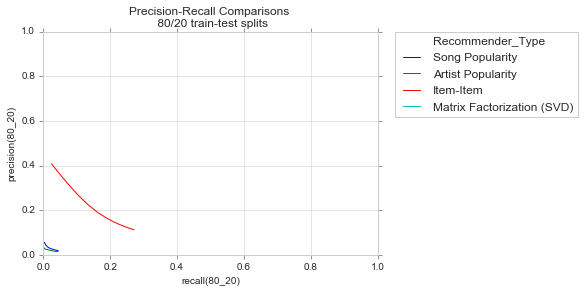

In [17]:
#Graph precison and recall curves of the 80/20 train-test splits.

%matplotlib inline

sns.set_style("whitegrid")

sns.despine()

sns.lineplot(x='recall(80_20)', y='precision(80_20)', data = precision_recall_overall, 
             hue='Recommender_Type', markers=True)

plt.title('Precision-Recall Comparisons \n 80/20 train-test splits')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(np.arange(0, 1.2, step=0.2))
plt.yticks(np.arange(0, 1.2, step=0.2))

plt.show()

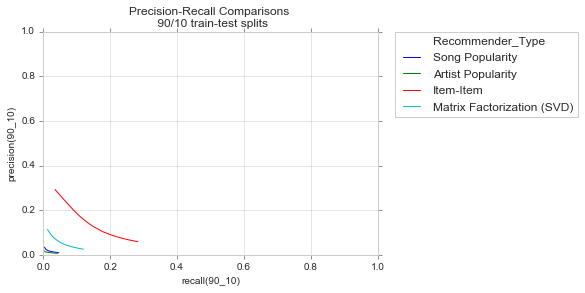

In [15]:
#Graph precison and recall curves of the 90/10 train-test splits.

%matplotlib inline

sns.set_style("whitegrid")

sns.despine()

sns.lineplot(x='recall(90_10)', y='precision(90_10)', data = precision_recall_overall, 
             hue='Recommender_Type', markers=True)

plt.title('Precision-Recall Comparisons \n 90/10 train-test splits')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(np.arange(0, 1.2, step=0.2))
plt.yticks(np.arange(0, 1.2, step=0.2))

plt.show()

## Graph F-scores (80/20 & 90/20 splits)

Graph f-scores at each prediction cutoff (number of predictions made) for the 80/20 test-train splits and the 90/10 train test splits by recommender type.

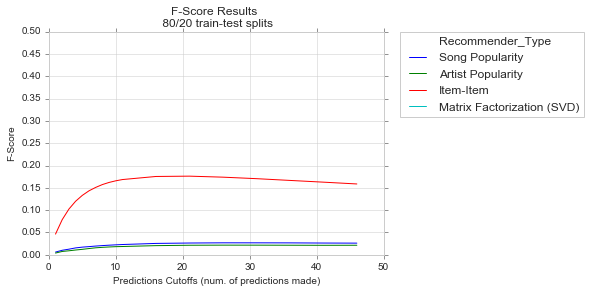

In [19]:
#Graph f-score curves of the 80/20 train-test splits.

%matplotlib inline

sns.set_style("whitegrid")

sns.despine()

sns.lineplot(x='cutoff', y='FScore_80_20', data = precision_recall_overall, 
             hue='Recommender_Type', markers=True)

plt.title('F-Score Results \n 80/20 train-test splits')

plt.ylabel('F-Score')
plt.xlabel('Predictions Cutoffs (num. of predictions made)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.yticks(np.arange(0, .55, step=0.05))
#plt.xticks(cutoffs)

plt.show()

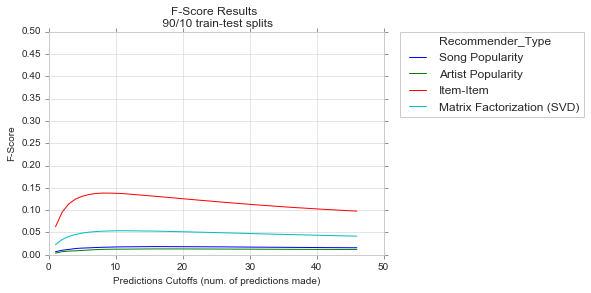

In [21]:
#Graph f-score curves of the 90/10 train-test splits.

%matplotlib inline

sns.set_style("whitegrid")

sns.despine()

sns.lineplot(x='cutoff', y='FScore_90_10', data = precision_recall_overall, 
             hue='Recommender_Type', markers=True)

plt.title('F-Score Results \n 90/10 train-test splits')

plt.ylabel('F-Score')
plt.xlabel('Predictions Cutoffs (num. of predictions made)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.yticks(np.arange(0, .55, step=0.05))
#plt.yticks(cutoffs)

plt.show()

## Major Findings

+ None of the recomenders performed reasonably well.

+ Given the performance results, there are no signs of overfitting.

+ Item based collaborative filtering performed significantly better than matrix factorization, song popularity and artist popularity recomenders. 

+ Both of the personalized recomenders performed better than popularity based recomenders.

## Recomendations & Next Steps

+ I was limited in the amount of computational resources available. With greater resources the performance of the matrix facorizatiib recomender could be improved by hyperparameter tuning. 

+ While there are no indications of overfitting, cross-validation was not performned in this application. 

+ A content - based recomender was attempted but to exceuted due to the resources needed to train that recomender on the large library of songs. Given the large amounts of information

+ Clustering is another approach that could be explored. 

+ This is a large dataset with very sparse data. A esemble method may be a good option to handle the capricious nature of music listening, sparsity, and exploit several aspects of the available data (implicit, content characteristics).

+ The performance of the recomendation engine in a real-life scenario is best acertained by research and the extent users engage with the recomendations.

# End of Notebook